# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [189]:
import importlib
import training
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [190]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'PMLC',
                        'data_processed', 'Dataset_Pendigits.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
M, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, M, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [191]:
# normalization
X = X / torch.std(X, axis=0)
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(6.1658))

In [192]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
test_rate = 0.2
M_train = int(M*train_rate)
M_test = int(M*test_rate)
train_data, rest_data = random_split(dataset, [M_train, M-M_train])
test_data, valid_data = random_split(rest_data, [M_test, M-M_train-M_test])
len(train_data), len(test_data), len(valid_data)

(6595, 2198, 2199)

In [193]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [6]:
N_Hidden = 10

# Normal NN
## Training

In [9]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
NN.apply(weights_init)

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=16, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): Tanh()
)

In [10]:
from tqdm.notebook import tqdm
import copy
train_loss_NN = []
test_loss_NN = []
parameter_NN = copy.deepcopy(NN.state_dict())
bestloss = 10000

for epoch in tqdm(range(5000)):
    for x_temp, y_temp in train_loader:
        optimizer_NN.zero_grad()
        prediction = NN(x_temp)
        loss = celoss(prediction, y_temp)
        loss.backward()
        optimizer_NN.step()
    train_loss_NN.append(copy.deepcopy(loss.detach().numpy()))
    
    for x_valid, y_valid in test_loader:
        prediction_valid = NN(x_valid)
        p = torch.argmax(prediction_valid, 1)
        pred_y = p.data.numpy().squeeze()
        acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]
        loss_valid = celoss(prediction_valid, y_valid)
    
    test_loss_NN.append(copy.deepcopy(loss_valid.detach().numpy()))
    
    if loss_valid.data < bestloss:
        bestloss = loss_valid.data
        parameter_NN = copy.deepcopy(NN.state_dict())
    
    if epoch % 10 == 0:
        print(f'| Epoch: {epoch:-5d} | Accuracy: {acc_valid:.5f} | Loss: {loss_valid.data:.5f} |')

  0%|          | 0/5000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33894 | Loss: 2.06830 |
| Epoch:    10 | Accuracy: 0.73385 | Loss: 1.20270 |
| Epoch:    20 | Accuracy: 0.81938 | Loss: 1.00971 |
| Epoch:    30 | Accuracy: 0.84304 | Loss: 0.95192 |
| Epoch:    40 | Accuracy: 0.85851 | Loss: 0.92094 |
| Epoch:    50 | Accuracy: 0.87307 | Loss: 0.90009 |
| Epoch:    60 | Accuracy: 0.88217 | Loss: 0.88955 |
| Epoch:    70 | Accuracy: 0.88444 | Loss: 0.88736 |
| Epoch:    80 | Accuracy: 0.89809 | Loss: 0.88013 |
| Epoch:    90 | Accuracy: 0.97179 | Loss: 0.85331 |
| Epoch:   100 | Accuracy: 0.97452 | Loss: 0.84634 |
| Epoch:   110 | Accuracy: 0.97589 | Loss: 0.84233 |
| Epoch:   120 | Accuracy: 0.97589 | Loss: 0.84443 |
| Epoch:   130 | Accuracy: 0.97543 | Loss: 0.83999 |
| Epoch:   140 | Accuracy: 0.98135 | Loss: 0.83573 |
| Epoch:   150 | Accuracy: 0.97998 | Loss: 0.83719 |
| Epoch:   160 | Accuracy: 0.97816 | Loss: 0.83254 |
| Epoch:   170 | Accuracy: 0.97816 | Loss: 0.83345 |
| Epoch:   180 | Accuracy: 0.98044 | Loss: 0.8

| Epoch:  1550 | Accuracy: 0.97179 | Loss: 0.84065 |
| Epoch:  1560 | Accuracy: 0.97998 | Loss: 0.83250 |
| Epoch:  1570 | Accuracy: 0.98044 | Loss: 0.83384 |
| Epoch:  1580 | Accuracy: 0.98135 | Loss: 0.83243 |
| Epoch:  1590 | Accuracy: 0.98044 | Loss: 0.83315 |
| Epoch:  1600 | Accuracy: 0.97907 | Loss: 0.83492 |
| Epoch:  1610 | Accuracy: 0.97771 | Loss: 0.83596 |
| Epoch:  1620 | Accuracy: 0.97589 | Loss: 0.83772 |
| Epoch:  1630 | Accuracy: 0.97998 | Loss: 0.83275 |
| Epoch:  1640 | Accuracy: 0.97862 | Loss: 0.83627 |
| Epoch:  1650 | Accuracy: 0.97953 | Loss: 0.83268 |
| Epoch:  1660 | Accuracy: 0.97634 | Loss: 0.83208 |
| Epoch:  1670 | Accuracy: 0.98135 | Loss: 0.83057 |
| Epoch:  1680 | Accuracy: 0.97907 | Loss: 0.83457 |
| Epoch:  1690 | Accuracy: 0.98135 | Loss: 0.83063 |
| Epoch:  1700 | Accuracy: 0.97862 | Loss: 0.83779 |
| Epoch:  1710 | Accuracy: 0.96679 | Loss: 0.85334 |
| Epoch:  1720 | Accuracy: 0.97543 | Loss: 0.83496 |
| Epoch:  1730 | Accuracy: 0.97634 | Loss: 0.8

| Epoch:  3100 | Accuracy: 0.97498 | Loss: 0.83864 |
| Epoch:  3110 | Accuracy: 0.97088 | Loss: 0.84371 |
| Epoch:  3120 | Accuracy: 0.97498 | Loss: 0.83591 |
| Epoch:  3130 | Accuracy: 0.98089 | Loss: 0.82878 |
| Epoch:  3140 | Accuracy: 0.97589 | Loss: 0.83836 |
| Epoch:  3150 | Accuracy: 0.97680 | Loss: 0.83882 |
| Epoch:  3160 | Accuracy: 0.97862 | Loss: 0.83288 |
| Epoch:  3170 | Accuracy: 0.97771 | Loss: 0.83618 |
| Epoch:  3180 | Accuracy: 0.98044 | Loss: 0.83366 |
| Epoch:  3190 | Accuracy: 0.97589 | Loss: 0.83655 |
| Epoch:  3200 | Accuracy: 0.97998 | Loss: 0.83383 |
| Epoch:  3210 | Accuracy: 0.97953 | Loss: 0.83284 |
| Epoch:  3220 | Accuracy: 0.97953 | Loss: 0.83025 |
| Epoch:  3230 | Accuracy: 0.98226 | Loss: 0.83029 |
| Epoch:  3240 | Accuracy: 0.98271 | Loss: 0.83010 |
| Epoch:  3250 | Accuracy: 0.98317 | Loss: 0.82997 |
| Epoch:  3260 | Accuracy: 0.98362 | Loss: 0.83072 |
| Epoch:  3270 | Accuracy: 0.98317 | Loss: 0.83066 |
| Epoch:  3280 | Accuracy: 0.98317 | Loss: 0.8

| Epoch:  4650 | Accuracy: 0.98089 | Loss: 0.83136 |
| Epoch:  4660 | Accuracy: 0.98044 | Loss: 0.83132 |
| Epoch:  4670 | Accuracy: 0.98044 | Loss: 0.83126 |
| Epoch:  4680 | Accuracy: 0.98135 | Loss: 0.83126 |
| Epoch:  4690 | Accuracy: 0.98135 | Loss: 0.83129 |
| Epoch:  4700 | Accuracy: 0.98135 | Loss: 0.83133 |
| Epoch:  4710 | Accuracy: 0.98135 | Loss: 0.83138 |
| Epoch:  4720 | Accuracy: 0.98135 | Loss: 0.83142 |
| Epoch:  4730 | Accuracy: 0.98135 | Loss: 0.83146 |
| Epoch:  4740 | Accuracy: 0.95086 | Loss: 0.89171 |
| Epoch:  4750 | Accuracy: 0.95996 | Loss: 0.85708 |
| Epoch:  4760 | Accuracy: 0.97589 | Loss: 0.83705 |
| Epoch:  4770 | Accuracy: 0.97452 | Loss: 0.84237 |
| Epoch:  4780 | Accuracy: 0.97270 | Loss: 0.84627 |
| Epoch:  4790 | Accuracy: 0.96724 | Loss: 0.85465 |
| Epoch:  4800 | Accuracy: 0.97907 | Loss: 0.83489 |
| Epoch:  4810 | Accuracy: 0.97498 | Loss: 0.84031 |
| Epoch:  4820 | Accuracy: 0.97771 | Loss: 0.83864 |
| Epoch:  4830 | Accuracy: 0.97816 | Loss: 0.8

(527, array(0.8234945, dtype=float32))

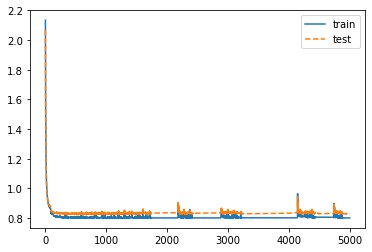

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]
print(acc_valid)

0.98681218735789


In [18]:
# torch.save(NN, f'./pendigitresult/NN_10_10.pkl')

# PNN
## Training

In [19]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer = torch.optim.Adam(PNN.parameters(), lr=0.001)
PNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [20]:
importlib.reload(training)
m = 0.3
T = 0.1
train_loss_PNN, test_loss_PNN, parameter_PNN = training.train_normal_pnn(
    PNN, train_loader, test_loader, m, T, optimizer, 15000)

| Epoch:     0 | Accuracy: 0.09509 | Loss: 1.39600 |
| Epoch:     1 | Accuracy: 0.09509 | Loss: 1.39600 |
| Epoch:     2 | Accuracy: 0.09509 | Loss: 1.39599 |
| Epoch:     3 | Accuracy: 0.09509 | Loss: 1.39599 |
| Epoch:     4 | Accuracy: 0.09509 | Loss: 1.39599 |
| Epoch:     5 | Accuracy: 0.09509 | Loss: 1.39599 |
| Epoch:     6 | Accuracy: 0.09509 | Loss: 1.39599 |
| Epoch:     7 | Accuracy: 0.09509 | Loss: 1.39598 |
| Epoch:     8 | Accuracy: 0.09509 | Loss: 1.39598 |
| Epoch:     9 | Accuracy: 0.09509 | Loss: 1.39597 |
| Epoch:    10 | Accuracy: 0.09509 | Loss: 1.39595 |
| Epoch:    11 | Accuracy: 0.09509 | Loss: 1.39593 |
| Epoch:    12 | Accuracy: 0.09509 | Loss: 1.39590 |
| Epoch:    13 | Accuracy: 0.09509 | Loss: 1.39585 |
| Epoch:    14 | Accuracy: 0.09509 | Loss: 1.39577 |
| Epoch:    15 | Accuracy: 0.09509 | Loss: 1.39565 |
| Epoch:    16 | Accuracy: 0.09509 | Loss: 1.39546 |
| Epoch:    17 | Accuracy: 0.09509 | Loss: 1.39516 |
| Epoch:    18 | Accuracy: 0.09509 | Loss: 1.3

| Epoch:   155 | Accuracy: 0.61419 | Loss: 0.62978 |
| Epoch:   156 | Accuracy: 0.61419 | Loss: 0.62931 |
| Epoch:   157 | Accuracy: 0.61874 | Loss: 0.62881 |
| Epoch:   158 | Accuracy: 0.62011 | Loss: 0.62829 |
| Epoch:   159 | Accuracy: 0.62329 | Loss: 0.62775 |
| Epoch:   160 | Accuracy: 0.62466 | Loss: 0.62718 |
| Epoch:   161 | Accuracy: 0.63194 | Loss: 0.62659 |
| Epoch:   162 | Accuracy: 0.63558 | Loss: 0.62599 |
| Epoch:   163 | Accuracy: 0.63831 | Loss: 0.62535 |
| Epoch:   164 | Accuracy: 0.64377 | Loss: 0.62466 |
| Epoch:   165 | Accuracy: 0.64422 | Loss: 0.62397 |
| Epoch:   166 | Accuracy: 0.64741 | Loss: 0.62325 |
| Epoch:   167 | Accuracy: 0.64877 | Loss: 0.62251 |
| Epoch:   168 | Accuracy: 0.65196 | Loss: 0.62168 |
| Epoch:   169 | Accuracy: 0.65469 | Loss: 0.62087 |
| Epoch:   170 | Accuracy: 0.65514 | Loss: 0.62008 |
| Epoch:   171 | Accuracy: 0.66333 | Loss: 0.61917 |
| Epoch:   172 | Accuracy: 0.66060 | Loss: 0.61827 |
| Epoch:   173 | Accuracy: 0.66151 | Loss: 0.6

| Epoch:   310 | Accuracy: 0.74841 | Loss: 0.45621 |
| Epoch:   311 | Accuracy: 0.74977 | Loss: 0.45559 |
| Epoch:   312 | Accuracy: 0.75023 | Loss: 0.45497 |
| Epoch:   313 | Accuracy: 0.75159 | Loss: 0.45430 |
| Epoch:   314 | Accuracy: 0.75159 | Loss: 0.45367 |
| Epoch:   315 | Accuracy: 0.75341 | Loss: 0.45298 |
| Epoch:   316 | Accuracy: 0.75478 | Loss: 0.45232 |
| Epoch:   317 | Accuracy: 0.75569 | Loss: 0.45164 |
| Epoch:   318 | Accuracy: 0.75751 | Loss: 0.45094 |
| Epoch:   319 | Accuracy: 0.75933 | Loss: 0.45022 |
| Epoch:   320 | Accuracy: 0.76024 | Loss: 0.44948 |
| Epoch:   321 | Accuracy: 0.76069 | Loss: 0.44873 |
| Epoch:   322 | Accuracy: 0.76206 | Loss: 0.44798 |
| Epoch:   323 | Accuracy: 0.76433 | Loss: 0.44721 |
| Epoch:   324 | Accuracy: 0.76570 | Loss: 0.44641 |
| Epoch:   325 | Accuracy: 0.76524 | Loss: 0.44559 |
| Epoch:   326 | Accuracy: 0.76433 | Loss: 0.44475 |
| Epoch:   327 | Accuracy: 0.76570 | Loss: 0.44390 |
| Epoch:   328 | Accuracy: 0.76706 | Loss: 0.4

| Epoch:   465 | Accuracy: 0.82302 | Loss: 0.31520 |
| Epoch:   466 | Accuracy: 0.82302 | Loss: 0.31462 |
| Epoch:   467 | Accuracy: 0.82348 | Loss: 0.31405 |
| Epoch:   468 | Accuracy: 0.82211 | Loss: 0.31349 |
| Epoch:   469 | Accuracy: 0.82257 | Loss: 0.31293 |
| Epoch:   470 | Accuracy: 0.82302 | Loss: 0.31237 |
| Epoch:   471 | Accuracy: 0.82302 | Loss: 0.31183 |
| Epoch:   472 | Accuracy: 0.82302 | Loss: 0.31128 |
| Epoch:   473 | Accuracy: 0.82393 | Loss: 0.31076 |
| Epoch:   474 | Accuracy: 0.82393 | Loss: 0.31023 |
| Epoch:   475 | Accuracy: 0.82393 | Loss: 0.30971 |
| Epoch:   476 | Accuracy: 0.82439 | Loss: 0.30917 |
| Epoch:   477 | Accuracy: 0.82348 | Loss: 0.30868 |
| Epoch:   478 | Accuracy: 0.82393 | Loss: 0.30816 |
| Epoch:   479 | Accuracy: 0.82575 | Loss: 0.30763 |
| Epoch:   480 | Accuracy: 0.82484 | Loss: 0.30712 |
| Epoch:   481 | Accuracy: 0.82530 | Loss: 0.30661 |
| Epoch:   482 | Accuracy: 0.82530 | Loss: 0.30610 |
| Epoch:   483 | Accuracy: 0.82575 | Loss: 0.3

| Epoch:   620 | Accuracy: 0.83667 | Loss: 0.26700 |
| Epoch:   621 | Accuracy: 0.83667 | Loss: 0.26685 |
| Epoch:   622 | Accuracy: 0.83667 | Loss: 0.26669 |
| Epoch:   623 | Accuracy: 0.83667 | Loss: 0.26652 |
| Epoch:   624 | Accuracy: 0.83667 | Loss: 0.26639 |
| Epoch:   625 | Accuracy: 0.83667 | Loss: 0.26623 |
| Epoch:   626 | Accuracy: 0.83667 | Loss: 0.26612 |
| Epoch:   627 | Accuracy: 0.83667 | Loss: 0.26598 |
| Epoch:   628 | Accuracy: 0.83621 | Loss: 0.26584 |
| Epoch:   629 | Accuracy: 0.83667 | Loss: 0.26572 |
| Epoch:   630 | Accuracy: 0.83667 | Loss: 0.26558 |
| Epoch:   631 | Accuracy: 0.83621 | Loss: 0.26544 |
| Epoch:   632 | Accuracy: 0.83621 | Loss: 0.26530 |
| Epoch:   633 | Accuracy: 0.83621 | Loss: 0.26517 |
| Epoch:   634 | Accuracy: 0.83621 | Loss: 0.26502 |
| Epoch:   635 | Accuracy: 0.83667 | Loss: 0.26489 |
| Epoch:   636 | Accuracy: 0.83667 | Loss: 0.26475 |
| Epoch:   637 | Accuracy: 0.83667 | Loss: 0.26463 |
| Epoch:   638 | Accuracy: 0.83667 | Loss: 0.2

| Epoch:   775 | Accuracy: 0.84713 | Loss: 0.24441 |
| Epoch:   776 | Accuracy: 0.84759 | Loss: 0.24423 |
| Epoch:   777 | Accuracy: 0.84713 | Loss: 0.24416 |
| Epoch:   778 | Accuracy: 0.84759 | Loss: 0.24395 |
| Epoch:   779 | Accuracy: 0.84713 | Loss: 0.24385 |
| Epoch:   780 | Accuracy: 0.84713 | Loss: 0.24370 |
| Epoch:   781 | Accuracy: 0.84713 | Loss: 0.24359 |
| Epoch:   782 | Accuracy: 0.84713 | Loss: 0.24343 |
| Epoch:   783 | Accuracy: 0.84713 | Loss: 0.24329 |
| Epoch:   784 | Accuracy: 0.84713 | Loss: 0.24315 |
| Epoch:   785 | Accuracy: 0.84713 | Loss: 0.24304 |
| Epoch:   786 | Accuracy: 0.84713 | Loss: 0.24291 |
| Epoch:   787 | Accuracy: 0.84759 | Loss: 0.24278 |
| Epoch:   788 | Accuracy: 0.84759 | Loss: 0.24265 |
| Epoch:   789 | Accuracy: 0.84713 | Loss: 0.24253 |
| Epoch:   790 | Accuracy: 0.84759 | Loss: 0.24239 |
| Epoch:   791 | Accuracy: 0.84713 | Loss: 0.24228 |
| Epoch:   792 | Accuracy: 0.84759 | Loss: 0.24214 |
| Epoch:   793 | Accuracy: 0.84804 | Loss: 0.2

| Epoch:   930 | Accuracy: 0.86078 | Loss: 0.22948 |
| Epoch:   931 | Accuracy: 0.86124 | Loss: 0.22939 |
| Epoch:   932 | Accuracy: 0.86169 | Loss: 0.22935 |
| Epoch:   933 | Accuracy: 0.86124 | Loss: 0.22929 |
| Epoch:   934 | Accuracy: 0.86124 | Loss: 0.22920 |
| Epoch:   935 | Accuracy: 0.86078 | Loss: 0.22918 |
| Epoch:   936 | Accuracy: 0.86078 | Loss: 0.22908 |
| Epoch:   937 | Accuracy: 0.86078 | Loss: 0.22905 |
| Epoch:   938 | Accuracy: 0.86078 | Loss: 0.22900 |
| Epoch:   939 | Accuracy: 0.86033 | Loss: 0.22894 |
| Epoch:   940 | Accuracy: 0.86033 | Loss: 0.22886 |
| Epoch:   941 | Accuracy: 0.85987 | Loss: 0.22880 |
| Epoch:   942 | Accuracy: 0.86033 | Loss: 0.22877 |
| Epoch:   943 | Accuracy: 0.85987 | Loss: 0.22867 |
| Epoch:   944 | Accuracy: 0.86033 | Loss: 0.22864 |
| Epoch:   945 | Accuracy: 0.86033 | Loss: 0.22860 |
| Epoch:   946 | Accuracy: 0.86078 | Loss: 0.22850 |
| Epoch:   947 | Accuracy: 0.86033 | Loss: 0.22850 |
| Epoch:   948 | Accuracy: 0.85987 | Loss: 0.2

| Epoch:  1085 | Accuracy: 0.86306 | Loss: 0.22161 |
| Epoch:  1086 | Accuracy: 0.86260 | Loss: 0.22157 |
| Epoch:  1087 | Accuracy: 0.86306 | Loss: 0.22152 |
| Epoch:  1088 | Accuracy: 0.86260 | Loss: 0.22148 |
| Epoch:  1089 | Accuracy: 0.86306 | Loss: 0.22143 |
| Epoch:  1090 | Accuracy: 0.86260 | Loss: 0.22137 |
| Epoch:  1091 | Accuracy: 0.86306 | Loss: 0.22135 |
| Epoch:  1092 | Accuracy: 0.86306 | Loss: 0.22129 |
| Epoch:  1093 | Accuracy: 0.86306 | Loss: 0.22122 |
| Epoch:  1094 | Accuracy: 0.86306 | Loss: 0.22117 |
| Epoch:  1095 | Accuracy: 0.86306 | Loss: 0.22115 |
| Epoch:  1096 | Accuracy: 0.86306 | Loss: 0.22110 |
| Epoch:  1097 | Accuracy: 0.86351 | Loss: 0.22103 |
| Epoch:  1098 | Accuracy: 0.86351 | Loss: 0.22097 |
| Epoch:  1099 | Accuracy: 0.86306 | Loss: 0.22092 |
| Epoch:  1100 | Accuracy: 0.86351 | Loss: 0.22083 |
| Epoch:  1101 | Accuracy: 0.86306 | Loss: 0.22081 |
| Epoch:  1102 | Accuracy: 0.86306 | Loss: 0.22074 |
| Epoch:  1103 | Accuracy: 0.86306 | Loss: 0.2

| Epoch:  1240 | Accuracy: 0.87079 | Loss: 0.21460 |
| Epoch:  1241 | Accuracy: 0.87125 | Loss: 0.21454 |
| Epoch:  1242 | Accuracy: 0.87079 | Loss: 0.21449 |
| Epoch:  1243 | Accuracy: 0.87034 | Loss: 0.21447 |
| Epoch:  1244 | Accuracy: 0.87079 | Loss: 0.21439 |
| Epoch:  1245 | Accuracy: 0.87034 | Loss: 0.21435 |
| Epoch:  1246 | Accuracy: 0.87034 | Loss: 0.21430 |
| Epoch:  1247 | Accuracy: 0.87034 | Loss: 0.21427 |
| Epoch:  1248 | Accuracy: 0.87079 | Loss: 0.21425 |
| Epoch:  1249 | Accuracy: 0.87079 | Loss: 0.21418 |
| Epoch:  1250 | Accuracy: 0.87079 | Loss: 0.21413 |
| Epoch:  1251 | Accuracy: 0.87079 | Loss: 0.21409 |
| Epoch:  1252 | Accuracy: 0.87079 | Loss: 0.21404 |
| Epoch:  1253 | Accuracy: 0.87079 | Loss: 0.21397 |
| Epoch:  1254 | Accuracy: 0.87079 | Loss: 0.21395 |
| Epoch:  1255 | Accuracy: 0.87079 | Loss: 0.21390 |
| Epoch:  1256 | Accuracy: 0.87079 | Loss: 0.21387 |
| Epoch:  1257 | Accuracy: 0.87125 | Loss: 0.21380 |
| Epoch:  1258 | Accuracy: 0.87170 | Loss: 0.2

| Epoch:  1395 | Accuracy: 0.88035 | Loss: 0.20775 |
| Epoch:  1396 | Accuracy: 0.88080 | Loss: 0.20758 |
| Epoch:  1397 | Accuracy: 0.88035 | Loss: 0.20765 |
| Epoch:  1398 | Accuracy: 0.88080 | Loss: 0.20754 |
| Epoch:  1399 | Accuracy: 0.88035 | Loss: 0.20751 |
| Epoch:  1400 | Accuracy: 0.88080 | Loss: 0.20743 |
| Epoch:  1401 | Accuracy: 0.87989 | Loss: 0.20744 |
| Epoch:  1402 | Accuracy: 0.88080 | Loss: 0.20734 |
| Epoch:  1403 | Accuracy: 0.87989 | Loss: 0.20734 |
| Epoch:  1404 | Accuracy: 0.88035 | Loss: 0.20726 |
| Epoch:  1405 | Accuracy: 0.87989 | Loss: 0.20726 |
| Epoch:  1406 | Accuracy: 0.88035 | Loss: 0.20714 |
| Epoch:  1407 | Accuracy: 0.87989 | Loss: 0.20718 |
| Epoch:  1408 | Accuracy: 0.88035 | Loss: 0.20708 |
| Epoch:  1409 | Accuracy: 0.87989 | Loss: 0.20707 |
| Epoch:  1410 | Accuracy: 0.88035 | Loss: 0.20705 |
| Epoch:  1411 | Accuracy: 0.88035 | Loss: 0.20693 |
| Epoch:  1412 | Accuracy: 0.88035 | Loss: 0.20693 |
| Epoch:  1413 | Accuracy: 0.88035 | Loss: 0.2

| Epoch:  1550 | Accuracy: 0.88490 | Loss: 0.20196 |
| Epoch:  1551 | Accuracy: 0.88490 | Loss: 0.20191 |
| Epoch:  1552 | Accuracy: 0.88490 | Loss: 0.20186 |
| Epoch:  1553 | Accuracy: 0.88490 | Loss: 0.20182 |
| Epoch:  1554 | Accuracy: 0.88490 | Loss: 0.20173 |
| Epoch:  1555 | Accuracy: 0.88490 | Loss: 0.20175 |
| Epoch:  1556 | Accuracy: 0.88490 | Loss: 0.20163 |
| Epoch:  1557 | Accuracy: 0.88490 | Loss: 0.20169 |
| Epoch:  1558 | Accuracy: 0.88490 | Loss: 0.20161 |
| Epoch:  1559 | Accuracy: 0.88490 | Loss: 0.20166 |
| Epoch:  1560 | Accuracy: 0.88490 | Loss: 0.20157 |
| Epoch:  1561 | Accuracy: 0.88535 | Loss: 0.20152 |
| Epoch:  1562 | Accuracy: 0.88535 | Loss: 0.20150 |
| Epoch:  1563 | Accuracy: 0.88535 | Loss: 0.20143 |
| Epoch:  1564 | Accuracy: 0.88535 | Loss: 0.20141 |
| Epoch:  1565 | Accuracy: 0.88535 | Loss: 0.20131 |
| Epoch:  1566 | Accuracy: 0.88581 | Loss: 0.20140 |
| Epoch:  1567 | Accuracy: 0.88535 | Loss: 0.20125 |
| Epoch:  1568 | Accuracy: 0.88581 | Loss: 0.2

| Epoch:  1705 | Accuracy: 0.88899 | Loss: 0.19772 |
| Epoch:  1706 | Accuracy: 0.88944 | Loss: 0.19758 |
| Epoch:  1707 | Accuracy: 0.88899 | Loss: 0.19769 |
| Epoch:  1708 | Accuracy: 0.88899 | Loss: 0.19752 |
| Epoch:  1709 | Accuracy: 0.88899 | Loss: 0.19760 |
| Epoch:  1710 | Accuracy: 0.88854 | Loss: 0.19746 |
| Epoch:  1711 | Accuracy: 0.88944 | Loss: 0.19752 |
| Epoch:  1712 | Accuracy: 0.88944 | Loss: 0.19740 |
| Epoch:  1713 | Accuracy: 0.88899 | Loss: 0.19750 |
| Epoch:  1714 | Accuracy: 0.88899 | Loss: 0.19733 |
| Epoch:  1715 | Accuracy: 0.88899 | Loss: 0.19743 |
| Epoch:  1716 | Accuracy: 0.88854 | Loss: 0.19724 |
| Epoch:  1717 | Accuracy: 0.88899 | Loss: 0.19724 |
| Epoch:  1718 | Accuracy: 0.88899 | Loss: 0.19721 |
| Epoch:  1719 | Accuracy: 0.88899 | Loss: 0.19727 |
| Epoch:  1720 | Accuracy: 0.88899 | Loss: 0.19712 |
| Epoch:  1721 | Accuracy: 0.88899 | Loss: 0.19713 |
| Epoch:  1722 | Accuracy: 0.88944 | Loss: 0.19708 |
| Epoch:  1723 | Accuracy: 0.88899 | Loss: 0.1

| Epoch:  1860 | Accuracy: 0.89035 | Loss: 0.19323 |
| Epoch:  1861 | Accuracy: 0.89035 | Loss: 0.19315 |
| Epoch:  1862 | Accuracy: 0.89081 | Loss: 0.19316 |
| Epoch:  1863 | Accuracy: 0.89126 | Loss: 0.19310 |
| Epoch:  1864 | Accuracy: 0.89126 | Loss: 0.19304 |
| Epoch:  1865 | Accuracy: 0.89126 | Loss: 0.19303 |
| Epoch:  1866 | Accuracy: 0.89126 | Loss: 0.19300 |
| Epoch:  1867 | Accuracy: 0.89081 | Loss: 0.19299 |
| Epoch:  1868 | Accuracy: 0.89081 | Loss: 0.19294 |
| Epoch:  1869 | Accuracy: 0.89172 | Loss: 0.19293 |
| Epoch:  1870 | Accuracy: 0.89126 | Loss: 0.19289 |
| Epoch:  1871 | Accuracy: 0.89126 | Loss: 0.19282 |
| Epoch:  1872 | Accuracy: 0.89172 | Loss: 0.19284 |
| Epoch:  1873 | Accuracy: 0.89081 | Loss: 0.19282 |
| Epoch:  1874 | Accuracy: 0.89126 | Loss: 0.19274 |
| Epoch:  1875 | Accuracy: 0.89126 | Loss: 0.19276 |
| Epoch:  1876 | Accuracy: 0.89081 | Loss: 0.19273 |
| Epoch:  1877 | Accuracy: 0.89081 | Loss: 0.19266 |
| Epoch:  1878 | Accuracy: 0.89126 | Loss: 0.1

| Epoch:  2015 | Accuracy: 0.89126 | Loss: 0.18933 |
| Epoch:  2016 | Accuracy: 0.89172 | Loss: 0.18927 |
| Epoch:  2017 | Accuracy: 0.89126 | Loss: 0.18929 |
| Epoch:  2018 | Accuracy: 0.89126 | Loss: 0.18915 |
| Epoch:  2019 | Accuracy: 0.89172 | Loss: 0.18928 |
| Epoch:  2020 | Accuracy: 0.89172 | Loss: 0.18916 |
| Epoch:  2021 | Accuracy: 0.89081 | Loss: 0.18921 |
| Epoch:  2022 | Accuracy: 0.89217 | Loss: 0.18914 |
| Epoch:  2023 | Accuracy: 0.89172 | Loss: 0.18910 |
| Epoch:  2024 | Accuracy: 0.89172 | Loss: 0.18906 |
| Epoch:  2025 | Accuracy: 0.89081 | Loss: 0.18906 |
| Epoch:  2026 | Accuracy: 0.89172 | Loss: 0.18900 |
| Epoch:  2027 | Accuracy: 0.89081 | Loss: 0.18905 |
| Epoch:  2028 | Accuracy: 0.89081 | Loss: 0.18899 |
| Epoch:  2029 | Accuracy: 0.89081 | Loss: 0.18897 |
| Epoch:  2030 | Accuracy: 0.89035 | Loss: 0.18897 |
| Epoch:  2031 | Accuracy: 0.89126 | Loss: 0.18890 |
| Epoch:  2032 | Accuracy: 0.89081 | Loss: 0.18893 |
| Epoch:  2033 | Accuracy: 0.89126 | Loss: 0.1

| Epoch:  2170 | Accuracy: 0.89217 | Loss: 0.18602 |
| Epoch:  2171 | Accuracy: 0.89217 | Loss: 0.18602 |
| Epoch:  2172 | Accuracy: 0.89217 | Loss: 0.18599 |
| Epoch:  2173 | Accuracy: 0.89217 | Loss: 0.18598 |
| Epoch:  2174 | Accuracy: 0.89217 | Loss: 0.18592 |
| Epoch:  2175 | Accuracy: 0.89217 | Loss: 0.18597 |
| Epoch:  2176 | Accuracy: 0.89217 | Loss: 0.18591 |
| Epoch:  2177 | Accuracy: 0.89217 | Loss: 0.18593 |
| Epoch:  2178 | Accuracy: 0.89217 | Loss: 0.18585 |
| Epoch:  2179 | Accuracy: 0.89263 | Loss: 0.18591 |
| Epoch:  2180 | Accuracy: 0.89217 | Loss: 0.18578 |
| Epoch:  2181 | Accuracy: 0.89263 | Loss: 0.18582 |
| Epoch:  2182 | Accuracy: 0.89263 | Loss: 0.18579 |
| Epoch:  2183 | Accuracy: 0.89308 | Loss: 0.18577 |
| Epoch:  2184 | Accuracy: 0.89263 | Loss: 0.18574 |
| Epoch:  2185 | Accuracy: 0.89263 | Loss: 0.18572 |
| Epoch:  2186 | Accuracy: 0.89263 | Loss: 0.18573 |
| Epoch:  2187 | Accuracy: 0.89308 | Loss: 0.18575 |
| Epoch:  2188 | Accuracy: 0.89308 | Loss: 0.1

| Epoch:  2325 | Accuracy: 0.89536 | Loss: 0.18255 |
| Epoch:  2326 | Accuracy: 0.89445 | Loss: 0.18253 |
| Epoch:  2327 | Accuracy: 0.89536 | Loss: 0.18253 |
| Epoch:  2328 | Accuracy: 0.89445 | Loss: 0.18249 |
| Epoch:  2329 | Accuracy: 0.89490 | Loss: 0.18244 |
| Epoch:  2330 | Accuracy: 0.89536 | Loss: 0.18248 |
| Epoch:  2331 | Accuracy: 0.89445 | Loss: 0.18245 |
| Epoch:  2332 | Accuracy: 0.89536 | Loss: 0.18243 |
| Epoch:  2333 | Accuracy: 0.89536 | Loss: 0.18243 |
| Epoch:  2334 | Accuracy: 0.89490 | Loss: 0.18238 |
| Epoch:  2335 | Accuracy: 0.89536 | Loss: 0.18239 |
| Epoch:  2336 | Accuracy: 0.89490 | Loss: 0.18235 |
| Epoch:  2337 | Accuracy: 0.89490 | Loss: 0.18232 |
| Epoch:  2338 | Accuracy: 0.89581 | Loss: 0.18235 |
| Epoch:  2339 | Accuracy: 0.89490 | Loss: 0.18230 |
| Epoch:  2340 | Accuracy: 0.89581 | Loss: 0.18232 |
| Epoch:  2341 | Accuracy: 0.89536 | Loss: 0.18223 |
| Epoch:  2342 | Accuracy: 0.89581 | Loss: 0.18226 |
| Epoch:  2343 | Accuracy: 0.89490 | Loss: 0.1

| Epoch:  2480 | Accuracy: 0.89900 | Loss: 0.17941 |
| Epoch:  2481 | Accuracy: 0.89945 | Loss: 0.17939 |
| Epoch:  2482 | Accuracy: 0.89945 | Loss: 0.17941 |
| Epoch:  2483 | Accuracy: 0.89945 | Loss: 0.17935 |
| Epoch:  2484 | Accuracy: 0.89945 | Loss: 0.17938 |
| Epoch:  2485 | Accuracy: 0.89945 | Loss: 0.17935 |
| Epoch:  2486 | Accuracy: 0.89945 | Loss: 0.17937 |
| Epoch:  2487 | Accuracy: 0.89945 | Loss: 0.17931 |
| Epoch:  2488 | Accuracy: 0.89945 | Loss: 0.17927 |
| Epoch:  2489 | Accuracy: 0.89945 | Loss: 0.17927 |
| Epoch:  2490 | Accuracy: 0.89991 | Loss: 0.17918 |
| Epoch:  2491 | Accuracy: 0.89945 | Loss: 0.17927 |
| Epoch:  2492 | Accuracy: 0.89991 | Loss: 0.17918 |
| Epoch:  2493 | Accuracy: 0.89945 | Loss: 0.17923 |
| Epoch:  2494 | Accuracy: 0.89945 | Loss: 0.17916 |
| Epoch:  2495 | Accuracy: 0.89945 | Loss: 0.17915 |
| Epoch:  2496 | Accuracy: 0.89945 | Loss: 0.17912 |
| Epoch:  2497 | Accuracy: 0.89945 | Loss: 0.17908 |
| Epoch:  2498 | Accuracy: 0.89991 | Loss: 0.1

| Epoch:  2635 | Accuracy: 0.90264 | Loss: 0.17648 |
| Epoch:  2636 | Accuracy: 0.90127 | Loss: 0.17642 |
| Epoch:  2637 | Accuracy: 0.90218 | Loss: 0.17636 |
| Epoch:  2638 | Accuracy: 0.90218 | Loss: 0.17643 |
| Epoch:  2639 | Accuracy: 0.90218 | Loss: 0.17635 |
| Epoch:  2640 | Accuracy: 0.90218 | Loss: 0.17632 |
| Epoch:  2641 | Accuracy: 0.90218 | Loss: 0.17636 |
| Epoch:  2642 | Accuracy: 0.90264 | Loss: 0.17635 |
| Epoch:  2643 | Accuracy: 0.90218 | Loss: 0.17626 |
| Epoch:  2644 | Accuracy: 0.90218 | Loss: 0.17633 |
| Epoch:  2645 | Accuracy: 0.90218 | Loss: 0.17632 |
| Epoch:  2646 | Accuracy: 0.90264 | Loss: 0.17627 |
| Epoch:  2647 | Accuracy: 0.90264 | Loss: 0.17629 |
| Epoch:  2648 | Accuracy: 0.90264 | Loss: 0.17626 |
| Epoch:  2649 | Accuracy: 0.90264 | Loss: 0.17624 |
| Epoch:  2650 | Accuracy: 0.90218 | Loss: 0.17622 |
| Epoch:  2651 | Accuracy: 0.90218 | Loss: 0.17623 |
| Epoch:  2652 | Accuracy: 0.90264 | Loss: 0.17628 |
| Epoch:  2653 | Accuracy: 0.90218 | Loss: 0.1

| Epoch:  2790 | Accuracy: 0.90446 | Loss: 0.17426 |
| Epoch:  2791 | Accuracy: 0.90355 | Loss: 0.17422 |
| Epoch:  2792 | Accuracy: 0.90400 | Loss: 0.17422 |
| Epoch:  2793 | Accuracy: 0.90446 | Loss: 0.17419 |
| Epoch:  2794 | Accuracy: 0.90400 | Loss: 0.17420 |
| Epoch:  2795 | Accuracy: 0.90400 | Loss: 0.17415 |
| Epoch:  2796 | Accuracy: 0.90400 | Loss: 0.17416 |
| Epoch:  2797 | Accuracy: 0.90491 | Loss: 0.17413 |
| Epoch:  2798 | Accuracy: 0.90446 | Loss: 0.17416 |
| Epoch:  2799 | Accuracy: 0.90491 | Loss: 0.17412 |
| Epoch:  2800 | Accuracy: 0.90491 | Loss: 0.17410 |
| Epoch:  2801 | Accuracy: 0.90491 | Loss: 0.17406 |
| Epoch:  2802 | Accuracy: 0.90446 | Loss: 0.17407 |
| Epoch:  2803 | Accuracy: 0.90400 | Loss: 0.17402 |
| Epoch:  2804 | Accuracy: 0.90491 | Loss: 0.17408 |
| Epoch:  2805 | Accuracy: 0.90491 | Loss: 0.17402 |
| Epoch:  2806 | Accuracy: 0.90491 | Loss: 0.17399 |
| Epoch:  2807 | Accuracy: 0.90491 | Loss: 0.17397 |
| Epoch:  2808 | Accuracy: 0.90491 | Loss: 0.1

| Epoch:  2945 | Accuracy: 0.90537 | Loss: 0.17227 |
| Epoch:  2946 | Accuracy: 0.90537 | Loss: 0.17222 |
| Epoch:  2947 | Accuracy: 0.90537 | Loss: 0.17217 |
| Epoch:  2948 | Accuracy: 0.90537 | Loss: 0.17216 |
| Epoch:  2949 | Accuracy: 0.90537 | Loss: 0.17218 |
| Epoch:  2950 | Accuracy: 0.90537 | Loss: 0.17218 |
| Epoch:  2951 | Accuracy: 0.90537 | Loss: 0.17205 |
| Epoch:  2952 | Accuracy: 0.90537 | Loss: 0.17209 |
| Epoch:  2953 | Accuracy: 0.90537 | Loss: 0.17211 |
| Epoch:  2954 | Accuracy: 0.90537 | Loss: 0.17208 |
| Epoch:  2955 | Accuracy: 0.90537 | Loss: 0.17207 |
| Epoch:  2956 | Accuracy: 0.90537 | Loss: 0.17203 |
| Epoch:  2957 | Accuracy: 0.90537 | Loss: 0.17215 |
| Epoch:  2958 | Accuracy: 0.90537 | Loss: 0.17201 |
| Epoch:  2959 | Accuracy: 0.90537 | Loss: 0.17205 |
| Epoch:  2960 | Accuracy: 0.90537 | Loss: 0.17203 |
| Epoch:  2961 | Accuracy: 0.90537 | Loss: 0.17204 |
| Epoch:  2962 | Accuracy: 0.90537 | Loss: 0.17201 |
| Epoch:  2963 | Accuracy: 0.90537 | Loss: 0.1

| Epoch:  3100 | Accuracy: 0.90537 | Loss: 0.17043 |
| Epoch:  3101 | Accuracy: 0.90491 | Loss: 0.17060 |
| Epoch:  3102 | Accuracy: 0.90582 | Loss: 0.17044 |
| Epoch:  3103 | Accuracy: 0.90582 | Loss: 0.17055 |
| Epoch:  3104 | Accuracy: 0.90582 | Loss: 0.17040 |
| Epoch:  3105 | Accuracy: 0.90537 | Loss: 0.17055 |
| Epoch:  3106 | Accuracy: 0.90537 | Loss: 0.17040 |
| Epoch:  3107 | Accuracy: 0.90582 | Loss: 0.17045 |
| Epoch:  3108 | Accuracy: 0.90582 | Loss: 0.17041 |
| Epoch:  3109 | Accuracy: 0.90537 | Loss: 0.17041 |
| Epoch:  3110 | Accuracy: 0.90582 | Loss: 0.17038 |
| Epoch:  3111 | Accuracy: 0.90537 | Loss: 0.17041 |
| Epoch:  3112 | Accuracy: 0.90537 | Loss: 0.17039 |
| Epoch:  3113 | Accuracy: 0.90582 | Loss: 0.17035 |
| Epoch:  3114 | Accuracy: 0.90582 | Loss: 0.17037 |
| Epoch:  3115 | Accuracy: 0.90537 | Loss: 0.17037 |
| Epoch:  3116 | Accuracy: 0.90582 | Loss: 0.17033 |
| Epoch:  3117 | Accuracy: 0.90491 | Loss: 0.17038 |
| Epoch:  3118 | Accuracy: 0.90582 | Loss: 0.1

| Epoch:  3255 | Accuracy: 0.90673 | Loss: 0.16911 |
| Epoch:  3256 | Accuracy: 0.90628 | Loss: 0.16896 |
| Epoch:  3257 | Accuracy: 0.90582 | Loss: 0.16915 |
| Epoch:  3258 | Accuracy: 0.90673 | Loss: 0.16899 |
| Epoch:  3259 | Accuracy: 0.90628 | Loss: 0.16899 |
| Epoch:  3260 | Accuracy: 0.90673 | Loss: 0.16904 |
| Epoch:  3261 | Accuracy: 0.90628 | Loss: 0.16895 |
| Epoch:  3262 | Accuracy: 0.90673 | Loss: 0.16901 |
| Epoch:  3263 | Accuracy: 0.90628 | Loss: 0.16900 |
| Epoch:  3264 | Accuracy: 0.90628 | Loss: 0.16888 |
| Epoch:  3265 | Accuracy: 0.90628 | Loss: 0.16902 |
| Epoch:  3266 | Accuracy: 0.90628 | Loss: 0.16888 |
| Epoch:  3267 | Accuracy: 0.90628 | Loss: 0.16901 |
| Epoch:  3268 | Accuracy: 0.90719 | Loss: 0.16888 |
| Epoch:  3269 | Accuracy: 0.90628 | Loss: 0.16889 |
| Epoch:  3270 | Accuracy: 0.90719 | Loss: 0.16891 |
| Epoch:  3271 | Accuracy: 0.90628 | Loss: 0.16886 |
| Epoch:  3272 | Accuracy: 0.90628 | Loss: 0.16894 |
| Epoch:  3273 | Accuracy: 0.90673 | Loss: 0.1

| Epoch:  3410 | Accuracy: 0.90855 | Loss: 0.16785 |
| Epoch:  3411 | Accuracy: 0.90855 | Loss: 0.16776 |
| Epoch:  3412 | Accuracy: 0.90855 | Loss: 0.16786 |
| Epoch:  3413 | Accuracy: 0.90855 | Loss: 0.16776 |
| Epoch:  3414 | Accuracy: 0.90855 | Loss: 0.16784 |
| Epoch:  3415 | Accuracy: 0.90855 | Loss: 0.16773 |
| Epoch:  3416 | Accuracy: 0.90810 | Loss: 0.16782 |
| Epoch:  3417 | Accuracy: 0.90855 | Loss: 0.16774 |
| Epoch:  3418 | Accuracy: 0.90810 | Loss: 0.16784 |
| Epoch:  3419 | Accuracy: 0.90855 | Loss: 0.16772 |
| Epoch:  3420 | Accuracy: 0.90901 | Loss: 0.16780 |
| Epoch:  3421 | Accuracy: 0.90855 | Loss: 0.16770 |
| Epoch:  3422 | Accuracy: 0.90901 | Loss: 0.16779 |
| Epoch:  3423 | Accuracy: 0.90855 | Loss: 0.16768 |
| Epoch:  3424 | Accuracy: 0.90901 | Loss: 0.16779 |
| Epoch:  3425 | Accuracy: 0.90855 | Loss: 0.16772 |
| Epoch:  3426 | Accuracy: 0.90855 | Loss: 0.16775 |
| Epoch:  3427 | Accuracy: 0.90810 | Loss: 0.16772 |
| Epoch:  3428 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  3565 | Accuracy: 0.90855 | Loss: 0.16701 |
| Epoch:  3566 | Accuracy: 0.90855 | Loss: 0.16693 |
| Epoch:  3567 | Accuracy: 0.90855 | Loss: 0.16691 |
| Epoch:  3568 | Accuracy: 0.90855 | Loss: 0.16697 |
| Epoch:  3569 | Accuracy: 0.90855 | Loss: 0.16695 |
| Epoch:  3570 | Accuracy: 0.90855 | Loss: 0.16690 |
| Epoch:  3571 | Accuracy: 0.90855 | Loss: 0.16695 |
| Epoch:  3572 | Accuracy: 0.90855 | Loss: 0.16692 |
| Epoch:  3573 | Accuracy: 0.90855 | Loss: 0.16691 |
| Epoch:  3574 | Accuracy: 0.90855 | Loss: 0.16695 |
| Epoch:  3575 | Accuracy: 0.90855 | Loss: 0.16690 |
| Epoch:  3576 | Accuracy: 0.90855 | Loss: 0.16693 |
| Epoch:  3577 | Accuracy: 0.90855 | Loss: 0.16695 |
| Epoch:  3578 | Accuracy: 0.90855 | Loss: 0.16690 |
| Epoch:  3579 | Accuracy: 0.90855 | Loss: 0.16690 |
| Epoch:  3580 | Accuracy: 0.90855 | Loss: 0.16693 |
| Epoch:  3581 | Accuracy: 0.90855 | Loss: 0.16691 |
| Epoch:  3582 | Accuracy: 0.90855 | Loss: 0.16689 |
| Epoch:  3583 | Accuracy: 0.90855 | Loss: 0.1

| Epoch:  3720 | Accuracy: 0.90764 | Loss: 0.16646 |
| Epoch:  3721 | Accuracy: 0.90764 | Loss: 0.16638 |
| Epoch:  3722 | Accuracy: 0.90764 | Loss: 0.16644 |
| Epoch:  3723 | Accuracy: 0.90764 | Loss: 0.16640 |
| Epoch:  3724 | Accuracy: 0.90764 | Loss: 0.16639 |
| Epoch:  3725 | Accuracy: 0.90764 | Loss: 0.16638 |
| Epoch:  3726 | Accuracy: 0.90764 | Loss: 0.16635 |
| Epoch:  3727 | Accuracy: 0.90764 | Loss: 0.16633 |
| Epoch:  3728 | Accuracy: 0.90764 | Loss: 0.16643 |
| Epoch:  3729 | Accuracy: 0.90764 | Loss: 0.16632 |
| Epoch:  3730 | Accuracy: 0.90764 | Loss: 0.16643 |
| Epoch:  3731 | Accuracy: 0.90764 | Loss: 0.16635 |
| Epoch:  3732 | Accuracy: 0.90764 | Loss: 0.16640 |
| Epoch:  3733 | Accuracy: 0.90764 | Loss: 0.16637 |
| Epoch:  3734 | Accuracy: 0.90764 | Loss: 0.16635 |
| Epoch:  3735 | Accuracy: 0.90764 | Loss: 0.16633 |
| Epoch:  3736 | Accuracy: 0.90764 | Loss: 0.16638 |
| Epoch:  3737 | Accuracy: 0.90764 | Loss: 0.16638 |
| Epoch:  3738 | Accuracy: 0.90764 | Loss: 0.1

| Epoch:  3875 | Accuracy: 0.90764 | Loss: 0.16577 |
| Epoch:  3876 | Accuracy: 0.90764 | Loss: 0.16584 |
| Epoch:  3877 | Accuracy: 0.90764 | Loss: 0.16576 |
| Epoch:  3878 | Accuracy: 0.90764 | Loss: 0.16580 |
| Epoch:  3879 | Accuracy: 0.90764 | Loss: 0.16574 |
| Epoch:  3880 | Accuracy: 0.90764 | Loss: 0.16580 |
| Epoch:  3881 | Accuracy: 0.90764 | Loss: 0.16571 |
| Epoch:  3882 | Accuracy: 0.90764 | Loss: 0.16577 |
| Epoch:  3883 | Accuracy: 0.90764 | Loss: 0.16574 |
| Epoch:  3884 | Accuracy: 0.90764 | Loss: 0.16574 |
| Epoch:  3885 | Accuracy: 0.90764 | Loss: 0.16576 |
| Epoch:  3886 | Accuracy: 0.90764 | Loss: 0.16570 |
| Epoch:  3887 | Accuracy: 0.90764 | Loss: 0.16571 |
| Epoch:  3888 | Accuracy: 0.90764 | Loss: 0.16570 |
| Epoch:  3889 | Accuracy: 0.90764 | Loss: 0.16572 |
| Epoch:  3890 | Accuracy: 0.90764 | Loss: 0.16567 |
| Epoch:  3891 | Accuracy: 0.90764 | Loss: 0.16565 |
| Epoch:  3892 | Accuracy: 0.90764 | Loss: 0.16570 |
| Epoch:  3893 | Accuracy: 0.90764 | Loss: 0.1

| Epoch:  4030 | Accuracy: 0.90719 | Loss: 0.16517 |
| Epoch:  4031 | Accuracy: 0.90855 | Loss: 0.16510 |
| Epoch:  4032 | Accuracy: 0.90719 | Loss: 0.16513 |
| Epoch:  4033 | Accuracy: 0.90855 | Loss: 0.16524 |
| Epoch:  4034 | Accuracy: 0.90719 | Loss: 0.16515 |
| Epoch:  4035 | Accuracy: 0.90764 | Loss: 0.16521 |
| Epoch:  4036 | Accuracy: 0.90810 | Loss: 0.16510 |
| Epoch:  4037 | Accuracy: 0.90810 | Loss: 0.16504 |
| Epoch:  4038 | Accuracy: 0.90764 | Loss: 0.16518 |
| Epoch:  4039 | Accuracy: 0.90764 | Loss: 0.16511 |
| Epoch:  4040 | Accuracy: 0.90810 | Loss: 0.16509 |
| Epoch:  4041 | Accuracy: 0.90764 | Loss: 0.16510 |
| Epoch:  4042 | Accuracy: 0.90719 | Loss: 0.16506 |
| Epoch:  4043 | Accuracy: 0.90810 | Loss: 0.16504 |
| Epoch:  4044 | Accuracy: 0.90764 | Loss: 0.16510 |
| Epoch:  4045 | Accuracy: 0.90810 | Loss: 0.16515 |
| Epoch:  4046 | Accuracy: 0.90719 | Loss: 0.16514 |
| Epoch:  4047 | Accuracy: 0.90855 | Loss: 0.16510 |
| Epoch:  4048 | Accuracy: 0.90764 | Loss: 0.1

| Epoch:  4185 | Accuracy: 0.90855 | Loss: 0.16476 |
| Epoch:  4186 | Accuracy: 0.90810 | Loss: 0.16461 |
| Epoch:  4187 | Accuracy: 0.90855 | Loss: 0.16473 |
| Epoch:  4188 | Accuracy: 0.90855 | Loss: 0.16471 |
| Epoch:  4189 | Accuracy: 0.90901 | Loss: 0.16464 |
| Epoch:  4190 | Accuracy: 0.90855 | Loss: 0.16464 |
| Epoch:  4191 | Accuracy: 0.90855 | Loss: 0.16465 |
| Epoch:  4192 | Accuracy: 0.90810 | Loss: 0.16471 |
| Epoch:  4193 | Accuracy: 0.90810 | Loss: 0.16456 |
| Epoch:  4194 | Accuracy: 0.90901 | Loss: 0.16476 |
| Epoch:  4195 | Accuracy: 0.90810 | Loss: 0.16467 |
| Epoch:  4196 | Accuracy: 0.90901 | Loss: 0.16463 |
| Epoch:  4197 | Accuracy: 0.90855 | Loss: 0.16461 |
| Epoch:  4198 | Accuracy: 0.90855 | Loss: 0.16463 |
| Epoch:  4199 | Accuracy: 0.90855 | Loss: 0.16465 |
| Epoch:  4200 | Accuracy: 0.90901 | Loss: 0.16462 |
| Epoch:  4201 | Accuracy: 0.90810 | Loss: 0.16471 |
| Epoch:  4202 | Accuracy: 0.90810 | Loss: 0.16466 |
| Epoch:  4203 | Accuracy: 0.90855 | Loss: 0.1

| Epoch:  4340 | Accuracy: 0.90992 | Loss: 0.16440 |
| Epoch:  4341 | Accuracy: 0.90901 | Loss: 0.16446 |
| Epoch:  4342 | Accuracy: 0.90946 | Loss: 0.16444 |
| Epoch:  4343 | Accuracy: 0.90901 | Loss: 0.16442 |
| Epoch:  4344 | Accuracy: 0.90946 | Loss: 0.16440 |
| Epoch:  4345 | Accuracy: 0.90901 | Loss: 0.16437 |
| Epoch:  4346 | Accuracy: 0.90901 | Loss: 0.16447 |
| Epoch:  4347 | Accuracy: 0.90946 | Loss: 0.16439 |
| Epoch:  4348 | Accuracy: 0.90901 | Loss: 0.16448 |
| Epoch:  4349 | Accuracy: 0.90946 | Loss: 0.16441 |
| Epoch:  4350 | Accuracy: 0.90946 | Loss: 0.16441 |
| Epoch:  4351 | Accuracy: 0.90946 | Loss: 0.16448 |
| Epoch:  4352 | Accuracy: 0.90946 | Loss: 0.16439 |
| Epoch:  4353 | Accuracy: 0.90855 | Loss: 0.16452 |
| Epoch:  4354 | Accuracy: 0.90901 | Loss: 0.16436 |
| Epoch:  4355 | Accuracy: 0.90946 | Loss: 0.16444 |
| Epoch:  4356 | Accuracy: 0.90992 | Loss: 0.16439 |
| Epoch:  4357 | Accuracy: 0.90946 | Loss: 0.16445 |
| Epoch:  4358 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  4495 | Accuracy: 0.90946 | Loss: 0.16415 |
| Epoch:  4496 | Accuracy: 0.91037 | Loss: 0.16400 |
| Epoch:  4497 | Accuracy: 0.90946 | Loss: 0.16423 |
| Epoch:  4498 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  4499 | Accuracy: 0.90992 | Loss: 0.16407 |
| Epoch:  4500 | Accuracy: 0.90992 | Loss: 0.16421 |
| Epoch:  4501 | Accuracy: 0.90992 | Loss: 0.16406 |
| Epoch:  4502 | Accuracy: 0.90901 | Loss: 0.16414 |
| Epoch:  4503 | Accuracy: 0.90901 | Loss: 0.16407 |
| Epoch:  4504 | Accuracy: 0.90946 | Loss: 0.16414 |
| Epoch:  4505 | Accuracy: 0.90946 | Loss: 0.16405 |
| Epoch:  4506 | Accuracy: 0.90946 | Loss: 0.16422 |
| Epoch:  4507 | Accuracy: 0.90946 | Loss: 0.16408 |
| Epoch:  4508 | Accuracy: 0.90901 | Loss: 0.16416 |
| Epoch:  4509 | Accuracy: 0.90946 | Loss: 0.16406 |
| Epoch:  4510 | Accuracy: 0.90946 | Loss: 0.16408 |
| Epoch:  4511 | Accuracy: 0.90946 | Loss: 0.16409 |
| Epoch:  4512 | Accuracy: 0.90946 | Loss: 0.16417 |
| Epoch:  4513 | Accuracy: 0.90992 | Loss: 0.1

| Epoch:  4650 | Accuracy: 0.90946 | Loss: 0.16405 |
| Epoch:  4651 | Accuracy: 0.90946 | Loss: 0.16415 |
| Epoch:  4652 | Accuracy: 0.90901 | Loss: 0.16403 |
| Epoch:  4653 | Accuracy: 0.90946 | Loss: 0.16422 |
| Epoch:  4654 | Accuracy: 0.90855 | Loss: 0.16407 |
| Epoch:  4655 | Accuracy: 0.90946 | Loss: 0.16418 |
| Epoch:  4656 | Accuracy: 0.90946 | Loss: 0.16400 |
| Epoch:  4657 | Accuracy: 0.90855 | Loss: 0.16418 |
| Epoch:  4658 | Accuracy: 0.90946 | Loss: 0.16403 |
| Epoch:  4659 | Accuracy: 0.90992 | Loss: 0.16411 |
| Epoch:  4660 | Accuracy: 0.90946 | Loss: 0.16403 |
| Epoch:  4661 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  4662 | Accuracy: 0.90901 | Loss: 0.16410 |
| Epoch:  4663 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  4664 | Accuracy: 0.90946 | Loss: 0.16418 |
| Epoch:  4665 | Accuracy: 0.90946 | Loss: 0.16405 |
| Epoch:  4666 | Accuracy: 0.90855 | Loss: 0.16415 |
| Epoch:  4667 | Accuracy: 0.90901 | Loss: 0.16401 |
| Epoch:  4668 | Accuracy: 0.90810 | Loss: 0.1

| Epoch:  4805 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  4806 | Accuracy: 0.90946 | Loss: 0.16402 |
| Epoch:  4807 | Accuracy: 0.90946 | Loss: 0.16405 |
| Epoch:  4808 | Accuracy: 0.90901 | Loss: 0.16399 |
| Epoch:  4809 | Accuracy: 0.90946 | Loss: 0.16413 |
| Epoch:  4810 | Accuracy: 0.90946 | Loss: 0.16397 |
| Epoch:  4811 | Accuracy: 0.90901 | Loss: 0.16427 |
| Epoch:  4812 | Accuracy: 0.90901 | Loss: 0.16405 |
| Epoch:  4813 | Accuracy: 0.90901 | Loss: 0.16416 |
| Epoch:  4814 | Accuracy: 0.90901 | Loss: 0.16402 |
| Epoch:  4815 | Accuracy: 0.90946 | Loss: 0.16408 |
| Epoch:  4816 | Accuracy: 0.90901 | Loss: 0.16403 |
| Epoch:  4817 | Accuracy: 0.90946 | Loss: 0.16409 |
| Epoch:  4818 | Accuracy: 0.90946 | Loss: 0.16406 |
| Epoch:  4819 | Accuracy: 0.90946 | Loss: 0.16406 |
| Epoch:  4820 | Accuracy: 0.90992 | Loss: 0.16409 |
| Epoch:  4821 | Accuracy: 0.90946 | Loss: 0.16403 |
| Epoch:  4822 | Accuracy: 0.90946 | Loss: 0.16408 |
| Epoch:  4823 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  4960 | Accuracy: 0.90992 | Loss: 0.16420 |
| Epoch:  4961 | Accuracy: 0.90946 | Loss: 0.16409 |
| Epoch:  4962 | Accuracy: 0.90992 | Loss: 0.16410 |
| Epoch:  4963 | Accuracy: 0.90946 | Loss: 0.16408 |
| Epoch:  4964 | Accuracy: 0.90992 | Loss: 0.16404 |
| Epoch:  4965 | Accuracy: 0.90946 | Loss: 0.16412 |
| Epoch:  4966 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  4967 | Accuracy: 0.90992 | Loss: 0.16409 |
| Epoch:  4968 | Accuracy: 0.90992 | Loss: 0.16414 |
| Epoch:  4969 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  4970 | Accuracy: 0.90992 | Loss: 0.16414 |
| Epoch:  4971 | Accuracy: 0.90946 | Loss: 0.16407 |
| Epoch:  4972 | Accuracy: 0.91037 | Loss: 0.16422 |
| Epoch:  4973 | Accuracy: 0.90946 | Loss: 0.16410 |
| Epoch:  4974 | Accuracy: 0.90992 | Loss: 0.16419 |
| Epoch:  4975 | Accuracy: 0.90946 | Loss: 0.16404 |
| Epoch:  4976 | Accuracy: 0.91037 | Loss: 0.16415 |
| Epoch:  4977 | Accuracy: 0.90946 | Loss: 0.16409 |
| Epoch:  4978 | Accuracy: 0.91037 | Loss: 0.1

| Epoch:  5115 | Accuracy: 0.90901 | Loss: 0.16407 |
| Epoch:  5116 | Accuracy: 0.90992 | Loss: 0.16422 |
| Epoch:  5117 | Accuracy: 0.90946 | Loss: 0.16405 |
| Epoch:  5118 | Accuracy: 0.90946 | Loss: 0.16413 |
| Epoch:  5119 | Accuracy: 0.90946 | Loss: 0.16413 |
| Epoch:  5120 | Accuracy: 0.90992 | Loss: 0.16411 |
| Epoch:  5121 | Accuracy: 0.90946 | Loss: 0.16419 |
| Epoch:  5122 | Accuracy: 0.90946 | Loss: 0.16412 |
| Epoch:  5123 | Accuracy: 0.90992 | Loss: 0.16421 |
| Epoch:  5124 | Accuracy: 0.90946 | Loss: 0.16415 |
| Epoch:  5125 | Accuracy: 0.90946 | Loss: 0.16406 |
| Epoch:  5126 | Accuracy: 0.90946 | Loss: 0.16421 |
| Epoch:  5127 | Accuracy: 0.90946 | Loss: 0.16408 |
| Epoch:  5128 | Accuracy: 0.90946 | Loss: 0.16423 |
| Epoch:  5129 | Accuracy: 0.90901 | Loss: 0.16414 |
| Epoch:  5130 | Accuracy: 0.90946 | Loss: 0.16422 |
| Epoch:  5131 | Accuracy: 0.90946 | Loss: 0.16417 |
| Epoch:  5132 | Accuracy: 0.90946 | Loss: 0.16417 |
| Epoch:  5133 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  5270 | Accuracy: 0.90946 | Loss: 0.16429 |
| Epoch:  5271 | Accuracy: 0.90946 | Loss: 0.16427 |
| Epoch:  5272 | Accuracy: 0.90946 | Loss: 0.16433 |
| Epoch:  5273 | Accuracy: 0.90946 | Loss: 0.16426 |
| Epoch:  5274 | Accuracy: 0.90946 | Loss: 0.16424 |
| Epoch:  5275 | Accuracy: 0.90946 | Loss: 0.16430 |
| Epoch:  5276 | Accuracy: 0.90946 | Loss: 0.16426 |
| Epoch:  5277 | Accuracy: 0.90992 | Loss: 0.16434 |
| Epoch:  5278 | Accuracy: 0.90946 | Loss: 0.16423 |
| Epoch:  5279 | Accuracy: 0.90946 | Loss: 0.16437 |
| Epoch:  5280 | Accuracy: 0.90946 | Loss: 0.16425 |
| Epoch:  5281 | Accuracy: 0.90992 | Loss: 0.16434 |
| Epoch:  5282 | Accuracy: 0.90946 | Loss: 0.16424 |
| Epoch:  5283 | Accuracy: 0.90992 | Loss: 0.16433 |
| Epoch:  5284 | Accuracy: 0.90946 | Loss: 0.16423 |
| Epoch:  5285 | Accuracy: 0.90946 | Loss: 0.16434 |
| Epoch:  5286 | Accuracy: 0.90992 | Loss: 0.16426 |
| Epoch:  5287 | Accuracy: 0.90992 | Loss: 0.16430 |
| Epoch:  5288 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  5425 | Accuracy: 0.90901 | Loss: 0.16436 |
| Epoch:  5426 | Accuracy: 0.90946 | Loss: 0.16438 |
| Epoch:  5427 | Accuracy: 0.90946 | Loss: 0.16435 |
| Epoch:  5428 | Accuracy: 0.90992 | Loss: 0.16431 |
| Epoch:  5429 | Accuracy: 0.90992 | Loss: 0.16439 |
| Epoch:  5430 | Accuracy: 0.90946 | Loss: 0.16432 |
| Epoch:  5431 | Accuracy: 0.90946 | Loss: 0.16429 |
| Epoch:  5432 | Accuracy: 0.90992 | Loss: 0.16436 |
| Epoch:  5433 | Accuracy: 0.90946 | Loss: 0.16430 |
| Epoch:  5434 | Accuracy: 0.90992 | Loss: 0.16445 |
| Epoch:  5435 | Accuracy: 0.90946 | Loss: 0.16429 |
| Epoch:  5436 | Accuracy: 0.90992 | Loss: 0.16434 |
| Epoch:  5437 | Accuracy: 0.90901 | Loss: 0.16431 |
| Epoch:  5438 | Accuracy: 0.90946 | Loss: 0.16432 |
| Epoch:  5439 | Accuracy: 0.90946 | Loss: 0.16435 |
| Epoch:  5440 | Accuracy: 0.90946 | Loss: 0.16433 |
| Epoch:  5441 | Accuracy: 0.90992 | Loss: 0.16432 |
| Epoch:  5442 | Accuracy: 0.90901 | Loss: 0.16432 |
| Epoch:  5443 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  5580 | Accuracy: 0.90901 | Loss: 0.16434 |
| Epoch:  5581 | Accuracy: 0.90901 | Loss: 0.16423 |
| Epoch:  5582 | Accuracy: 0.90901 | Loss: 0.16434 |
| Epoch:  5583 | Accuracy: 0.90901 | Loss: 0.16420 |
| Epoch:  5584 | Accuracy: 0.90855 | Loss: 0.16438 |
| Epoch:  5585 | Accuracy: 0.90901 | Loss: 0.16419 |
| Epoch:  5586 | Accuracy: 0.90946 | Loss: 0.16438 |
| Epoch:  5587 | Accuracy: 0.90946 | Loss: 0.16418 |
| Epoch:  5588 | Accuracy: 0.90901 | Loss: 0.16430 |
| Epoch:  5589 | Accuracy: 0.90901 | Loss: 0.16416 |
| Epoch:  5590 | Accuracy: 0.90901 | Loss: 0.16433 |
| Epoch:  5591 | Accuracy: 0.90901 | Loss: 0.16427 |
| Epoch:  5592 | Accuracy: 0.90901 | Loss: 0.16437 |
| Epoch:  5593 | Accuracy: 0.90901 | Loss: 0.16424 |
| Epoch:  5594 | Accuracy: 0.90901 | Loss: 0.16429 |
| Epoch:  5595 | Accuracy: 0.90901 | Loss: 0.16423 |
| Epoch:  5596 | Accuracy: 0.90901 | Loss: 0.16433 |
| Epoch:  5597 | Accuracy: 0.90946 | Loss: 0.16426 |
| Epoch:  5598 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  5735 | Accuracy: 0.90946 | Loss: 0.16426 |
| Epoch:  5736 | Accuracy: 0.90901 | Loss: 0.16427 |
| Epoch:  5737 | Accuracy: 0.90901 | Loss: 0.16406 |
| Epoch:  5738 | Accuracy: 0.90946 | Loss: 0.16427 |
| Epoch:  5739 | Accuracy: 0.90946 | Loss: 0.16421 |
| Epoch:  5740 | Accuracy: 0.90901 | Loss: 0.16430 |
| Epoch:  5741 | Accuracy: 0.90946 | Loss: 0.16411 |
| Epoch:  5742 | Accuracy: 0.90855 | Loss: 0.16430 |
| Epoch:  5743 | Accuracy: 0.90946 | Loss: 0.16414 |
| Epoch:  5744 | Accuracy: 0.90901 | Loss: 0.16432 |
| Epoch:  5745 | Accuracy: 0.90946 | Loss: 0.16421 |
| Epoch:  5746 | Accuracy: 0.90946 | Loss: 0.16431 |
| Epoch:  5747 | Accuracy: 0.90901 | Loss: 0.16419 |
| Epoch:  5748 | Accuracy: 0.90946 | Loss: 0.16421 |
| Epoch:  5749 | Accuracy: 0.90946 | Loss: 0.16414 |
| Epoch:  5750 | Accuracy: 0.90855 | Loss: 0.16429 |
| Epoch:  5751 | Accuracy: 0.90946 | Loss: 0.16405 |
| Epoch:  5752 | Accuracy: 0.90901 | Loss: 0.16436 |
| Epoch:  5753 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  5890 | Accuracy: 0.90992 | Loss: 0.16427 |
| Epoch:  5891 | Accuracy: 0.90946 | Loss: 0.16412 |
| Epoch:  5892 | Accuracy: 0.90946 | Loss: 0.16428 |
| Epoch:  5893 | Accuracy: 0.90992 | Loss: 0.16415 |
| Epoch:  5894 | Accuracy: 0.90992 | Loss: 0.16421 |
| Epoch:  5895 | Accuracy: 0.90992 | Loss: 0.16410 |
| Epoch:  5896 | Accuracy: 0.90946 | Loss: 0.16423 |
| Epoch:  5897 | Accuracy: 0.90992 | Loss: 0.16409 |
| Epoch:  5898 | Accuracy: 0.90946 | Loss: 0.16425 |
| Epoch:  5899 | Accuracy: 0.90992 | Loss: 0.16411 |
| Epoch:  5900 | Accuracy: 0.90946 | Loss: 0.16429 |
| Epoch:  5901 | Accuracy: 0.90992 | Loss: 0.16407 |
| Epoch:  5902 | Accuracy: 0.90946 | Loss: 0.16421 |
| Epoch:  5903 | Accuracy: 0.90992 | Loss: 0.16415 |
| Epoch:  5904 | Accuracy: 0.90992 | Loss: 0.16420 |
| Epoch:  5905 | Accuracy: 0.90946 | Loss: 0.16416 |
| Epoch:  5906 | Accuracy: 0.90992 | Loss: 0.16419 |
| Epoch:  5907 | Accuracy: 0.90992 | Loss: 0.16423 |
| Epoch:  5908 | Accuracy: 0.90992 | Loss: 0.1

| Epoch:  6045 | Accuracy: 0.90946 | Loss: 0.16412 |
| Epoch:  6046 | Accuracy: 0.91037 | Loss: 0.16379 |
| Epoch:  6047 | Accuracy: 0.90992 | Loss: 0.16411 |
| Epoch:  6048 | Accuracy: 0.90992 | Loss: 0.16394 |
| Epoch:  6049 | Accuracy: 0.90992 | Loss: 0.16400 |
| Epoch:  6050 | Accuracy: 0.91037 | Loss: 0.16400 |
| Epoch:  6051 | Accuracy: 0.91037 | Loss: 0.16407 |
| Epoch:  6052 | Accuracy: 0.91037 | Loss: 0.16407 |
| Epoch:  6053 | Accuracy: 0.91037 | Loss: 0.16404 |
| Epoch:  6054 | Accuracy: 0.90992 | Loss: 0.16401 |
| Epoch:  6055 | Accuracy: 0.91037 | Loss: 0.16400 |
| Epoch:  6056 | Accuracy: 0.90992 | Loss: 0.16404 |
| Epoch:  6057 | Accuracy: 0.90992 | Loss: 0.16395 |
| Epoch:  6058 | Accuracy: 0.91037 | Loss: 0.16408 |
| Epoch:  6059 | Accuracy: 0.91037 | Loss: 0.16395 |
| Epoch:  6060 | Accuracy: 0.91037 | Loss: 0.16406 |
| Epoch:  6061 | Accuracy: 0.91037 | Loss: 0.16392 |
| Epoch:  6062 | Accuracy: 0.90992 | Loss: 0.16409 |
| Epoch:  6063 | Accuracy: 0.91037 | Loss: 0.1

| Epoch:  6200 | Accuracy: 0.91037 | Loss: 0.16398 |
| Epoch:  6201 | Accuracy: 0.91037 | Loss: 0.16385 |
| Epoch:  6202 | Accuracy: 0.91037 | Loss: 0.16399 |
| Epoch:  6203 | Accuracy: 0.91037 | Loss: 0.16387 |
| Epoch:  6204 | Accuracy: 0.91083 | Loss: 0.16395 |
| Epoch:  6205 | Accuracy: 0.91037 | Loss: 0.16382 |
| Epoch:  6206 | Accuracy: 0.90992 | Loss: 0.16392 |
| Epoch:  6207 | Accuracy: 0.91037 | Loss: 0.16387 |
| Epoch:  6208 | Accuracy: 0.91037 | Loss: 0.16397 |
| Epoch:  6209 | Accuracy: 0.91037 | Loss: 0.16386 |
| Epoch:  6210 | Accuracy: 0.90992 | Loss: 0.16393 |
| Epoch:  6211 | Accuracy: 0.91037 | Loss: 0.16389 |
| Epoch:  6212 | Accuracy: 0.91037 | Loss: 0.16391 |
| Epoch:  6213 | Accuracy: 0.91037 | Loss: 0.16384 |
| Epoch:  6214 | Accuracy: 0.90992 | Loss: 0.16393 |
| Epoch:  6215 | Accuracy: 0.91037 | Loss: 0.16383 |
| Epoch:  6216 | Accuracy: 0.90992 | Loss: 0.16393 |
| Epoch:  6217 | Accuracy: 0.91037 | Loss: 0.16383 |
| Epoch:  6218 | Accuracy: 0.90992 | Loss: 0.1

| Epoch:  6355 | Accuracy: 0.90946 | Loss: 0.16385 |
| Epoch:  6356 | Accuracy: 0.90992 | Loss: 0.16373 |
| Epoch:  6357 | Accuracy: 0.90992 | Loss: 0.16386 |
| Epoch:  6358 | Accuracy: 0.91037 | Loss: 0.16375 |
| Epoch:  6359 | Accuracy: 0.90992 | Loss: 0.16386 |
| Epoch:  6360 | Accuracy: 0.91037 | Loss: 0.16370 |
| Epoch:  6361 | Accuracy: 0.90946 | Loss: 0.16389 |
| Epoch:  6362 | Accuracy: 0.91037 | Loss: 0.16380 |
| Epoch:  6363 | Accuracy: 0.90946 | Loss: 0.16387 |
| Epoch:  6364 | Accuracy: 0.91037 | Loss: 0.16376 |
| Epoch:  6365 | Accuracy: 0.90946 | Loss: 0.16387 |
| Epoch:  6366 | Accuracy: 0.91037 | Loss: 0.16383 |
| Epoch:  6367 | Accuracy: 0.90946 | Loss: 0.16382 |
| Epoch:  6368 | Accuracy: 0.91037 | Loss: 0.16380 |
| Epoch:  6369 | Accuracy: 0.90946 | Loss: 0.16380 |
| Epoch:  6370 | Accuracy: 0.91037 | Loss: 0.16374 |
| Epoch:  6371 | Accuracy: 0.90992 | Loss: 0.16378 |
| Epoch:  6372 | Accuracy: 0.90992 | Loss: 0.16375 |
| Epoch:  6373 | Accuracy: 0.91037 | Loss: 0.1

| Epoch:  6510 | Accuracy: 0.90992 | Loss: 0.16372 |
| Epoch:  6511 | Accuracy: 0.90992 | Loss: 0.16379 |
| Epoch:  6512 | Accuracy: 0.91037 | Loss: 0.16369 |
| Epoch:  6513 | Accuracy: 0.90992 | Loss: 0.16383 |
| Epoch:  6514 | Accuracy: 0.90946 | Loss: 0.16375 |
| Epoch:  6515 | Accuracy: 0.90992 | Loss: 0.16377 |
| Epoch:  6516 | Accuracy: 0.90946 | Loss: 0.16376 |
| Epoch:  6517 | Accuracy: 0.90992 | Loss: 0.16383 |
| Epoch:  6518 | Accuracy: 0.90992 | Loss: 0.16377 |
| Epoch:  6519 | Accuracy: 0.90992 | Loss: 0.16376 |
| Epoch:  6520 | Accuracy: 0.90992 | Loss: 0.16374 |
| Epoch:  6521 | Accuracy: 0.91037 | Loss: 0.16364 |
| Epoch:  6522 | Accuracy: 0.90946 | Loss: 0.16369 |
| Epoch:  6523 | Accuracy: 0.90992 | Loss: 0.16368 |
| Epoch:  6524 | Accuracy: 0.90946 | Loss: 0.16381 |
| Epoch:  6525 | Accuracy: 0.90946 | Loss: 0.16379 |
| Epoch:  6526 | Accuracy: 0.90946 | Loss: 0.16379 |
| Epoch:  6527 | Accuracy: 0.90901 | Loss: 0.16379 |
| Epoch:  6528 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  6665 | Accuracy: 0.90992 | Loss: 0.16361 |
| Epoch:  6666 | Accuracy: 0.90992 | Loss: 0.16371 |
| Epoch:  6667 | Accuracy: 0.90946 | Loss: 0.16366 |
| Epoch:  6668 | Accuracy: 0.90946 | Loss: 0.16376 |
| Epoch:  6669 | Accuracy: 0.90946 | Loss: 0.16372 |
| Epoch:  6670 | Accuracy: 0.90946 | Loss: 0.16370 |
| Epoch:  6671 | Accuracy: 0.91037 | Loss: 0.16361 |
| Epoch:  6672 | Accuracy: 0.90946 | Loss: 0.16371 |
| Epoch:  6673 | Accuracy: 0.90992 | Loss: 0.16363 |
| Epoch:  6674 | Accuracy: 0.90992 | Loss: 0.16365 |
| Epoch:  6675 | Accuracy: 0.90901 | Loss: 0.16376 |
| Epoch:  6676 | Accuracy: 0.90992 | Loss: 0.16376 |
| Epoch:  6677 | Accuracy: 0.90946 | Loss: 0.16376 |
| Epoch:  6678 | Accuracy: 0.90946 | Loss: 0.16367 |
| Epoch:  6679 | Accuracy: 0.90946 | Loss: 0.16369 |
| Epoch:  6680 | Accuracy: 0.90992 | Loss: 0.16372 |
| Epoch:  6681 | Accuracy: 0.90946 | Loss: 0.16373 |
| Epoch:  6682 | Accuracy: 0.90946 | Loss: 0.16363 |
| Epoch:  6683 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  6820 | Accuracy: 0.90992 | Loss: 0.16369 |
| Epoch:  6821 | Accuracy: 0.90946 | Loss: 0.16367 |
| Epoch:  6822 | Accuracy: 0.90992 | Loss: 0.16362 |
| Epoch:  6823 | Accuracy: 0.90992 | Loss: 0.16365 |
| Epoch:  6824 | Accuracy: 0.90992 | Loss: 0.16366 |
| Epoch:  6825 | Accuracy: 0.90946 | Loss: 0.16359 |
| Epoch:  6826 | Accuracy: 0.90992 | Loss: 0.16361 |
| Epoch:  6827 | Accuracy: 0.90992 | Loss: 0.16366 |
| Epoch:  6828 | Accuracy: 0.90992 | Loss: 0.16362 |
| Epoch:  6829 | Accuracy: 0.90992 | Loss: 0.16365 |
| Epoch:  6830 | Accuracy: 0.90946 | Loss: 0.16367 |
| Epoch:  6831 | Accuracy: 0.90946 | Loss: 0.16368 |
| Epoch:  6832 | Accuracy: 0.90946 | Loss: 0.16358 |
| Epoch:  6833 | Accuracy: 0.90992 | Loss: 0.16360 |
| Epoch:  6834 | Accuracy: 0.90946 | Loss: 0.16362 |
| Epoch:  6835 | Accuracy: 0.90946 | Loss: 0.16366 |
| Epoch:  6836 | Accuracy: 0.90992 | Loss: 0.16357 |
| Epoch:  6837 | Accuracy: 0.90946 | Loss: 0.16366 |
| Epoch:  6838 | Accuracy: 0.90946 | Loss: 0.1

| Epoch:  6975 | Accuracy: 0.90901 | Loss: 0.16361 |
| Epoch:  6976 | Accuracy: 0.90855 | Loss: 0.16352 |
| Epoch:  6977 | Accuracy: 0.90946 | Loss: 0.16354 |
| Epoch:  6978 | Accuracy: 0.90901 | Loss: 0.16347 |
| Epoch:  6979 | Accuracy: 0.90946 | Loss: 0.16355 |
| Epoch:  6980 | Accuracy: 0.90901 | Loss: 0.16349 |
| Epoch:  6981 | Accuracy: 0.90946 | Loss: 0.16352 |
| Epoch:  6982 | Accuracy: 0.90946 | Loss: 0.16350 |
| Epoch:  6983 | Accuracy: 0.90946 | Loss: 0.16356 |
| Epoch:  6984 | Accuracy: 0.90901 | Loss: 0.16335 |
| Epoch:  6985 | Accuracy: 0.90901 | Loss: 0.16356 |
| Epoch:  6986 | Accuracy: 0.90901 | Loss: 0.16350 |
| Epoch:  6987 | Accuracy: 0.90946 | Loss: 0.16352 |
| Epoch:  6988 | Accuracy: 0.90946 | Loss: 0.16355 |
| Epoch:  6989 | Accuracy: 0.90946 | Loss: 0.16345 |
| Epoch:  6990 | Accuracy: 0.90946 | Loss: 0.16353 |
| Epoch:  6991 | Accuracy: 0.90946 | Loss: 0.16344 |
| Epoch:  6992 | Accuracy: 0.90946 | Loss: 0.16344 |
| Epoch:  6993 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  7130 | Accuracy: 0.90901 | Loss: 0.16337 |
| Epoch:  7131 | Accuracy: 0.90901 | Loss: 0.16332 |
| Epoch:  7132 | Accuracy: 0.90901 | Loss: 0.16337 |
| Epoch:  7133 | Accuracy: 0.90901 | Loss: 0.16338 |
| Epoch:  7134 | Accuracy: 0.90946 | Loss: 0.16333 |
| Epoch:  7135 | Accuracy: 0.90946 | Loss: 0.16325 |
| Epoch:  7136 | Accuracy: 0.90901 | Loss: 0.16327 |
| Epoch:  7137 | Accuracy: 0.90946 | Loss: 0.16327 |
| Epoch:  7138 | Accuracy: 0.90946 | Loss: 0.16329 |
| Epoch:  7139 | Accuracy: 0.90901 | Loss: 0.16333 |
| Epoch:  7140 | Accuracy: 0.90946 | Loss: 0.16330 |
| Epoch:  7141 | Accuracy: 0.90901 | Loss: 0.16334 |
| Epoch:  7142 | Accuracy: 0.90901 | Loss: 0.16324 |
| Epoch:  7143 | Accuracy: 0.90855 | Loss: 0.16346 |
| Epoch:  7144 | Accuracy: 0.90855 | Loss: 0.16339 |
| Epoch:  7145 | Accuracy: 0.90901 | Loss: 0.16332 |
| Epoch:  7146 | Accuracy: 0.90901 | Loss: 0.16325 |
| Epoch:  7147 | Accuracy: 0.90901 | Loss: 0.16337 |
| Epoch:  7148 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  7285 | Accuracy: 0.90901 | Loss: 0.16302 |
| Epoch:  7286 | Accuracy: 0.90810 | Loss: 0.16301 |
| Epoch:  7287 | Accuracy: 0.90901 | Loss: 0.16303 |
| Epoch:  7288 | Accuracy: 0.90946 | Loss: 0.16306 |
| Epoch:  7289 | Accuracy: 0.90810 | Loss: 0.16299 |
| Epoch:  7290 | Accuracy: 0.90855 | Loss: 0.16301 |
| Epoch:  7291 | Accuracy: 0.90946 | Loss: 0.16294 |
| Epoch:  7292 | Accuracy: 0.90810 | Loss: 0.16298 |
| Epoch:  7293 | Accuracy: 0.90901 | Loss: 0.16299 |
| Epoch:  7294 | Accuracy: 0.90946 | Loss: 0.16301 |
| Epoch:  7295 | Accuracy: 0.90855 | Loss: 0.16297 |
| Epoch:  7296 | Accuracy: 0.90901 | Loss: 0.16297 |
| Epoch:  7297 | Accuracy: 0.90946 | Loss: 0.16300 |
| Epoch:  7298 | Accuracy: 0.90901 | Loss: 0.16296 |
| Epoch:  7299 | Accuracy: 0.90946 | Loss: 0.16303 |
| Epoch:  7300 | Accuracy: 0.90901 | Loss: 0.16295 |
| Epoch:  7301 | Accuracy: 0.90946 | Loss: 0.16297 |
| Epoch:  7302 | Accuracy: 0.90855 | Loss: 0.16293 |
| Epoch:  7303 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  7440 | Accuracy: 0.90855 | Loss: 0.16271 |
| Epoch:  7441 | Accuracy: 0.90855 | Loss: 0.16280 |
| Epoch:  7442 | Accuracy: 0.90946 | Loss: 0.16265 |
| Epoch:  7443 | Accuracy: 0.90901 | Loss: 0.16264 |
| Epoch:  7444 | Accuracy: 0.90901 | Loss: 0.16273 |
| Epoch:  7445 | Accuracy: 0.90946 | Loss: 0.16270 |
| Epoch:  7446 | Accuracy: 0.90946 | Loss: 0.16271 |
| Epoch:  7447 | Accuracy: 0.90901 | Loss: 0.16268 |
| Epoch:  7448 | Accuracy: 0.90901 | Loss: 0.16256 |
| Epoch:  7449 | Accuracy: 0.90855 | Loss: 0.16278 |
| Epoch:  7450 | Accuracy: 0.90946 | Loss: 0.16275 |
| Epoch:  7451 | Accuracy: 0.90855 | Loss: 0.16271 |
| Epoch:  7452 | Accuracy: 0.90901 | Loss: 0.16273 |
| Epoch:  7453 | Accuracy: 0.90855 | Loss: 0.16276 |
| Epoch:  7454 | Accuracy: 0.90946 | Loss: 0.16263 |
| Epoch:  7455 | Accuracy: 0.90855 | Loss: 0.16264 |
| Epoch:  7456 | Accuracy: 0.90901 | Loss: 0.16271 |
| Epoch:  7457 | Accuracy: 0.90946 | Loss: 0.16264 |
| Epoch:  7458 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  7595 | Accuracy: 0.90901 | Loss: 0.16248 |
| Epoch:  7596 | Accuracy: 0.90901 | Loss: 0.16245 |
| Epoch:  7597 | Accuracy: 0.90946 | Loss: 0.16261 |
| Epoch:  7598 | Accuracy: 0.90946 | Loss: 0.16250 |
| Epoch:  7599 | Accuracy: 0.90901 | Loss: 0.16251 |
| Epoch:  7600 | Accuracy: 0.90901 | Loss: 0.16235 |
| Epoch:  7601 | Accuracy: 0.90901 | Loss: 0.16240 |
| Epoch:  7602 | Accuracy: 0.90901 | Loss: 0.16251 |
| Epoch:  7603 | Accuracy: 0.90901 | Loss: 0.16254 |
| Epoch:  7604 | Accuracy: 0.90946 | Loss: 0.16244 |
| Epoch:  7605 | Accuracy: 0.90901 | Loss: 0.16245 |
| Epoch:  7606 | Accuracy: 0.90901 | Loss: 0.16237 |
| Epoch:  7607 | Accuracy: 0.90901 | Loss: 0.16258 |
| Epoch:  7608 | Accuracy: 0.90901 | Loss: 0.16248 |
| Epoch:  7609 | Accuracy: 0.90901 | Loss: 0.16245 |
| Epoch:  7610 | Accuracy: 0.90901 | Loss: 0.16247 |
| Epoch:  7611 | Accuracy: 0.90946 | Loss: 0.16244 |
| Epoch:  7612 | Accuracy: 0.90901 | Loss: 0.16253 |
| Epoch:  7613 | Accuracy: 0.90901 | Loss: 0.1

| Epoch:  7750 | Accuracy: 0.90946 | Loss: 0.16221 |
| Epoch:  7751 | Accuracy: 0.90901 | Loss: 0.16222 |
| Epoch:  7752 | Accuracy: 0.90901 | Loss: 0.16229 |
| Epoch:  7753 | Accuracy: 0.90855 | Loss: 0.16228 |
| Epoch:  7754 | Accuracy: 0.90901 | Loss: 0.16227 |
| Epoch:  7755 | Accuracy: 0.90946 | Loss: 0.16227 |
| Epoch:  7756 | Accuracy: 0.90992 | Loss: 0.16220 |
| Epoch:  7757 | Accuracy: 0.90946 | Loss: 0.16231 |
| Epoch:  7758 | Accuracy: 0.90992 | Loss: 0.16218 |
| Epoch:  7759 | Accuracy: 0.90946 | Loss: 0.16228 |
| Epoch:  7760 | Accuracy: 0.90946 | Loss: 0.16220 |
| Epoch:  7761 | Accuracy: 0.90901 | Loss: 0.16226 |
| Epoch:  7762 | Accuracy: 0.90946 | Loss: 0.16222 |
| Epoch:  7763 | Accuracy: 0.90901 | Loss: 0.16221 |
| Epoch:  7764 | Accuracy: 0.90901 | Loss: 0.16229 |
| Epoch:  7765 | Accuracy: 0.90946 | Loss: 0.16220 |
| Epoch:  7766 | Accuracy: 0.90901 | Loss: 0.16222 |
| Epoch:  7767 | Accuracy: 0.90901 | Loss: 0.16226 |
| Epoch:  7768 | Accuracy: 0.90855 | Loss: 0.1

| Epoch:  7905 | Accuracy: 0.91083 | Loss: 0.16202 |
| Epoch:  7906 | Accuracy: 0.91037 | Loss: 0.16216 |
| Epoch:  7907 | Accuracy: 0.91083 | Loss: 0.16207 |
| Epoch:  7908 | Accuracy: 0.91083 | Loss: 0.16210 |
| Epoch:  7909 | Accuracy: 0.91037 | Loss: 0.16206 |
| Epoch:  7910 | Accuracy: 0.90992 | Loss: 0.16211 |
| Epoch:  7911 | Accuracy: 0.91037 | Loss: 0.16201 |
| Epoch:  7912 | Accuracy: 0.90946 | Loss: 0.16212 |
| Epoch:  7913 | Accuracy: 0.90992 | Loss: 0.16207 |
| Epoch:  7914 | Accuracy: 0.90946 | Loss: 0.16199 |
| Epoch:  7915 | Accuracy: 0.90992 | Loss: 0.16211 |
| Epoch:  7916 | Accuracy: 0.90992 | Loss: 0.16199 |
| Epoch:  7917 | Accuracy: 0.91083 | Loss: 0.16205 |
| Epoch:  7918 | Accuracy: 0.91037 | Loss: 0.16195 |
| Epoch:  7919 | Accuracy: 0.90992 | Loss: 0.16218 |
| Epoch:  7920 | Accuracy: 0.91083 | Loss: 0.16206 |
| Epoch:  7921 | Accuracy: 0.91083 | Loss: 0.16202 |
| Epoch:  7922 | Accuracy: 0.90946 | Loss: 0.16210 |
| Epoch:  7923 | Accuracy: 0.90992 | Loss: 0.1

| Epoch:  8060 | Accuracy: 0.91083 | Loss: 0.16206 |
| Epoch:  8061 | Accuracy: 0.91037 | Loss: 0.16189 |
| Epoch:  8062 | Accuracy: 0.90992 | Loss: 0.16202 |
| Epoch:  8063 | Accuracy: 0.91037 | Loss: 0.16192 |
| Epoch:  8064 | Accuracy: 0.91037 | Loss: 0.16197 |
| Epoch:  8065 | Accuracy: 0.91128 | Loss: 0.16197 |
| Epoch:  8066 | Accuracy: 0.90992 | Loss: 0.16195 |
| Epoch:  8067 | Accuracy: 0.91037 | Loss: 0.16192 |
| Epoch:  8068 | Accuracy: 0.91083 | Loss: 0.16194 |
| Epoch:  8069 | Accuracy: 0.91128 | Loss: 0.16198 |
| Epoch:  8070 | Accuracy: 0.91128 | Loss: 0.16192 |
| Epoch:  8071 | Accuracy: 0.91083 | Loss: 0.16190 |
| Epoch:  8072 | Accuracy: 0.91037 | Loss: 0.16186 |
| Epoch:  8073 | Accuracy: 0.91037 | Loss: 0.16196 |
| Epoch:  8074 | Accuracy: 0.91037 | Loss: 0.16175 |
| Epoch:  8075 | Accuracy: 0.90992 | Loss: 0.16196 |
| Epoch:  8076 | Accuracy: 0.91037 | Loss: 0.16190 |
| Epoch:  8077 | Accuracy: 0.91083 | Loss: 0.16194 |
| Epoch:  8078 | Accuracy: 0.91128 | Loss: 0.1

| Epoch:  8215 | Accuracy: 0.90992 | Loss: 0.16175 |
| Epoch:  8216 | Accuracy: 0.90946 | Loss: 0.16173 |
| Epoch:  8217 | Accuracy: 0.91083 | Loss: 0.16176 |
| Epoch:  8218 | Accuracy: 0.90992 | Loss: 0.16178 |
| Epoch:  8219 | Accuracy: 0.91037 | Loss: 0.16185 |
| Epoch:  8220 | Accuracy: 0.91128 | Loss: 0.16173 |
| Epoch:  8221 | Accuracy: 0.90992 | Loss: 0.16183 |
| Epoch:  8222 | Accuracy: 0.91128 | Loss: 0.16182 |
| Epoch:  8223 | Accuracy: 0.90992 | Loss: 0.16184 |
| Epoch:  8224 | Accuracy: 0.91037 | Loss: 0.16183 |
| Epoch:  8225 | Accuracy: 0.91083 | Loss: 0.16176 |
| Epoch:  8226 | Accuracy: 0.91037 | Loss: 0.16192 |
| Epoch:  8227 | Accuracy: 0.91037 | Loss: 0.16178 |
| Epoch:  8228 | Accuracy: 0.91083 | Loss: 0.16177 |
| Epoch:  8229 | Accuracy: 0.91083 | Loss: 0.16181 |
| Epoch:  8230 | Accuracy: 0.91037 | Loss: 0.16183 |
| Epoch:  8231 | Accuracy: 0.91037 | Loss: 0.16184 |
| Epoch:  8232 | Accuracy: 0.90992 | Loss: 0.16177 |
| Epoch:  8233 | Accuracy: 0.90992 | Loss: 0.1

| Epoch:  8370 | Accuracy: 0.91037 | Loss: 0.16159 |
| Epoch:  8371 | Accuracy: 0.91083 | Loss: 0.16163 |
| Epoch:  8372 | Accuracy: 0.91083 | Loss: 0.16156 |
| Epoch:  8373 | Accuracy: 0.90992 | Loss: 0.16164 |
| Epoch:  8374 | Accuracy: 0.91083 | Loss: 0.16162 |
| Epoch:  8375 | Accuracy: 0.90946 | Loss: 0.16164 |
| Epoch:  8376 | Accuracy: 0.91083 | Loss: 0.16162 |
| Epoch:  8377 | Accuracy: 0.91037 | Loss: 0.16175 |
| Epoch:  8378 | Accuracy: 0.91037 | Loss: 0.16166 |
| Epoch:  8379 | Accuracy: 0.91037 | Loss: 0.16170 |
| Epoch:  8380 | Accuracy: 0.91128 | Loss: 0.16163 |
| Epoch:  8381 | Accuracy: 0.91037 | Loss: 0.16168 |
| Epoch:  8382 | Accuracy: 0.91128 | Loss: 0.16167 |
| Epoch:  8383 | Accuracy: 0.90992 | Loss: 0.16166 |
| Epoch:  8384 | Accuracy: 0.91128 | Loss: 0.16168 |
| Epoch:  8385 | Accuracy: 0.91037 | Loss: 0.16171 |
| Epoch:  8386 | Accuracy: 0.91083 | Loss: 0.16170 |
| Epoch:  8387 | Accuracy: 0.90946 | Loss: 0.16165 |
| Epoch:  8388 | Accuracy: 0.91083 | Loss: 0.1

| Epoch:  8525 | Accuracy: 0.91083 | Loss: 0.16155 |
| Epoch:  8526 | Accuracy: 0.91037 | Loss: 0.16160 |
| Epoch:  8527 | Accuracy: 0.91083 | Loss: 0.16150 |
| Epoch:  8528 | Accuracy: 0.91037 | Loss: 0.16164 |
| Epoch:  8529 | Accuracy: 0.91083 | Loss: 0.16151 |
| Epoch:  8530 | Accuracy: 0.91083 | Loss: 0.16158 |
| Epoch:  8531 | Accuracy: 0.91083 | Loss: 0.16156 |
| Epoch:  8532 | Accuracy: 0.91037 | Loss: 0.16165 |
| Epoch:  8533 | Accuracy: 0.91083 | Loss: 0.16156 |
| Epoch:  8534 | Accuracy: 0.91037 | Loss: 0.16158 |
| Epoch:  8535 | Accuracy: 0.91083 | Loss: 0.16155 |
| Epoch:  8536 | Accuracy: 0.91083 | Loss: 0.16162 |
| Epoch:  8537 | Accuracy: 0.91083 | Loss: 0.16153 |
| Epoch:  8538 | Accuracy: 0.91083 | Loss: 0.16165 |
| Epoch:  8539 | Accuracy: 0.91083 | Loss: 0.16162 |
| Epoch:  8540 | Accuracy: 0.90992 | Loss: 0.16159 |
| Epoch:  8541 | Accuracy: 0.91083 | Loss: 0.16159 |
| Epoch:  8542 | Accuracy: 0.91037 | Loss: 0.16156 |
| Epoch:  8543 | Accuracy: 0.91083 | Loss: 0.1

| Epoch:  8680 | Accuracy: 0.91037 | Loss: 0.16142 |
| Epoch:  8681 | Accuracy: 0.91083 | Loss: 0.16142 |
| Epoch:  8682 | Accuracy: 0.91083 | Loss: 0.16144 |
| Epoch:  8683 | Accuracy: 0.91037 | Loss: 0.16144 |
| Epoch:  8684 | Accuracy: 0.91037 | Loss: 0.16140 |
| Epoch:  8685 | Accuracy: 0.91083 | Loss: 0.16143 |
| Epoch:  8686 | Accuracy: 0.91083 | Loss: 0.16148 |
| Epoch:  8687 | Accuracy: 0.91083 | Loss: 0.16140 |
| Epoch:  8688 | Accuracy: 0.91128 | Loss: 0.16145 |
| Epoch:  8689 | Accuracy: 0.91037 | Loss: 0.16139 |
| Epoch:  8690 | Accuracy: 0.91037 | Loss: 0.16145 |
| Epoch:  8691 | Accuracy: 0.91037 | Loss: 0.16146 |
| Epoch:  8692 | Accuracy: 0.90992 | Loss: 0.16144 |
| Epoch:  8693 | Accuracy: 0.91037 | Loss: 0.16148 |
| Epoch:  8694 | Accuracy: 0.91037 | Loss: 0.16140 |
| Epoch:  8695 | Accuracy: 0.91037 | Loss: 0.16144 |
| Epoch:  8696 | Accuracy: 0.91083 | Loss: 0.16146 |
| Epoch:  8697 | Accuracy: 0.91083 | Loss: 0.16145 |
| Epoch:  8698 | Accuracy: 0.91037 | Loss: 0.1

| Epoch:  8835 | Accuracy: 0.91083 | Loss: 0.16118 |
| Epoch:  8836 | Accuracy: 0.91083 | Loss: 0.16106 |
| Epoch:  8837 | Accuracy: 0.91128 | Loss: 0.16107 |
| Epoch:  8838 | Accuracy: 0.91128 | Loss: 0.16108 |
| Epoch:  8839 | Accuracy: 0.91083 | Loss: 0.16107 |
| Epoch:  8840 | Accuracy: 0.91083 | Loss: 0.16105 |
| Epoch:  8841 | Accuracy: 0.91174 | Loss: 0.16114 |
| Epoch:  8842 | Accuracy: 0.91174 | Loss: 0.16108 |
| Epoch:  8843 | Accuracy: 0.91174 | Loss: 0.16100 |
| Epoch:  8844 | Accuracy: 0.91083 | Loss: 0.16108 |
| Epoch:  8845 | Accuracy: 0.91174 | Loss: 0.16121 |
| Epoch:  8846 | Accuracy: 0.91174 | Loss: 0.16110 |
| Epoch:  8847 | Accuracy: 0.91083 | Loss: 0.16113 |
| Epoch:  8848 | Accuracy: 0.91128 | Loss: 0.16109 |
| Epoch:  8849 | Accuracy: 0.91128 | Loss: 0.16109 |
| Epoch:  8850 | Accuracy: 0.91128 | Loss: 0.16106 |
| Epoch:  8851 | Accuracy: 0.91083 | Loss: 0.16105 |
| Epoch:  8852 | Accuracy: 0.91128 | Loss: 0.16108 |
| Epoch:  8853 | Accuracy: 0.91219 | Loss: 0.1

| Epoch:  8990 | Accuracy: 0.91174 | Loss: 0.16103 |
| Epoch:  8991 | Accuracy: 0.91174 | Loss: 0.16102 |
| Epoch:  8992 | Accuracy: 0.91174 | Loss: 0.16100 |
| Epoch:  8993 | Accuracy: 0.91174 | Loss: 0.16091 |
| Epoch:  8994 | Accuracy: 0.91174 | Loss: 0.16108 |
| Epoch:  8995 | Accuracy: 0.91219 | Loss: 0.16106 |
| Epoch:  8996 | Accuracy: 0.91174 | Loss: 0.16104 |
| Epoch:  8997 | Accuracy: 0.91128 | Loss: 0.16105 |
| Epoch:  8998 | Accuracy: 0.91128 | Loss: 0.16109 |
| Epoch:  8999 | Accuracy: 0.91174 | Loss: 0.16104 |
| Epoch:  9000 | Accuracy: 0.91219 | Loss: 0.16090 |
| Epoch:  9001 | Accuracy: 0.91219 | Loss: 0.16106 |
| Epoch:  9002 | Accuracy: 0.91174 | Loss: 0.16104 |
| Epoch:  9003 | Accuracy: 0.91174 | Loss: 0.16104 |
| Epoch:  9004 | Accuracy: 0.91128 | Loss: 0.16104 |
| Epoch:  9005 | Accuracy: 0.91128 | Loss: 0.16098 |
| Epoch:  9006 | Accuracy: 0.91174 | Loss: 0.16105 |
| Epoch:  9007 | Accuracy: 0.91174 | Loss: 0.16093 |
| Epoch:  9008 | Accuracy: 0.91128 | Loss: 0.1

| Epoch:  9145 | Accuracy: 0.91219 | Loss: 0.16097 |
| Epoch:  9146 | Accuracy: 0.91128 | Loss: 0.16097 |
| Epoch:  9147 | Accuracy: 0.91219 | Loss: 0.16100 |
| Epoch:  9148 | Accuracy: 0.91219 | Loss: 0.16077 |
| Epoch:  9149 | Accuracy: 0.91174 | Loss: 0.16089 |
| Epoch:  9150 | Accuracy: 0.91219 | Loss: 0.16088 |
| Epoch:  9151 | Accuracy: 0.91265 | Loss: 0.16100 |
| Epoch:  9152 | Accuracy: 0.91219 | Loss: 0.16080 |
| Epoch:  9153 | Accuracy: 0.91128 | Loss: 0.16091 |
| Epoch:  9154 | Accuracy: 0.91174 | Loss: 0.16091 |
| Epoch:  9155 | Accuracy: 0.91174 | Loss: 0.16090 |
| Epoch:  9156 | Accuracy: 0.91174 | Loss: 0.16079 |
| Epoch:  9157 | Accuracy: 0.91174 | Loss: 0.16088 |
| Epoch:  9158 | Accuracy: 0.91219 | Loss: 0.16093 |
| Epoch:  9159 | Accuracy: 0.91174 | Loss: 0.16080 |
| Epoch:  9160 | Accuracy: 0.91174 | Loss: 0.16090 |
| Epoch:  9161 | Accuracy: 0.91265 | Loss: 0.16084 |
| Epoch:  9162 | Accuracy: 0.91265 | Loss: 0.16082 |
| Epoch:  9163 | Accuracy: 0.91174 | Loss: 0.1

| Epoch:  9300 | Accuracy: 0.91265 | Loss: 0.16080 |
| Epoch:  9301 | Accuracy: 0.91265 | Loss: 0.16062 |
| Epoch:  9302 | Accuracy: 0.91174 | Loss: 0.16069 |
| Epoch:  9303 | Accuracy: 0.91265 | Loss: 0.16069 |
| Epoch:  9304 | Accuracy: 0.91128 | Loss: 0.16077 |
| Epoch:  9305 | Accuracy: 0.91174 | Loss: 0.16069 |
| Epoch:  9306 | Accuracy: 0.91219 | Loss: 0.16083 |
| Epoch:  9307 | Accuracy: 0.91128 | Loss: 0.16066 |
| Epoch:  9308 | Accuracy: 0.91128 | Loss: 0.16084 |
| Epoch:  9309 | Accuracy: 0.91128 | Loss: 0.16071 |
| Epoch:  9310 | Accuracy: 0.91174 | Loss: 0.16083 |
| Epoch:  9311 | Accuracy: 0.91174 | Loss: 0.16074 |
| Epoch:  9312 | Accuracy: 0.91128 | Loss: 0.16075 |
| Epoch:  9313 | Accuracy: 0.91219 | Loss: 0.16070 |
| Epoch:  9314 | Accuracy: 0.91174 | Loss: 0.16064 |
| Epoch:  9315 | Accuracy: 0.91174 | Loss: 0.16073 |
| Epoch:  9316 | Accuracy: 0.91219 | Loss: 0.16052 |
| Epoch:  9317 | Accuracy: 0.91174 | Loss: 0.16073 |
| Epoch:  9318 | Accuracy: 0.91219 | Loss: 0.1

| Epoch:  9455 | Accuracy: 0.91174 | Loss: 0.16056 |
| Epoch:  9456 | Accuracy: 0.91174 | Loss: 0.16050 |
| Epoch:  9457 | Accuracy: 0.91219 | Loss: 0.16046 |
| Epoch:  9458 | Accuracy: 0.91219 | Loss: 0.16052 |
| Epoch:  9459 | Accuracy: 0.91219 | Loss: 0.16053 |
| Epoch:  9460 | Accuracy: 0.91265 | Loss: 0.16050 |
| Epoch:  9461 | Accuracy: 0.91174 | Loss: 0.16065 |
| Epoch:  9462 | Accuracy: 0.91174 | Loss: 0.16055 |
| Epoch:  9463 | Accuracy: 0.91174 | Loss: 0.16069 |
| Epoch:  9464 | Accuracy: 0.91219 | Loss: 0.16053 |
| Epoch:  9465 | Accuracy: 0.91356 | Loss: 0.16059 |
| Epoch:  9466 | Accuracy: 0.91219 | Loss: 0.16060 |
| Epoch:  9467 | Accuracy: 0.91265 | Loss: 0.16048 |
| Epoch:  9468 | Accuracy: 0.91219 | Loss: 0.16060 |
| Epoch:  9469 | Accuracy: 0.91219 | Loss: 0.16062 |
| Epoch:  9470 | Accuracy: 0.91219 | Loss: 0.16055 |
| Epoch:  9471 | Accuracy: 0.91219 | Loss: 0.16056 |
| Epoch:  9472 | Accuracy: 0.91219 | Loss: 0.16049 |
| Epoch:  9473 | Accuracy: 0.91265 | Loss: 0.1

| Epoch:  9610 | Accuracy: 0.91219 | Loss: 0.16041 |
| Epoch:  9611 | Accuracy: 0.91356 | Loss: 0.16043 |
| Epoch:  9612 | Accuracy: 0.91128 | Loss: 0.16042 |
| Epoch:  9613 | Accuracy: 0.91356 | Loss: 0.16037 |
| Epoch:  9614 | Accuracy: 0.91219 | Loss: 0.16043 |
| Epoch:  9615 | Accuracy: 0.91356 | Loss: 0.16043 |
| Epoch:  9616 | Accuracy: 0.91128 | Loss: 0.16034 |
| Epoch:  9617 | Accuracy: 0.91265 | Loss: 0.16044 |
| Epoch:  9618 | Accuracy: 0.91310 | Loss: 0.16040 |
| Epoch:  9619 | Accuracy: 0.91310 | Loss: 0.16043 |
| Epoch:  9620 | Accuracy: 0.91219 | Loss: 0.16038 |
| Epoch:  9621 | Accuracy: 0.91310 | Loss: 0.16030 |
| Epoch:  9622 | Accuracy: 0.91219 | Loss: 0.16030 |
| Epoch:  9623 | Accuracy: 0.91356 | Loss: 0.16045 |
| Epoch:  9624 | Accuracy: 0.91128 | Loss: 0.16031 |
| Epoch:  9625 | Accuracy: 0.91310 | Loss: 0.16042 |
| Epoch:  9626 | Accuracy: 0.91265 | Loss: 0.16038 |
| Epoch:  9627 | Accuracy: 0.91219 | Loss: 0.16043 |
| Epoch:  9628 | Accuracy: 0.91128 | Loss: 0.1

| Epoch:  9765 | Accuracy: 0.91356 | Loss: 0.16024 |
| Epoch:  9766 | Accuracy: 0.91310 | Loss: 0.16022 |
| Epoch:  9767 | Accuracy: 0.91219 | Loss: 0.16033 |
| Epoch:  9768 | Accuracy: 0.91356 | Loss: 0.16018 |
| Epoch:  9769 | Accuracy: 0.91128 | Loss: 0.16032 |
| Epoch:  9770 | Accuracy: 0.91310 | Loss: 0.16028 |
| Epoch:  9771 | Accuracy: 0.91219 | Loss: 0.16016 |
| Epoch:  9772 | Accuracy: 0.91310 | Loss: 0.16021 |
| Epoch:  9773 | Accuracy: 0.91356 | Loss: 0.16029 |
| Epoch:  9774 | Accuracy: 0.91265 | Loss: 0.16023 |
| Epoch:  9775 | Accuracy: 0.91128 | Loss: 0.16027 |
| Epoch:  9776 | Accuracy: 0.91265 | Loss: 0.16018 |
| Epoch:  9777 | Accuracy: 0.91265 | Loss: 0.16033 |
| Epoch:  9778 | Accuracy: 0.91265 | Loss: 0.16028 |
| Epoch:  9779 | Accuracy: 0.91219 | Loss: 0.16027 |
| Epoch:  9780 | Accuracy: 0.91219 | Loss: 0.16027 |
| Epoch:  9781 | Accuracy: 0.91219 | Loss: 0.16027 |
| Epoch:  9782 | Accuracy: 0.91310 | Loss: 0.16028 |
| Epoch:  9783 | Accuracy: 0.91265 | Loss: 0.1

| Epoch:  9920 | Accuracy: 0.91265 | Loss: 0.16017 |
| Epoch:  9921 | Accuracy: 0.91265 | Loss: 0.16025 |
| Epoch:  9922 | Accuracy: 0.91219 | Loss: 0.16016 |
| Epoch:  9923 | Accuracy: 0.91219 | Loss: 0.16018 |
| Epoch:  9924 | Accuracy: 0.91265 | Loss: 0.16016 |
| Epoch:  9925 | Accuracy: 0.91219 | Loss: 0.16016 |
| Epoch:  9926 | Accuracy: 0.91356 | Loss: 0.16004 |
| Epoch:  9927 | Accuracy: 0.91174 | Loss: 0.16022 |
| Epoch:  9928 | Accuracy: 0.91310 | Loss: 0.16021 |
| Epoch:  9929 | Accuracy: 0.91219 | Loss: 0.16004 |
| Epoch:  9930 | Accuracy: 0.91356 | Loss: 0.16012 |
| Epoch:  9931 | Accuracy: 0.91265 | Loss: 0.16005 |
| Epoch:  9932 | Accuracy: 0.91310 | Loss: 0.16028 |
| Epoch:  9933 | Accuracy: 0.91219 | Loss: 0.16012 |
| Epoch:  9934 | Accuracy: 0.91356 | Loss: 0.16021 |
| Epoch:  9935 | Accuracy: 0.91265 | Loss: 0.16012 |
| Epoch:  9936 | Accuracy: 0.91265 | Loss: 0.16015 |
| Epoch:  9937 | Accuracy: 0.91265 | Loss: 0.16010 |
| Epoch:  9938 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 10075 | Accuracy: 0.91265 | Loss: 0.16006 |
| Epoch: 10076 | Accuracy: 0.91356 | Loss: 0.16000 |
| Epoch: 10077 | Accuracy: 0.91219 | Loss: 0.15997 |
| Epoch: 10078 | Accuracy: 0.91310 | Loss: 0.16013 |
| Epoch: 10079 | Accuracy: 0.91265 | Loss: 0.16006 |
| Epoch: 10080 | Accuracy: 0.91310 | Loss: 0.15999 |
| Epoch: 10081 | Accuracy: 0.91310 | Loss: 0.16007 |
| Epoch: 10082 | Accuracy: 0.91265 | Loss: 0.16015 |
| Epoch: 10083 | Accuracy: 0.91310 | Loss: 0.16003 |
| Epoch: 10084 | Accuracy: 0.91265 | Loss: 0.16012 |
| Epoch: 10085 | Accuracy: 0.91219 | Loss: 0.16010 |
| Epoch: 10086 | Accuracy: 0.91265 | Loss: 0.16020 |
| Epoch: 10087 | Accuracy: 0.91310 | Loss: 0.15994 |
| Epoch: 10088 | Accuracy: 0.91219 | Loss: 0.16022 |
| Epoch: 10089 | Accuracy: 0.91310 | Loss: 0.16009 |
| Epoch: 10090 | Accuracy: 0.91219 | Loss: 0.16001 |
| Epoch: 10091 | Accuracy: 0.91265 | Loss: 0.16012 |
| Epoch: 10092 | Accuracy: 0.91356 | Loss: 0.16001 |
| Epoch: 10093 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 10230 | Accuracy: 0.91356 | Loss: 0.16002 |
| Epoch: 10231 | Accuracy: 0.91356 | Loss: 0.15989 |
| Epoch: 10232 | Accuracy: 0.91310 | Loss: 0.15994 |
| Epoch: 10233 | Accuracy: 0.91356 | Loss: 0.16001 |
| Epoch: 10234 | Accuracy: 0.91356 | Loss: 0.15980 |
| Epoch: 10235 | Accuracy: 0.91356 | Loss: 0.15992 |
| Epoch: 10236 | Accuracy: 0.91356 | Loss: 0.15993 |
| Epoch: 10237 | Accuracy: 0.91356 | Loss: 0.16001 |
| Epoch: 10238 | Accuracy: 0.91356 | Loss: 0.15979 |
| Epoch: 10239 | Accuracy: 0.91310 | Loss: 0.16001 |
| Epoch: 10240 | Accuracy: 0.91356 | Loss: 0.15995 |
| Epoch: 10241 | Accuracy: 0.91356 | Loss: 0.15981 |
| Epoch: 10242 | Accuracy: 0.91356 | Loss: 0.15992 |
| Epoch: 10243 | Accuracy: 0.91356 | Loss: 0.15988 |
| Epoch: 10244 | Accuracy: 0.91356 | Loss: 0.15994 |
| Epoch: 10245 | Accuracy: 0.91356 | Loss: 0.15976 |
| Epoch: 10246 | Accuracy: 0.91356 | Loss: 0.16003 |
| Epoch: 10247 | Accuracy: 0.91356 | Loss: 0.15985 |
| Epoch: 10248 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 10385 | Accuracy: 0.91356 | Loss: 0.15981 |
| Epoch: 10386 | Accuracy: 0.91356 | Loss: 0.15986 |
| Epoch: 10387 | Accuracy: 0.91356 | Loss: 0.15969 |
| Epoch: 10388 | Accuracy: 0.91356 | Loss: 0.15976 |
| Epoch: 10389 | Accuracy: 0.91356 | Loss: 0.15982 |
| Epoch: 10390 | Accuracy: 0.91356 | Loss: 0.15988 |
| Epoch: 10391 | Accuracy: 0.91356 | Loss: 0.15972 |
| Epoch: 10392 | Accuracy: 0.91356 | Loss: 0.15982 |
| Epoch: 10393 | Accuracy: 0.91356 | Loss: 0.15977 |
| Epoch: 10394 | Accuracy: 0.91356 | Loss: 0.15988 |
| Epoch: 10395 | Accuracy: 0.91356 | Loss: 0.15976 |
| Epoch: 10396 | Accuracy: 0.91356 | Loss: 0.15988 |
| Epoch: 10397 | Accuracy: 0.91356 | Loss: 0.15976 |
| Epoch: 10398 | Accuracy: 0.91310 | Loss: 0.15993 |
| Epoch: 10399 | Accuracy: 0.91356 | Loss: 0.15975 |
| Epoch: 10400 | Accuracy: 0.91356 | Loss: 0.15993 |
| Epoch: 10401 | Accuracy: 0.91356 | Loss: 0.15978 |
| Epoch: 10402 | Accuracy: 0.91356 | Loss: 0.15980 |
| Epoch: 10403 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 10540 | Accuracy: 0.91356 | Loss: 0.15971 |
| Epoch: 10541 | Accuracy: 0.91356 | Loss: 0.15961 |
| Epoch: 10542 | Accuracy: 0.91356 | Loss: 0.15971 |
| Epoch: 10543 | Accuracy: 0.91356 | Loss: 0.15972 |
| Epoch: 10544 | Accuracy: 0.91356 | Loss: 0.15974 |
| Epoch: 10545 | Accuracy: 0.91356 | Loss: 0.15965 |
| Epoch: 10546 | Accuracy: 0.91356 | Loss: 0.15978 |
| Epoch: 10547 | Accuracy: 0.91356 | Loss: 0.15963 |
| Epoch: 10548 | Accuracy: 0.91356 | Loss: 0.15978 |
| Epoch: 10549 | Accuracy: 0.91356 | Loss: 0.15950 |
| Epoch: 10550 | Accuracy: 0.91356 | Loss: 0.15964 |
| Epoch: 10551 | Accuracy: 0.91356 | Loss: 0.15971 |
| Epoch: 10552 | Accuracy: 0.91356 | Loss: 0.15972 |
| Epoch: 10553 | Accuracy: 0.91356 | Loss: 0.15961 |
| Epoch: 10554 | Accuracy: 0.91356 | Loss: 0.15972 |
| Epoch: 10555 | Accuracy: 0.91356 | Loss: 0.15958 |
| Epoch: 10556 | Accuracy: 0.91356 | Loss: 0.15980 |
| Epoch: 10557 | Accuracy: 0.91356 | Loss: 0.15967 |
| Epoch: 10558 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 10695 | Accuracy: 0.91356 | Loss: 0.15959 |
| Epoch: 10696 | Accuracy: 0.91265 | Loss: 0.15969 |
| Epoch: 10697 | Accuracy: 0.91356 | Loss: 0.15954 |
| Epoch: 10698 | Accuracy: 0.91356 | Loss: 0.15949 |
| Epoch: 10699 | Accuracy: 0.91356 | Loss: 0.15957 |
| Epoch: 10700 | Accuracy: 0.91356 | Loss: 0.15955 |
| Epoch: 10701 | Accuracy: 0.91356 | Loss: 0.15968 |
| Epoch: 10702 | Accuracy: 0.91356 | Loss: 0.15955 |
| Epoch: 10703 | Accuracy: 0.91356 | Loss: 0.15959 |
| Epoch: 10704 | Accuracy: 0.91356 | Loss: 0.15959 |
| Epoch: 10705 | Accuracy: 0.91356 | Loss: 0.15958 |
| Epoch: 10706 | Accuracy: 0.91356 | Loss: 0.15959 |
| Epoch: 10707 | Accuracy: 0.91356 | Loss: 0.15957 |
| Epoch: 10708 | Accuracy: 0.91356 | Loss: 0.15964 |
| Epoch: 10709 | Accuracy: 0.91310 | Loss: 0.15962 |
| Epoch: 10710 | Accuracy: 0.91356 | Loss: 0.15960 |
| Epoch: 10711 | Accuracy: 0.91310 | Loss: 0.15967 |
| Epoch: 10712 | Accuracy: 0.91356 | Loss: 0.15966 |
| Epoch: 10713 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 10850 | Accuracy: 0.91356 | Loss: 0.15955 |
| Epoch: 10851 | Accuracy: 0.91356 | Loss: 0.15945 |
| Epoch: 10852 | Accuracy: 0.91356 | Loss: 0.15955 |
| Epoch: 10853 | Accuracy: 0.91356 | Loss: 0.15933 |
| Epoch: 10854 | Accuracy: 0.91310 | Loss: 0.15958 |
| Epoch: 10855 | Accuracy: 0.91356 | Loss: 0.15943 |
| Epoch: 10856 | Accuracy: 0.91356 | Loss: 0.15961 |
| Epoch: 10857 | Accuracy: 0.91356 | Loss: 0.15948 |
| Epoch: 10858 | Accuracy: 0.91356 | Loss: 0.15957 |
| Epoch: 10859 | Accuracy: 0.91356 | Loss: 0.15952 |
| Epoch: 10860 | Accuracy: 0.91356 | Loss: 0.15942 |
| Epoch: 10861 | Accuracy: 0.91356 | Loss: 0.15958 |
| Epoch: 10862 | Accuracy: 0.91356 | Loss: 0.15944 |
| Epoch: 10863 | Accuracy: 0.91265 | Loss: 0.15972 |
| Epoch: 10864 | Accuracy: 0.91356 | Loss: 0.15929 |
| Epoch: 10865 | Accuracy: 0.91356 | Loss: 0.15963 |
| Epoch: 10866 | Accuracy: 0.91356 | Loss: 0.15944 |
| Epoch: 10867 | Accuracy: 0.91356 | Loss: 0.15962 |
| Epoch: 10868 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 11005 | Accuracy: 0.91356 | Loss: 0.15928 |
| Epoch: 11006 | Accuracy: 0.91356 | Loss: 0.15946 |
| Epoch: 11007 | Accuracy: 0.91356 | Loss: 0.15938 |
| Epoch: 11008 | Accuracy: 0.91310 | Loss: 0.15945 |
| Epoch: 11009 | Accuracy: 0.91356 | Loss: 0.15938 |
| Epoch: 11010 | Accuracy: 0.91310 | Loss: 0.15952 |
| Epoch: 11011 | Accuracy: 0.91356 | Loss: 0.15927 |
| Epoch: 11012 | Accuracy: 0.91356 | Loss: 0.15942 |
| Epoch: 11013 | Accuracy: 0.91310 | Loss: 0.15944 |
| Epoch: 11014 | Accuracy: 0.91356 | Loss: 0.15946 |
| Epoch: 11015 | Accuracy: 0.91310 | Loss: 0.15938 |
| Epoch: 11016 | Accuracy: 0.91356 | Loss: 0.15932 |
| Epoch: 11017 | Accuracy: 0.91310 | Loss: 0.15937 |
| Epoch: 11018 | Accuracy: 0.91310 | Loss: 0.15942 |
| Epoch: 11019 | Accuracy: 0.91356 | Loss: 0.15935 |
| Epoch: 11020 | Accuracy: 0.91310 | Loss: 0.15955 |
| Epoch: 11021 | Accuracy: 0.91401 | Loss: 0.15926 |
| Epoch: 11022 | Accuracy: 0.91310 | Loss: 0.15957 |
| Epoch: 11023 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 11160 | Accuracy: 0.91356 | Loss: 0.15921 |
| Epoch: 11161 | Accuracy: 0.91310 | Loss: 0.15926 |
| Epoch: 11162 | Accuracy: 0.91310 | Loss: 0.15925 |
| Epoch: 11163 | Accuracy: 0.91310 | Loss: 0.15925 |
| Epoch: 11164 | Accuracy: 0.91310 | Loss: 0.15942 |
| Epoch: 11165 | Accuracy: 0.91310 | Loss: 0.15929 |
| Epoch: 11166 | Accuracy: 0.91310 | Loss: 0.15944 |
| Epoch: 11167 | Accuracy: 0.91310 | Loss: 0.15931 |
| Epoch: 11168 | Accuracy: 0.91310 | Loss: 0.15936 |
| Epoch: 11169 | Accuracy: 0.91356 | Loss: 0.15918 |
| Epoch: 11170 | Accuracy: 0.91310 | Loss: 0.15929 |
| Epoch: 11171 | Accuracy: 0.91310 | Loss: 0.15919 |
| Epoch: 11172 | Accuracy: 0.91310 | Loss: 0.15932 |
| Epoch: 11173 | Accuracy: 0.91310 | Loss: 0.15920 |
| Epoch: 11174 | Accuracy: 0.91310 | Loss: 0.15929 |
| Epoch: 11175 | Accuracy: 0.91310 | Loss: 0.15928 |
| Epoch: 11176 | Accuracy: 0.91310 | Loss: 0.15935 |
| Epoch: 11177 | Accuracy: 0.91310 | Loss: 0.15926 |
| Epoch: 11178 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 11315 | Accuracy: 0.91310 | Loss: 0.15910 |
| Epoch: 11316 | Accuracy: 0.91310 | Loss: 0.15924 |
| Epoch: 11317 | Accuracy: 0.91310 | Loss: 0.15911 |
| Epoch: 11318 | Accuracy: 0.91310 | Loss: 0.15909 |
| Epoch: 11319 | Accuracy: 0.91265 | Loss: 0.15912 |
| Epoch: 11320 | Accuracy: 0.91310 | Loss: 0.15915 |
| Epoch: 11321 | Accuracy: 0.91310 | Loss: 0.15912 |
| Epoch: 11322 | Accuracy: 0.91310 | Loss: 0.15925 |
| Epoch: 11323 | Accuracy: 0.91310 | Loss: 0.15915 |
| Epoch: 11324 | Accuracy: 0.91310 | Loss: 0.15921 |
| Epoch: 11325 | Accuracy: 0.91310 | Loss: 0.15923 |
| Epoch: 11326 | Accuracy: 0.91310 | Loss: 0.15927 |
| Epoch: 11327 | Accuracy: 0.91310 | Loss: 0.15907 |
| Epoch: 11328 | Accuracy: 0.91310 | Loss: 0.15924 |
| Epoch: 11329 | Accuracy: 0.91310 | Loss: 0.15909 |
| Epoch: 11330 | Accuracy: 0.91310 | Loss: 0.15929 |
| Epoch: 11331 | Accuracy: 0.91310 | Loss: 0.15908 |
| Epoch: 11332 | Accuracy: 0.91310 | Loss: 0.15921 |
| Epoch: 11333 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 11470 | Accuracy: 0.91310 | Loss: 0.15913 |
| Epoch: 11471 | Accuracy: 0.91310 | Loss: 0.15906 |
| Epoch: 11472 | Accuracy: 0.91310 | Loss: 0.15913 |
| Epoch: 11473 | Accuracy: 0.91356 | Loss: 0.15910 |
| Epoch: 11474 | Accuracy: 0.91310 | Loss: 0.15909 |
| Epoch: 11475 | Accuracy: 0.91310 | Loss: 0.15910 |
| Epoch: 11476 | Accuracy: 0.91310 | Loss: 0.15913 |
| Epoch: 11477 | Accuracy: 0.91310 | Loss: 0.15907 |
| Epoch: 11478 | Accuracy: 0.91310 | Loss: 0.15916 |
| Epoch: 11479 | Accuracy: 0.91310 | Loss: 0.15913 |
| Epoch: 11480 | Accuracy: 0.91310 | Loss: 0.15906 |
| Epoch: 11481 | Accuracy: 0.91310 | Loss: 0.15922 |
| Epoch: 11482 | Accuracy: 0.91310 | Loss: 0.15902 |
| Epoch: 11483 | Accuracy: 0.91310 | Loss: 0.15915 |
| Epoch: 11484 | Accuracy: 0.91310 | Loss: 0.15905 |
| Epoch: 11485 | Accuracy: 0.91310 | Loss: 0.15916 |
| Epoch: 11486 | Accuracy: 0.91310 | Loss: 0.15897 |
| Epoch: 11487 | Accuracy: 0.91265 | Loss: 0.15925 |
| Epoch: 11488 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 11625 | Accuracy: 0.91265 | Loss: 0.15899 |
| Epoch: 11626 | Accuracy: 0.91265 | Loss: 0.15903 |
| Epoch: 11627 | Accuracy: 0.91310 | Loss: 0.15902 |
| Epoch: 11628 | Accuracy: 0.91265 | Loss: 0.15889 |
| Epoch: 11629 | Accuracy: 0.91310 | Loss: 0.15901 |
| Epoch: 11630 | Accuracy: 0.91265 | Loss: 0.15889 |
| Epoch: 11631 | Accuracy: 0.91310 | Loss: 0.15901 |
| Epoch: 11632 | Accuracy: 0.91310 | Loss: 0.15893 |
| Epoch: 11633 | Accuracy: 0.91310 | Loss: 0.15902 |
| Epoch: 11634 | Accuracy: 0.91356 | Loss: 0.15888 |
| Epoch: 11635 | Accuracy: 0.91265 | Loss: 0.15905 |
| Epoch: 11636 | Accuracy: 0.91265 | Loss: 0.15894 |
| Epoch: 11637 | Accuracy: 0.91310 | Loss: 0.15896 |
| Epoch: 11638 | Accuracy: 0.91265 | Loss: 0.15883 |
| Epoch: 11639 | Accuracy: 0.91265 | Loss: 0.15900 |
| Epoch: 11640 | Accuracy: 0.91310 | Loss: 0.15901 |
| Epoch: 11641 | Accuracy: 0.91265 | Loss: 0.15886 |
| Epoch: 11642 | Accuracy: 0.91310 | Loss: 0.15888 |
| Epoch: 11643 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 11780 | Accuracy: 0.91310 | Loss: 0.15887 |
| Epoch: 11781 | Accuracy: 0.91356 | Loss: 0.15864 |
| Epoch: 11782 | Accuracy: 0.91310 | Loss: 0.15873 |
| Epoch: 11783 | Accuracy: 0.91310 | Loss: 0.15867 |
| Epoch: 11784 | Accuracy: 0.91310 | Loss: 0.15877 |
| Epoch: 11785 | Accuracy: 0.91356 | Loss: 0.15872 |
| Epoch: 11786 | Accuracy: 0.91310 | Loss: 0.15878 |
| Epoch: 11787 | Accuracy: 0.91401 | Loss: 0.15882 |
| Epoch: 11788 | Accuracy: 0.91265 | Loss: 0.15870 |
| Epoch: 11789 | Accuracy: 0.91310 | Loss: 0.15868 |
| Epoch: 11790 | Accuracy: 0.91310 | Loss: 0.15865 |
| Epoch: 11791 | Accuracy: 0.91310 | Loss: 0.15863 |
| Epoch: 11792 | Accuracy: 0.91401 | Loss: 0.15877 |
| Epoch: 11793 | Accuracy: 0.91356 | Loss: 0.15875 |
| Epoch: 11794 | Accuracy: 0.91310 | Loss: 0.15856 |
| Epoch: 11795 | Accuracy: 0.91310 | Loss: 0.15871 |
| Epoch: 11796 | Accuracy: 0.91401 | Loss: 0.15876 |
| Epoch: 11797 | Accuracy: 0.91310 | Loss: 0.15875 |
| Epoch: 11798 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 11935 | Accuracy: 0.91310 | Loss: 0.15849 |
| Epoch: 11936 | Accuracy: 0.91356 | Loss: 0.15849 |
| Epoch: 11937 | Accuracy: 0.91401 | Loss: 0.15846 |
| Epoch: 11938 | Accuracy: 0.91356 | Loss: 0.15857 |
| Epoch: 11939 | Accuracy: 0.91310 | Loss: 0.15851 |
| Epoch: 11940 | Accuracy: 0.91447 | Loss: 0.15843 |
| Epoch: 11941 | Accuracy: 0.91401 | Loss: 0.15847 |
| Epoch: 11942 | Accuracy: 0.91265 | Loss: 0.15843 |
| Epoch: 11943 | Accuracy: 0.91356 | Loss: 0.15843 |
| Epoch: 11944 | Accuracy: 0.91447 | Loss: 0.15859 |
| Epoch: 11945 | Accuracy: 0.91310 | Loss: 0.15835 |
| Epoch: 11946 | Accuracy: 0.91401 | Loss: 0.15851 |
| Epoch: 11947 | Accuracy: 0.91401 | Loss: 0.15844 |
| Epoch: 11948 | Accuracy: 0.91401 | Loss: 0.15854 |
| Epoch: 11949 | Accuracy: 0.91447 | Loss: 0.15841 |
| Epoch: 11950 | Accuracy: 0.91356 | Loss: 0.15843 |
| Epoch: 11951 | Accuracy: 0.91401 | Loss: 0.15839 |
| Epoch: 11952 | Accuracy: 0.91356 | Loss: 0.15855 |
| Epoch: 11953 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 12090 | Accuracy: 0.91401 | Loss: 0.15834 |
| Epoch: 12091 | Accuracy: 0.91401 | Loss: 0.15824 |
| Epoch: 12092 | Accuracy: 0.91447 | Loss: 0.15845 |
| Epoch: 12093 | Accuracy: 0.91356 | Loss: 0.15833 |
| Epoch: 12094 | Accuracy: 0.91401 | Loss: 0.15835 |
| Epoch: 12095 | Accuracy: 0.91447 | Loss: 0.15827 |
| Epoch: 12096 | Accuracy: 0.91401 | Loss: 0.15825 |
| Epoch: 12097 | Accuracy: 0.91447 | Loss: 0.15826 |
| Epoch: 12098 | Accuracy: 0.91447 | Loss: 0.15827 |
| Epoch: 12099 | Accuracy: 0.91447 | Loss: 0.15827 |
| Epoch: 12100 | Accuracy: 0.91401 | Loss: 0.15820 |
| Epoch: 12101 | Accuracy: 0.91401 | Loss: 0.15834 |
| Epoch: 12102 | Accuracy: 0.91447 | Loss: 0.15819 |
| Epoch: 12103 | Accuracy: 0.91356 | Loss: 0.15837 |
| Epoch: 12104 | Accuracy: 0.91356 | Loss: 0.15821 |
| Epoch: 12105 | Accuracy: 0.91447 | Loss: 0.15825 |
| Epoch: 12106 | Accuracy: 0.91447 | Loss: 0.15825 |
| Epoch: 12107 | Accuracy: 0.91401 | Loss: 0.15813 |
| Epoch: 12108 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 12245 | Accuracy: 0.91447 | Loss: 0.15810 |
| Epoch: 12246 | Accuracy: 0.91492 | Loss: 0.15821 |
| Epoch: 12247 | Accuracy: 0.91356 | Loss: 0.15817 |
| Epoch: 12248 | Accuracy: 0.91447 | Loss: 0.15827 |
| Epoch: 12249 | Accuracy: 0.91447 | Loss: 0.15808 |
| Epoch: 12250 | Accuracy: 0.91492 | Loss: 0.15815 |
| Epoch: 12251 | Accuracy: 0.91447 | Loss: 0.15809 |
| Epoch: 12252 | Accuracy: 0.91447 | Loss: 0.15809 |
| Epoch: 12253 | Accuracy: 0.91447 | Loss: 0.15826 |
| Epoch: 12254 | Accuracy: 0.91447 | Loss: 0.15809 |
| Epoch: 12255 | Accuracy: 0.91492 | Loss: 0.15813 |
| Epoch: 12256 | Accuracy: 0.91447 | Loss: 0.15822 |
| Epoch: 12257 | Accuracy: 0.91447 | Loss: 0.15817 |
| Epoch: 12258 | Accuracy: 0.91447 | Loss: 0.15810 |
| Epoch: 12259 | Accuracy: 0.91447 | Loss: 0.15821 |
| Epoch: 12260 | Accuracy: 0.91447 | Loss: 0.15814 |
| Epoch: 12261 | Accuracy: 0.91447 | Loss: 0.15817 |
| Epoch: 12262 | Accuracy: 0.91447 | Loss: 0.15823 |
| Epoch: 12263 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 12400 | Accuracy: 0.91583 | Loss: 0.15822 |
| Epoch: 12401 | Accuracy: 0.91401 | Loss: 0.15801 |
| Epoch: 12402 | Accuracy: 0.91492 | Loss: 0.15817 |
| Epoch: 12403 | Accuracy: 0.91401 | Loss: 0.15800 |
| Epoch: 12404 | Accuracy: 0.91447 | Loss: 0.15819 |
| Epoch: 12405 | Accuracy: 0.91447 | Loss: 0.15802 |
| Epoch: 12406 | Accuracy: 0.91447 | Loss: 0.15819 |
| Epoch: 12407 | Accuracy: 0.91447 | Loss: 0.15805 |
| Epoch: 12408 | Accuracy: 0.91401 | Loss: 0.15805 |
| Epoch: 12409 | Accuracy: 0.91538 | Loss: 0.15825 |
| Epoch: 12410 | Accuracy: 0.91447 | Loss: 0.15806 |
| Epoch: 12411 | Accuracy: 0.91447 | Loss: 0.15807 |
| Epoch: 12412 | Accuracy: 0.91447 | Loss: 0.15808 |
| Epoch: 12413 | Accuracy: 0.91447 | Loss: 0.15811 |
| Epoch: 12414 | Accuracy: 0.91447 | Loss: 0.15812 |
| Epoch: 12415 | Accuracy: 0.91492 | Loss: 0.15813 |
| Epoch: 12416 | Accuracy: 0.91492 | Loss: 0.15806 |
| Epoch: 12417 | Accuracy: 0.91447 | Loss: 0.15810 |
| Epoch: 12418 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 12555 | Accuracy: 0.91492 | Loss: 0.15791 |
| Epoch: 12556 | Accuracy: 0.91447 | Loss: 0.15796 |
| Epoch: 12557 | Accuracy: 0.91538 | Loss: 0.15804 |
| Epoch: 12558 | Accuracy: 0.91447 | Loss: 0.15798 |
| Epoch: 12559 | Accuracy: 0.91538 | Loss: 0.15810 |
| Epoch: 12560 | Accuracy: 0.91538 | Loss: 0.15794 |
| Epoch: 12561 | Accuracy: 0.91538 | Loss: 0.15804 |
| Epoch: 12562 | Accuracy: 0.91447 | Loss: 0.15814 |
| Epoch: 12563 | Accuracy: 0.91538 | Loss: 0.15807 |
| Epoch: 12564 | Accuracy: 0.91538 | Loss: 0.15792 |
| Epoch: 12565 | Accuracy: 0.91447 | Loss: 0.15812 |
| Epoch: 12566 | Accuracy: 0.91356 | Loss: 0.15804 |
| Epoch: 12567 | Accuracy: 0.91447 | Loss: 0.15810 |
| Epoch: 12568 | Accuracy: 0.91447 | Loss: 0.15799 |
| Epoch: 12569 | Accuracy: 0.91492 | Loss: 0.15811 |
| Epoch: 12570 | Accuracy: 0.91538 | Loss: 0.15809 |
| Epoch: 12571 | Accuracy: 0.91447 | Loss: 0.15803 |
| Epoch: 12572 | Accuracy: 0.91447 | Loss: 0.15806 |
| Epoch: 12573 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 12710 | Accuracy: 0.91447 | Loss: 0.15793 |
| Epoch: 12711 | Accuracy: 0.91401 | Loss: 0.15784 |
| Epoch: 12712 | Accuracy: 0.91447 | Loss: 0.15787 |
| Epoch: 12713 | Accuracy: 0.91401 | Loss: 0.15784 |
| Epoch: 12714 | Accuracy: 0.91492 | Loss: 0.15791 |
| Epoch: 12715 | Accuracy: 0.91401 | Loss: 0.15791 |
| Epoch: 12716 | Accuracy: 0.91447 | Loss: 0.15788 |
| Epoch: 12717 | Accuracy: 0.91401 | Loss: 0.15786 |
| Epoch: 12718 | Accuracy: 0.91447 | Loss: 0.15799 |
| Epoch: 12719 | Accuracy: 0.91401 | Loss: 0.15783 |
| Epoch: 12720 | Accuracy: 0.91492 | Loss: 0.15793 |
| Epoch: 12721 | Accuracy: 0.91447 | Loss: 0.15789 |
| Epoch: 12722 | Accuracy: 0.91538 | Loss: 0.15799 |
| Epoch: 12723 | Accuracy: 0.91356 | Loss: 0.15794 |
| Epoch: 12724 | Accuracy: 0.91492 | Loss: 0.15780 |
| Epoch: 12725 | Accuracy: 0.91538 | Loss: 0.15799 |
| Epoch: 12726 | Accuracy: 0.91356 | Loss: 0.15798 |
| Epoch: 12727 | Accuracy: 0.91401 | Loss: 0.15780 |
| Epoch: 12728 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 12865 | Accuracy: 0.91356 | Loss: 0.15773 |
| Epoch: 12866 | Accuracy: 0.91447 | Loss: 0.15775 |
| Epoch: 12867 | Accuracy: 0.91492 | Loss: 0.15777 |
| Epoch: 12868 | Accuracy: 0.91447 | Loss: 0.15793 |
| Epoch: 12869 | Accuracy: 0.91356 | Loss: 0.15771 |
| Epoch: 12870 | Accuracy: 0.91447 | Loss: 0.15788 |
| Epoch: 12871 | Accuracy: 0.91447 | Loss: 0.15770 |
| Epoch: 12872 | Accuracy: 0.91492 | Loss: 0.15785 |
| Epoch: 12873 | Accuracy: 0.91492 | Loss: 0.15776 |
| Epoch: 12874 | Accuracy: 0.91447 | Loss: 0.15783 |
| Epoch: 12875 | Accuracy: 0.91401 | Loss: 0.15767 |
| Epoch: 12876 | Accuracy: 0.91492 | Loss: 0.15793 |
| Epoch: 12877 | Accuracy: 0.91401 | Loss: 0.15790 |
| Epoch: 12878 | Accuracy: 0.91447 | Loss: 0.15774 |
| Epoch: 12879 | Accuracy: 0.91447 | Loss: 0.15766 |
| Epoch: 12880 | Accuracy: 0.91447 | Loss: 0.15790 |
| Epoch: 12881 | Accuracy: 0.91356 | Loss: 0.15777 |
| Epoch: 12882 | Accuracy: 0.91492 | Loss: 0.15784 |
| Epoch: 12883 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 13020 | Accuracy: 0.91356 | Loss: 0.15762 |
| Epoch: 13021 | Accuracy: 0.91447 | Loss: 0.15789 |
| Epoch: 13022 | Accuracy: 0.91310 | Loss: 0.15768 |
| Epoch: 13023 | Accuracy: 0.91447 | Loss: 0.15776 |
| Epoch: 13024 | Accuracy: 0.91492 | Loss: 0.15778 |
| Epoch: 13025 | Accuracy: 0.91401 | Loss: 0.15770 |
| Epoch: 13026 | Accuracy: 0.91447 | Loss: 0.15760 |
| Epoch: 13027 | Accuracy: 0.91492 | Loss: 0.15784 |
| Epoch: 13028 | Accuracy: 0.91356 | Loss: 0.15765 |
| Epoch: 13029 | Accuracy: 0.91447 | Loss: 0.15771 |
| Epoch: 13030 | Accuracy: 0.91447 | Loss: 0.15780 |
| Epoch: 13031 | Accuracy: 0.91401 | Loss: 0.15769 |
| Epoch: 13032 | Accuracy: 0.91447 | Loss: 0.15762 |
| Epoch: 13033 | Accuracy: 0.91401 | Loss: 0.15780 |
| Epoch: 13034 | Accuracy: 0.91401 | Loss: 0.15765 |
| Epoch: 13035 | Accuracy: 0.91447 | Loss: 0.15769 |
| Epoch: 13036 | Accuracy: 0.91492 | Loss: 0.15768 |
| Epoch: 13037 | Accuracy: 0.91492 | Loss: 0.15768 |
| Epoch: 13038 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 13175 | Accuracy: 0.91447 | Loss: 0.15768 |
| Epoch: 13176 | Accuracy: 0.91447 | Loss: 0.15760 |
| Epoch: 13177 | Accuracy: 0.91447 | Loss: 0.15759 |
| Epoch: 13178 | Accuracy: 0.91401 | Loss: 0.15761 |
| Epoch: 13179 | Accuracy: 0.91447 | Loss: 0.15760 |
| Epoch: 13180 | Accuracy: 0.91401 | Loss: 0.15759 |
| Epoch: 13181 | Accuracy: 0.91492 | Loss: 0.15759 |
| Epoch: 13182 | Accuracy: 0.91401 | Loss: 0.15760 |
| Epoch: 13183 | Accuracy: 0.91492 | Loss: 0.15758 |
| Epoch: 13184 | Accuracy: 0.91447 | Loss: 0.15758 |
| Epoch: 13185 | Accuracy: 0.91401 | Loss: 0.15761 |
| Epoch: 13186 | Accuracy: 0.91401 | Loss: 0.15756 |
| Epoch: 13187 | Accuracy: 0.91447 | Loss: 0.15771 |
| Epoch: 13188 | Accuracy: 0.91447 | Loss: 0.15758 |
| Epoch: 13189 | Accuracy: 0.91401 | Loss: 0.15757 |
| Epoch: 13190 | Accuracy: 0.91447 | Loss: 0.15765 |
| Epoch: 13191 | Accuracy: 0.91401 | Loss: 0.15761 |
| Epoch: 13192 | Accuracy: 0.91401 | Loss: 0.15750 |
| Epoch: 13193 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 13330 | Accuracy: 0.91447 | Loss: 0.15739 |
| Epoch: 13331 | Accuracy: 0.91401 | Loss: 0.15749 |
| Epoch: 13332 | Accuracy: 0.91447 | Loss: 0.15758 |
| Epoch: 13333 | Accuracy: 0.91401 | Loss: 0.15748 |
| Epoch: 13334 | Accuracy: 0.91447 | Loss: 0.15750 |
| Epoch: 13335 | Accuracy: 0.91401 | Loss: 0.15760 |
| Epoch: 13336 | Accuracy: 0.91401 | Loss: 0.15747 |
| Epoch: 13337 | Accuracy: 0.91356 | Loss: 0.15726 |
| Epoch: 13338 | Accuracy: 0.91401 | Loss: 0.15762 |
| Epoch: 13339 | Accuracy: 0.91401 | Loss: 0.15744 |
| Epoch: 13340 | Accuracy: 0.91401 | Loss: 0.15752 |
| Epoch: 13341 | Accuracy: 0.91401 | Loss: 0.15753 |
| Epoch: 13342 | Accuracy: 0.91401 | Loss: 0.15752 |
| Epoch: 13343 | Accuracy: 0.91447 | Loss: 0.15751 |
| Epoch: 13344 | Accuracy: 0.91356 | Loss: 0.15741 |
| Epoch: 13345 | Accuracy: 0.91447 | Loss: 0.15758 |
| Epoch: 13346 | Accuracy: 0.91310 | Loss: 0.15748 |
| Epoch: 13347 | Accuracy: 0.91401 | Loss: 0.15774 |
| Epoch: 13348 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 13485 | Accuracy: 0.91401 | Loss: 0.15740 |
| Epoch: 13486 | Accuracy: 0.91401 | Loss: 0.15733 |
| Epoch: 13487 | Accuracy: 0.91356 | Loss: 0.15743 |
| Epoch: 13488 | Accuracy: 0.91492 | Loss: 0.15744 |
| Epoch: 13489 | Accuracy: 0.91356 | Loss: 0.15734 |
| Epoch: 13490 | Accuracy: 0.91447 | Loss: 0.15744 |
| Epoch: 13491 | Accuracy: 0.91310 | Loss: 0.15733 |
| Epoch: 13492 | Accuracy: 0.91401 | Loss: 0.15749 |
| Epoch: 13493 | Accuracy: 0.91401 | Loss: 0.15732 |
| Epoch: 13494 | Accuracy: 0.91401 | Loss: 0.15753 |
| Epoch: 13495 | Accuracy: 0.91356 | Loss: 0.15729 |
| Epoch: 13496 | Accuracy: 0.91401 | Loss: 0.15746 |
| Epoch: 13497 | Accuracy: 0.91356 | Loss: 0.15741 |
| Epoch: 13498 | Accuracy: 0.91447 | Loss: 0.15747 |
| Epoch: 13499 | Accuracy: 0.91356 | Loss: 0.15733 |
| Epoch: 13500 | Accuracy: 0.91447 | Loss: 0.15744 |
| Epoch: 13501 | Accuracy: 0.91356 | Loss: 0.15719 |
| Epoch: 13502 | Accuracy: 0.91447 | Loss: 0.15747 |
| Epoch: 13503 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 13640 | Accuracy: 0.91401 | Loss: 0.15729 |
| Epoch: 13641 | Accuracy: 0.91401 | Loss: 0.15739 |
| Epoch: 13642 | Accuracy: 0.91447 | Loss: 0.15719 |
| Epoch: 13643 | Accuracy: 0.91401 | Loss: 0.15736 |
| Epoch: 13644 | Accuracy: 0.91401 | Loss: 0.15734 |
| Epoch: 13645 | Accuracy: 0.91447 | Loss: 0.15729 |
| Epoch: 13646 | Accuracy: 0.91356 | Loss: 0.15728 |
| Epoch: 13647 | Accuracy: 0.91492 | Loss: 0.15726 |
| Epoch: 13648 | Accuracy: 0.91401 | Loss: 0.15716 |
| Epoch: 13649 | Accuracy: 0.91356 | Loss: 0.15734 |
| Epoch: 13650 | Accuracy: 0.91401 | Loss: 0.15730 |
| Epoch: 13651 | Accuracy: 0.91447 | Loss: 0.15744 |
| Epoch: 13652 | Accuracy: 0.91492 | Loss: 0.15721 |
| Epoch: 13653 | Accuracy: 0.91356 | Loss: 0.15743 |
| Epoch: 13654 | Accuracy: 0.91401 | Loss: 0.15727 |
| Epoch: 13655 | Accuracy: 0.91447 | Loss: 0.15727 |
| Epoch: 13656 | Accuracy: 0.91401 | Loss: 0.15735 |
| Epoch: 13657 | Accuracy: 0.91447 | Loss: 0.15730 |
| Epoch: 13658 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 13795 | Accuracy: 0.91401 | Loss: 0.15734 |
| Epoch: 13796 | Accuracy: 0.91401 | Loss: 0.15720 |
| Epoch: 13797 | Accuracy: 0.91447 | Loss: 0.15732 |
| Epoch: 13798 | Accuracy: 0.91401 | Loss: 0.15711 |
| Epoch: 13799 | Accuracy: 0.91447 | Loss: 0.15720 |
| Epoch: 13800 | Accuracy: 0.91447 | Loss: 0.15722 |
| Epoch: 13801 | Accuracy: 0.91447 | Loss: 0.15716 |
| Epoch: 13802 | Accuracy: 0.91356 | Loss: 0.15721 |
| Epoch: 13803 | Accuracy: 0.91401 | Loss: 0.15722 |
| Epoch: 13804 | Accuracy: 0.91447 | Loss: 0.15715 |
| Epoch: 13805 | Accuracy: 0.91447 | Loss: 0.15730 |
| Epoch: 13806 | Accuracy: 0.91447 | Loss: 0.15716 |
| Epoch: 13807 | Accuracy: 0.91401 | Loss: 0.15736 |
| Epoch: 13808 | Accuracy: 0.91447 | Loss: 0.15724 |
| Epoch: 13809 | Accuracy: 0.91492 | Loss: 0.15710 |
| Epoch: 13810 | Accuracy: 0.91447 | Loss: 0.15726 |
| Epoch: 13811 | Accuracy: 0.91447 | Loss: 0.15720 |
| Epoch: 13812 | Accuracy: 0.91447 | Loss: 0.15727 |
| Epoch: 13813 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 13950 | Accuracy: 0.91447 | Loss: 0.15707 |
| Epoch: 13951 | Accuracy: 0.91401 | Loss: 0.15722 |
| Epoch: 13952 | Accuracy: 0.91401 | Loss: 0.15721 |
| Epoch: 13953 | Accuracy: 0.91447 | Loss: 0.15707 |
| Epoch: 13954 | Accuracy: 0.91447 | Loss: 0.15712 |
| Epoch: 13955 | Accuracy: 0.91401 | Loss: 0.15721 |
| Epoch: 13956 | Accuracy: 0.91492 | Loss: 0.15705 |
| Epoch: 13957 | Accuracy: 0.91401 | Loss: 0.15712 |
| Epoch: 13958 | Accuracy: 0.91447 | Loss: 0.15714 |
| Epoch: 13959 | Accuracy: 0.91401 | Loss: 0.15715 |
| Epoch: 13960 | Accuracy: 0.91401 | Loss: 0.15705 |
| Epoch: 13961 | Accuracy: 0.91447 | Loss: 0.15721 |
| Epoch: 13962 | Accuracy: 0.91447 | Loss: 0.15709 |
| Epoch: 13963 | Accuracy: 0.91401 | Loss: 0.15710 |
| Epoch: 13964 | Accuracy: 0.91401 | Loss: 0.15711 |
| Epoch: 13965 | Accuracy: 0.91401 | Loss: 0.15716 |
| Epoch: 13966 | Accuracy: 0.91447 | Loss: 0.15714 |
| Epoch: 13967 | Accuracy: 0.91447 | Loss: 0.15715 |
| Epoch: 13968 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 14105 | Accuracy: 0.91447 | Loss: 0.15705 |
| Epoch: 14106 | Accuracy: 0.91401 | Loss: 0.15690 |
| Epoch: 14107 | Accuracy: 0.91447 | Loss: 0.15702 |
| Epoch: 14108 | Accuracy: 0.91401 | Loss: 0.15692 |
| Epoch: 14109 | Accuracy: 0.91492 | Loss: 0.15700 |
| Epoch: 14110 | Accuracy: 0.91356 | Loss: 0.15708 |
| Epoch: 14111 | Accuracy: 0.91401 | Loss: 0.15702 |
| Epoch: 14112 | Accuracy: 0.91401 | Loss: 0.15688 |
| Epoch: 14113 | Accuracy: 0.91401 | Loss: 0.15705 |
| Epoch: 14114 | Accuracy: 0.91401 | Loss: 0.15698 |
| Epoch: 14115 | Accuracy: 0.91447 | Loss: 0.15707 |
| Epoch: 14116 | Accuracy: 0.91401 | Loss: 0.15695 |
| Epoch: 14117 | Accuracy: 0.91447 | Loss: 0.15703 |
| Epoch: 14118 | Accuracy: 0.91401 | Loss: 0.15696 |
| Epoch: 14119 | Accuracy: 0.91492 | Loss: 0.15685 |
| Epoch: 14120 | Accuracy: 0.91356 | Loss: 0.15694 |
| Epoch: 14121 | Accuracy: 0.91492 | Loss: 0.15695 |
| Epoch: 14122 | Accuracy: 0.91401 | Loss: 0.15708 |
| Epoch: 14123 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 14260 | Accuracy: 0.91401 | Loss: 0.15682 |
| Epoch: 14261 | Accuracy: 0.91492 | Loss: 0.15693 |
| Epoch: 14262 | Accuracy: 0.91401 | Loss: 0.15686 |
| Epoch: 14263 | Accuracy: 0.91401 | Loss: 0.15690 |
| Epoch: 14264 | Accuracy: 0.91492 | Loss: 0.15693 |
| Epoch: 14265 | Accuracy: 0.91401 | Loss: 0.15691 |
| Epoch: 14266 | Accuracy: 0.91492 | Loss: 0.15687 |
| Epoch: 14267 | Accuracy: 0.91401 | Loss: 0.15689 |
| Epoch: 14268 | Accuracy: 0.91401 | Loss: 0.15691 |
| Epoch: 14269 | Accuracy: 0.91401 | Loss: 0.15683 |
| Epoch: 14270 | Accuracy: 0.91401 | Loss: 0.15690 |
| Epoch: 14271 | Accuracy: 0.91401 | Loss: 0.15676 |
| Epoch: 14272 | Accuracy: 0.91401 | Loss: 0.15683 |
| Epoch: 14273 | Accuracy: 0.91401 | Loss: 0.15686 |
| Epoch: 14274 | Accuracy: 0.91401 | Loss: 0.15687 |
| Epoch: 14275 | Accuracy: 0.91447 | Loss: 0.15683 |
| Epoch: 14276 | Accuracy: 0.91401 | Loss: 0.15677 |
| Epoch: 14277 | Accuracy: 0.91447 | Loss: 0.15695 |
| Epoch: 14278 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 14415 | Accuracy: 0.91401 | Loss: 0.15695 |
| Epoch: 14416 | Accuracy: 0.91401 | Loss: 0.15691 |
| Epoch: 14417 | Accuracy: 0.91447 | Loss: 0.15659 |
| Epoch: 14418 | Accuracy: 0.91492 | Loss: 0.15709 |
| Epoch: 14419 | Accuracy: 0.91401 | Loss: 0.15683 |
| Epoch: 14420 | Accuracy: 0.91492 | Loss: 0.15670 |
| Epoch: 14421 | Accuracy: 0.91401 | Loss: 0.15677 |
| Epoch: 14422 | Accuracy: 0.91401 | Loss: 0.15675 |
| Epoch: 14423 | Accuracy: 0.91447 | Loss: 0.15691 |
| Epoch: 14424 | Accuracy: 0.91401 | Loss: 0.15687 |
| Epoch: 14425 | Accuracy: 0.91447 | Loss: 0.15669 |
| Epoch: 14426 | Accuracy: 0.91401 | Loss: 0.15671 |
| Epoch: 14427 | Accuracy: 0.91447 | Loss: 0.15675 |
| Epoch: 14428 | Accuracy: 0.91356 | Loss: 0.15683 |
| Epoch: 14429 | Accuracy: 0.91447 | Loss: 0.15677 |
| Epoch: 14430 | Accuracy: 0.91401 | Loss: 0.15674 |
| Epoch: 14431 | Accuracy: 0.91447 | Loss: 0.15672 |
| Epoch: 14432 | Accuracy: 0.91356 | Loss: 0.15670 |
| Epoch: 14433 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 14570 | Accuracy: 0.91401 | Loss: 0.15665 |
| Epoch: 14571 | Accuracy: 0.91447 | Loss: 0.15650 |
| Epoch: 14572 | Accuracy: 0.91447 | Loss: 0.15668 |
| Epoch: 14573 | Accuracy: 0.91401 | Loss: 0.15661 |
| Epoch: 14574 | Accuracy: 0.91401 | Loss: 0.15667 |
| Epoch: 14575 | Accuracy: 0.91447 | Loss: 0.15660 |
| Epoch: 14576 | Accuracy: 0.91356 | Loss: 0.15663 |
| Epoch: 14577 | Accuracy: 0.91401 | Loss: 0.15656 |
| Epoch: 14578 | Accuracy: 0.91356 | Loss: 0.15672 |
| Epoch: 14579 | Accuracy: 0.91401 | Loss: 0.15659 |
| Epoch: 14580 | Accuracy: 0.91401 | Loss: 0.15661 |
| Epoch: 14581 | Accuracy: 0.91401 | Loss: 0.15667 |
| Epoch: 14582 | Accuracy: 0.91401 | Loss: 0.15666 |
| Epoch: 14583 | Accuracy: 0.91492 | Loss: 0.15661 |
| Epoch: 14584 | Accuracy: 0.91401 | Loss: 0.15664 |
| Epoch: 14585 | Accuracy: 0.91401 | Loss: 0.15655 |
| Epoch: 14586 | Accuracy: 0.91401 | Loss: 0.15661 |
| Epoch: 14587 | Accuracy: 0.91401 | Loss: 0.15656 |
| Epoch: 14588 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 14725 | Accuracy: 0.91401 | Loss: 0.15650 |
| Epoch: 14726 | Accuracy: 0.91447 | Loss: 0.15655 |
| Epoch: 14727 | Accuracy: 0.91401 | Loss: 0.15648 |
| Epoch: 14728 | Accuracy: 0.91447 | Loss: 0.15654 |
| Epoch: 14729 | Accuracy: 0.91401 | Loss: 0.15646 |
| Epoch: 14730 | Accuracy: 0.91447 | Loss: 0.15664 |
| Epoch: 14731 | Accuracy: 0.91401 | Loss: 0.15643 |
| Epoch: 14732 | Accuracy: 0.91401 | Loss: 0.15650 |
| Epoch: 14733 | Accuracy: 0.91447 | Loss: 0.15655 |
| Epoch: 14734 | Accuracy: 0.91401 | Loss: 0.15651 |
| Epoch: 14735 | Accuracy: 0.91401 | Loss: 0.15655 |
| Epoch: 14736 | Accuracy: 0.91401 | Loss: 0.15653 |
| Epoch: 14737 | Accuracy: 0.91401 | Loss: 0.15651 |
| Epoch: 14738 | Accuracy: 0.91401 | Loss: 0.15652 |
| Epoch: 14739 | Accuracy: 0.91401 | Loss: 0.15655 |
| Epoch: 14740 | Accuracy: 0.91401 | Loss: 0.15652 |
| Epoch: 14741 | Accuracy: 0.91401 | Loss: 0.15654 |
| Epoch: 14742 | Accuracy: 0.91401 | Loss: 0.15648 |
| Epoch: 14743 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 14880 | Accuracy: 0.91401 | Loss: 0.15647 |
| Epoch: 14881 | Accuracy: 0.91401 | Loss: 0.15648 |
| Epoch: 14882 | Accuracy: 0.91401 | Loss: 0.15640 |
| Epoch: 14883 | Accuracy: 0.91401 | Loss: 0.15653 |
| Epoch: 14884 | Accuracy: 0.91401 | Loss: 0.15648 |
| Epoch: 14885 | Accuracy: 0.91401 | Loss: 0.15645 |
| Epoch: 14886 | Accuracy: 0.91356 | Loss: 0.15657 |
| Epoch: 14887 | Accuracy: 0.91401 | Loss: 0.15643 |
| Epoch: 14888 | Accuracy: 0.91447 | Loss: 0.15658 |
| Epoch: 14889 | Accuracy: 0.91401 | Loss: 0.15639 |
| Epoch: 14890 | Accuracy: 0.91356 | Loss: 0.15652 |
| Epoch: 14891 | Accuracy: 0.91447 | Loss: 0.15640 |
| Epoch: 14892 | Accuracy: 0.91356 | Loss: 0.15669 |
| Epoch: 14893 | Accuracy: 0.91401 | Loss: 0.15645 |
| Epoch: 14894 | Accuracy: 0.91401 | Loss: 0.15643 |
| Epoch: 14895 | Accuracy: 0.91447 | Loss: 0.15653 |
| Epoch: 14896 | Accuracy: 0.91401 | Loss: 0.15647 |
| Epoch: 14897 | Accuracy: 0.91447 | Loss: 0.15641 |
| Epoch: 14898 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 15035 | Accuracy: 0.91401 | Loss: 0.15621 |
| Epoch: 15036 | Accuracy: 0.91401 | Loss: 0.15649 |
| Epoch: 15037 | Accuracy: 0.91401 | Loss: 0.15625 |
| Epoch: 15038 | Accuracy: 0.91401 | Loss: 0.15646 |
| Epoch: 15039 | Accuracy: 0.91447 | Loss: 0.15632 |
| Epoch: 15040 | Accuracy: 0.91401 | Loss: 0.15639 |
| Epoch: 15041 | Accuracy: 0.91447 | Loss: 0.15637 |
| Epoch: 15042 | Accuracy: 0.91447 | Loss: 0.15640 |
| Epoch: 15043 | Accuracy: 0.91447 | Loss: 0.15634 |
| Epoch: 15044 | Accuracy: 0.91447 | Loss: 0.15627 |
| Epoch: 15045 | Accuracy: 0.91401 | Loss: 0.15631 |
| Epoch: 15046 | Accuracy: 0.91401 | Loss: 0.15641 |
| Epoch: 15047 | Accuracy: 0.91401 | Loss: 0.15628 |
| Epoch: 15048 | Accuracy: 0.91401 | Loss: 0.15647 |
| Epoch: 15049 | Accuracy: 0.91401 | Loss: 0.15632 |
| Epoch: 15050 | Accuracy: 0.91401 | Loss: 0.15650 |
| Epoch: 15051 | Accuracy: 0.91401 | Loss: 0.15640 |
| Epoch: 15052 | Accuracy: 0.91401 | Loss: 0.15630 |
| Epoch: 15053 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 15190 | Accuracy: 0.91401 | Loss: 0.15652 |
| Epoch: 15191 | Accuracy: 0.91401 | Loss: 0.15629 |
| Epoch: 15192 | Accuracy: 0.91356 | Loss: 0.15639 |
| Epoch: 15193 | Accuracy: 0.91447 | Loss: 0.15625 |
| Epoch: 15194 | Accuracy: 0.91401 | Loss: 0.15650 |
| Epoch: 15195 | Accuracy: 0.91356 | Loss: 0.15632 |
| Epoch: 15196 | Accuracy: 0.91401 | Loss: 0.15621 |
| Epoch: 15197 | Accuracy: 0.91401 | Loss: 0.15642 |
| Epoch: 15198 | Accuracy: 0.91401 | Loss: 0.15627 |
| Epoch: 15199 | Accuracy: 0.91401 | Loss: 0.15629 |
| Epoch: 15200 | Accuracy: 0.91447 | Loss: 0.15626 |
| Epoch: 15201 | Accuracy: 0.91401 | Loss: 0.15641 |
| Epoch: 15202 | Accuracy: 0.91401 | Loss: 0.15629 |
| Epoch: 15203 | Accuracy: 0.91401 | Loss: 0.15641 |
| Epoch: 15204 | Accuracy: 0.91401 | Loss: 0.15619 |
| Epoch: 15205 | Accuracy: 0.91401 | Loss: 0.15632 |
| Epoch: 15206 | Accuracy: 0.91401 | Loss: 0.15627 |
| Epoch: 15207 | Accuracy: 0.91401 | Loss: 0.15632 |
| Epoch: 15208 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 15345 | Accuracy: 0.91401 | Loss: 0.15620 |
| Epoch: 15346 | Accuracy: 0.91401 | Loss: 0.15620 |
| Epoch: 15347 | Accuracy: 0.91356 | Loss: 0.15626 |
| Epoch: 15348 | Accuracy: 0.91401 | Loss: 0.15615 |
| Epoch: 15349 | Accuracy: 0.91356 | Loss: 0.15638 |
| Epoch: 15350 | Accuracy: 0.91401 | Loss: 0.15615 |
| Epoch: 15351 | Accuracy: 0.91401 | Loss: 0.15629 |
| Epoch: 15352 | Accuracy: 0.91401 | Loss: 0.15618 |
| Epoch: 15353 | Accuracy: 0.91401 | Loss: 0.15635 |
| Epoch: 15354 | Accuracy: 0.91401 | Loss: 0.15627 |
| Epoch: 15355 | Accuracy: 0.91401 | Loss: 0.15623 |
| Epoch: 15356 | Accuracy: 0.91401 | Loss: 0.15638 |
| Epoch: 15357 | Accuracy: 0.91401 | Loss: 0.15622 |
| Epoch: 15358 | Accuracy: 0.91401 | Loss: 0.15623 |
| Epoch: 15359 | Accuracy: 0.91356 | Loss: 0.15627 |
| Epoch: 15360 | Accuracy: 0.91401 | Loss: 0.15632 |
| Epoch: 15361 | Accuracy: 0.91356 | Loss: 0.15636 |
| Epoch: 15362 | Accuracy: 0.91356 | Loss: 0.15629 |
| Epoch: 15363 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 15500 | Accuracy: 0.91356 | Loss: 0.15623 |
| Epoch: 15501 | Accuracy: 0.91356 | Loss: 0.15622 |
| Epoch: 15502 | Accuracy: 0.91356 | Loss: 0.15619 |
| Epoch: 15503 | Accuracy: 0.91401 | Loss: 0.15621 |
| Epoch: 15504 | Accuracy: 0.91401 | Loss: 0.15617 |
| Epoch: 15505 | Accuracy: 0.91356 | Loss: 0.15628 |
| Epoch: 15506 | Accuracy: 0.91401 | Loss: 0.15616 |
| Epoch: 15507 | Accuracy: 0.91401 | Loss: 0.15622 |
| Epoch: 15508 | Accuracy: 0.91401 | Loss: 0.15616 |
| Epoch: 15509 | Accuracy: 0.91401 | Loss: 0.15622 |
| Epoch: 15510 | Accuracy: 0.91356 | Loss: 0.15623 |
| Epoch: 15511 | Accuracy: 0.91401 | Loss: 0.15626 |
| Epoch: 15512 | Accuracy: 0.91356 | Loss: 0.15616 |
| Epoch: 15513 | Accuracy: 0.91401 | Loss: 0.15621 |
| Epoch: 15514 | Accuracy: 0.91401 | Loss: 0.15623 |
| Epoch: 15515 | Accuracy: 0.91401 | Loss: 0.15624 |
| Epoch: 15516 | Accuracy: 0.91356 | Loss: 0.15627 |
| Epoch: 15517 | Accuracy: 0.91401 | Loss: 0.15614 |
| Epoch: 15518 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 15655 | Accuracy: 0.91356 | Loss: 0.15615 |
| Epoch: 15656 | Accuracy: 0.91401 | Loss: 0.15608 |
| Epoch: 15657 | Accuracy: 0.91356 | Loss: 0.15612 |
| Epoch: 15658 | Accuracy: 0.91356 | Loss: 0.15622 |
| Epoch: 15659 | Accuracy: 0.91356 | Loss: 0.15617 |
| Epoch: 15660 | Accuracy: 0.91401 | Loss: 0.15616 |
| Epoch: 15661 | Accuracy: 0.91356 | Loss: 0.15612 |
| Epoch: 15662 | Accuracy: 0.91401 | Loss: 0.15615 |
| Epoch: 15663 | Accuracy: 0.91401 | Loss: 0.15609 |
| Epoch: 15664 | Accuracy: 0.91356 | Loss: 0.15638 |
| Epoch: 15665 | Accuracy: 0.91401 | Loss: 0.15598 |
| Epoch: 15666 | Accuracy: 0.91356 | Loss: 0.15605 |
| Epoch: 15667 | Accuracy: 0.91310 | Loss: 0.15630 |
| Epoch: 15668 | Accuracy: 0.91401 | Loss: 0.15609 |
| Epoch: 15669 | Accuracy: 0.91401 | Loss: 0.15610 |
| Epoch: 15670 | Accuracy: 0.91356 | Loss: 0.15620 |
| Epoch: 15671 | Accuracy: 0.91401 | Loss: 0.15617 |
| Epoch: 15672 | Accuracy: 0.91356 | Loss: 0.15613 |
| Epoch: 15673 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 15810 | Accuracy: 0.91356 | Loss: 0.15593 |
| Epoch: 15811 | Accuracy: 0.91401 | Loss: 0.15605 |
| Epoch: 15812 | Accuracy: 0.91356 | Loss: 0.15617 |
| Epoch: 15813 | Accuracy: 0.91401 | Loss: 0.15608 |
| Epoch: 15814 | Accuracy: 0.91310 | Loss: 0.15619 |
| Epoch: 15815 | Accuracy: 0.91401 | Loss: 0.15605 |
| Epoch: 15816 | Accuracy: 0.91310 | Loss: 0.15609 |
| Epoch: 15817 | Accuracy: 0.91356 | Loss: 0.15601 |
| Epoch: 15818 | Accuracy: 0.91356 | Loss: 0.15611 |
| Epoch: 15819 | Accuracy: 0.91310 | Loss: 0.15614 |
| Epoch: 15820 | Accuracy: 0.91356 | Loss: 0.15620 |
| Epoch: 15821 | Accuracy: 0.91356 | Loss: 0.15604 |
| Epoch: 15822 | Accuracy: 0.91356 | Loss: 0.15613 |
| Epoch: 15823 | Accuracy: 0.91356 | Loss: 0.15599 |
| Epoch: 15824 | Accuracy: 0.91356 | Loss: 0.15610 |
| Epoch: 15825 | Accuracy: 0.91356 | Loss: 0.15614 |
| Epoch: 15826 | Accuracy: 0.91356 | Loss: 0.15593 |
| Epoch: 15827 | Accuracy: 0.91356 | Loss: 0.15615 |
| Epoch: 15828 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 15965 | Accuracy: 0.91356 | Loss: 0.15598 |
| Epoch: 15966 | Accuracy: 0.91310 | Loss: 0.15616 |
| Epoch: 15967 | Accuracy: 0.91356 | Loss: 0.15606 |
| Epoch: 15968 | Accuracy: 0.91356 | Loss: 0.15595 |
| Epoch: 15969 | Accuracy: 0.91356 | Loss: 0.15593 |
| Epoch: 15970 | Accuracy: 0.91356 | Loss: 0.15596 |
| Epoch: 15971 | Accuracy: 0.91310 | Loss: 0.15622 |
| Epoch: 15972 | Accuracy: 0.91401 | Loss: 0.15595 |
| Epoch: 15973 | Accuracy: 0.91356 | Loss: 0.15601 |
| Epoch: 15974 | Accuracy: 0.91356 | Loss: 0.15609 |
| Epoch: 15975 | Accuracy: 0.91401 | Loss: 0.15599 |
| Epoch: 15976 | Accuracy: 0.91401 | Loss: 0.15599 |
| Epoch: 15977 | Accuracy: 0.91356 | Loss: 0.15595 |
| Epoch: 15978 | Accuracy: 0.91356 | Loss: 0.15603 |
| Epoch: 15979 | Accuracy: 0.91356 | Loss: 0.15605 |
| Epoch: 15980 | Accuracy: 0.91356 | Loss: 0.15613 |
| Epoch: 15981 | Accuracy: 0.91401 | Loss: 0.15597 |
| Epoch: 15982 | Accuracy: 0.91310 | Loss: 0.15612 |
| Epoch: 15983 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 16120 | Accuracy: 0.91310 | Loss: 0.15596 |
| Epoch: 16121 | Accuracy: 0.91310 | Loss: 0.15595 |
| Epoch: 16122 | Accuracy: 0.91310 | Loss: 0.15591 |
| Epoch: 16123 | Accuracy: 0.91356 | Loss: 0.15608 |
| Epoch: 16124 | Accuracy: 0.91356 | Loss: 0.15583 |
| Epoch: 16125 | Accuracy: 0.91310 | Loss: 0.15600 |
| Epoch: 16126 | Accuracy: 0.91356 | Loss: 0.15581 |
| Epoch: 16127 | Accuracy: 0.91356 | Loss: 0.15604 |
| Epoch: 16128 | Accuracy: 0.91356 | Loss: 0.15586 |
| Epoch: 16129 | Accuracy: 0.91310 | Loss: 0.15594 |
| Epoch: 16130 | Accuracy: 0.91356 | Loss: 0.15593 |
| Epoch: 16131 | Accuracy: 0.91356 | Loss: 0.15588 |
| Epoch: 16132 | Accuracy: 0.91310 | Loss: 0.15591 |
| Epoch: 16133 | Accuracy: 0.91356 | Loss: 0.15594 |
| Epoch: 16134 | Accuracy: 0.91356 | Loss: 0.15597 |
| Epoch: 16135 | Accuracy: 0.91356 | Loss: 0.15581 |
| Epoch: 16136 | Accuracy: 0.91310 | Loss: 0.15598 |
| Epoch: 16137 | Accuracy: 0.91310 | Loss: 0.15596 |
| Epoch: 16138 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 16275 | Accuracy: 0.91401 | Loss: 0.15586 |
| Epoch: 16276 | Accuracy: 0.91310 | Loss: 0.15578 |
| Epoch: 16277 | Accuracy: 0.91310 | Loss: 0.15581 |
| Epoch: 16278 | Accuracy: 0.91356 | Loss: 0.15587 |
| Epoch: 16279 | Accuracy: 0.91310 | Loss: 0.15579 |
| Epoch: 16280 | Accuracy: 0.91310 | Loss: 0.15585 |
| Epoch: 16281 | Accuracy: 0.91310 | Loss: 0.15579 |
| Epoch: 16282 | Accuracy: 0.91310 | Loss: 0.15603 |
| Epoch: 16283 | Accuracy: 0.91356 | Loss: 0.15565 |
| Epoch: 16284 | Accuracy: 0.91310 | Loss: 0.15585 |
| Epoch: 16285 | Accuracy: 0.91310 | Loss: 0.15572 |
| Epoch: 16286 | Accuracy: 0.91310 | Loss: 0.15596 |
| Epoch: 16287 | Accuracy: 0.91356 | Loss: 0.15580 |
| Epoch: 16288 | Accuracy: 0.91356 | Loss: 0.15586 |
| Epoch: 16289 | Accuracy: 0.91356 | Loss: 0.15587 |
| Epoch: 16290 | Accuracy: 0.91356 | Loss: 0.15570 |
| Epoch: 16291 | Accuracy: 0.91356 | Loss: 0.15589 |
| Epoch: 16292 | Accuracy: 0.91356 | Loss: 0.15582 |
| Epoch: 16293 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 16430 | Accuracy: 0.91310 | Loss: 0.15569 |
| Epoch: 16431 | Accuracy: 0.91310 | Loss: 0.15577 |
| Epoch: 16432 | Accuracy: 0.91310 | Loss: 0.15576 |
| Epoch: 16433 | Accuracy: 0.91356 | Loss: 0.15578 |
| Epoch: 16434 | Accuracy: 0.91356 | Loss: 0.15574 |
| Epoch: 16435 | Accuracy: 0.91356 | Loss: 0.15577 |
| Epoch: 16436 | Accuracy: 0.91310 | Loss: 0.15583 |
| Epoch: 16437 | Accuracy: 0.91356 | Loss: 0.15570 |
| Epoch: 16438 | Accuracy: 0.91356 | Loss: 0.15575 |
| Epoch: 16439 | Accuracy: 0.91356 | Loss: 0.15567 |
| Epoch: 16440 | Accuracy: 0.91356 | Loss: 0.15585 |
| Epoch: 16441 | Accuracy: 0.91356 | Loss: 0.15570 |
| Epoch: 16442 | Accuracy: 0.91310 | Loss: 0.15577 |
| Epoch: 16443 | Accuracy: 0.91356 | Loss: 0.15556 |
| Epoch: 16444 | Accuracy: 0.91356 | Loss: 0.15580 |
| Epoch: 16445 | Accuracy: 0.91356 | Loss: 0.15557 |
| Epoch: 16446 | Accuracy: 0.91356 | Loss: 0.15599 |
| Epoch: 16447 | Accuracy: 0.91310 | Loss: 0.15573 |
| Epoch: 16448 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 16585 | Accuracy: 0.91310 | Loss: 0.15560 |
| Epoch: 16586 | Accuracy: 0.91310 | Loss: 0.15578 |
| Epoch: 16587 | Accuracy: 0.91310 | Loss: 0.15560 |
| Epoch: 16588 | Accuracy: 0.91356 | Loss: 0.15566 |
| Epoch: 16589 | Accuracy: 0.91401 | Loss: 0.15572 |
| Epoch: 16590 | Accuracy: 0.91356 | Loss: 0.15572 |
| Epoch: 16591 | Accuracy: 0.91310 | Loss: 0.15557 |
| Epoch: 16592 | Accuracy: 0.91401 | Loss: 0.15575 |
| Epoch: 16593 | Accuracy: 0.91356 | Loss: 0.15570 |
| Epoch: 16594 | Accuracy: 0.91356 | Loss: 0.15561 |
| Epoch: 16595 | Accuracy: 0.91356 | Loss: 0.15572 |
| Epoch: 16596 | Accuracy: 0.91310 | Loss: 0.15552 |
| Epoch: 16597 | Accuracy: 0.91401 | Loss: 0.15578 |
| Epoch: 16598 | Accuracy: 0.91356 | Loss: 0.15548 |
| Epoch: 16599 | Accuracy: 0.91356 | Loss: 0.15581 |
| Epoch: 16600 | Accuracy: 0.91310 | Loss: 0.15561 |
| Epoch: 16601 | Accuracy: 0.91401 | Loss: 0.15575 |
| Epoch: 16602 | Accuracy: 0.91447 | Loss: 0.15568 |
| Epoch: 16603 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 16740 | Accuracy: 0.91401 | Loss: 0.15565 |
| Epoch: 16741 | Accuracy: 0.91310 | Loss: 0.15556 |
| Epoch: 16742 | Accuracy: 0.91356 | Loss: 0.15558 |
| Epoch: 16743 | Accuracy: 0.91356 | Loss: 0.15566 |
| Epoch: 16744 | Accuracy: 0.91265 | Loss: 0.15542 |
| Epoch: 16745 | Accuracy: 0.91401 | Loss: 0.15565 |
| Epoch: 16746 | Accuracy: 0.91401 | Loss: 0.15554 |
| Epoch: 16747 | Accuracy: 0.91401 | Loss: 0.15569 |
| Epoch: 16748 | Accuracy: 0.91356 | Loss: 0.15565 |
| Epoch: 16749 | Accuracy: 0.91356 | Loss: 0.15563 |
| Epoch: 16750 | Accuracy: 0.91401 | Loss: 0.15554 |
| Epoch: 16751 | Accuracy: 0.91401 | Loss: 0.15556 |
| Epoch: 16752 | Accuracy: 0.91356 | Loss: 0.15544 |
| Epoch: 16753 | Accuracy: 0.91356 | Loss: 0.15560 |
| Epoch: 16754 | Accuracy: 0.91356 | Loss: 0.15556 |
| Epoch: 16755 | Accuracy: 0.91401 | Loss: 0.15561 |
| Epoch: 16756 | Accuracy: 0.91356 | Loss: 0.15557 |
| Epoch: 16757 | Accuracy: 0.91401 | Loss: 0.15553 |
| Epoch: 16758 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 16895 | Accuracy: 0.91356 | Loss: 0.15550 |
| Epoch: 16896 | Accuracy: 0.91356 | Loss: 0.15553 |
| Epoch: 16897 | Accuracy: 0.91356 | Loss: 0.15540 |
| Epoch: 16898 | Accuracy: 0.91356 | Loss: 0.15562 |
| Epoch: 16899 | Accuracy: 0.91356 | Loss: 0.15555 |
| Epoch: 16900 | Accuracy: 0.91356 | Loss: 0.15571 |
| Epoch: 16901 | Accuracy: 0.91310 | Loss: 0.15553 |
| Epoch: 16902 | Accuracy: 0.91401 | Loss: 0.15564 |
| Epoch: 16903 | Accuracy: 0.91356 | Loss: 0.15560 |
| Epoch: 16904 | Accuracy: 0.91401 | Loss: 0.15548 |
| Epoch: 16905 | Accuracy: 0.91356 | Loss: 0.15566 |
| Epoch: 16906 | Accuracy: 0.91356 | Loss: 0.15546 |
| Epoch: 16907 | Accuracy: 0.91356 | Loss: 0.15560 |
| Epoch: 16908 | Accuracy: 0.91356 | Loss: 0.15559 |
| Epoch: 16909 | Accuracy: 0.91401 | Loss: 0.15579 |
| Epoch: 16910 | Accuracy: 0.91310 | Loss: 0.15551 |
| Epoch: 16911 | Accuracy: 0.91310 | Loss: 0.15546 |
| Epoch: 16912 | Accuracy: 0.91401 | Loss: 0.15572 |
| Epoch: 16913 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 17050 | Accuracy: 0.91401 | Loss: 0.15550 |
| Epoch: 17051 | Accuracy: 0.91401 | Loss: 0.15553 |
| Epoch: 17052 | Accuracy: 0.91401 | Loss: 0.15557 |
| Epoch: 17053 | Accuracy: 0.91310 | Loss: 0.15549 |
| Epoch: 17054 | Accuracy: 0.91356 | Loss: 0.15551 |
| Epoch: 17055 | Accuracy: 0.91401 | Loss: 0.15553 |
| Epoch: 17056 | Accuracy: 0.91356 | Loss: 0.15548 |
| Epoch: 17057 | Accuracy: 0.91401 | Loss: 0.15545 |
| Epoch: 17058 | Accuracy: 0.91356 | Loss: 0.15544 |
| Epoch: 17059 | Accuracy: 0.91401 | Loss: 0.15558 |
| Epoch: 17060 | Accuracy: 0.91310 | Loss: 0.15542 |
| Epoch: 17061 | Accuracy: 0.91401 | Loss: 0.15560 |
| Epoch: 17062 | Accuracy: 0.91310 | Loss: 0.15535 |
| Epoch: 17063 | Accuracy: 0.91356 | Loss: 0.15545 |
| Epoch: 17064 | Accuracy: 0.91401 | Loss: 0.15551 |
| Epoch: 17065 | Accuracy: 0.91310 | Loss: 0.15540 |
| Epoch: 17066 | Accuracy: 0.91401 | Loss: 0.15556 |
| Epoch: 17067 | Accuracy: 0.91310 | Loss: 0.15549 |
| Epoch: 17068 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 17205 | Accuracy: 0.91356 | Loss: 0.15559 |
| Epoch: 17206 | Accuracy: 0.91310 | Loss: 0.15548 |
| Epoch: 17207 | Accuracy: 0.91356 | Loss: 0.15560 |
| Epoch: 17208 | Accuracy: 0.91265 | Loss: 0.15543 |
| Epoch: 17209 | Accuracy: 0.91401 | Loss: 0.15557 |
| Epoch: 17210 | Accuracy: 0.91310 | Loss: 0.15543 |
| Epoch: 17211 | Accuracy: 0.91310 | Loss: 0.15554 |
| Epoch: 17212 | Accuracy: 0.91447 | Loss: 0.15548 |
| Epoch: 17213 | Accuracy: 0.91356 | Loss: 0.15552 |
| Epoch: 17214 | Accuracy: 0.91356 | Loss: 0.15552 |
| Epoch: 17215 | Accuracy: 0.91265 | Loss: 0.15556 |
| Epoch: 17216 | Accuracy: 0.91356 | Loss: 0.15554 |
| Epoch: 17217 | Accuracy: 0.91265 | Loss: 0.15547 |
| Epoch: 17218 | Accuracy: 0.91401 | Loss: 0.15554 |
| Epoch: 17219 | Accuracy: 0.91356 | Loss: 0.15548 |
| Epoch: 17220 | Accuracy: 0.91356 | Loss: 0.15562 |
| Epoch: 17221 | Accuracy: 0.91356 | Loss: 0.15547 |
| Epoch: 17222 | Accuracy: 0.91356 | Loss: 0.15545 |
| Epoch: 17223 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 17360 | Accuracy: 0.91310 | Loss: 0.15552 |
| Epoch: 17361 | Accuracy: 0.91310 | Loss: 0.15546 |
| Epoch: 17362 | Accuracy: 0.91356 | Loss: 0.15561 |
| Epoch: 17363 | Accuracy: 0.91265 | Loss: 0.15550 |
| Epoch: 17364 | Accuracy: 0.91401 | Loss: 0.15564 |
| Epoch: 17365 | Accuracy: 0.91219 | Loss: 0.15540 |
| Epoch: 17366 | Accuracy: 0.91356 | Loss: 0.15558 |
| Epoch: 17367 | Accuracy: 0.91265 | Loss: 0.15551 |
| Epoch: 17368 | Accuracy: 0.91310 | Loss: 0.15557 |
| Epoch: 17369 | Accuracy: 0.91265 | Loss: 0.15561 |
| Epoch: 17370 | Accuracy: 0.91356 | Loss: 0.15558 |
| Epoch: 17371 | Accuracy: 0.91356 | Loss: 0.15563 |
| Epoch: 17372 | Accuracy: 0.91356 | Loss: 0.15561 |
| Epoch: 17373 | Accuracy: 0.91174 | Loss: 0.15557 |
| Epoch: 17374 | Accuracy: 0.91265 | Loss: 0.15560 |
| Epoch: 17375 | Accuracy: 0.91401 | Loss: 0.15552 |
| Epoch: 17376 | Accuracy: 0.91401 | Loss: 0.15559 |
| Epoch: 17377 | Accuracy: 0.91174 | Loss: 0.15548 |
| Epoch: 17378 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 17515 | Accuracy: 0.91219 | Loss: 0.15560 |
| Epoch: 17516 | Accuracy: 0.91310 | Loss: 0.15554 |
| Epoch: 17517 | Accuracy: 0.91310 | Loss: 0.15544 |
| Epoch: 17518 | Accuracy: 0.91265 | Loss: 0.15550 |
| Epoch: 17519 | Accuracy: 0.91265 | Loss: 0.15543 |
| Epoch: 17520 | Accuracy: 0.91265 | Loss: 0.15555 |
| Epoch: 17521 | Accuracy: 0.91265 | Loss: 0.15556 |
| Epoch: 17522 | Accuracy: 0.91310 | Loss: 0.15555 |
| Epoch: 17523 | Accuracy: 0.91310 | Loss: 0.15558 |
| Epoch: 17524 | Accuracy: 0.91310 | Loss: 0.15571 |
| Epoch: 17525 | Accuracy: 0.91174 | Loss: 0.15542 |
| Epoch: 17526 | Accuracy: 0.91356 | Loss: 0.15540 |
| Epoch: 17527 | Accuracy: 0.91265 | Loss: 0.15555 |
| Epoch: 17528 | Accuracy: 0.91310 | Loss: 0.15547 |
| Epoch: 17529 | Accuracy: 0.91310 | Loss: 0.15551 |
| Epoch: 17530 | Accuracy: 0.91219 | Loss: 0.15546 |
| Epoch: 17531 | Accuracy: 0.91310 | Loss: 0.15551 |
| Epoch: 17532 | Accuracy: 0.91219 | Loss: 0.15576 |
| Epoch: 17533 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 17670 | Accuracy: 0.91174 | Loss: 0.15546 |
| Epoch: 17671 | Accuracy: 0.91310 | Loss: 0.15551 |
| Epoch: 17672 | Accuracy: 0.91219 | Loss: 0.15554 |
| Epoch: 17673 | Accuracy: 0.91219 | Loss: 0.15552 |
| Epoch: 17674 | Accuracy: 0.91310 | Loss: 0.15555 |
| Epoch: 17675 | Accuracy: 0.91174 | Loss: 0.15545 |
| Epoch: 17676 | Accuracy: 0.91356 | Loss: 0.15577 |
| Epoch: 17677 | Accuracy: 0.91174 | Loss: 0.15559 |
| Epoch: 17678 | Accuracy: 0.91310 | Loss: 0.15551 |
| Epoch: 17679 | Accuracy: 0.91310 | Loss: 0.15558 |
| Epoch: 17680 | Accuracy: 0.91219 | Loss: 0.15560 |
| Epoch: 17681 | Accuracy: 0.91310 | Loss: 0.15548 |
| Epoch: 17682 | Accuracy: 0.91174 | Loss: 0.15545 |
| Epoch: 17683 | Accuracy: 0.91310 | Loss: 0.15558 |
| Epoch: 17684 | Accuracy: 0.91174 | Loss: 0.15551 |
| Epoch: 17685 | Accuracy: 0.91310 | Loss: 0.15550 |
| Epoch: 17686 | Accuracy: 0.91174 | Loss: 0.15556 |
| Epoch: 17687 | Accuracy: 0.91174 | Loss: 0.15561 |
| Epoch: 17688 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 17825 | Accuracy: 0.91174 | Loss: 0.15569 |
| Epoch: 17826 | Accuracy: 0.91265 | Loss: 0.15573 |
| Epoch: 17827 | Accuracy: 0.91174 | Loss: 0.15570 |
| Epoch: 17828 | Accuracy: 0.91219 | Loss: 0.15565 |
| Epoch: 17829 | Accuracy: 0.91174 | Loss: 0.15580 |
| Epoch: 17830 | Accuracy: 0.91219 | Loss: 0.15566 |
| Epoch: 17831 | Accuracy: 0.91174 | Loss: 0.15562 |
| Epoch: 17832 | Accuracy: 0.91174 | Loss: 0.15580 |
| Epoch: 17833 | Accuracy: 0.91219 | Loss: 0.15565 |
| Epoch: 17834 | Accuracy: 0.91219 | Loss: 0.15576 |
| Epoch: 17835 | Accuracy: 0.91174 | Loss: 0.15578 |
| Epoch: 17836 | Accuracy: 0.91174 | Loss: 0.15565 |
| Epoch: 17837 | Accuracy: 0.91174 | Loss: 0.15572 |
| Epoch: 17838 | Accuracy: 0.91265 | Loss: 0.15571 |
| Epoch: 17839 | Accuracy: 0.91128 | Loss: 0.15579 |
| Epoch: 17840 | Accuracy: 0.91174 | Loss: 0.15571 |
| Epoch: 17841 | Accuracy: 0.91219 | Loss: 0.15573 |
| Epoch: 17842 | Accuracy: 0.91219 | Loss: 0.15574 |
| Epoch: 17843 | Accuracy: 0.91174 | Loss: 0.1

| Epoch: 17980 | Accuracy: 0.91219 | Loss: 0.15556 |
| Epoch: 17981 | Accuracy: 0.91265 | Loss: 0.15569 |
| Epoch: 17982 | Accuracy: 0.91219 | Loss: 0.15558 |
| Epoch: 17983 | Accuracy: 0.91219 | Loss: 0.15549 |
| Epoch: 17984 | Accuracy: 0.91174 | Loss: 0.15555 |
| Epoch: 17985 | Accuracy: 0.91310 | Loss: 0.15580 |
| Epoch: 17986 | Accuracy: 0.91219 | Loss: 0.15551 |
| Epoch: 17987 | Accuracy: 0.91219 | Loss: 0.15573 |
| Epoch: 17988 | Accuracy: 0.91265 | Loss: 0.15549 |
| Epoch: 17989 | Accuracy: 0.91265 | Loss: 0.15565 |
| Epoch: 17990 | Accuracy: 0.91174 | Loss: 0.15546 |
| Epoch: 17991 | Accuracy: 0.91265 | Loss: 0.15578 |
| Epoch: 17992 | Accuracy: 0.91219 | Loss: 0.15562 |
| Epoch: 17993 | Accuracy: 0.91265 | Loss: 0.15565 |
| Epoch: 17994 | Accuracy: 0.91174 | Loss: 0.15560 |
| Epoch: 17995 | Accuracy: 0.91219 | Loss: 0.15577 |
| Epoch: 17996 | Accuracy: 0.91265 | Loss: 0.15560 |
| Epoch: 17997 | Accuracy: 0.91174 | Loss: 0.15561 |
| Epoch: 17998 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 18135 | Accuracy: 0.91219 | Loss: 0.15555 |
| Epoch: 18136 | Accuracy: 0.91219 | Loss: 0.15547 |
| Epoch: 18137 | Accuracy: 0.91219 | Loss: 0.15552 |
| Epoch: 18138 | Accuracy: 0.91174 | Loss: 0.15553 |
| Epoch: 18139 | Accuracy: 0.91219 | Loss: 0.15555 |
| Epoch: 18140 | Accuracy: 0.91310 | Loss: 0.15554 |
| Epoch: 18141 | Accuracy: 0.91174 | Loss: 0.15554 |
| Epoch: 18142 | Accuracy: 0.91219 | Loss: 0.15546 |
| Epoch: 18143 | Accuracy: 0.91219 | Loss: 0.15554 |
| Epoch: 18144 | Accuracy: 0.91265 | Loss: 0.15549 |
| Epoch: 18145 | Accuracy: 0.91310 | Loss: 0.15559 |
| Epoch: 18146 | Accuracy: 0.91174 | Loss: 0.15554 |
| Epoch: 18147 | Accuracy: 0.91265 | Loss: 0.15560 |
| Epoch: 18148 | Accuracy: 0.91219 | Loss: 0.15552 |
| Epoch: 18149 | Accuracy: 0.91219 | Loss: 0.15548 |
| Epoch: 18150 | Accuracy: 0.91219 | Loss: 0.15563 |
| Epoch: 18151 | Accuracy: 0.91219 | Loss: 0.15552 |
| Epoch: 18152 | Accuracy: 0.91174 | Loss: 0.15546 |
| Epoch: 18153 | Accuracy: 0.91219 | Loss: 0.1

| Epoch: 18290 | Accuracy: 0.91265 | Loss: 0.15543 |
| Epoch: 18291 | Accuracy: 0.91128 | Loss: 0.15538 |
| Epoch: 18292 | Accuracy: 0.91265 | Loss: 0.15545 |
| Epoch: 18293 | Accuracy: 0.91219 | Loss: 0.15548 |
| Epoch: 18294 | Accuracy: 0.91265 | Loss: 0.15535 |
| Epoch: 18295 | Accuracy: 0.91265 | Loss: 0.15555 |
| Epoch: 18296 | Accuracy: 0.91219 | Loss: 0.15540 |
| Epoch: 18297 | Accuracy: 0.91265 | Loss: 0.15542 |
| Epoch: 18298 | Accuracy: 0.91219 | Loss: 0.15547 |
| Epoch: 18299 | Accuracy: 0.91219 | Loss: 0.15544 |
| Epoch: 18300 | Accuracy: 0.91219 | Loss: 0.15544 |
| Epoch: 18301 | Accuracy: 0.91219 | Loss: 0.15550 |
| Epoch: 18302 | Accuracy: 0.91265 | Loss: 0.15546 |
| Epoch: 18303 | Accuracy: 0.91265 | Loss: 0.15552 |
| Epoch: 18304 | Accuracy: 0.91219 | Loss: 0.15542 |
| Epoch: 18305 | Accuracy: 0.91265 | Loss: 0.15551 |
| Epoch: 18306 | Accuracy: 0.91219 | Loss: 0.15557 |
| Epoch: 18307 | Accuracy: 0.91265 | Loss: 0.15541 |
| Epoch: 18308 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 18445 | Accuracy: 0.91219 | Loss: 0.15560 |
| Epoch: 18446 | Accuracy: 0.91310 | Loss: 0.15547 |
| Epoch: 18447 | Accuracy: 0.91310 | Loss: 0.15534 |
| Epoch: 18448 | Accuracy: 0.91219 | Loss: 0.15536 |
| Epoch: 18449 | Accuracy: 0.91219 | Loss: 0.15526 |
| Epoch: 18450 | Accuracy: 0.91310 | Loss: 0.15544 |
| Epoch: 18451 | Accuracy: 0.91265 | Loss: 0.15551 |
| Epoch: 18452 | Accuracy: 0.91219 | Loss: 0.15527 |
| Epoch: 18453 | Accuracy: 0.91310 | Loss: 0.15535 |
| Epoch: 18454 | Accuracy: 0.91265 | Loss: 0.15543 |
| Epoch: 18455 | Accuracy: 0.91265 | Loss: 0.15538 |
| Epoch: 18456 | Accuracy: 0.91265 | Loss: 0.15539 |
| Epoch: 18457 | Accuracy: 0.91265 | Loss: 0.15542 |
| Epoch: 18458 | Accuracy: 0.91265 | Loss: 0.15537 |
| Epoch: 18459 | Accuracy: 0.91219 | Loss: 0.15534 |
| Epoch: 18460 | Accuracy: 0.91219 | Loss: 0.15552 |
| Epoch: 18461 | Accuracy: 0.91265 | Loss: 0.15539 |
| Epoch: 18462 | Accuracy: 0.91310 | Loss: 0.15534 |
| Epoch: 18463 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 18600 | Accuracy: 0.91219 | Loss: 0.15537 |
| Epoch: 18601 | Accuracy: 0.91356 | Loss: 0.15543 |
| Epoch: 18602 | Accuracy: 0.91265 | Loss: 0.15528 |
| Epoch: 18603 | Accuracy: 0.91310 | Loss: 0.15535 |
| Epoch: 18604 | Accuracy: 0.91219 | Loss: 0.15542 |
| Epoch: 18605 | Accuracy: 0.91265 | Loss: 0.15537 |
| Epoch: 18606 | Accuracy: 0.91310 | Loss: 0.15522 |
| Epoch: 18607 | Accuracy: 0.91356 | Loss: 0.15552 |
| Epoch: 18608 | Accuracy: 0.91219 | Loss: 0.15525 |
| Epoch: 18609 | Accuracy: 0.91310 | Loss: 0.15530 |
| Epoch: 18610 | Accuracy: 0.91219 | Loss: 0.15534 |
| Epoch: 18611 | Accuracy: 0.91356 | Loss: 0.15545 |
| Epoch: 18612 | Accuracy: 0.91265 | Loss: 0.15524 |
| Epoch: 18613 | Accuracy: 0.91219 | Loss: 0.15546 |
| Epoch: 18614 | Accuracy: 0.91265 | Loss: 0.15535 |
| Epoch: 18615 | Accuracy: 0.91265 | Loss: 0.15538 |
| Epoch: 18616 | Accuracy: 0.91310 | Loss: 0.15528 |
| Epoch: 18617 | Accuracy: 0.91265 | Loss: 0.15564 |
| Epoch: 18618 | Accuracy: 0.91219 | Loss: 0.1

| Epoch: 18755 | Accuracy: 0.91356 | Loss: 0.15529 |
| Epoch: 18756 | Accuracy: 0.91310 | Loss: 0.15531 |
| Epoch: 18757 | Accuracy: 0.91265 | Loss: 0.15517 |
| Epoch: 18758 | Accuracy: 0.91310 | Loss: 0.15527 |
| Epoch: 18759 | Accuracy: 0.91310 | Loss: 0.15526 |
| Epoch: 18760 | Accuracy: 0.91310 | Loss: 0.15537 |
| Epoch: 18761 | Accuracy: 0.91310 | Loss: 0.15520 |
| Epoch: 18762 | Accuracy: 0.91356 | Loss: 0.15521 |
| Epoch: 18763 | Accuracy: 0.91265 | Loss: 0.15536 |
| Epoch: 18764 | Accuracy: 0.91310 | Loss: 0.15527 |
| Epoch: 18765 | Accuracy: 0.91265 | Loss: 0.15531 |
| Epoch: 18766 | Accuracy: 0.91310 | Loss: 0.15533 |
| Epoch: 18767 | Accuracy: 0.91265 | Loss: 0.15525 |
| Epoch: 18768 | Accuracy: 0.91219 | Loss: 0.15531 |
| Epoch: 18769 | Accuracy: 0.91265 | Loss: 0.15531 |
| Epoch: 18770 | Accuracy: 0.91310 | Loss: 0.15532 |
| Epoch: 18771 | Accuracy: 0.91310 | Loss: 0.15514 |
| Epoch: 18772 | Accuracy: 0.91265 | Loss: 0.15536 |
| Epoch: 18773 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 18910 | Accuracy: 0.91310 | Loss: 0.15519 |
| Epoch: 18911 | Accuracy: 0.91310 | Loss: 0.15519 |
| Epoch: 18912 | Accuracy: 0.91310 | Loss: 0.15527 |
| Epoch: 18913 | Accuracy: 0.91310 | Loss: 0.15519 |
| Epoch: 18914 | Accuracy: 0.91310 | Loss: 0.15517 |
| Epoch: 18915 | Accuracy: 0.91310 | Loss: 0.15520 |
| Epoch: 18916 | Accuracy: 0.91310 | Loss: 0.15516 |
| Epoch: 18917 | Accuracy: 0.91310 | Loss: 0.15517 |
| Epoch: 18918 | Accuracy: 0.91219 | Loss: 0.15526 |
| Epoch: 18919 | Accuracy: 0.91356 | Loss: 0.15532 |
| Epoch: 18920 | Accuracy: 0.91310 | Loss: 0.15520 |
| Epoch: 18921 | Accuracy: 0.91310 | Loss: 0.15523 |
| Epoch: 18922 | Accuracy: 0.91310 | Loss: 0.15522 |
| Epoch: 18923 | Accuracy: 0.91401 | Loss: 0.15529 |
| Epoch: 18924 | Accuracy: 0.91310 | Loss: 0.15516 |
| Epoch: 18925 | Accuracy: 0.91356 | Loss: 0.15520 |
| Epoch: 18926 | Accuracy: 0.91310 | Loss: 0.15515 |
| Epoch: 18927 | Accuracy: 0.91401 | Loss: 0.15525 |
| Epoch: 18928 | Accuracy: 0.91265 | Loss: 0.1

| Epoch: 19065 | Accuracy: 0.91310 | Loss: 0.15509 |
| Epoch: 19066 | Accuracy: 0.91356 | Loss: 0.15520 |
| Epoch: 19067 | Accuracy: 0.91310 | Loss: 0.15505 |
| Epoch: 19068 | Accuracy: 0.91356 | Loss: 0.15520 |
| Epoch: 19069 | Accuracy: 0.91265 | Loss: 0.15524 |
| Epoch: 19070 | Accuracy: 0.91310 | Loss: 0.15520 |
| Epoch: 19071 | Accuracy: 0.91356 | Loss: 0.15514 |
| Epoch: 19072 | Accuracy: 0.91356 | Loss: 0.15518 |
| Epoch: 19073 | Accuracy: 0.91310 | Loss: 0.15518 |
| Epoch: 19074 | Accuracy: 0.91265 | Loss: 0.15509 |
| Epoch: 19075 | Accuracy: 0.91310 | Loss: 0.15520 |
| Epoch: 19076 | Accuracy: 0.91310 | Loss: 0.15514 |
| Epoch: 19077 | Accuracy: 0.91356 | Loss: 0.15524 |
| Epoch: 19078 | Accuracy: 0.91265 | Loss: 0.15507 |
| Epoch: 19079 | Accuracy: 0.91401 | Loss: 0.15528 |
| Epoch: 19080 | Accuracy: 0.91310 | Loss: 0.15514 |
| Epoch: 19081 | Accuracy: 0.91356 | Loss: 0.15519 |
| Epoch: 19082 | Accuracy: 0.91265 | Loss: 0.15518 |
| Epoch: 19083 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 19220 | Accuracy: 0.91401 | Loss: 0.15499 |
| Epoch: 19221 | Accuracy: 0.91401 | Loss: 0.15509 |
| Epoch: 19222 | Accuracy: 0.91219 | Loss: 0.15509 |
| Epoch: 19223 | Accuracy: 0.91356 | Loss: 0.15514 |
| Epoch: 19224 | Accuracy: 0.91401 | Loss: 0.15511 |
| Epoch: 19225 | Accuracy: 0.91356 | Loss: 0.15507 |
| Epoch: 19226 | Accuracy: 0.91356 | Loss: 0.15508 |
| Epoch: 19227 | Accuracy: 0.91310 | Loss: 0.15503 |
| Epoch: 19228 | Accuracy: 0.91356 | Loss: 0.15512 |
| Epoch: 19229 | Accuracy: 0.91310 | Loss: 0.15519 |
| Epoch: 19230 | Accuracy: 0.91401 | Loss: 0.15521 |
| Epoch: 19231 | Accuracy: 0.91265 | Loss: 0.15507 |
| Epoch: 19232 | Accuracy: 0.91401 | Loss: 0.15509 |
| Epoch: 19233 | Accuracy: 0.91265 | Loss: 0.15527 |
| Epoch: 19234 | Accuracy: 0.91356 | Loss: 0.15508 |
| Epoch: 19235 | Accuracy: 0.91356 | Loss: 0.15518 |
| Epoch: 19236 | Accuracy: 0.91310 | Loss: 0.15512 |
| Epoch: 19237 | Accuracy: 0.91265 | Loss: 0.15520 |
| Epoch: 19238 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 19375 | Accuracy: 0.91447 | Loss: 0.15519 |
| Epoch: 19376 | Accuracy: 0.91401 | Loss: 0.15507 |
| Epoch: 19377 | Accuracy: 0.91265 | Loss: 0.15505 |
| Epoch: 19378 | Accuracy: 0.91401 | Loss: 0.15510 |
| Epoch: 19379 | Accuracy: 0.91310 | Loss: 0.15509 |
| Epoch: 19380 | Accuracy: 0.91401 | Loss: 0.15508 |
| Epoch: 19381 | Accuracy: 0.91265 | Loss: 0.15514 |
| Epoch: 19382 | Accuracy: 0.91356 | Loss: 0.15503 |
| Epoch: 19383 | Accuracy: 0.91356 | Loss: 0.15511 |
| Epoch: 19384 | Accuracy: 0.91447 | Loss: 0.15504 |
| Epoch: 19385 | Accuracy: 0.91401 | Loss: 0.15495 |
| Epoch: 19386 | Accuracy: 0.91356 | Loss: 0.15502 |
| Epoch: 19387 | Accuracy: 0.91310 | Loss: 0.15508 |
| Epoch: 19388 | Accuracy: 0.91401 | Loss: 0.15507 |
| Epoch: 19389 | Accuracy: 0.91447 | Loss: 0.15500 |
| Epoch: 19390 | Accuracy: 0.91356 | Loss: 0.15504 |
| Epoch: 19391 | Accuracy: 0.91356 | Loss: 0.15515 |
| Epoch: 19392 | Accuracy: 0.91356 | Loss: 0.15508 |
| Epoch: 19393 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 19530 | Accuracy: 0.91447 | Loss: 0.15506 |
| Epoch: 19531 | Accuracy: 0.91401 | Loss: 0.15503 |
| Epoch: 19532 | Accuracy: 0.91356 | Loss: 0.15508 |
| Epoch: 19533 | Accuracy: 0.91356 | Loss: 0.15503 |
| Epoch: 19534 | Accuracy: 0.91356 | Loss: 0.15507 |
| Epoch: 19535 | Accuracy: 0.91447 | Loss: 0.15506 |
| Epoch: 19536 | Accuracy: 0.91401 | Loss: 0.15501 |
| Epoch: 19537 | Accuracy: 0.91310 | Loss: 0.15507 |
| Epoch: 19538 | Accuracy: 0.91447 | Loss: 0.15502 |
| Epoch: 19539 | Accuracy: 0.91447 | Loss: 0.15505 |
| Epoch: 19540 | Accuracy: 0.91356 | Loss: 0.15493 |
| Epoch: 19541 | Accuracy: 0.91447 | Loss: 0.15509 |
| Epoch: 19542 | Accuracy: 0.91356 | Loss: 0.15499 |
| Epoch: 19543 | Accuracy: 0.91310 | Loss: 0.15505 |
| Epoch: 19544 | Accuracy: 0.91356 | Loss: 0.15509 |
| Epoch: 19545 | Accuracy: 0.91356 | Loss: 0.15498 |
| Epoch: 19546 | Accuracy: 0.91401 | Loss: 0.15508 |
| Epoch: 19547 | Accuracy: 0.91356 | Loss: 0.15494 |
| Epoch: 19548 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 19685 | Accuracy: 0.91401 | Loss: 0.15491 |
| Epoch: 19686 | Accuracy: 0.91401 | Loss: 0.15501 |
| Epoch: 19687 | Accuracy: 0.91401 | Loss: 0.15509 |
| Epoch: 19688 | Accuracy: 0.91401 | Loss: 0.15506 |
| Epoch: 19689 | Accuracy: 0.91401 | Loss: 0.15499 |
| Epoch: 19690 | Accuracy: 0.91447 | Loss: 0.15500 |
| Epoch: 19691 | Accuracy: 0.91356 | Loss: 0.15506 |
| Epoch: 19692 | Accuracy: 0.91356 | Loss: 0.15503 |
| Epoch: 19693 | Accuracy: 0.91356 | Loss: 0.15514 |
| Epoch: 19694 | Accuracy: 0.91447 | Loss: 0.15496 |
| Epoch: 19695 | Accuracy: 0.91356 | Loss: 0.15500 |
| Epoch: 19696 | Accuracy: 0.91356 | Loss: 0.15494 |
| Epoch: 19697 | Accuracy: 0.91310 | Loss: 0.15509 |
| Epoch: 19698 | Accuracy: 0.91447 | Loss: 0.15505 |
| Epoch: 19699 | Accuracy: 0.91447 | Loss: 0.15499 |
| Epoch: 19700 | Accuracy: 0.91401 | Loss: 0.15503 |
| Epoch: 19701 | Accuracy: 0.91356 | Loss: 0.15512 |
| Epoch: 19702 | Accuracy: 0.91401 | Loss: 0.15501 |
| Epoch: 19703 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 19840 | Accuracy: 0.91356 | Loss: 0.15500 |
| Epoch: 19841 | Accuracy: 0.91265 | Loss: 0.15491 |
| Epoch: 19842 | Accuracy: 0.91401 | Loss: 0.15498 |
| Epoch: 19843 | Accuracy: 0.91265 | Loss: 0.15506 |
| Epoch: 19844 | Accuracy: 0.91447 | Loss: 0.15498 |
| Epoch: 19845 | Accuracy: 0.91265 | Loss: 0.15490 |
| Epoch: 19846 | Accuracy: 0.91401 | Loss: 0.15507 |
| Epoch: 19847 | Accuracy: 0.91356 | Loss: 0.15493 |
| Epoch: 19848 | Accuracy: 0.91401 | Loss: 0.15504 |
| Epoch: 19849 | Accuracy: 0.91447 | Loss: 0.15498 |
| Epoch: 19850 | Accuracy: 0.91401 | Loss: 0.15494 |
| Epoch: 19851 | Accuracy: 0.91310 | Loss: 0.15495 |
| Epoch: 19852 | Accuracy: 0.91401 | Loss: 0.15504 |
| Epoch: 19853 | Accuracy: 0.91310 | Loss: 0.15503 |
| Epoch: 19854 | Accuracy: 0.91447 | Loss: 0.15504 |
| Epoch: 19855 | Accuracy: 0.91401 | Loss: 0.15490 |
| Epoch: 19856 | Accuracy: 0.91401 | Loss: 0.15493 |
| Epoch: 19857 | Accuracy: 0.91356 | Loss: 0.15505 |
| Epoch: 19858 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 19995 | Accuracy: 0.91356 | Loss: 0.15482 |
| Epoch: 19996 | Accuracy: 0.91447 | Loss: 0.15500 |
| Epoch: 19997 | Accuracy: 0.91401 | Loss: 0.15497 |
| Epoch: 19998 | Accuracy: 0.91401 | Loss: 0.15505 |
| Epoch: 19999 | Accuracy: 0.91356 | Loss: 0.15503 |
| Epoch: 20000 | Accuracy: 0.91356 | Loss: 0.15489 |
| Epoch: 20001 | Accuracy: 0.91310 | Loss: 0.15493 |
| Epoch: 20002 | Accuracy: 0.91401 | Loss: 0.15490 |
| Epoch: 20003 | Accuracy: 0.91401 | Loss: 0.15503 |
| Epoch: 20004 | Accuracy: 0.91401 | Loss: 0.15497 |
| Epoch: 20005 | Accuracy: 0.91310 | Loss: 0.15504 |
| Epoch: 20006 | Accuracy: 0.91492 | Loss: 0.15492 |
| Epoch: 20007 | Accuracy: 0.91401 | Loss: 0.15502 |
| Epoch: 20008 | Accuracy: 0.91492 | Loss: 0.15490 |
| Epoch: 20009 | Accuracy: 0.91310 | Loss: 0.15501 |
| Epoch: 20010 | Accuracy: 0.91401 | Loss: 0.15500 |
| Epoch: 20011 | Accuracy: 0.91310 | Loss: 0.15501 |
| Epoch: 20012 | Accuracy: 0.91492 | Loss: 0.15497 |
| Epoch: 20013 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 20150 | Accuracy: 0.91401 | Loss: 0.15500 |
| Epoch: 20151 | Accuracy: 0.91447 | Loss: 0.15491 |
| Epoch: 20152 | Accuracy: 0.91401 | Loss: 0.15498 |
| Epoch: 20153 | Accuracy: 0.91356 | Loss: 0.15493 |
| Epoch: 20154 | Accuracy: 0.91447 | Loss: 0.15508 |
| Epoch: 20155 | Accuracy: 0.91356 | Loss: 0.15503 |
| Epoch: 20156 | Accuracy: 0.91356 | Loss: 0.15501 |
| Epoch: 20157 | Accuracy: 0.91356 | Loss: 0.15481 |
| Epoch: 20158 | Accuracy: 0.91401 | Loss: 0.15508 |
| Epoch: 20159 | Accuracy: 0.91356 | Loss: 0.15489 |
| Epoch: 20160 | Accuracy: 0.91356 | Loss: 0.15501 |
| Epoch: 20161 | Accuracy: 0.91447 | Loss: 0.15490 |
| Epoch: 20162 | Accuracy: 0.91265 | Loss: 0.15489 |
| Epoch: 20163 | Accuracy: 0.91401 | Loss: 0.15512 |
| Epoch: 20164 | Accuracy: 0.91356 | Loss: 0.15484 |
| Epoch: 20165 | Accuracy: 0.91538 | Loss: 0.15497 |
| Epoch: 20166 | Accuracy: 0.91310 | Loss: 0.15492 |
| Epoch: 20167 | Accuracy: 0.91492 | Loss: 0.15504 |
| Epoch: 20168 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 20305 | Accuracy: 0.91401 | Loss: 0.15492 |
| Epoch: 20306 | Accuracy: 0.91401 | Loss: 0.15482 |
| Epoch: 20307 | Accuracy: 0.91356 | Loss: 0.15513 |
| Epoch: 20308 | Accuracy: 0.91401 | Loss: 0.15488 |
| Epoch: 20309 | Accuracy: 0.91356 | Loss: 0.15499 |
| Epoch: 20310 | Accuracy: 0.91356 | Loss: 0.15477 |
| Epoch: 20311 | Accuracy: 0.91401 | Loss: 0.15498 |
| Epoch: 20312 | Accuracy: 0.91401 | Loss: 0.15482 |
| Epoch: 20313 | Accuracy: 0.91401 | Loss: 0.15501 |
| Epoch: 20314 | Accuracy: 0.91447 | Loss: 0.15506 |
| Epoch: 20315 | Accuracy: 0.91447 | Loss: 0.15491 |
| Epoch: 20316 | Accuracy: 0.91401 | Loss: 0.15486 |
| Epoch: 20317 | Accuracy: 0.91447 | Loss: 0.15492 |
| Epoch: 20318 | Accuracy: 0.91356 | Loss: 0.15490 |
| Epoch: 20319 | Accuracy: 0.91356 | Loss: 0.15493 |
| Epoch: 20320 | Accuracy: 0.91401 | Loss: 0.15483 |
| Epoch: 20321 | Accuracy: 0.91401 | Loss: 0.15506 |
| Epoch: 20322 | Accuracy: 0.91401 | Loss: 0.15485 |
| Epoch: 20323 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 20460 | Accuracy: 0.91401 | Loss: 0.15504 |
| Epoch: 20461 | Accuracy: 0.91401 | Loss: 0.15480 |
| Epoch: 20462 | Accuracy: 0.91401 | Loss: 0.15505 |
| Epoch: 20463 | Accuracy: 0.91447 | Loss: 0.15486 |
| Epoch: 20464 | Accuracy: 0.91310 | Loss: 0.15497 |
| Epoch: 20465 | Accuracy: 0.91401 | Loss: 0.15494 |
| Epoch: 20466 | Accuracy: 0.91310 | Loss: 0.15490 |
| Epoch: 20467 | Accuracy: 0.91401 | Loss: 0.15485 |
| Epoch: 20468 | Accuracy: 0.91401 | Loss: 0.15493 |
| Epoch: 20469 | Accuracy: 0.91447 | Loss: 0.15482 |
| Epoch: 20470 | Accuracy: 0.91447 | Loss: 0.15498 |
| Epoch: 20471 | Accuracy: 0.91401 | Loss: 0.15488 |
| Epoch: 20472 | Accuracy: 0.91401 | Loss: 0.15500 |
| Epoch: 20473 | Accuracy: 0.91401 | Loss: 0.15478 |
| Epoch: 20474 | Accuracy: 0.91356 | Loss: 0.15488 |
| Epoch: 20475 | Accuracy: 0.91356 | Loss: 0.15487 |
| Epoch: 20476 | Accuracy: 0.91356 | Loss: 0.15499 |
| Epoch: 20477 | Accuracy: 0.91401 | Loss: 0.15491 |
| Epoch: 20478 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 20615 | Accuracy: 0.91492 | Loss: 0.15492 |
| Epoch: 20616 | Accuracy: 0.91356 | Loss: 0.15486 |
| Epoch: 20617 | Accuracy: 0.91447 | Loss: 0.15480 |
| Epoch: 20618 | Accuracy: 0.91447 | Loss: 0.15499 |
| Epoch: 20619 | Accuracy: 0.91401 | Loss: 0.15479 |
| Epoch: 20620 | Accuracy: 0.91629 | Loss: 0.15496 |
| Epoch: 20621 | Accuracy: 0.91447 | Loss: 0.15479 |
| Epoch: 20622 | Accuracy: 0.91401 | Loss: 0.15491 |
| Epoch: 20623 | Accuracy: 0.91401 | Loss: 0.15480 |
| Epoch: 20624 | Accuracy: 0.91356 | Loss: 0.15490 |
| Epoch: 20625 | Accuracy: 0.91447 | Loss: 0.15494 |
| Epoch: 20626 | Accuracy: 0.91356 | Loss: 0.15493 |
| Epoch: 20627 | Accuracy: 0.91401 | Loss: 0.15484 |
| Epoch: 20628 | Accuracy: 0.91401 | Loss: 0.15501 |
| Epoch: 20629 | Accuracy: 0.91401 | Loss: 0.15477 |
| Epoch: 20630 | Accuracy: 0.91447 | Loss: 0.15485 |
| Epoch: 20631 | Accuracy: 0.91356 | Loss: 0.15469 |
| Epoch: 20632 | Accuracy: 0.91310 | Loss: 0.15488 |
| Epoch: 20633 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 20770 | Accuracy: 0.91447 | Loss: 0.15488 |
| Epoch: 20771 | Accuracy: 0.91447 | Loss: 0.15478 |
| Epoch: 20772 | Accuracy: 0.91401 | Loss: 0.15480 |
| Epoch: 20773 | Accuracy: 0.91492 | Loss: 0.15494 |
| Epoch: 20774 | Accuracy: 0.91356 | Loss: 0.15480 |
| Epoch: 20775 | Accuracy: 0.91492 | Loss: 0.15493 |
| Epoch: 20776 | Accuracy: 0.91447 | Loss: 0.15484 |
| Epoch: 20777 | Accuracy: 0.91401 | Loss: 0.15482 |
| Epoch: 20778 | Accuracy: 0.91401 | Loss: 0.15491 |
| Epoch: 20779 | Accuracy: 0.91356 | Loss: 0.15482 |
| Epoch: 20780 | Accuracy: 0.91583 | Loss: 0.15493 |
| Epoch: 20781 | Accuracy: 0.91447 | Loss: 0.15479 |
| Epoch: 20782 | Accuracy: 0.91447 | Loss: 0.15478 |
| Epoch: 20783 | Accuracy: 0.91492 | Loss: 0.15489 |
| Epoch: 20784 | Accuracy: 0.91447 | Loss: 0.15493 |
| Epoch: 20785 | Accuracy: 0.91447 | Loss: 0.15490 |
| Epoch: 20786 | Accuracy: 0.91447 | Loss: 0.15485 |
| Epoch: 20787 | Accuracy: 0.91447 | Loss: 0.15474 |
| Epoch: 20788 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 20925 | Accuracy: 0.91401 | Loss: 0.15481 |
| Epoch: 20926 | Accuracy: 0.91447 | Loss: 0.15491 |
| Epoch: 20927 | Accuracy: 0.91447 | Loss: 0.15472 |
| Epoch: 20928 | Accuracy: 0.91356 | Loss: 0.15489 |
| Epoch: 20929 | Accuracy: 0.91492 | Loss: 0.15475 |
| Epoch: 20930 | Accuracy: 0.91401 | Loss: 0.15477 |
| Epoch: 20931 | Accuracy: 0.91447 | Loss: 0.15502 |
| Epoch: 20932 | Accuracy: 0.91447 | Loss: 0.15487 |
| Epoch: 20933 | Accuracy: 0.91447 | Loss: 0.15478 |
| Epoch: 20934 | Accuracy: 0.91492 | Loss: 0.15472 |
| Epoch: 20935 | Accuracy: 0.91310 | Loss: 0.15473 |
| Epoch: 20936 | Accuracy: 0.91447 | Loss: 0.15490 |
| Epoch: 20937 | Accuracy: 0.91447 | Loss: 0.15484 |
| Epoch: 20938 | Accuracy: 0.91401 | Loss: 0.15488 |
| Epoch: 20939 | Accuracy: 0.91447 | Loss: 0.15473 |
| Epoch: 20940 | Accuracy: 0.91447 | Loss: 0.15487 |
| Epoch: 20941 | Accuracy: 0.91401 | Loss: 0.15485 |
| Epoch: 20942 | Accuracy: 0.91401 | Loss: 0.15479 |
| Epoch: 20943 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 21080 | Accuracy: 0.91356 | Loss: 0.15477 |
| Epoch: 21081 | Accuracy: 0.91447 | Loss: 0.15477 |
| Epoch: 21082 | Accuracy: 0.91492 | Loss: 0.15483 |
| Epoch: 21083 | Accuracy: 0.91538 | Loss: 0.15480 |
| Epoch: 21084 | Accuracy: 0.91538 | Loss: 0.15479 |
| Epoch: 21085 | Accuracy: 0.91538 | Loss: 0.15466 |
| Epoch: 21086 | Accuracy: 0.91538 | Loss: 0.15482 |
| Epoch: 21087 | Accuracy: 0.91492 | Loss: 0.15469 |
| Epoch: 21088 | Accuracy: 0.91492 | Loss: 0.15479 |
| Epoch: 21089 | Accuracy: 0.91401 | Loss: 0.15489 |
| Epoch: 21090 | Accuracy: 0.91447 | Loss: 0.15480 |
| Epoch: 21091 | Accuracy: 0.91538 | Loss: 0.15472 |
| Epoch: 21092 | Accuracy: 0.91492 | Loss: 0.15481 |
| Epoch: 21093 | Accuracy: 0.91447 | Loss: 0.15486 |
| Epoch: 21094 | Accuracy: 0.91401 | Loss: 0.15483 |
| Epoch: 21095 | Accuracy: 0.91447 | Loss: 0.15489 |
| Epoch: 21096 | Accuracy: 0.91492 | Loss: 0.15488 |
| Epoch: 21097 | Accuracy: 0.91492 | Loss: 0.15475 |
| Epoch: 21098 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 21235 | Accuracy: 0.91492 | Loss: 0.15466 |
| Epoch: 21236 | Accuracy: 0.91401 | Loss: 0.15469 |
| Epoch: 21237 | Accuracy: 0.91447 | Loss: 0.15468 |
| Epoch: 21238 | Accuracy: 0.91492 | Loss: 0.15481 |
| Epoch: 21239 | Accuracy: 0.91401 | Loss: 0.15472 |
| Epoch: 21240 | Accuracy: 0.91583 | Loss: 0.15488 |
| Epoch: 21241 | Accuracy: 0.91447 | Loss: 0.15467 |
| Epoch: 21242 | Accuracy: 0.91538 | Loss: 0.15479 |
| Epoch: 21243 | Accuracy: 0.91447 | Loss: 0.15484 |
| Epoch: 21244 | Accuracy: 0.91492 | Loss: 0.15474 |
| Epoch: 21245 | Accuracy: 0.91492 | Loss: 0.15467 |
| Epoch: 21246 | Accuracy: 0.91447 | Loss: 0.15477 |
| Epoch: 21247 | Accuracy: 0.91447 | Loss: 0.15467 |
| Epoch: 21248 | Accuracy: 0.91583 | Loss: 0.15475 |
| Epoch: 21249 | Accuracy: 0.91447 | Loss: 0.15475 |
| Epoch: 21250 | Accuracy: 0.91492 | Loss: 0.15474 |
| Epoch: 21251 | Accuracy: 0.91492 | Loss: 0.15469 |
| Epoch: 21252 | Accuracy: 0.91538 | Loss: 0.15483 |
| Epoch: 21253 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 21390 | Accuracy: 0.91492 | Loss: 0.15480 |
| Epoch: 21391 | Accuracy: 0.91447 | Loss: 0.15478 |
| Epoch: 21392 | Accuracy: 0.91447 | Loss: 0.15469 |
| Epoch: 21393 | Accuracy: 0.91447 | Loss: 0.15479 |
| Epoch: 21394 | Accuracy: 0.91583 | Loss: 0.15487 |
| Epoch: 21395 | Accuracy: 0.91447 | Loss: 0.15472 |
| Epoch: 21396 | Accuracy: 0.91492 | Loss: 0.15476 |
| Epoch: 21397 | Accuracy: 0.91447 | Loss: 0.15478 |
| Epoch: 21398 | Accuracy: 0.91538 | Loss: 0.15481 |
| Epoch: 21399 | Accuracy: 0.91492 | Loss: 0.15477 |
| Epoch: 21400 | Accuracy: 0.91583 | Loss: 0.15473 |
| Epoch: 21401 | Accuracy: 0.91447 | Loss: 0.15476 |
| Epoch: 21402 | Accuracy: 0.91447 | Loss: 0.15472 |
| Epoch: 21403 | Accuracy: 0.91401 | Loss: 0.15476 |
| Epoch: 21404 | Accuracy: 0.91538 | Loss: 0.15472 |
| Epoch: 21405 | Accuracy: 0.91401 | Loss: 0.15466 |
| Epoch: 21406 | Accuracy: 0.91538 | Loss: 0.15474 |
| Epoch: 21407 | Accuracy: 0.91447 | Loss: 0.15472 |
| Epoch: 21408 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 21545 | Accuracy: 0.91538 | Loss: 0.15469 |
| Epoch: 21546 | Accuracy: 0.91492 | Loss: 0.15472 |
| Epoch: 21547 | Accuracy: 0.91538 | Loss: 0.15472 |
| Epoch: 21548 | Accuracy: 0.91447 | Loss: 0.15485 |
| Epoch: 21549 | Accuracy: 0.91447 | Loss: 0.15469 |
| Epoch: 21550 | Accuracy: 0.91447 | Loss: 0.15463 |
| Epoch: 21551 | Accuracy: 0.91447 | Loss: 0.15457 |
| Epoch: 21552 | Accuracy: 0.91538 | Loss: 0.15460 |
| Epoch: 21553 | Accuracy: 0.91447 | Loss: 0.15468 |
| Epoch: 21554 | Accuracy: 0.91447 | Loss: 0.15476 |
| Epoch: 21555 | Accuracy: 0.91492 | Loss: 0.15478 |
| Epoch: 21556 | Accuracy: 0.91447 | Loss: 0.15468 |
| Epoch: 21557 | Accuracy: 0.91492 | Loss: 0.15469 |
| Epoch: 21558 | Accuracy: 0.91492 | Loss: 0.15477 |
| Epoch: 21559 | Accuracy: 0.91447 | Loss: 0.15464 |
| Epoch: 21560 | Accuracy: 0.91447 | Loss: 0.15469 |
| Epoch: 21561 | Accuracy: 0.91538 | Loss: 0.15466 |
| Epoch: 21562 | Accuracy: 0.91492 | Loss: 0.15470 |
| Epoch: 21563 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 21700 | Accuracy: 0.91492 | Loss: 0.15461 |
| Epoch: 21701 | Accuracy: 0.91447 | Loss: 0.15457 |
| Epoch: 21702 | Accuracy: 0.91447 | Loss: 0.15466 |
| Epoch: 21703 | Accuracy: 0.91538 | Loss: 0.15475 |
| Epoch: 21704 | Accuracy: 0.91492 | Loss: 0.15470 |
| Epoch: 21705 | Accuracy: 0.91492 | Loss: 0.15458 |
| Epoch: 21706 | Accuracy: 0.91492 | Loss: 0.15461 |
| Epoch: 21707 | Accuracy: 0.91538 | Loss: 0.15457 |
| Epoch: 21708 | Accuracy: 0.91538 | Loss: 0.15468 |
| Epoch: 21709 | Accuracy: 0.91447 | Loss: 0.15462 |
| Epoch: 21710 | Accuracy: 0.91447 | Loss: 0.15466 |
| Epoch: 21711 | Accuracy: 0.91492 | Loss: 0.15473 |
| Epoch: 21712 | Accuracy: 0.91538 | Loss: 0.15465 |
| Epoch: 21713 | Accuracy: 0.91492 | Loss: 0.15461 |
| Epoch: 21714 | Accuracy: 0.91401 | Loss: 0.15459 |
| Epoch: 21715 | Accuracy: 0.91492 | Loss: 0.15475 |
| Epoch: 21716 | Accuracy: 0.91447 | Loss: 0.15465 |
| Epoch: 21717 | Accuracy: 0.91538 | Loss: 0.15468 |
| Epoch: 21718 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 21855 | Accuracy: 0.91492 | Loss: 0.15463 |
| Epoch: 21856 | Accuracy: 0.91492 | Loss: 0.15469 |
| Epoch: 21857 | Accuracy: 0.91447 | Loss: 0.15463 |
| Epoch: 21858 | Accuracy: 0.91538 | Loss: 0.15478 |
| Epoch: 21859 | Accuracy: 0.91447 | Loss: 0.15458 |
| Epoch: 21860 | Accuracy: 0.91447 | Loss: 0.15485 |
| Epoch: 21861 | Accuracy: 0.91356 | Loss: 0.15454 |
| Epoch: 21862 | Accuracy: 0.91401 | Loss: 0.15489 |
| Epoch: 21863 | Accuracy: 0.91356 | Loss: 0.15453 |
| Epoch: 21864 | Accuracy: 0.91538 | Loss: 0.15472 |
| Epoch: 21865 | Accuracy: 0.91583 | Loss: 0.15455 |
| Epoch: 21866 | Accuracy: 0.91492 | Loss: 0.15469 |
| Epoch: 21867 | Accuracy: 0.91538 | Loss: 0.15462 |
| Epoch: 21868 | Accuracy: 0.91538 | Loss: 0.15459 |
| Epoch: 21869 | Accuracy: 0.91538 | Loss: 0.15469 |
| Epoch: 21870 | Accuracy: 0.91447 | Loss: 0.15472 |
| Epoch: 21871 | Accuracy: 0.91538 | Loss: 0.15463 |
| Epoch: 21872 | Accuracy: 0.91447 | Loss: 0.15456 |
| Epoch: 21873 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 22010 | Accuracy: 0.91538 | Loss: 0.15462 |
| Epoch: 22011 | Accuracy: 0.91538 | Loss: 0.15467 |
| Epoch: 22012 | Accuracy: 0.91538 | Loss: 0.15448 |
| Epoch: 22013 | Accuracy: 0.91538 | Loss: 0.15465 |
| Epoch: 22014 | Accuracy: 0.91447 | Loss: 0.15454 |
| Epoch: 22015 | Accuracy: 0.91538 | Loss: 0.15458 |
| Epoch: 22016 | Accuracy: 0.91447 | Loss: 0.15454 |
| Epoch: 22017 | Accuracy: 0.91538 | Loss: 0.15446 |
| Epoch: 22018 | Accuracy: 0.91492 | Loss: 0.15467 |
| Epoch: 22019 | Accuracy: 0.91447 | Loss: 0.15459 |
| Epoch: 22020 | Accuracy: 0.91538 | Loss: 0.15455 |
| Epoch: 22021 | Accuracy: 0.91538 | Loss: 0.15453 |
| Epoch: 22022 | Accuracy: 0.91538 | Loss: 0.15461 |
| Epoch: 22023 | Accuracy: 0.91492 | Loss: 0.15454 |
| Epoch: 22024 | Accuracy: 0.91538 | Loss: 0.15469 |
| Epoch: 22025 | Accuracy: 0.91492 | Loss: 0.15452 |
| Epoch: 22026 | Accuracy: 0.91538 | Loss: 0.15458 |
| Epoch: 22027 | Accuracy: 0.91447 | Loss: 0.15453 |
| Epoch: 22028 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 22165 | Accuracy: 0.91492 | Loss: 0.15467 |
| Epoch: 22166 | Accuracy: 0.91538 | Loss: 0.15456 |
| Epoch: 22167 | Accuracy: 0.91447 | Loss: 0.15452 |
| Epoch: 22168 | Accuracy: 0.91538 | Loss: 0.15457 |
| Epoch: 22169 | Accuracy: 0.91492 | Loss: 0.15447 |
| Epoch: 22170 | Accuracy: 0.91492 | Loss: 0.15452 |
| Epoch: 22171 | Accuracy: 0.91538 | Loss: 0.15449 |
| Epoch: 22172 | Accuracy: 0.91492 | Loss: 0.15465 |
| Epoch: 22173 | Accuracy: 0.91538 | Loss: 0.15447 |
| Epoch: 22174 | Accuracy: 0.91492 | Loss: 0.15466 |
| Epoch: 22175 | Accuracy: 0.91401 | Loss: 0.15451 |
| Epoch: 22176 | Accuracy: 0.91538 | Loss: 0.15455 |
| Epoch: 22177 | Accuracy: 0.91447 | Loss: 0.15453 |
| Epoch: 22178 | Accuracy: 0.91538 | Loss: 0.15458 |
| Epoch: 22179 | Accuracy: 0.91492 | Loss: 0.15464 |
| Epoch: 22180 | Accuracy: 0.91401 | Loss: 0.15459 |
| Epoch: 22181 | Accuracy: 0.91447 | Loss: 0.15460 |
| Epoch: 22182 | Accuracy: 0.91447 | Loss: 0.15450 |
| Epoch: 22183 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 22320 | Accuracy: 0.91492 | Loss: 0.15459 |
| Epoch: 22321 | Accuracy: 0.91538 | Loss: 0.15449 |
| Epoch: 22322 | Accuracy: 0.91538 | Loss: 0.15449 |
| Epoch: 22323 | Accuracy: 0.91492 | Loss: 0.15452 |
| Epoch: 22324 | Accuracy: 0.91538 | Loss: 0.15446 |
| Epoch: 22325 | Accuracy: 0.91538 | Loss: 0.15452 |
| Epoch: 22326 | Accuracy: 0.91492 | Loss: 0.15459 |
| Epoch: 22327 | Accuracy: 0.91492 | Loss: 0.15457 |
| Epoch: 22328 | Accuracy: 0.91538 | Loss: 0.15462 |
| Epoch: 22329 | Accuracy: 0.91447 | Loss: 0.15452 |
| Epoch: 22330 | Accuracy: 0.91492 | Loss: 0.15453 |
| Epoch: 22331 | Accuracy: 0.91447 | Loss: 0.15455 |
| Epoch: 22332 | Accuracy: 0.91447 | Loss: 0.15447 |
| Epoch: 22333 | Accuracy: 0.91538 | Loss: 0.15457 |
| Epoch: 22334 | Accuracy: 0.91538 | Loss: 0.15455 |
| Epoch: 22335 | Accuracy: 0.91538 | Loss: 0.15456 |
| Epoch: 22336 | Accuracy: 0.91538 | Loss: 0.15452 |
| Epoch: 22337 | Accuracy: 0.91492 | Loss: 0.15453 |
| Epoch: 22338 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 22475 | Accuracy: 0.91492 | Loss: 0.15450 |
| Epoch: 22476 | Accuracy: 0.91538 | Loss: 0.15445 |
| Epoch: 22477 | Accuracy: 0.91492 | Loss: 0.15459 |
| Epoch: 22478 | Accuracy: 0.91538 | Loss: 0.15443 |
| Epoch: 22479 | Accuracy: 0.91492 | Loss: 0.15445 |
| Epoch: 22480 | Accuracy: 0.91538 | Loss: 0.15450 |
| Epoch: 22481 | Accuracy: 0.91492 | Loss: 0.15448 |
| Epoch: 22482 | Accuracy: 0.91538 | Loss: 0.15457 |
| Epoch: 22483 | Accuracy: 0.91538 | Loss: 0.15451 |
| Epoch: 22484 | Accuracy: 0.91538 | Loss: 0.15440 |
| Epoch: 22485 | Accuracy: 0.91538 | Loss: 0.15446 |
| Epoch: 22486 | Accuracy: 0.91447 | Loss: 0.15446 |
| Epoch: 22487 | Accuracy: 0.91538 | Loss: 0.15451 |
| Epoch: 22488 | Accuracy: 0.91538 | Loss: 0.15441 |
| Epoch: 22489 | Accuracy: 0.91538 | Loss: 0.15437 |
| Epoch: 22490 | Accuracy: 0.91492 | Loss: 0.15462 |
| Epoch: 22491 | Accuracy: 0.91538 | Loss: 0.15449 |
| Epoch: 22492 | Accuracy: 0.91538 | Loss: 0.15444 |
| Epoch: 22493 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 22630 | Accuracy: 0.91447 | Loss: 0.15440 |
| Epoch: 22631 | Accuracy: 0.91538 | Loss: 0.15443 |
| Epoch: 22632 | Accuracy: 0.91492 | Loss: 0.15445 |
| Epoch: 22633 | Accuracy: 0.91492 | Loss: 0.15448 |
| Epoch: 22634 | Accuracy: 0.91492 | Loss: 0.15441 |
| Epoch: 22635 | Accuracy: 0.91538 | Loss: 0.15440 |
| Epoch: 22636 | Accuracy: 0.91538 | Loss: 0.15466 |
| Epoch: 22637 | Accuracy: 0.91401 | Loss: 0.15447 |
| Epoch: 22638 | Accuracy: 0.91492 | Loss: 0.15449 |
| Epoch: 22639 | Accuracy: 0.91538 | Loss: 0.15443 |
| Epoch: 22640 | Accuracy: 0.91538 | Loss: 0.15444 |
| Epoch: 22641 | Accuracy: 0.91447 | Loss: 0.15437 |
| Epoch: 22642 | Accuracy: 0.91447 | Loss: 0.15437 |
| Epoch: 22643 | Accuracy: 0.91492 | Loss: 0.15449 |
| Epoch: 22644 | Accuracy: 0.91447 | Loss: 0.15445 |
| Epoch: 22645 | Accuracy: 0.91447 | Loss: 0.15437 |
| Epoch: 22646 | Accuracy: 0.91538 | Loss: 0.15435 |
| Epoch: 22647 | Accuracy: 0.91492 | Loss: 0.15450 |
| Epoch: 22648 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 22785 | Accuracy: 0.91538 | Loss: 0.15450 |
| Epoch: 22786 | Accuracy: 0.91492 | Loss: 0.15457 |
| Epoch: 22787 | Accuracy: 0.91538 | Loss: 0.15433 |
| Epoch: 22788 | Accuracy: 0.91538 | Loss: 0.15444 |
| Epoch: 22789 | Accuracy: 0.91538 | Loss: 0.15438 |
| Epoch: 22790 | Accuracy: 0.91492 | Loss: 0.15435 |
| Epoch: 22791 | Accuracy: 0.91447 | Loss: 0.15443 |
| Epoch: 22792 | Accuracy: 0.91492 | Loss: 0.15440 |
| Epoch: 22793 | Accuracy: 0.91492 | Loss: 0.15443 |
| Epoch: 22794 | Accuracy: 0.91492 | Loss: 0.15442 |
| Epoch: 22795 | Accuracy: 0.91538 | Loss: 0.15443 |
| Epoch: 22796 | Accuracy: 0.91538 | Loss: 0.15446 |
| Epoch: 22797 | Accuracy: 0.91538 | Loss: 0.15433 |
| Epoch: 22798 | Accuracy: 0.91538 | Loss: 0.15442 |
| Epoch: 22799 | Accuracy: 0.91492 | Loss: 0.15443 |
| Epoch: 22800 | Accuracy: 0.91538 | Loss: 0.15441 |
| Epoch: 22801 | Accuracy: 0.91538 | Loss: 0.15445 |
| Epoch: 22802 | Accuracy: 0.91447 | Loss: 0.15436 |
| Epoch: 22803 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 22940 | Accuracy: 0.91538 | Loss: 0.15419 |
| Epoch: 22941 | Accuracy: 0.91492 | Loss: 0.15430 |
| Epoch: 22942 | Accuracy: 0.91492 | Loss: 0.15429 |
| Epoch: 22943 | Accuracy: 0.91447 | Loss: 0.15442 |
| Epoch: 22944 | Accuracy: 0.91538 | Loss: 0.15422 |
| Epoch: 22945 | Accuracy: 0.91492 | Loss: 0.15448 |
| Epoch: 22946 | Accuracy: 0.91538 | Loss: 0.15427 |
| Epoch: 22947 | Accuracy: 0.91447 | Loss: 0.15445 |
| Epoch: 22948 | Accuracy: 0.91492 | Loss: 0.15444 |
| Epoch: 22949 | Accuracy: 0.91492 | Loss: 0.15434 |
| Epoch: 22950 | Accuracy: 0.91538 | Loss: 0.15437 |
| Epoch: 22951 | Accuracy: 0.91538 | Loss: 0.15432 |
| Epoch: 22952 | Accuracy: 0.91538 | Loss: 0.15444 |
| Epoch: 22953 | Accuracy: 0.91492 | Loss: 0.15448 |
| Epoch: 22954 | Accuracy: 0.91538 | Loss: 0.15429 |
| Epoch: 22955 | Accuracy: 0.91447 | Loss: 0.15434 |
| Epoch: 22956 | Accuracy: 0.91538 | Loss: 0.15433 |
| Epoch: 22957 | Accuracy: 0.91492 | Loss: 0.15433 |
| Epoch: 22958 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 23095 | Accuracy: 0.91492 | Loss: 0.15435 |
| Epoch: 23096 | Accuracy: 0.91447 | Loss: 0.15426 |
| Epoch: 23097 | Accuracy: 0.91492 | Loss: 0.15426 |
| Epoch: 23098 | Accuracy: 0.91492 | Loss: 0.15438 |
| Epoch: 23099 | Accuracy: 0.91492 | Loss: 0.15418 |
| Epoch: 23100 | Accuracy: 0.91492 | Loss: 0.15436 |
| Epoch: 23101 | Accuracy: 0.91538 | Loss: 0.15430 |
| Epoch: 23102 | Accuracy: 0.91492 | Loss: 0.15425 |
| Epoch: 23103 | Accuracy: 0.91538 | Loss: 0.15426 |
| Epoch: 23104 | Accuracy: 0.91447 | Loss: 0.15427 |
| Epoch: 23105 | Accuracy: 0.91492 | Loss: 0.15425 |
| Epoch: 23106 | Accuracy: 0.91492 | Loss: 0.15423 |
| Epoch: 23107 | Accuracy: 0.91538 | Loss: 0.15433 |
| Epoch: 23108 | Accuracy: 0.91492 | Loss: 0.15433 |
| Epoch: 23109 | Accuracy: 0.91538 | Loss: 0.15417 |
| Epoch: 23110 | Accuracy: 0.91538 | Loss: 0.15434 |
| Epoch: 23111 | Accuracy: 0.91492 | Loss: 0.15430 |
| Epoch: 23112 | Accuracy: 0.91538 | Loss: 0.15416 |
| Epoch: 23113 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 23250 | Accuracy: 0.91538 | Loss: 0.15428 |
| Epoch: 23251 | Accuracy: 0.91401 | Loss: 0.15423 |
| Epoch: 23252 | Accuracy: 0.91538 | Loss: 0.15431 |
| Epoch: 23253 | Accuracy: 0.91401 | Loss: 0.15421 |
| Epoch: 23254 | Accuracy: 0.91447 | Loss: 0.15421 |
| Epoch: 23255 | Accuracy: 0.91401 | Loss: 0.15425 |
| Epoch: 23256 | Accuracy: 0.91538 | Loss: 0.15428 |
| Epoch: 23257 | Accuracy: 0.91401 | Loss: 0.15416 |
| Epoch: 23258 | Accuracy: 0.91492 | Loss: 0.15424 |
| Epoch: 23259 | Accuracy: 0.91492 | Loss: 0.15429 |
| Epoch: 23260 | Accuracy: 0.91447 | Loss: 0.15419 |
| Epoch: 23261 | Accuracy: 0.91492 | Loss: 0.15431 |
| Epoch: 23262 | Accuracy: 0.91447 | Loss: 0.15419 |
| Epoch: 23263 | Accuracy: 0.91538 | Loss: 0.15426 |
| Epoch: 23264 | Accuracy: 0.91492 | Loss: 0.15431 |
| Epoch: 23265 | Accuracy: 0.91492 | Loss: 0.15438 |
| Epoch: 23266 | Accuracy: 0.91447 | Loss: 0.15423 |
| Epoch: 23267 | Accuracy: 0.91538 | Loss: 0.15413 |
| Epoch: 23268 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 23405 | Accuracy: 0.91401 | Loss: 0.15418 |
| Epoch: 23406 | Accuracy: 0.91492 | Loss: 0.15430 |
| Epoch: 23407 | Accuracy: 0.91447 | Loss: 0.15415 |
| Epoch: 23408 | Accuracy: 0.91447 | Loss: 0.15421 |
| Epoch: 23409 | Accuracy: 0.91401 | Loss: 0.15415 |
| Epoch: 23410 | Accuracy: 0.91401 | Loss: 0.15426 |
| Epoch: 23411 | Accuracy: 0.91492 | Loss: 0.15416 |
| Epoch: 23412 | Accuracy: 0.91492 | Loss: 0.15417 |
| Epoch: 23413 | Accuracy: 0.91538 | Loss: 0.15410 |
| Epoch: 23414 | Accuracy: 0.91447 | Loss: 0.15426 |
| Epoch: 23415 | Accuracy: 0.91538 | Loss: 0.15414 |
| Epoch: 23416 | Accuracy: 0.91538 | Loss: 0.15416 |
| Epoch: 23417 | Accuracy: 0.91492 | Loss: 0.15424 |
| Epoch: 23418 | Accuracy: 0.91447 | Loss: 0.15417 |
| Epoch: 23419 | Accuracy: 0.91401 | Loss: 0.15417 |
| Epoch: 23420 | Accuracy: 0.91492 | Loss: 0.15431 |
| Epoch: 23421 | Accuracy: 0.91401 | Loss: 0.15421 |
| Epoch: 23422 | Accuracy: 0.91492 | Loss: 0.15421 |
| Epoch: 23423 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 23560 | Accuracy: 0.91492 | Loss: 0.15416 |
| Epoch: 23561 | Accuracy: 0.91447 | Loss: 0.15422 |
| Epoch: 23562 | Accuracy: 0.91401 | Loss: 0.15413 |
| Epoch: 23563 | Accuracy: 0.91492 | Loss: 0.15424 |
| Epoch: 23564 | Accuracy: 0.91492 | Loss: 0.15416 |
| Epoch: 23565 | Accuracy: 0.91447 | Loss: 0.15420 |
| Epoch: 23566 | Accuracy: 0.91447 | Loss: 0.15422 |
| Epoch: 23567 | Accuracy: 0.91447 | Loss: 0.15410 |
| Epoch: 23568 | Accuracy: 0.91492 | Loss: 0.15428 |
| Epoch: 23569 | Accuracy: 0.91401 | Loss: 0.15413 |
| Epoch: 23570 | Accuracy: 0.91492 | Loss: 0.15405 |
| Epoch: 23571 | Accuracy: 0.91492 | Loss: 0.15411 |
| Epoch: 23572 | Accuracy: 0.91401 | Loss: 0.15423 |
| Epoch: 23573 | Accuracy: 0.91538 | Loss: 0.15407 |
| Epoch: 23574 | Accuracy: 0.91492 | Loss: 0.15419 |
| Epoch: 23575 | Accuracy: 0.91492 | Loss: 0.15420 |
| Epoch: 23576 | Accuracy: 0.91401 | Loss: 0.15418 |
| Epoch: 23577 | Accuracy: 0.91538 | Loss: 0.15421 |
| Epoch: 23578 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 23715 | Accuracy: 0.91492 | Loss: 0.15406 |
| Epoch: 23716 | Accuracy: 0.91447 | Loss: 0.15419 |
| Epoch: 23717 | Accuracy: 0.91447 | Loss: 0.15402 |
| Epoch: 23718 | Accuracy: 0.91492 | Loss: 0.15408 |
| Epoch: 23719 | Accuracy: 0.91447 | Loss: 0.15423 |
| Epoch: 23720 | Accuracy: 0.91401 | Loss: 0.15409 |
| Epoch: 23721 | Accuracy: 0.91538 | Loss: 0.15417 |
| Epoch: 23722 | Accuracy: 0.91538 | Loss: 0.15386 |
| Epoch: 23723 | Accuracy: 0.91447 | Loss: 0.15411 |
| Epoch: 23724 | Accuracy: 0.91356 | Loss: 0.15406 |
| Epoch: 23725 | Accuracy: 0.91447 | Loss: 0.15413 |
| Epoch: 23726 | Accuracy: 0.91538 | Loss: 0.15406 |
| Epoch: 23727 | Accuracy: 0.91538 | Loss: 0.15408 |
| Epoch: 23728 | Accuracy: 0.91538 | Loss: 0.15401 |
| Epoch: 23729 | Accuracy: 0.91447 | Loss: 0.15413 |
| Epoch: 23730 | Accuracy: 0.91538 | Loss: 0.15406 |
| Epoch: 23731 | Accuracy: 0.91447 | Loss: 0.15410 |
| Epoch: 23732 | Accuracy: 0.91447 | Loss: 0.15426 |
| Epoch: 23733 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 23870 | Accuracy: 0.91447 | Loss: 0.15409 |
| Epoch: 23871 | Accuracy: 0.91447 | Loss: 0.15412 |
| Epoch: 23872 | Accuracy: 0.91492 | Loss: 0.15407 |
| Epoch: 23873 | Accuracy: 0.91492 | Loss: 0.15406 |
| Epoch: 23874 | Accuracy: 0.91492 | Loss: 0.15401 |
| Epoch: 23875 | Accuracy: 0.91447 | Loss: 0.15397 |
| Epoch: 23876 | Accuracy: 0.91492 | Loss: 0.15411 |
| Epoch: 23877 | Accuracy: 0.91401 | Loss: 0.15407 |
| Epoch: 23878 | Accuracy: 0.91492 | Loss: 0.15402 |
| Epoch: 23879 | Accuracy: 0.91492 | Loss: 0.15399 |
| Epoch: 23880 | Accuracy: 0.91492 | Loss: 0.15402 |
| Epoch: 23881 | Accuracy: 0.91447 | Loss: 0.15393 |
| Epoch: 23882 | Accuracy: 0.91447 | Loss: 0.15401 |
| Epoch: 23883 | Accuracy: 0.91492 | Loss: 0.15403 |
| Epoch: 23884 | Accuracy: 0.91447 | Loss: 0.15402 |
| Epoch: 23885 | Accuracy: 0.91492 | Loss: 0.15411 |
| Epoch: 23886 | Accuracy: 0.91401 | Loss: 0.15403 |
| Epoch: 23887 | Accuracy: 0.91492 | Loss: 0.15403 |
| Epoch: 23888 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 24025 | Accuracy: 0.91447 | Loss: 0.15405 |
| Epoch: 24026 | Accuracy: 0.91447 | Loss: 0.15393 |
| Epoch: 24027 | Accuracy: 0.91492 | Loss: 0.15411 |
| Epoch: 24028 | Accuracy: 0.91447 | Loss: 0.15401 |
| Epoch: 24029 | Accuracy: 0.91447 | Loss: 0.15399 |
| Epoch: 24030 | Accuracy: 0.91447 | Loss: 0.15404 |
| Epoch: 24031 | Accuracy: 0.91538 | Loss: 0.15406 |
| Epoch: 24032 | Accuracy: 0.91447 | Loss: 0.15404 |
| Epoch: 24033 | Accuracy: 0.91492 | Loss: 0.15404 |
| Epoch: 24034 | Accuracy: 0.91401 | Loss: 0.15401 |
| Epoch: 24035 | Accuracy: 0.91538 | Loss: 0.15409 |
| Epoch: 24036 | Accuracy: 0.91447 | Loss: 0.15397 |
| Epoch: 24037 | Accuracy: 0.91492 | Loss: 0.15398 |
| Epoch: 24038 | Accuracy: 0.91538 | Loss: 0.15410 |
| Epoch: 24039 | Accuracy: 0.91447 | Loss: 0.15404 |
| Epoch: 24040 | Accuracy: 0.91538 | Loss: 0.15400 |
| Epoch: 24041 | Accuracy: 0.91492 | Loss: 0.15399 |
| Epoch: 24042 | Accuracy: 0.91492 | Loss: 0.15407 |
| Epoch: 24043 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 24180 | Accuracy: 0.91447 | Loss: 0.15381 |
| Epoch: 24181 | Accuracy: 0.91492 | Loss: 0.15412 |
| Epoch: 24182 | Accuracy: 0.91401 | Loss: 0.15380 |
| Epoch: 24183 | Accuracy: 0.91492 | Loss: 0.15408 |
| Epoch: 24184 | Accuracy: 0.91356 | Loss: 0.15393 |
| Epoch: 24185 | Accuracy: 0.91447 | Loss: 0.15413 |
| Epoch: 24186 | Accuracy: 0.91447 | Loss: 0.15391 |
| Epoch: 24187 | Accuracy: 0.91538 | Loss: 0.15414 |
| Epoch: 24188 | Accuracy: 0.91401 | Loss: 0.15391 |
| Epoch: 24189 | Accuracy: 0.91447 | Loss: 0.15410 |
| Epoch: 24190 | Accuracy: 0.91447 | Loss: 0.15397 |
| Epoch: 24191 | Accuracy: 0.91538 | Loss: 0.15405 |
| Epoch: 24192 | Accuracy: 0.91447 | Loss: 0.15388 |
| Epoch: 24193 | Accuracy: 0.91447 | Loss: 0.15402 |
| Epoch: 24194 | Accuracy: 0.91447 | Loss: 0.15399 |
| Epoch: 24195 | Accuracy: 0.91492 | Loss: 0.15396 |
| Epoch: 24196 | Accuracy: 0.91492 | Loss: 0.15409 |
| Epoch: 24197 | Accuracy: 0.91447 | Loss: 0.15401 |
| Epoch: 24198 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 24335 | Accuracy: 0.91538 | Loss: 0.15400 |
| Epoch: 24336 | Accuracy: 0.91492 | Loss: 0.15386 |
| Epoch: 24337 | Accuracy: 0.91492 | Loss: 0.15408 |
| Epoch: 24338 | Accuracy: 0.91447 | Loss: 0.15387 |
| Epoch: 24339 | Accuracy: 0.91492 | Loss: 0.15394 |
| Epoch: 24340 | Accuracy: 0.91492 | Loss: 0.15405 |
| Epoch: 24341 | Accuracy: 0.91447 | Loss: 0.15402 |
| Epoch: 24342 | Accuracy: 0.91492 | Loss: 0.15396 |
| Epoch: 24343 | Accuracy: 0.91492 | Loss: 0.15394 |
| Epoch: 24344 | Accuracy: 0.91492 | Loss: 0.15398 |
| Epoch: 24345 | Accuracy: 0.91492 | Loss: 0.15387 |
| Epoch: 24346 | Accuracy: 0.91492 | Loss: 0.15396 |
| Epoch: 24347 | Accuracy: 0.91447 | Loss: 0.15391 |
| Epoch: 24348 | Accuracy: 0.91401 | Loss: 0.15394 |
| Epoch: 24349 | Accuracy: 0.91447 | Loss: 0.15398 |
| Epoch: 24350 | Accuracy: 0.91447 | Loss: 0.15392 |
| Epoch: 24351 | Accuracy: 0.91538 | Loss: 0.15397 |
| Epoch: 24352 | Accuracy: 0.91492 | Loss: 0.15405 |
| Epoch: 24353 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 24490 | Accuracy: 0.91492 | Loss: 0.15408 |
| Epoch: 24491 | Accuracy: 0.91401 | Loss: 0.15387 |
| Epoch: 24492 | Accuracy: 0.91538 | Loss: 0.15417 |
| Epoch: 24493 | Accuracy: 0.91356 | Loss: 0.15378 |
| Epoch: 24494 | Accuracy: 0.91538 | Loss: 0.15409 |
| Epoch: 24495 | Accuracy: 0.91447 | Loss: 0.15378 |
| Epoch: 24496 | Accuracy: 0.91538 | Loss: 0.15409 |
| Epoch: 24497 | Accuracy: 0.91492 | Loss: 0.15378 |
| Epoch: 24498 | Accuracy: 0.91583 | Loss: 0.15410 |
| Epoch: 24499 | Accuracy: 0.91492 | Loss: 0.15388 |
| Epoch: 24500 | Accuracy: 0.91447 | Loss: 0.15401 |
| Epoch: 24501 | Accuracy: 0.91447 | Loss: 0.15382 |
| Epoch: 24502 | Accuracy: 0.91538 | Loss: 0.15397 |
| Epoch: 24503 | Accuracy: 0.91447 | Loss: 0.15392 |
| Epoch: 24504 | Accuracy: 0.91447 | Loss: 0.15394 |
| Epoch: 24505 | Accuracy: 0.91447 | Loss: 0.15399 |
| Epoch: 24506 | Accuracy: 0.91492 | Loss: 0.15381 |
| Epoch: 24507 | Accuracy: 0.91538 | Loss: 0.15387 |
| Epoch: 24508 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 24645 | Accuracy: 0.91447 | Loss: 0.15390 |
| Epoch: 24646 | Accuracy: 0.91492 | Loss: 0.15396 |
| Epoch: 24647 | Accuracy: 0.91401 | Loss: 0.15382 |
| Epoch: 24648 | Accuracy: 0.91492 | Loss: 0.15393 |
| Epoch: 24649 | Accuracy: 0.91538 | Loss: 0.15400 |
| Epoch: 24650 | Accuracy: 0.91538 | Loss: 0.15377 |
| Epoch: 24651 | Accuracy: 0.91492 | Loss: 0.15390 |
| Epoch: 24652 | Accuracy: 0.91492 | Loss: 0.15402 |
| Epoch: 24653 | Accuracy: 0.91492 | Loss: 0.15377 |
| Epoch: 24654 | Accuracy: 0.91583 | Loss: 0.15381 |
| Epoch: 24655 | Accuracy: 0.91492 | Loss: 0.15399 |
| Epoch: 24656 | Accuracy: 0.91401 | Loss: 0.15393 |
| Epoch: 24657 | Accuracy: 0.91447 | Loss: 0.15393 |
| Epoch: 24658 | Accuracy: 0.91492 | Loss: 0.15384 |
| Epoch: 24659 | Accuracy: 0.91492 | Loss: 0.15397 |
| Epoch: 24660 | Accuracy: 0.91492 | Loss: 0.15378 |
| Epoch: 24661 | Accuracy: 0.91447 | Loss: 0.15389 |
| Epoch: 24662 | Accuracy: 0.91401 | Loss: 0.15391 |
| Epoch: 24663 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 24800 | Accuracy: 0.91447 | Loss: 0.15394 |
| Epoch: 24801 | Accuracy: 0.91447 | Loss: 0.15400 |
| Epoch: 24802 | Accuracy: 0.91447 | Loss: 0.15386 |
| Epoch: 24803 | Accuracy: 0.91447 | Loss: 0.15385 |
| Epoch: 24804 | Accuracy: 0.91492 | Loss: 0.15389 |
| Epoch: 24805 | Accuracy: 0.91447 | Loss: 0.15386 |
| Epoch: 24806 | Accuracy: 0.91447 | Loss: 0.15368 |
| Epoch: 24807 | Accuracy: 0.91538 | Loss: 0.15394 |
| Epoch: 24808 | Accuracy: 0.91447 | Loss: 0.15386 |
| Epoch: 24809 | Accuracy: 0.91447 | Loss: 0.15383 |
| Epoch: 24810 | Accuracy: 0.91447 | Loss: 0.15385 |
| Epoch: 24811 | Accuracy: 0.91447 | Loss: 0.15404 |
| Epoch: 24812 | Accuracy: 0.91492 | Loss: 0.15380 |
| Epoch: 24813 | Accuracy: 0.91492 | Loss: 0.15389 |
| Epoch: 24814 | Accuracy: 0.91401 | Loss: 0.15380 |
| Epoch: 24815 | Accuracy: 0.91492 | Loss: 0.15394 |
| Epoch: 24816 | Accuracy: 0.91447 | Loss: 0.15377 |
| Epoch: 24817 | Accuracy: 0.91538 | Loss: 0.15391 |
| Epoch: 24818 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 24955 | Accuracy: 0.91401 | Loss: 0.15382 |
| Epoch: 24956 | Accuracy: 0.91538 | Loss: 0.15383 |
| Epoch: 24957 | Accuracy: 0.91492 | Loss: 0.15382 |
| Epoch: 24958 | Accuracy: 0.91538 | Loss: 0.15388 |
| Epoch: 24959 | Accuracy: 0.91447 | Loss: 0.15354 |
| Epoch: 24960 | Accuracy: 0.91538 | Loss: 0.15393 |
| Epoch: 24961 | Accuracy: 0.91447 | Loss: 0.15391 |
| Epoch: 24962 | Accuracy: 0.91538 | Loss: 0.15396 |
| Epoch: 24963 | Accuracy: 0.91447 | Loss: 0.15378 |
| Epoch: 24964 | Accuracy: 0.91492 | Loss: 0.15402 |
| Epoch: 24965 | Accuracy: 0.91447 | Loss: 0.15367 |
| Epoch: 24966 | Accuracy: 0.91538 | Loss: 0.15393 |
| Epoch: 24967 | Accuracy: 0.91447 | Loss: 0.15384 |
| Epoch: 24968 | Accuracy: 0.91492 | Loss: 0.15394 |
| Epoch: 24969 | Accuracy: 0.91447 | Loss: 0.15378 |
| Epoch: 24970 | Accuracy: 0.91492 | Loss: 0.15393 |
| Epoch: 24971 | Accuracy: 0.91538 | Loss: 0.15386 |
| Epoch: 24972 | Accuracy: 0.91538 | Loss: 0.15389 |
| Epoch: 24973 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 25110 | Accuracy: 0.91447 | Loss: 0.15385 |
| Epoch: 25111 | Accuracy: 0.91492 | Loss: 0.15394 |
| Epoch: 25112 | Accuracy: 0.91492 | Loss: 0.15369 |
| Epoch: 25113 | Accuracy: 0.91583 | Loss: 0.15386 |
| Epoch: 25114 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 25115 | Accuracy: 0.91492 | Loss: 0.15392 |
| Epoch: 25116 | Accuracy: 0.91447 | Loss: 0.15380 |
| Epoch: 25117 | Accuracy: 0.91492 | Loss: 0.15389 |
| Epoch: 25118 | Accuracy: 0.91447 | Loss: 0.15379 |
| Epoch: 25119 | Accuracy: 0.91492 | Loss: 0.15393 |
| Epoch: 25120 | Accuracy: 0.91492 | Loss: 0.15381 |
| Epoch: 25121 | Accuracy: 0.91538 | Loss: 0.15377 |
| Epoch: 25122 | Accuracy: 0.91492 | Loss: 0.15387 |
| Epoch: 25123 | Accuracy: 0.91447 | Loss: 0.15386 |
| Epoch: 25124 | Accuracy: 0.91447 | Loss: 0.15375 |
| Epoch: 25125 | Accuracy: 0.91492 | Loss: 0.15379 |
| Epoch: 25126 | Accuracy: 0.91492 | Loss: 0.15381 |
| Epoch: 25127 | Accuracy: 0.91401 | Loss: 0.15381 |
| Epoch: 25128 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 25265 | Accuracy: 0.91401 | Loss: 0.15376 |
| Epoch: 25266 | Accuracy: 0.91538 | Loss: 0.15388 |
| Epoch: 25267 | Accuracy: 0.91401 | Loss: 0.15371 |
| Epoch: 25268 | Accuracy: 0.91492 | Loss: 0.15387 |
| Epoch: 25269 | Accuracy: 0.91356 | Loss: 0.15368 |
| Epoch: 25270 | Accuracy: 0.91447 | Loss: 0.15399 |
| Epoch: 25271 | Accuracy: 0.91356 | Loss: 0.15373 |
| Epoch: 25272 | Accuracy: 0.91492 | Loss: 0.15396 |
| Epoch: 25273 | Accuracy: 0.91401 | Loss: 0.15376 |
| Epoch: 25274 | Accuracy: 0.91447 | Loss: 0.15397 |
| Epoch: 25275 | Accuracy: 0.91401 | Loss: 0.15364 |
| Epoch: 25276 | Accuracy: 0.91447 | Loss: 0.15394 |
| Epoch: 25277 | Accuracy: 0.91310 | Loss: 0.15371 |
| Epoch: 25278 | Accuracy: 0.91538 | Loss: 0.15388 |
| Epoch: 25279 | Accuracy: 0.91401 | Loss: 0.15372 |
| Epoch: 25280 | Accuracy: 0.91447 | Loss: 0.15389 |
| Epoch: 25281 | Accuracy: 0.91401 | Loss: 0.15383 |
| Epoch: 25282 | Accuracy: 0.91492 | Loss: 0.15378 |
| Epoch: 25283 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 25420 | Accuracy: 0.91401 | Loss: 0.15369 |
| Epoch: 25421 | Accuracy: 0.91447 | Loss: 0.15384 |
| Epoch: 25422 | Accuracy: 0.91401 | Loss: 0.15373 |
| Epoch: 25423 | Accuracy: 0.91447 | Loss: 0.15375 |
| Epoch: 25424 | Accuracy: 0.91401 | Loss: 0.15374 |
| Epoch: 25425 | Accuracy: 0.91492 | Loss: 0.15382 |
| Epoch: 25426 | Accuracy: 0.91492 | Loss: 0.15376 |
| Epoch: 25427 | Accuracy: 0.91492 | Loss: 0.15367 |
| Epoch: 25428 | Accuracy: 0.91492 | Loss: 0.15380 |
| Epoch: 25429 | Accuracy: 0.91401 | Loss: 0.15374 |
| Epoch: 25430 | Accuracy: 0.91492 | Loss: 0.15381 |
| Epoch: 25431 | Accuracy: 0.91447 | Loss: 0.15382 |
| Epoch: 25432 | Accuracy: 0.91492 | Loss: 0.15371 |
| Epoch: 25433 | Accuracy: 0.91492 | Loss: 0.15378 |
| Epoch: 25434 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 25435 | Accuracy: 0.91492 | Loss: 0.15374 |
| Epoch: 25436 | Accuracy: 0.91447 | Loss: 0.15364 |
| Epoch: 25437 | Accuracy: 0.91492 | Loss: 0.15367 |
| Epoch: 25438 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 25575 | Accuracy: 0.91538 | Loss: 0.15370 |
| Epoch: 25576 | Accuracy: 0.91447 | Loss: 0.15371 |
| Epoch: 25577 | Accuracy: 0.91447 | Loss: 0.15364 |
| Epoch: 25578 | Accuracy: 0.91401 | Loss: 0.15381 |
| Epoch: 25579 | Accuracy: 0.91401 | Loss: 0.15374 |
| Epoch: 25580 | Accuracy: 0.91401 | Loss: 0.15373 |
| Epoch: 25581 | Accuracy: 0.91447 | Loss: 0.15366 |
| Epoch: 25582 | Accuracy: 0.91538 | Loss: 0.15372 |
| Epoch: 25583 | Accuracy: 0.91447 | Loss: 0.15365 |
| Epoch: 25584 | Accuracy: 0.91492 | Loss: 0.15376 |
| Epoch: 25585 | Accuracy: 0.91492 | Loss: 0.15379 |
| Epoch: 25586 | Accuracy: 0.91492 | Loss: 0.15375 |
| Epoch: 25587 | Accuracy: 0.91401 | Loss: 0.15358 |
| Epoch: 25588 | Accuracy: 0.91538 | Loss: 0.15382 |
| Epoch: 25589 | Accuracy: 0.91401 | Loss: 0.15374 |
| Epoch: 25590 | Accuracy: 0.91492 | Loss: 0.15383 |
| Epoch: 25591 | Accuracy: 0.91401 | Loss: 0.15361 |
| Epoch: 25592 | Accuracy: 0.91538 | Loss: 0.15384 |
| Epoch: 25593 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 25730 | Accuracy: 0.91538 | Loss: 0.15381 |
| Epoch: 25731 | Accuracy: 0.91356 | Loss: 0.15372 |
| Epoch: 25732 | Accuracy: 0.91492 | Loss: 0.15397 |
| Epoch: 25733 | Accuracy: 0.91401 | Loss: 0.15350 |
| Epoch: 25734 | Accuracy: 0.91492 | Loss: 0.15396 |
| Epoch: 25735 | Accuracy: 0.91356 | Loss: 0.15352 |
| Epoch: 25736 | Accuracy: 0.91447 | Loss: 0.15390 |
| Epoch: 25737 | Accuracy: 0.91401 | Loss: 0.15359 |
| Epoch: 25738 | Accuracy: 0.91538 | Loss: 0.15369 |
| Epoch: 25739 | Accuracy: 0.91401 | Loss: 0.15373 |
| Epoch: 25740 | Accuracy: 0.91492 | Loss: 0.15384 |
| Epoch: 25741 | Accuracy: 0.91447 | Loss: 0.15371 |
| Epoch: 25742 | Accuracy: 0.91447 | Loss: 0.15382 |
| Epoch: 25743 | Accuracy: 0.91492 | Loss: 0.15382 |
| Epoch: 25744 | Accuracy: 0.91401 | Loss: 0.15366 |
| Epoch: 25745 | Accuracy: 0.91447 | Loss: 0.15377 |
| Epoch: 25746 | Accuracy: 0.91401 | Loss: 0.15365 |
| Epoch: 25747 | Accuracy: 0.91447 | Loss: 0.15375 |
| Epoch: 25748 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 25885 | Accuracy: 0.91310 | Loss: 0.15354 |
| Epoch: 25886 | Accuracy: 0.91492 | Loss: 0.15392 |
| Epoch: 25887 | Accuracy: 0.91310 | Loss: 0.15357 |
| Epoch: 25888 | Accuracy: 0.91447 | Loss: 0.15386 |
| Epoch: 25889 | Accuracy: 0.91356 | Loss: 0.15362 |
| Epoch: 25890 | Accuracy: 0.91447 | Loss: 0.15393 |
| Epoch: 25891 | Accuracy: 0.91356 | Loss: 0.15362 |
| Epoch: 25892 | Accuracy: 0.91492 | Loss: 0.15391 |
| Epoch: 25893 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 25894 | Accuracy: 0.91447 | Loss: 0.15393 |
| Epoch: 25895 | Accuracy: 0.91310 | Loss: 0.15360 |
| Epoch: 25896 | Accuracy: 0.91447 | Loss: 0.15395 |
| Epoch: 25897 | Accuracy: 0.91356 | Loss: 0.15360 |
| Epoch: 25898 | Accuracy: 0.91492 | Loss: 0.15392 |
| Epoch: 25899 | Accuracy: 0.91356 | Loss: 0.15359 |
| Epoch: 25900 | Accuracy: 0.91447 | Loss: 0.15392 |
| Epoch: 25901 | Accuracy: 0.91447 | Loss: 0.15363 |
| Epoch: 25902 | Accuracy: 0.91447 | Loss: 0.15390 |
| Epoch: 25903 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 26040 | Accuracy: 0.91401 | Loss: 0.15371 |
| Epoch: 26041 | Accuracy: 0.91492 | Loss: 0.15372 |
| Epoch: 26042 | Accuracy: 0.91401 | Loss: 0.15365 |
| Epoch: 26043 | Accuracy: 0.91447 | Loss: 0.15370 |
| Epoch: 26044 | Accuracy: 0.91356 | Loss: 0.15355 |
| Epoch: 26045 | Accuracy: 0.91447 | Loss: 0.15382 |
| Epoch: 26046 | Accuracy: 0.91401 | Loss: 0.15353 |
| Epoch: 26047 | Accuracy: 0.91492 | Loss: 0.15362 |
| Epoch: 26048 | Accuracy: 0.91447 | Loss: 0.15363 |
| Epoch: 26049 | Accuracy: 0.91447 | Loss: 0.15377 |
| Epoch: 26050 | Accuracy: 0.91310 | Loss: 0.15353 |
| Epoch: 26051 | Accuracy: 0.91492 | Loss: 0.15376 |
| Epoch: 26052 | Accuracy: 0.91401 | Loss: 0.15355 |
| Epoch: 26053 | Accuracy: 0.91492 | Loss: 0.15380 |
| Epoch: 26054 | Accuracy: 0.91356 | Loss: 0.15353 |
| Epoch: 26055 | Accuracy: 0.91401 | Loss: 0.15367 |
| Epoch: 26056 | Accuracy: 0.91401 | Loss: 0.15359 |
| Epoch: 26057 | Accuracy: 0.91492 | Loss: 0.15378 |
| Epoch: 26058 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 26195 | Accuracy: 0.91447 | Loss: 0.15380 |
| Epoch: 26196 | Accuracy: 0.91356 | Loss: 0.15361 |
| Epoch: 26197 | Accuracy: 0.91447 | Loss: 0.15373 |
| Epoch: 26198 | Accuracy: 0.91401 | Loss: 0.15353 |
| Epoch: 26199 | Accuracy: 0.91447 | Loss: 0.15372 |
| Epoch: 26200 | Accuracy: 0.91356 | Loss: 0.15359 |
| Epoch: 26201 | Accuracy: 0.91447 | Loss: 0.15378 |
| Epoch: 26202 | Accuracy: 0.91401 | Loss: 0.15355 |
| Epoch: 26203 | Accuracy: 0.91447 | Loss: 0.15380 |
| Epoch: 26204 | Accuracy: 0.91356 | Loss: 0.15350 |
| Epoch: 26205 | Accuracy: 0.91492 | Loss: 0.15383 |
| Epoch: 26206 | Accuracy: 0.91401 | Loss: 0.15359 |
| Epoch: 26207 | Accuracy: 0.91447 | Loss: 0.15380 |
| Epoch: 26208 | Accuracy: 0.91356 | Loss: 0.15351 |
| Epoch: 26209 | Accuracy: 0.91492 | Loss: 0.15373 |
| Epoch: 26210 | Accuracy: 0.91401 | Loss: 0.15361 |
| Epoch: 26211 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 26212 | Accuracy: 0.91447 | Loss: 0.15370 |
| Epoch: 26213 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 26350 | Accuracy: 0.91356 | Loss: 0.15360 |
| Epoch: 26351 | Accuracy: 0.91447 | Loss: 0.15382 |
| Epoch: 26352 | Accuracy: 0.91310 | Loss: 0.15338 |
| Epoch: 26353 | Accuracy: 0.91447 | Loss: 0.15387 |
| Epoch: 26354 | Accuracy: 0.91265 | Loss: 0.15346 |
| Epoch: 26355 | Accuracy: 0.91447 | Loss: 0.15385 |
| Epoch: 26356 | Accuracy: 0.91310 | Loss: 0.15351 |
| Epoch: 26357 | Accuracy: 0.91447 | Loss: 0.15388 |
| Epoch: 26358 | Accuracy: 0.91401 | Loss: 0.15360 |
| Epoch: 26359 | Accuracy: 0.91447 | Loss: 0.15377 |
| Epoch: 26360 | Accuracy: 0.91310 | Loss: 0.15361 |
| Epoch: 26361 | Accuracy: 0.91492 | Loss: 0.15379 |
| Epoch: 26362 | Accuracy: 0.91356 | Loss: 0.15342 |
| Epoch: 26363 | Accuracy: 0.91447 | Loss: 0.15383 |
| Epoch: 26364 | Accuracy: 0.91356 | Loss: 0.15347 |
| Epoch: 26365 | Accuracy: 0.91492 | Loss: 0.15383 |
| Epoch: 26366 | Accuracy: 0.91265 | Loss: 0.15355 |
| Epoch: 26367 | Accuracy: 0.91447 | Loss: 0.15390 |
| Epoch: 26368 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 26505 | Accuracy: 0.91492 | Loss: 0.15359 |
| Epoch: 26506 | Accuracy: 0.91492 | Loss: 0.15350 |
| Epoch: 26507 | Accuracy: 0.91492 | Loss: 0.15365 |
| Epoch: 26508 | Accuracy: 0.91401 | Loss: 0.15360 |
| Epoch: 26509 | Accuracy: 0.91401 | Loss: 0.15359 |
| Epoch: 26510 | Accuracy: 0.91538 | Loss: 0.15357 |
| Epoch: 26511 | Accuracy: 0.91447 | Loss: 0.15353 |
| Epoch: 26512 | Accuracy: 0.91447 | Loss: 0.15366 |
| Epoch: 26513 | Accuracy: 0.91492 | Loss: 0.15358 |
| Epoch: 26514 | Accuracy: 0.91447 | Loss: 0.15357 |
| Epoch: 26515 | Accuracy: 0.91401 | Loss: 0.15357 |
| Epoch: 26516 | Accuracy: 0.91447 | Loss: 0.15349 |
| Epoch: 26517 | Accuracy: 0.91447 | Loss: 0.15361 |
| Epoch: 26518 | Accuracy: 0.91401 | Loss: 0.15355 |
| Epoch: 26519 | Accuracy: 0.91447 | Loss: 0.15357 |
| Epoch: 26520 | Accuracy: 0.91401 | Loss: 0.15358 |
| Epoch: 26521 | Accuracy: 0.91447 | Loss: 0.15354 |
| Epoch: 26522 | Accuracy: 0.91356 | Loss: 0.15354 |
| Epoch: 26523 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 26660 | Accuracy: 0.91356 | Loss: 0.15348 |
| Epoch: 26661 | Accuracy: 0.91492 | Loss: 0.15368 |
| Epoch: 26662 | Accuracy: 0.91401 | Loss: 0.15347 |
| Epoch: 26663 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 26664 | Accuracy: 0.91356 | Loss: 0.15342 |
| Epoch: 26665 | Accuracy: 0.91447 | Loss: 0.15375 |
| Epoch: 26666 | Accuracy: 0.91356 | Loss: 0.15342 |
| Epoch: 26667 | Accuracy: 0.91492 | Loss: 0.15369 |
| Epoch: 26668 | Accuracy: 0.91265 | Loss: 0.15352 |
| Epoch: 26669 | Accuracy: 0.91447 | Loss: 0.15387 |
| Epoch: 26670 | Accuracy: 0.91310 | Loss: 0.15347 |
| Epoch: 26671 | Accuracy: 0.91447 | Loss: 0.15385 |
| Epoch: 26672 | Accuracy: 0.91401 | Loss: 0.15344 |
| Epoch: 26673 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 26674 | Accuracy: 0.91356 | Loss: 0.15358 |
| Epoch: 26675 | Accuracy: 0.91492 | Loss: 0.15383 |
| Epoch: 26676 | Accuracy: 0.91265 | Loss: 0.15349 |
| Epoch: 26677 | Accuracy: 0.91447 | Loss: 0.15381 |
| Epoch: 26678 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 26815 | Accuracy: 0.91447 | Loss: 0.15373 |
| Epoch: 26816 | Accuracy: 0.91310 | Loss: 0.15353 |
| Epoch: 26817 | Accuracy: 0.91447 | Loss: 0.15368 |
| Epoch: 26818 | Accuracy: 0.91447 | Loss: 0.15345 |
| Epoch: 26819 | Accuracy: 0.91447 | Loss: 0.15376 |
| Epoch: 26820 | Accuracy: 0.91356 | Loss: 0.15338 |
| Epoch: 26821 | Accuracy: 0.91538 | Loss: 0.15356 |
| Epoch: 26822 | Accuracy: 0.91401 | Loss: 0.15362 |
| Epoch: 26823 | Accuracy: 0.91447 | Loss: 0.15361 |
| Epoch: 26824 | Accuracy: 0.91401 | Loss: 0.15348 |
| Epoch: 26825 | Accuracy: 0.91492 | Loss: 0.15351 |
| Epoch: 26826 | Accuracy: 0.91356 | Loss: 0.15340 |
| Epoch: 26827 | Accuracy: 0.91447 | Loss: 0.15364 |
| Epoch: 26828 | Accuracy: 0.91310 | Loss: 0.15342 |
| Epoch: 26829 | Accuracy: 0.91538 | Loss: 0.15365 |
| Epoch: 26830 | Accuracy: 0.91356 | Loss: 0.15335 |
| Epoch: 26831 | Accuracy: 0.91447 | Loss: 0.15380 |
| Epoch: 26832 | Accuracy: 0.91265 | Loss: 0.15343 |
| Epoch: 26833 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 26970 | Accuracy: 0.91447 | Loss: 0.15356 |
| Epoch: 26971 | Accuracy: 0.91401 | Loss: 0.15346 |
| Epoch: 26972 | Accuracy: 0.91447 | Loss: 0.15362 |
| Epoch: 26973 | Accuracy: 0.91401 | Loss: 0.15350 |
| Epoch: 26974 | Accuracy: 0.91356 | Loss: 0.15347 |
| Epoch: 26975 | Accuracy: 0.91447 | Loss: 0.15363 |
| Epoch: 26976 | Accuracy: 0.91447 | Loss: 0.15354 |
| Epoch: 26977 | Accuracy: 0.91447 | Loss: 0.15351 |
| Epoch: 26978 | Accuracy: 0.91447 | Loss: 0.15352 |
| Epoch: 26979 | Accuracy: 0.91447 | Loss: 0.15349 |
| Epoch: 26980 | Accuracy: 0.91356 | Loss: 0.15346 |
| Epoch: 26981 | Accuracy: 0.91447 | Loss: 0.15349 |
| Epoch: 26982 | Accuracy: 0.91356 | Loss: 0.15337 |
| Epoch: 26983 | Accuracy: 0.91401 | Loss: 0.15362 |
| Epoch: 26984 | Accuracy: 0.91447 | Loss: 0.15338 |
| Epoch: 26985 | Accuracy: 0.91492 | Loss: 0.15351 |
| Epoch: 26986 | Accuracy: 0.91356 | Loss: 0.15353 |
| Epoch: 26987 | Accuracy: 0.91447 | Loss: 0.15364 |
| Epoch: 26988 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 27125 | Accuracy: 0.91401 | Loss: 0.15357 |
| Epoch: 27126 | Accuracy: 0.91401 | Loss: 0.15354 |
| Epoch: 27127 | Accuracy: 0.91401 | Loss: 0.15352 |
| Epoch: 27128 | Accuracy: 0.91447 | Loss: 0.15340 |
| Epoch: 27129 | Accuracy: 0.91447 | Loss: 0.15356 |
| Epoch: 27130 | Accuracy: 0.91401 | Loss: 0.15340 |
| Epoch: 27131 | Accuracy: 0.91401 | Loss: 0.15352 |
| Epoch: 27132 | Accuracy: 0.91401 | Loss: 0.15361 |
| Epoch: 27133 | Accuracy: 0.91447 | Loss: 0.15346 |
| Epoch: 27134 | Accuracy: 0.91401 | Loss: 0.15346 |
| Epoch: 27135 | Accuracy: 0.91401 | Loss: 0.15351 |
| Epoch: 27136 | Accuracy: 0.91356 | Loss: 0.15340 |
| Epoch: 27137 | Accuracy: 0.91447 | Loss: 0.15361 |
| Epoch: 27138 | Accuracy: 0.91401 | Loss: 0.15360 |
| Epoch: 27139 | Accuracy: 0.91447 | Loss: 0.15355 |
| Epoch: 27140 | Accuracy: 0.91356 | Loss: 0.15329 |
| Epoch: 27141 | Accuracy: 0.91492 | Loss: 0.15371 |
| Epoch: 27142 | Accuracy: 0.91356 | Loss: 0.15357 |
| Epoch: 27143 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 27280 | Accuracy: 0.91447 | Loss: 0.15357 |
| Epoch: 27281 | Accuracy: 0.91447 | Loss: 0.15349 |
| Epoch: 27282 | Accuracy: 0.91401 | Loss: 0.15352 |
| Epoch: 27283 | Accuracy: 0.91447 | Loss: 0.15349 |
| Epoch: 27284 | Accuracy: 0.91492 | Loss: 0.15345 |
| Epoch: 27285 | Accuracy: 0.91492 | Loss: 0.15362 |
| Epoch: 27286 | Accuracy: 0.91492 | Loss: 0.15345 |
| Epoch: 27287 | Accuracy: 0.91447 | Loss: 0.15348 |
| Epoch: 27288 | Accuracy: 0.91401 | Loss: 0.15350 |
| Epoch: 27289 | Accuracy: 0.91356 | Loss: 0.15339 |
| Epoch: 27290 | Accuracy: 0.91401 | Loss: 0.15348 |
| Epoch: 27291 | Accuracy: 0.91401 | Loss: 0.15348 |
| Epoch: 27292 | Accuracy: 0.91492 | Loss: 0.15351 |
| Epoch: 27293 | Accuracy: 0.91447 | Loss: 0.15342 |
| Epoch: 27294 | Accuracy: 0.91447 | Loss: 0.15347 |
| Epoch: 27295 | Accuracy: 0.91356 | Loss: 0.15346 |
| Epoch: 27296 | Accuracy: 0.91447 | Loss: 0.15357 |
| Epoch: 27297 | Accuracy: 0.91401 | Loss: 0.15352 |
| Epoch: 27298 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 27435 | Accuracy: 0.91447 | Loss: 0.15351 |
| Epoch: 27436 | Accuracy: 0.91447 | Loss: 0.15344 |
| Epoch: 27437 | Accuracy: 0.91401 | Loss: 0.15347 |
| Epoch: 27438 | Accuracy: 0.91447 | Loss: 0.15345 |
| Epoch: 27439 | Accuracy: 0.91401 | Loss: 0.15349 |
| Epoch: 27440 | Accuracy: 0.91447 | Loss: 0.15353 |
| Epoch: 27441 | Accuracy: 0.91447 | Loss: 0.15343 |
| Epoch: 27442 | Accuracy: 0.91447 | Loss: 0.15352 |
| Epoch: 27443 | Accuracy: 0.91401 | Loss: 0.15342 |
| Epoch: 27444 | Accuracy: 0.91356 | Loss: 0.15351 |
| Epoch: 27445 | Accuracy: 0.91447 | Loss: 0.15359 |
| Epoch: 27446 | Accuracy: 0.91356 | Loss: 0.15344 |
| Epoch: 27447 | Accuracy: 0.91447 | Loss: 0.15350 |
| Epoch: 27448 | Accuracy: 0.91401 | Loss: 0.15342 |
| Epoch: 27449 | Accuracy: 0.91492 | Loss: 0.15349 |
| Epoch: 27450 | Accuracy: 0.91401 | Loss: 0.15335 |
| Epoch: 27451 | Accuracy: 0.91447 | Loss: 0.15351 |
| Epoch: 27452 | Accuracy: 0.91401 | Loss: 0.15345 |
| Epoch: 27453 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 27590 | Accuracy: 0.91356 | Loss: 0.15357 |
| Epoch: 27591 | Accuracy: 0.91401 | Loss: 0.15345 |
| Epoch: 27592 | Accuracy: 0.91401 | Loss: 0.15344 |
| Epoch: 27593 | Accuracy: 0.91401 | Loss: 0.15343 |
| Epoch: 27594 | Accuracy: 0.91447 | Loss: 0.15349 |
| Epoch: 27595 | Accuracy: 0.91447 | Loss: 0.15350 |
| Epoch: 27596 | Accuracy: 0.91447 | Loss: 0.15348 |
| Epoch: 27597 | Accuracy: 0.91401 | Loss: 0.15331 |
| Epoch: 27598 | Accuracy: 0.91447 | Loss: 0.15344 |
| Epoch: 27599 | Accuracy: 0.91492 | Loss: 0.15349 |
| Epoch: 27600 | Accuracy: 0.91447 | Loss: 0.15341 |
| Epoch: 27601 | Accuracy: 0.91401 | Loss: 0.15342 |
| Epoch: 27602 | Accuracy: 0.91447 | Loss: 0.15351 |
| Epoch: 27603 | Accuracy: 0.91401 | Loss: 0.15337 |
| Epoch: 27604 | Accuracy: 0.91447 | Loss: 0.15359 |
| Epoch: 27605 | Accuracy: 0.91356 | Loss: 0.15344 |
| Epoch: 27606 | Accuracy: 0.91356 | Loss: 0.15338 |
| Epoch: 27607 | Accuracy: 0.91401 | Loss: 0.15359 |
| Epoch: 27608 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 27745 | Accuracy: 0.91401 | Loss: 0.15321 |
| Epoch: 27746 | Accuracy: 0.91492 | Loss: 0.15378 |
| Epoch: 27747 | Accuracy: 0.91447 | Loss: 0.15343 |
| Epoch: 27748 | Accuracy: 0.91401 | Loss: 0.15365 |
| Epoch: 27749 | Accuracy: 0.91401 | Loss: 0.15346 |
| Epoch: 27750 | Accuracy: 0.91447 | Loss: 0.15360 |
| Epoch: 27751 | Accuracy: 0.91310 | Loss: 0.15345 |
| Epoch: 27752 | Accuracy: 0.91447 | Loss: 0.15373 |
| Epoch: 27753 | Accuracy: 0.91310 | Loss: 0.15340 |
| Epoch: 27754 | Accuracy: 0.91492 | Loss: 0.15371 |
| Epoch: 27755 | Accuracy: 0.91310 | Loss: 0.15332 |
| Epoch: 27756 | Accuracy: 0.91492 | Loss: 0.15367 |
| Epoch: 27757 | Accuracy: 0.91310 | Loss: 0.15348 |
| Epoch: 27758 | Accuracy: 0.91492 | Loss: 0.15370 |
| Epoch: 27759 | Accuracy: 0.91310 | Loss: 0.15339 |
| Epoch: 27760 | Accuracy: 0.91447 | Loss: 0.15360 |
| Epoch: 27761 | Accuracy: 0.91401 | Loss: 0.15345 |
| Epoch: 27762 | Accuracy: 0.91492 | Loss: 0.15355 |
| Epoch: 27763 | Accuracy: 0.91401 | Loss: 0.1

| Epoch: 27900 | Accuracy: 0.91310 | Loss: 0.15331 |
| Epoch: 27901 | Accuracy: 0.91447 | Loss: 0.15361 |
| Epoch: 27902 | Accuracy: 0.91310 | Loss: 0.15339 |
| Epoch: 27903 | Accuracy: 0.91492 | Loss: 0.15376 |
| Epoch: 27904 | Accuracy: 0.91356 | Loss: 0.15340 |
| Epoch: 27905 | Accuracy: 0.91492 | Loss: 0.15367 |
| Epoch: 27906 | Accuracy: 0.91310 | Loss: 0.15331 |
| Epoch: 27907 | Accuracy: 0.91447 | Loss: 0.15369 |
| Epoch: 27908 | Accuracy: 0.91401 | Loss: 0.15327 |
| Epoch: 27909 | Accuracy: 0.91356 | Loss: 0.15358 |
| Epoch: 27910 | Accuracy: 0.91356 | Loss: 0.15359 |
| Epoch: 27911 | Accuracy: 0.91447 | Loss: 0.15370 |
| Epoch: 27912 | Accuracy: 0.91356 | Loss: 0.15343 |
| Epoch: 27913 | Accuracy: 0.91401 | Loss: 0.15351 |
| Epoch: 27914 | Accuracy: 0.91447 | Loss: 0.15354 |
| Epoch: 27915 | Accuracy: 0.91356 | Loss: 0.15340 |
| Epoch: 27916 | Accuracy: 0.91401 | Loss: 0.15351 |
| Epoch: 27917 | Accuracy: 0.91401 | Loss: 0.15354 |
| Epoch: 27918 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 28055 | Accuracy: 0.91356 | Loss: 0.15334 |
| Epoch: 28056 | Accuracy: 0.91401 | Loss: 0.15344 |
| Epoch: 28057 | Accuracy: 0.91447 | Loss: 0.15344 |
| Epoch: 28058 | Accuracy: 0.91401 | Loss: 0.15342 |
| Epoch: 28059 | Accuracy: 0.91401 | Loss: 0.15331 |
| Epoch: 28060 | Accuracy: 0.91356 | Loss: 0.15340 |
| Epoch: 28061 | Accuracy: 0.91356 | Loss: 0.15337 |
| Epoch: 28062 | Accuracy: 0.91447 | Loss: 0.15355 |
| Epoch: 28063 | Accuracy: 0.91401 | Loss: 0.15338 |
| Epoch: 28064 | Accuracy: 0.91492 | Loss: 0.15350 |
| Epoch: 28065 | Accuracy: 0.91310 | Loss: 0.15334 |
| Epoch: 28066 | Accuracy: 0.91447 | Loss: 0.15358 |
| Epoch: 28067 | Accuracy: 0.91401 | Loss: 0.15341 |
| Epoch: 28068 | Accuracy: 0.91492 | Loss: 0.15348 |
| Epoch: 28069 | Accuracy: 0.91401 | Loss: 0.15332 |
| Epoch: 28070 | Accuracy: 0.91401 | Loss: 0.15342 |
| Epoch: 28071 | Accuracy: 0.91401 | Loss: 0.15349 |
| Epoch: 28072 | Accuracy: 0.91401 | Loss: 0.15348 |
| Epoch: 28073 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 28210 | Accuracy: 0.91401 | Loss: 0.15343 |
| Epoch: 28211 | Accuracy: 0.91356 | Loss: 0.15349 |
| Epoch: 28212 | Accuracy: 0.91401 | Loss: 0.15339 |
| Epoch: 28213 | Accuracy: 0.91447 | Loss: 0.15346 |
| Epoch: 28214 | Accuracy: 0.91401 | Loss: 0.15337 |
| Epoch: 28215 | Accuracy: 0.91401 | Loss: 0.15347 |
| Epoch: 28216 | Accuracy: 0.91356 | Loss: 0.15346 |
| Epoch: 28217 | Accuracy: 0.91492 | Loss: 0.15349 |
| Epoch: 28218 | Accuracy: 0.91356 | Loss: 0.15331 |
| Epoch: 28219 | Accuracy: 0.91447 | Loss: 0.15346 |
| Epoch: 28220 | Accuracy: 0.91401 | Loss: 0.15330 |
| Epoch: 28221 | Accuracy: 0.91401 | Loss: 0.15345 |
| Epoch: 28222 | Accuracy: 0.91401 | Loss: 0.15337 |
| Epoch: 28223 | Accuracy: 0.91401 | Loss: 0.15339 |
| Epoch: 28224 | Accuracy: 0.91356 | Loss: 0.15344 |
| Epoch: 28225 | Accuracy: 0.91447 | Loss: 0.15343 |
| Epoch: 28226 | Accuracy: 0.91356 | Loss: 0.15339 |
| Epoch: 28227 | Accuracy: 0.91401 | Loss: 0.15337 |
| Epoch: 28228 | Accuracy: 0.91310 | Loss: 0.1

| Epoch: 28365 | Accuracy: 0.91401 | Loss: 0.15333 |
| Epoch: 28366 | Accuracy: 0.91356 | Loss: 0.15328 |
| Epoch: 28367 | Accuracy: 0.91447 | Loss: 0.15337 |
| Epoch: 28368 | Accuracy: 0.91356 | Loss: 0.15330 |
| Epoch: 28369 | Accuracy: 0.91447 | Loss: 0.15340 |
| Epoch: 28370 | Accuracy: 0.91401 | Loss: 0.15336 |
| Epoch: 28371 | Accuracy: 0.91401 | Loss: 0.15336 |
| Epoch: 28372 | Accuracy: 0.91356 | Loss: 0.15330 |
| Epoch: 28373 | Accuracy: 0.91401 | Loss: 0.15339 |
| Epoch: 28374 | Accuracy: 0.91401 | Loss: 0.15327 |
| Epoch: 28375 | Accuracy: 0.91401 | Loss: 0.15337 |
| Epoch: 28376 | Accuracy: 0.91401 | Loss: 0.15330 |
| Epoch: 28377 | Accuracy: 0.91401 | Loss: 0.15342 |
| Epoch: 28378 | Accuracy: 0.91401 | Loss: 0.15332 |
| Epoch: 28379 | Accuracy: 0.91401 | Loss: 0.15338 |
| Epoch: 28380 | Accuracy: 0.91447 | Loss: 0.15330 |
| Epoch: 28381 | Accuracy: 0.91401 | Loss: 0.15334 |
| Epoch: 28382 | Accuracy: 0.91356 | Loss: 0.15340 |
| Epoch: 28383 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 28520 | Accuracy: 0.91356 | Loss: 0.15312 |
| Epoch: 28521 | Accuracy: 0.91492 | Loss: 0.15341 |
| Epoch: 28522 | Accuracy: 0.91401 | Loss: 0.15328 |
| Epoch: 28523 | Accuracy: 0.91401 | Loss: 0.15344 |
| Epoch: 28524 | Accuracy: 0.91401 | Loss: 0.15311 |
| Epoch: 28525 | Accuracy: 0.91401 | Loss: 0.15340 |
| Epoch: 28526 | Accuracy: 0.91310 | Loss: 0.15328 |
| Epoch: 28527 | Accuracy: 0.91492 | Loss: 0.15353 |
| Epoch: 28528 | Accuracy: 0.91310 | Loss: 0.15321 |
| Epoch: 28529 | Accuracy: 0.91492 | Loss: 0.15360 |
| Epoch: 28530 | Accuracy: 0.91401 | Loss: 0.15310 |
| Epoch: 28531 | Accuracy: 0.91492 | Loss: 0.15361 |
| Epoch: 28532 | Accuracy: 0.91356 | Loss: 0.15314 |
| Epoch: 28533 | Accuracy: 0.91492 | Loss: 0.15354 |
| Epoch: 28534 | Accuracy: 0.91401 | Loss: 0.15313 |
| Epoch: 28535 | Accuracy: 0.91492 | Loss: 0.15344 |
| Epoch: 28536 | Accuracy: 0.91356 | Loss: 0.15329 |
| Epoch: 28537 | Accuracy: 0.91492 | Loss: 0.15351 |
| Epoch: 28538 | Accuracy: 0.91356 | Loss: 0.1

| Epoch: 28675 | Accuracy: 0.91492 | Loss: 0.15347 |
| Epoch: 28676 | Accuracy: 0.91401 | Loss: 0.15314 |
| Epoch: 28677 | Accuracy: 0.91401 | Loss: 0.15337 |
| Epoch: 28678 | Accuracy: 0.91356 | Loss: 0.15321 |
| Epoch: 28679 | Accuracy: 0.91447 | Loss: 0.15334 |
| Epoch: 28680 | Accuracy: 0.91492 | Loss: 0.15315 |
| Epoch: 28681 | Accuracy: 0.91447 | Loss: 0.15351 |
| Epoch: 28682 | Accuracy: 0.91401 | Loss: 0.15312 |
| Epoch: 28683 | Accuracy: 0.91492 | Loss: 0.15325 |
| Epoch: 28684 | Accuracy: 0.91447 | Loss: 0.15324 |
| Epoch: 28685 | Accuracy: 0.91492 | Loss: 0.15340 |
| Epoch: 28686 | Accuracy: 0.91356 | Loss: 0.15316 |
| Epoch: 28687 | Accuracy: 0.91538 | Loss: 0.15332 |
| Epoch: 28688 | Accuracy: 0.91447 | Loss: 0.15310 |
| Epoch: 28689 | Accuracy: 0.91538 | Loss: 0.15336 |
| Epoch: 28690 | Accuracy: 0.91401 | Loss: 0.15302 |
| Epoch: 28691 | Accuracy: 0.91492 | Loss: 0.15333 |
| Epoch: 28692 | Accuracy: 0.91447 | Loss: 0.15322 |
| Epoch: 28693 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 28830 | Accuracy: 0.91401 | Loss: 0.15317 |
| Epoch: 28831 | Accuracy: 0.91538 | Loss: 0.15330 |
| Epoch: 28832 | Accuracy: 0.91447 | Loss: 0.15307 |
| Epoch: 28833 | Accuracy: 0.91583 | Loss: 0.15344 |
| Epoch: 28834 | Accuracy: 0.91447 | Loss: 0.15315 |
| Epoch: 28835 | Accuracy: 0.91492 | Loss: 0.15326 |
| Epoch: 28836 | Accuracy: 0.91401 | Loss: 0.15310 |
| Epoch: 28837 | Accuracy: 0.91492 | Loss: 0.15327 |
| Epoch: 28838 | Accuracy: 0.91447 | Loss: 0.15321 |
| Epoch: 28839 | Accuracy: 0.91401 | Loss: 0.15333 |
| Epoch: 28840 | Accuracy: 0.91447 | Loss: 0.15329 |
| Epoch: 28841 | Accuracy: 0.91447 | Loss: 0.15321 |
| Epoch: 28842 | Accuracy: 0.91447 | Loss: 0.15317 |
| Epoch: 28843 | Accuracy: 0.91492 | Loss: 0.15333 |
| Epoch: 28844 | Accuracy: 0.91401 | Loss: 0.15323 |
| Epoch: 28845 | Accuracy: 0.91447 | Loss: 0.15318 |
| Epoch: 28846 | Accuracy: 0.91447 | Loss: 0.15317 |
| Epoch: 28847 | Accuracy: 0.91492 | Loss: 0.15329 |
| Epoch: 28848 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 28985 | Accuracy: 0.91492 | Loss: 0.15327 |
| Epoch: 28986 | Accuracy: 0.91401 | Loss: 0.15321 |
| Epoch: 28987 | Accuracy: 0.91447 | Loss: 0.15319 |
| Epoch: 28988 | Accuracy: 0.91447 | Loss: 0.15320 |
| Epoch: 28989 | Accuracy: 0.91447 | Loss: 0.15323 |
| Epoch: 28990 | Accuracy: 0.91447 | Loss: 0.15332 |
| Epoch: 28991 | Accuracy: 0.91447 | Loss: 0.15320 |
| Epoch: 28992 | Accuracy: 0.91447 | Loss: 0.15318 |
| Epoch: 28993 | Accuracy: 0.91492 | Loss: 0.15314 |
| Epoch: 28994 | Accuracy: 0.91447 | Loss: 0.15319 |
| Epoch: 28995 | Accuracy: 0.91492 | Loss: 0.15322 |
| Epoch: 28996 | Accuracy: 0.91447 | Loss: 0.15326 |
| Epoch: 28997 | Accuracy: 0.91447 | Loss: 0.15318 |
| Epoch: 28998 | Accuracy: 0.91447 | Loss: 0.15313 |
| Epoch: 28999 | Accuracy: 0.91447 | Loss: 0.15327 |
| Epoch: 29000 | Accuracy: 0.91447 | Loss: 0.15306 |
| Epoch: 29001 | Accuracy: 0.91447 | Loss: 0.15316 |
| Epoch: 29002 | Accuracy: 0.91538 | Loss: 0.15318 |
| Epoch: 29003 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 29140 | Accuracy: 0.91492 | Loss: 0.15308 |
| Epoch: 29141 | Accuracy: 0.91492 | Loss: 0.15333 |
| Epoch: 29142 | Accuracy: 0.91492 | Loss: 0.15317 |
| Epoch: 29143 | Accuracy: 0.91492 | Loss: 0.15320 |
| Epoch: 29144 | Accuracy: 0.91492 | Loss: 0.15320 |
| Epoch: 29145 | Accuracy: 0.91492 | Loss: 0.15333 |
| Epoch: 29146 | Accuracy: 0.91492 | Loss: 0.15307 |
| Epoch: 29147 | Accuracy: 0.91492 | Loss: 0.15326 |
| Epoch: 29148 | Accuracy: 0.91447 | Loss: 0.15311 |
| Epoch: 29149 | Accuracy: 0.91447 | Loss: 0.15328 |
| Epoch: 29150 | Accuracy: 0.91447 | Loss: 0.15312 |
| Epoch: 29151 | Accuracy: 0.91492 | Loss: 0.15317 |
| Epoch: 29152 | Accuracy: 0.91492 | Loss: 0.15334 |
| Epoch: 29153 | Accuracy: 0.91447 | Loss: 0.15323 |
| Epoch: 29154 | Accuracy: 0.91447 | Loss: 0.15316 |
| Epoch: 29155 | Accuracy: 0.91447 | Loss: 0.15315 |
| Epoch: 29156 | Accuracy: 0.91447 | Loss: 0.15313 |
| Epoch: 29157 | Accuracy: 0.91447 | Loss: 0.15333 |
| Epoch: 29158 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 29295 | Accuracy: 0.91447 | Loss: 0.15316 |
| Epoch: 29296 | Accuracy: 0.91538 | Loss: 0.15309 |
| Epoch: 29297 | Accuracy: 0.91447 | Loss: 0.15332 |
| Epoch: 29298 | Accuracy: 0.91447 | Loss: 0.15309 |
| Epoch: 29299 | Accuracy: 0.91492 | Loss: 0.15319 |
| Epoch: 29300 | Accuracy: 0.91447 | Loss: 0.15328 |
| Epoch: 29301 | Accuracy: 0.91447 | Loss: 0.15327 |
| Epoch: 29302 | Accuracy: 0.91447 | Loss: 0.15314 |
| Epoch: 29303 | Accuracy: 0.91447 | Loss: 0.15324 |
| Epoch: 29304 | Accuracy: 0.91492 | Loss: 0.15314 |
| Epoch: 29305 | Accuracy: 0.91447 | Loss: 0.15314 |
| Epoch: 29306 | Accuracy: 0.91447 | Loss: 0.15327 |
| Epoch: 29307 | Accuracy: 0.91538 | Loss: 0.15325 |
| Epoch: 29308 | Accuracy: 0.91447 | Loss: 0.15323 |
| Epoch: 29309 | Accuracy: 0.91447 | Loss: 0.15315 |
| Epoch: 29310 | Accuracy: 0.91447 | Loss: 0.15320 |
| Epoch: 29311 | Accuracy: 0.91447 | Loss: 0.15320 |
| Epoch: 29312 | Accuracy: 0.91492 | Loss: 0.15328 |
| Epoch: 29313 | Accuracy: 0.91447 | Loss: 0.1

| Epoch: 29450 | Accuracy: 0.91538 | Loss: 0.15312 |
| Epoch: 29451 | Accuracy: 0.91447 | Loss: 0.15324 |
| Epoch: 29452 | Accuracy: 0.91538 | Loss: 0.15312 |
| Epoch: 29453 | Accuracy: 0.91447 | Loss: 0.15330 |
| Epoch: 29454 | Accuracy: 0.91538 | Loss: 0.15308 |
| Epoch: 29455 | Accuracy: 0.91447 | Loss: 0.15323 |
| Epoch: 29456 | Accuracy: 0.91538 | Loss: 0.15309 |
| Epoch: 29457 | Accuracy: 0.91447 | Loss: 0.15325 |
| Epoch: 29458 | Accuracy: 0.91447 | Loss: 0.15325 |
| Epoch: 29459 | Accuracy: 0.91492 | Loss: 0.15317 |
| Epoch: 29460 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 29461 | Accuracy: 0.91538 | Loss: 0.15332 |
| Epoch: 29462 | Accuracy: 0.91538 | Loss: 0.15307 |
| Epoch: 29463 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 29464 | Accuracy: 0.91492 | Loss: 0.15338 |
| Epoch: 29465 | Accuracy: 0.91447 | Loss: 0.15322 |
| Epoch: 29466 | Accuracy: 0.91538 | Loss: 0.15314 |
| Epoch: 29467 | Accuracy: 0.91492 | Loss: 0.15328 |
| Epoch: 29468 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 29605 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 29606 | Accuracy: 0.91492 | Loss: 0.15320 |
| Epoch: 29607 | Accuracy: 0.91538 | Loss: 0.15322 |
| Epoch: 29608 | Accuracy: 0.91447 | Loss: 0.15319 |
| Epoch: 29609 | Accuracy: 0.91447 | Loss: 0.15330 |
| Epoch: 29610 | Accuracy: 0.91538 | Loss: 0.15310 |
| Epoch: 29611 | Accuracy: 0.91492 | Loss: 0.15320 |
| Epoch: 29612 | Accuracy: 0.91492 | Loss: 0.15313 |
| Epoch: 29613 | Accuracy: 0.91538 | Loss: 0.15321 |
| Epoch: 29614 | Accuracy: 0.91538 | Loss: 0.15316 |
| Epoch: 29615 | Accuracy: 0.91492 | Loss: 0.15322 |
| Epoch: 29616 | Accuracy: 0.91492 | Loss: 0.15317 |
| Epoch: 29617 | Accuracy: 0.91538 | Loss: 0.15320 |
| Epoch: 29618 | Accuracy: 0.91538 | Loss: 0.15331 |
| Epoch: 29619 | Accuracy: 0.91447 | Loss: 0.15328 |
| Epoch: 29620 | Accuracy: 0.91538 | Loss: 0.15306 |
| Epoch: 29621 | Accuracy: 0.91492 | Loss: 0.15319 |
| Epoch: 29622 | Accuracy: 0.91538 | Loss: 0.15305 |
| Epoch: 29623 | Accuracy: 0.91492 | Loss: 0.1

| Epoch: 29760 | Accuracy: 0.91492 | Loss: 0.15325 |
| Epoch: 29761 | Accuracy: 0.91538 | Loss: 0.15310 |
| Epoch: 29762 | Accuracy: 0.91583 | Loss: 0.15315 |
| Epoch: 29763 | Accuracy: 0.91538 | Loss: 0.15325 |
| Epoch: 29764 | Accuracy: 0.91492 | Loss: 0.15327 |
| Epoch: 29765 | Accuracy: 0.91538 | Loss: 0.15309 |
| Epoch: 29766 | Accuracy: 0.91492 | Loss: 0.15315 |
| Epoch: 29767 | Accuracy: 0.91538 | Loss: 0.15325 |
| Epoch: 29768 | Accuracy: 0.91492 | Loss: 0.15327 |
| Epoch: 29769 | Accuracy: 0.91538 | Loss: 0.15309 |
| Epoch: 29770 | Accuracy: 0.91538 | Loss: 0.15318 |
| Epoch: 29771 | Accuracy: 0.91538 | Loss: 0.15314 |
| Epoch: 29772 | Accuracy: 0.91492 | Loss: 0.15318 |
| Epoch: 29773 | Accuracy: 0.91538 | Loss: 0.15314 |
| Epoch: 29774 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 29775 | Accuracy: 0.91538 | Loss: 0.15316 |
| Epoch: 29776 | Accuracy: 0.91538 | Loss: 0.15313 |
| Epoch: 29777 | Accuracy: 0.91538 | Loss: 0.15313 |
| Epoch: 29778 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 29915 | Accuracy: 0.91538 | Loss: 0.15322 |
| Epoch: 29916 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 29917 | Accuracy: 0.91538 | Loss: 0.15309 |
| Epoch: 29918 | Accuracy: 0.91538 | Loss: 0.15319 |
| Epoch: 29919 | Accuracy: 0.91492 | Loss: 0.15325 |
| Epoch: 29920 | Accuracy: 0.91538 | Loss: 0.15329 |
| Epoch: 29921 | Accuracy: 0.91492 | Loss: 0.15317 |
| Epoch: 29922 | Accuracy: 0.91538 | Loss: 0.15311 |
| Epoch: 29923 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 29924 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 29925 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 29926 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 29927 | Accuracy: 0.91538 | Loss: 0.15314 |
| Epoch: 29928 | Accuracy: 0.91538 | Loss: 0.15319 |
| Epoch: 29929 | Accuracy: 0.91492 | Loss: 0.15322 |
| Epoch: 29930 | Accuracy: 0.91538 | Loss: 0.15320 |
| Epoch: 29931 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 29932 | Accuracy: 0.91538 | Loss: 0.15304 |
| Epoch: 29933 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 30070 | Accuracy: 0.91538 | Loss: 0.15319 |
| Epoch: 30071 | Accuracy: 0.91538 | Loss: 0.15316 |
| Epoch: 30072 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30073 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 30074 | Accuracy: 0.91538 | Loss: 0.15308 |
| Epoch: 30075 | Accuracy: 0.91538 | Loss: 0.15321 |
| Epoch: 30076 | Accuracy: 0.91583 | Loss: 0.15326 |
| Epoch: 30077 | Accuracy: 0.91492 | Loss: 0.15322 |
| Epoch: 30078 | Accuracy: 0.91538 | Loss: 0.15322 |
| Epoch: 30079 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 30080 | Accuracy: 0.91538 | Loss: 0.15309 |
| Epoch: 30081 | Accuracy: 0.91538 | Loss: 0.15310 |
| Epoch: 30082 | Accuracy: 0.91538 | Loss: 0.15316 |
| Epoch: 30083 | Accuracy: 0.91538 | Loss: 0.15317 |
| Epoch: 30084 | Accuracy: 0.91538 | Loss: 0.15316 |
| Epoch: 30085 | Accuracy: 0.91538 | Loss: 0.15313 |
| Epoch: 30086 | Accuracy: 0.91538 | Loss: 0.15321 |
| Epoch: 30087 | Accuracy: 0.91492 | Loss: 0.15315 |
| Epoch: 30088 | Accuracy: 0.91538 | Loss: 0.1

| Epoch: 30225 | Accuracy: 0.91583 | Loss: 0.15318 |
| Epoch: 30226 | Accuracy: 0.91538 | Loss: 0.15318 |
| Epoch: 30227 | Accuracy: 0.91538 | Loss: 0.15313 |
| Epoch: 30228 | Accuracy: 0.91583 | Loss: 0.15311 |
| Epoch: 30229 | Accuracy: 0.91583 | Loss: 0.15309 |
| Epoch: 30230 | Accuracy: 0.91583 | Loss: 0.15322 |
| Epoch: 30231 | Accuracy: 0.91583 | Loss: 0.15322 |
| Epoch: 30232 | Accuracy: 0.91538 | Loss: 0.15314 |
| Epoch: 30233 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 30234 | Accuracy: 0.91538 | Loss: 0.15323 |
| Epoch: 30235 | Accuracy: 0.91583 | Loss: 0.15312 |
| Epoch: 30236 | Accuracy: 0.91538 | Loss: 0.15318 |
| Epoch: 30237 | Accuracy: 0.91538 | Loss: 0.15313 |
| Epoch: 30238 | Accuracy: 0.91538 | Loss: 0.15310 |
| Epoch: 30239 | Accuracy: 0.91538 | Loss: 0.15322 |
| Epoch: 30240 | Accuracy: 0.91538 | Loss: 0.15313 |
| Epoch: 30241 | Accuracy: 0.91583 | Loss: 0.15307 |
| Epoch: 30242 | Accuracy: 0.91492 | Loss: 0.15322 |
| Epoch: 30243 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 30380 | Accuracy: 0.91583 | Loss: 0.15318 |
| Epoch: 30381 | Accuracy: 0.91583 | Loss: 0.15315 |
| Epoch: 30382 | Accuracy: 0.91583 | Loss: 0.15317 |
| Epoch: 30383 | Accuracy: 0.91583 | Loss: 0.15318 |
| Epoch: 30384 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30385 | Accuracy: 0.91583 | Loss: 0.15328 |
| Epoch: 30386 | Accuracy: 0.91538 | Loss: 0.15320 |
| Epoch: 30387 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30388 | Accuracy: 0.91538 | Loss: 0.15321 |
| Epoch: 30389 | Accuracy: 0.91583 | Loss: 0.15305 |
| Epoch: 30390 | Accuracy: 0.91583 | Loss: 0.15318 |
| Epoch: 30391 | Accuracy: 0.91583 | Loss: 0.15324 |
| Epoch: 30392 | Accuracy: 0.91583 | Loss: 0.15321 |
| Epoch: 30393 | Accuracy: 0.91583 | Loss: 0.15313 |
| Epoch: 30394 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 30395 | Accuracy: 0.91538 | Loss: 0.15312 |
| Epoch: 30396 | Accuracy: 0.91538 | Loss: 0.15319 |
| Epoch: 30397 | Accuracy: 0.91583 | Loss: 0.15321 |
| Epoch: 30398 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 30535 | Accuracy: 0.91583 | Loss: 0.15305 |
| Epoch: 30536 | Accuracy: 0.91583 | Loss: 0.15317 |
| Epoch: 30537 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30538 | Accuracy: 0.91538 | Loss: 0.15312 |
| Epoch: 30539 | Accuracy: 0.91583 | Loss: 0.15310 |
| Epoch: 30540 | Accuracy: 0.91583 | Loss: 0.15313 |
| Epoch: 30541 | Accuracy: 0.91583 | Loss: 0.15321 |
| Epoch: 30542 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30543 | Accuracy: 0.91629 | Loss: 0.15313 |
| Epoch: 30544 | Accuracy: 0.91583 | Loss: 0.15304 |
| Epoch: 30545 | Accuracy: 0.91583 | Loss: 0.15309 |
| Epoch: 30546 | Accuracy: 0.91583 | Loss: 0.15317 |
| Epoch: 30547 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 30548 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30549 | Accuracy: 0.91583 | Loss: 0.15320 |
| Epoch: 30550 | Accuracy: 0.91583 | Loss: 0.15320 |
| Epoch: 30551 | Accuracy: 0.91583 | Loss: 0.15306 |
| Epoch: 30552 | Accuracy: 0.91583 | Loss: 0.15317 |
| Epoch: 30553 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 30690 | Accuracy: 0.91583 | Loss: 0.15312 |
| Epoch: 30691 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30692 | Accuracy: 0.91629 | Loss: 0.15306 |
| Epoch: 30693 | Accuracy: 0.91583 | Loss: 0.15311 |
| Epoch: 30694 | Accuracy: 0.91583 | Loss: 0.15304 |
| Epoch: 30695 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 30696 | Accuracy: 0.91583 | Loss: 0.15309 |
| Epoch: 30697 | Accuracy: 0.91583 | Loss: 0.15315 |
| Epoch: 30698 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30699 | Accuracy: 0.91538 | Loss: 0.15322 |
| Epoch: 30700 | Accuracy: 0.91629 | Loss: 0.15314 |
| Epoch: 30701 | Accuracy: 0.91629 | Loss: 0.15316 |
| Epoch: 30702 | Accuracy: 0.91583 | Loss: 0.15321 |
| Epoch: 30703 | Accuracy: 0.91583 | Loss: 0.15310 |
| Epoch: 30704 | Accuracy: 0.91583 | Loss: 0.15311 |
| Epoch: 30705 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30706 | Accuracy: 0.91583 | Loss: 0.15306 |
| Epoch: 30707 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 30708 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 30845 | Accuracy: 0.91583 | Loss: 0.15320 |
| Epoch: 30846 | Accuracy: 0.91629 | Loss: 0.15311 |
| Epoch: 30847 | Accuracy: 0.91629 | Loss: 0.15313 |
| Epoch: 30848 | Accuracy: 0.91629 | Loss: 0.15308 |
| Epoch: 30849 | Accuracy: 0.91629 | Loss: 0.15332 |
| Epoch: 30850 | Accuracy: 0.91674 | Loss: 0.15310 |
| Epoch: 30851 | Accuracy: 0.91629 | Loss: 0.15309 |
| Epoch: 30852 | Accuracy: 0.91583 | Loss: 0.15322 |
| Epoch: 30853 | Accuracy: 0.91583 | Loss: 0.15326 |
| Epoch: 30854 | Accuracy: 0.91629 | Loss: 0.15320 |
| Epoch: 30855 | Accuracy: 0.91629 | Loss: 0.15305 |
| Epoch: 30856 | Accuracy: 0.91629 | Loss: 0.15310 |
| Epoch: 30857 | Accuracy: 0.91629 | Loss: 0.15311 |
| Epoch: 30858 | Accuracy: 0.91629 | Loss: 0.15305 |
| Epoch: 30859 | Accuracy: 0.91629 | Loss: 0.15314 |
| Epoch: 30860 | Accuracy: 0.91629 | Loss: 0.15310 |
| Epoch: 30861 | Accuracy: 0.91583 | Loss: 0.15318 |
| Epoch: 30862 | Accuracy: 0.91629 | Loss: 0.15307 |
| Epoch: 30863 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 31000 | Accuracy: 0.91583 | Loss: 0.15319 |
| Epoch: 31001 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 31002 | Accuracy: 0.91629 | Loss: 0.15318 |
| Epoch: 31003 | Accuracy: 0.91629 | Loss: 0.15307 |
| Epoch: 31004 | Accuracy: 0.91583 | Loss: 0.15316 |
| Epoch: 31005 | Accuracy: 0.91629 | Loss: 0.15313 |
| Epoch: 31006 | Accuracy: 0.91583 | Loss: 0.15324 |
| Epoch: 31007 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 31008 | Accuracy: 0.91583 | Loss: 0.15307 |
| Epoch: 31009 | Accuracy: 0.91629 | Loss: 0.15308 |
| Epoch: 31010 | Accuracy: 0.91538 | Loss: 0.15315 |
| Epoch: 31011 | Accuracy: 0.91629 | Loss: 0.15310 |
| Epoch: 31012 | Accuracy: 0.91583 | Loss: 0.15303 |
| Epoch: 31013 | Accuracy: 0.91583 | Loss: 0.15309 |
| Epoch: 31014 | Accuracy: 0.91583 | Loss: 0.15317 |
| Epoch: 31015 | Accuracy: 0.91629 | Loss: 0.15302 |
| Epoch: 31016 | Accuracy: 0.91583 | Loss: 0.15309 |
| Epoch: 31017 | Accuracy: 0.91583 | Loss: 0.15309 |
| Epoch: 31018 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 31155 | Accuracy: 0.91583 | Loss: 0.15313 |
| Epoch: 31156 | Accuracy: 0.91583 | Loss: 0.15304 |
| Epoch: 31157 | Accuracy: 0.91583 | Loss: 0.15305 |
| Epoch: 31158 | Accuracy: 0.91583 | Loss: 0.15321 |
| Epoch: 31159 | Accuracy: 0.91629 | Loss: 0.15309 |
| Epoch: 31160 | Accuracy: 0.91583 | Loss: 0.15310 |
| Epoch: 31161 | Accuracy: 0.91583 | Loss: 0.15315 |
| Epoch: 31162 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 31163 | Accuracy: 0.91583 | Loss: 0.15306 |
| Epoch: 31164 | Accuracy: 0.91583 | Loss: 0.15299 |
| Epoch: 31165 | Accuracy: 0.91583 | Loss: 0.15313 |
| Epoch: 31166 | Accuracy: 0.91583 | Loss: 0.15308 |
| Epoch: 31167 | Accuracy: 0.91629 | Loss: 0.15303 |
| Epoch: 31168 | Accuracy: 0.91583 | Loss: 0.15307 |
| Epoch: 31169 | Accuracy: 0.91583 | Loss: 0.15314 |
| Epoch: 31170 | Accuracy: 0.91583 | Loss: 0.15306 |
| Epoch: 31171 | Accuracy: 0.91583 | Loss: 0.15313 |
| Epoch: 31172 | Accuracy: 0.91629 | Loss: 0.15296 |
| Epoch: 31173 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 31310 | Accuracy: 0.91583 | Loss: 0.15297 |
| Epoch: 31311 | Accuracy: 0.91629 | Loss: 0.15299 |
| Epoch: 31312 | Accuracy: 0.91583 | Loss: 0.15301 |
| Epoch: 31313 | Accuracy: 0.91629 | Loss: 0.15299 |
| Epoch: 31314 | Accuracy: 0.91583 | Loss: 0.15300 |
| Epoch: 31315 | Accuracy: 0.91629 | Loss: 0.15310 |
| Epoch: 31316 | Accuracy: 0.91583 | Loss: 0.15311 |
| Epoch: 31317 | Accuracy: 0.91629 | Loss: 0.15297 |
| Epoch: 31318 | Accuracy: 0.91583 | Loss: 0.15292 |
| Epoch: 31319 | Accuracy: 0.91583 | Loss: 0.15303 |
| Epoch: 31320 | Accuracy: 0.91583 | Loss: 0.15307 |
| Epoch: 31321 | Accuracy: 0.91629 | Loss: 0.15307 |
| Epoch: 31322 | Accuracy: 0.91583 | Loss: 0.15298 |
| Epoch: 31323 | Accuracy: 0.91629 | Loss: 0.15295 |
| Epoch: 31324 | Accuracy: 0.91583 | Loss: 0.15303 |
| Epoch: 31325 | Accuracy: 0.91629 | Loss: 0.15306 |
| Epoch: 31326 | Accuracy: 0.91583 | Loss: 0.15308 |
| Epoch: 31327 | Accuracy: 0.91629 | Loss: 0.15300 |
| Epoch: 31328 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 31465 | Accuracy: 0.91629 | Loss: 0.15307 |
| Epoch: 31466 | Accuracy: 0.91583 | Loss: 0.15292 |
| Epoch: 31467 | Accuracy: 0.91629 | Loss: 0.15291 |
| Epoch: 31468 | Accuracy: 0.91629 | Loss: 0.15300 |
| Epoch: 31469 | Accuracy: 0.91583 | Loss: 0.15304 |
| Epoch: 31470 | Accuracy: 0.91583 | Loss: 0.15297 |
| Epoch: 31471 | Accuracy: 0.91629 | Loss: 0.15297 |
| Epoch: 31472 | Accuracy: 0.91583 | Loss: 0.15301 |
| Epoch: 31473 | Accuracy: 0.91629 | Loss: 0.15304 |
| Epoch: 31474 | Accuracy: 0.91583 | Loss: 0.15294 |
| Epoch: 31475 | Accuracy: 0.91583 | Loss: 0.15307 |
| Epoch: 31476 | Accuracy: 0.91629 | Loss: 0.15289 |
| Epoch: 31477 | Accuracy: 0.91583 | Loss: 0.15298 |
| Epoch: 31478 | Accuracy: 0.91583 | Loss: 0.15296 |
| Epoch: 31479 | Accuracy: 0.91583 | Loss: 0.15301 |
| Epoch: 31480 | Accuracy: 0.91583 | Loss: 0.15289 |
| Epoch: 31481 | Accuracy: 0.91629 | Loss: 0.15295 |
| Epoch: 31482 | Accuracy: 0.91583 | Loss: 0.15297 |
| Epoch: 31483 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 31620 | Accuracy: 0.91629 | Loss: 0.15292 |
| Epoch: 31621 | Accuracy: 0.91629 | Loss: 0.15297 |
| Epoch: 31622 | Accuracy: 0.91583 | Loss: 0.15301 |
| Epoch: 31623 | Accuracy: 0.91629 | Loss: 0.15301 |
| Epoch: 31624 | Accuracy: 0.91583 | Loss: 0.15286 |
| Epoch: 31625 | Accuracy: 0.91629 | Loss: 0.15293 |
| Epoch: 31626 | Accuracy: 0.91583 | Loss: 0.15291 |
| Epoch: 31627 | Accuracy: 0.91629 | Loss: 0.15284 |
| Epoch: 31628 | Accuracy: 0.91629 | Loss: 0.15299 |
| Epoch: 31629 | Accuracy: 0.91629 | Loss: 0.15301 |
| Epoch: 31630 | Accuracy: 0.91629 | Loss: 0.15296 |
| Epoch: 31631 | Accuracy: 0.91629 | Loss: 0.15301 |
| Epoch: 31632 | Accuracy: 0.91629 | Loss: 0.15289 |
| Epoch: 31633 | Accuracy: 0.91583 | Loss: 0.15287 |
| Epoch: 31634 | Accuracy: 0.91629 | Loss: 0.15290 |
| Epoch: 31635 | Accuracy: 0.91629 | Loss: 0.15296 |
| Epoch: 31636 | Accuracy: 0.91629 | Loss: 0.15301 |
| Epoch: 31637 | Accuracy: 0.91629 | Loss: 0.15298 |
| Epoch: 31638 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 31775 | Accuracy: 0.91629 | Loss: 0.15292 |
| Epoch: 31776 | Accuracy: 0.91583 | Loss: 0.15284 |
| Epoch: 31777 | Accuracy: 0.91629 | Loss: 0.15293 |
| Epoch: 31778 | Accuracy: 0.91583 | Loss: 0.15295 |
| Epoch: 31779 | Accuracy: 0.91629 | Loss: 0.15294 |
| Epoch: 31780 | Accuracy: 0.91583 | Loss: 0.15292 |
| Epoch: 31781 | Accuracy: 0.91629 | Loss: 0.15295 |
| Epoch: 31782 | Accuracy: 0.91583 | Loss: 0.15296 |
| Epoch: 31783 | Accuracy: 0.91629 | Loss: 0.15292 |
| Epoch: 31784 | Accuracy: 0.91583 | Loss: 0.15288 |
| Epoch: 31785 | Accuracy: 0.91629 | Loss: 0.15291 |
| Epoch: 31786 | Accuracy: 0.91583 | Loss: 0.15296 |
| Epoch: 31787 | Accuracy: 0.91629 | Loss: 0.15290 |
| Epoch: 31788 | Accuracy: 0.91583 | Loss: 0.15287 |
| Epoch: 31789 | Accuracy: 0.91629 | Loss: 0.15292 |
| Epoch: 31790 | Accuracy: 0.91629 | Loss: 0.15284 |
| Epoch: 31791 | Accuracy: 0.91629 | Loss: 0.15299 |
| Epoch: 31792 | Accuracy: 0.91629 | Loss: 0.15289 |
| Epoch: 31793 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 31930 | Accuracy: 0.91538 | Loss: 0.15293 |
| Epoch: 31931 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 31932 | Accuracy: 0.91629 | Loss: 0.15286 |
| Epoch: 31933 | Accuracy: 0.91629 | Loss: 0.15290 |
| Epoch: 31934 | Accuracy: 0.91629 | Loss: 0.15290 |
| Epoch: 31935 | Accuracy: 0.91629 | Loss: 0.15283 |
| Epoch: 31936 | Accuracy: 0.91583 | Loss: 0.15291 |
| Epoch: 31937 | Accuracy: 0.91629 | Loss: 0.15293 |
| Epoch: 31938 | Accuracy: 0.91629 | Loss: 0.15275 |
| Epoch: 31939 | Accuracy: 0.91629 | Loss: 0.15287 |
| Epoch: 31940 | Accuracy: 0.91583 | Loss: 0.15290 |
| Epoch: 31941 | Accuracy: 0.91629 | Loss: 0.15284 |
| Epoch: 31942 | Accuracy: 0.91629 | Loss: 0.15283 |
| Epoch: 31943 | Accuracy: 0.91629 | Loss: 0.15285 |
| Epoch: 31944 | Accuracy: 0.91629 | Loss: 0.15288 |
| Epoch: 31945 | Accuracy: 0.91629 | Loss: 0.15285 |
| Epoch: 31946 | Accuracy: 0.91629 | Loss: 0.15283 |
| Epoch: 31947 | Accuracy: 0.91629 | Loss: 0.15282 |
| Epoch: 31948 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 32085 | Accuracy: 0.91629 | Loss: 0.15274 |
| Epoch: 32086 | Accuracy: 0.91583 | Loss: 0.15281 |
| Epoch: 32087 | Accuracy: 0.91629 | Loss: 0.15279 |
| Epoch: 32088 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 32089 | Accuracy: 0.91629 | Loss: 0.15282 |
| Epoch: 32090 | Accuracy: 0.91629 | Loss: 0.15288 |
| Epoch: 32091 | Accuracy: 0.91629 | Loss: 0.15288 |
| Epoch: 32092 | Accuracy: 0.91629 | Loss: 0.15291 |
| Epoch: 32093 | Accuracy: 0.91629 | Loss: 0.15286 |
| Epoch: 32094 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 32095 | Accuracy: 0.91629 | Loss: 0.15287 |
| Epoch: 32096 | Accuracy: 0.91583 | Loss: 0.15281 |
| Epoch: 32097 | Accuracy: 0.91629 | Loss: 0.15282 |
| Epoch: 32098 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 32099 | Accuracy: 0.91629 | Loss: 0.15288 |
| Epoch: 32100 | Accuracy: 0.91629 | Loss: 0.15295 |
| Epoch: 32101 | Accuracy: 0.91629 | Loss: 0.15283 |
| Epoch: 32102 | Accuracy: 0.91629 | Loss: 0.15278 |
| Epoch: 32103 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 32240 | Accuracy: 0.91629 | Loss: 0.15279 |
| Epoch: 32241 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32242 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 32243 | Accuracy: 0.91629 | Loss: 0.15285 |
| Epoch: 32244 | Accuracy: 0.91629 | Loss: 0.15288 |
| Epoch: 32245 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 32246 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 32247 | Accuracy: 0.91629 | Loss: 0.15275 |
| Epoch: 32248 | Accuracy: 0.91629 | Loss: 0.15274 |
| Epoch: 32249 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 32250 | Accuracy: 0.91629 | Loss: 0.15284 |
| Epoch: 32251 | Accuracy: 0.91629 | Loss: 0.15276 |
| Epoch: 32252 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32253 | Accuracy: 0.91629 | Loss: 0.15282 |
| Epoch: 32254 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32255 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32256 | Accuracy: 0.91629 | Loss: 0.15275 |
| Epoch: 32257 | Accuracy: 0.91629 | Loss: 0.15283 |
| Epoch: 32258 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 32395 | Accuracy: 0.91629 | Loss: 0.15272 |
| Epoch: 32396 | Accuracy: 0.91629 | Loss: 0.15267 |
| Epoch: 32397 | Accuracy: 0.91629 | Loss: 0.15273 |
| Epoch: 32398 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 32399 | Accuracy: 0.91583 | Loss: 0.15284 |
| Epoch: 32400 | Accuracy: 0.91629 | Loss: 0.15276 |
| Epoch: 32401 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 32402 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 32403 | Accuracy: 0.91629 | Loss: 0.15274 |
| Epoch: 32404 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 32405 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32406 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32407 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 32408 | Accuracy: 0.91629 | Loss: 0.15276 |
| Epoch: 32409 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 32410 | Accuracy: 0.91629 | Loss: 0.15271 |
| Epoch: 32411 | Accuracy: 0.91629 | Loss: 0.15279 |
| Epoch: 32412 | Accuracy: 0.91629 | Loss: 0.15278 |
| Epoch: 32413 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 32550 | Accuracy: 0.91583 | Loss: 0.15273 |
| Epoch: 32551 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 32552 | Accuracy: 0.91583 | Loss: 0.15269 |
| Epoch: 32553 | Accuracy: 0.91629 | Loss: 0.15274 |
| Epoch: 32554 | Accuracy: 0.91583 | Loss: 0.15277 |
| Epoch: 32555 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 32556 | Accuracy: 0.91629 | Loss: 0.15264 |
| Epoch: 32557 | Accuracy: 0.91629 | Loss: 0.15270 |
| Epoch: 32558 | Accuracy: 0.91629 | Loss: 0.15259 |
| Epoch: 32559 | Accuracy: 0.91629 | Loss: 0.15252 |
| Epoch: 32560 | Accuracy: 0.91583 | Loss: 0.15274 |
| Epoch: 32561 | Accuracy: 0.91629 | Loss: 0.15270 |
| Epoch: 32562 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 32563 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 32564 | Accuracy: 0.91629 | Loss: 0.15278 |
| Epoch: 32565 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 32566 | Accuracy: 0.91629 | Loss: 0.15267 |
| Epoch: 32567 | Accuracy: 0.91629 | Loss: 0.15264 |
| Epoch: 32568 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 32705 | Accuracy: 0.91583 | Loss: 0.15254 |
| Epoch: 32706 | Accuracy: 0.91629 | Loss: 0.15260 |
| Epoch: 32707 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 32708 | Accuracy: 0.91629 | Loss: 0.15263 |
| Epoch: 32709 | Accuracy: 0.91629 | Loss: 0.15258 |
| Epoch: 32710 | Accuracy: 0.91629 | Loss: 0.15252 |
| Epoch: 32711 | Accuracy: 0.91629 | Loss: 0.15257 |
| Epoch: 32712 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 32713 | Accuracy: 0.91629 | Loss: 0.15255 |
| Epoch: 32714 | Accuracy: 0.91629 | Loss: 0.15257 |
| Epoch: 32715 | Accuracy: 0.91629 | Loss: 0.15257 |
| Epoch: 32716 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 32717 | Accuracy: 0.91629 | Loss: 0.15270 |
| Epoch: 32718 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 32719 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 32720 | Accuracy: 0.91629 | Loss: 0.15267 |
| Epoch: 32721 | Accuracy: 0.91674 | Loss: 0.15261 |
| Epoch: 32722 | Accuracy: 0.91629 | Loss: 0.15258 |
| Epoch: 32723 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 32860 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 32861 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 32862 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 32863 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 32864 | Accuracy: 0.91629 | Loss: 0.15263 |
| Epoch: 32865 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 32866 | Accuracy: 0.91629 | Loss: 0.15261 |
| Epoch: 32867 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 32868 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 32869 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 32870 | Accuracy: 0.91629 | Loss: 0.15258 |
| Epoch: 32871 | Accuracy: 0.91720 | Loss: 0.15271 |
| Epoch: 32872 | Accuracy: 0.91674 | Loss: 0.15265 |
| Epoch: 32873 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 32874 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 32875 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 32876 | Accuracy: 0.91629 | Loss: 0.15259 |
| Epoch: 32877 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 32878 | Accuracy: 0.91583 | Loss: 0.1

| Epoch: 33015 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 33016 | Accuracy: 0.91674 | Loss: 0.15255 |
| Epoch: 33017 | Accuracy: 0.91720 | Loss: 0.15268 |
| Epoch: 33018 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 33019 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 33020 | Accuracy: 0.91765 | Loss: 0.15255 |
| Epoch: 33021 | Accuracy: 0.91720 | Loss: 0.15263 |
| Epoch: 33022 | Accuracy: 0.91674 | Loss: 0.15255 |
| Epoch: 33023 | Accuracy: 0.91583 | Loss: 0.15271 |
| Epoch: 33024 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 33025 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 33026 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 33027 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 33028 | Accuracy: 0.91629 | Loss: 0.15258 |
| Epoch: 33029 | Accuracy: 0.91629 | Loss: 0.15251 |
| Epoch: 33030 | Accuracy: 0.91629 | Loss: 0.15252 |
| Epoch: 33031 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 33032 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 33033 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 33170 | Accuracy: 0.91629 | Loss: 0.15275 |
| Epoch: 33171 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 33172 | Accuracy: 0.91629 | Loss: 0.15266 |
| Epoch: 33173 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 33174 | Accuracy: 0.91629 | Loss: 0.15251 |
| Epoch: 33175 | Accuracy: 0.91765 | Loss: 0.15239 |
| Epoch: 33176 | Accuracy: 0.91629 | Loss: 0.15253 |
| Epoch: 33177 | Accuracy: 0.91765 | Loss: 0.15237 |
| Epoch: 33178 | Accuracy: 0.91629 | Loss: 0.15260 |
| Epoch: 33179 | Accuracy: 0.91674 | Loss: 0.15233 |
| Epoch: 33180 | Accuracy: 0.91629 | Loss: 0.15265 |
| Epoch: 33181 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 33182 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 33183 | Accuracy: 0.91765 | Loss: 0.15244 |
| Epoch: 33184 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 33185 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 33186 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 33187 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 33188 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 33325 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 33326 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 33327 | Accuracy: 0.91720 | Loss: 0.15270 |
| Epoch: 33328 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 33329 | Accuracy: 0.91765 | Loss: 0.15265 |
| Epoch: 33330 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 33331 | Accuracy: 0.91765 | Loss: 0.15258 |
| Epoch: 33332 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 33333 | Accuracy: 0.91765 | Loss: 0.15263 |
| Epoch: 33334 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 33335 | Accuracy: 0.91765 | Loss: 0.15251 |
| Epoch: 33336 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 33337 | Accuracy: 0.91765 | Loss: 0.15270 |
| Epoch: 33338 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 33339 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 33340 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 33341 | Accuracy: 0.91765 | Loss: 0.15262 |
| Epoch: 33342 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 33343 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 33480 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 33481 | Accuracy: 0.91765 | Loss: 0.15255 |
| Epoch: 33482 | Accuracy: 0.91720 | Loss: 0.15262 |
| Epoch: 33483 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 33484 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 33485 | Accuracy: 0.91765 | Loss: 0.15259 |
| Epoch: 33486 | Accuracy: 0.91674 | Loss: 0.15255 |
| Epoch: 33487 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 33488 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 33489 | Accuracy: 0.91765 | Loss: 0.15253 |
| Epoch: 33490 | Accuracy: 0.91720 | Loss: 0.15265 |
| Epoch: 33491 | Accuracy: 0.91765 | Loss: 0.15260 |
| Epoch: 33492 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 33493 | Accuracy: 0.91720 | Loss: 0.15268 |
| Epoch: 33494 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 33495 | Accuracy: 0.91765 | Loss: 0.15261 |
| Epoch: 33496 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 33497 | Accuracy: 0.91720 | Loss: 0.15263 |
| Epoch: 33498 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 33635 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 33636 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 33637 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 33638 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 33639 | Accuracy: 0.91765 | Loss: 0.15249 |
| Epoch: 33640 | Accuracy: 0.91720 | Loss: 0.15271 |
| Epoch: 33641 | Accuracy: 0.91674 | Loss: 0.15241 |
| Epoch: 33642 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 33643 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 33644 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 33645 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 33646 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 33647 | Accuracy: 0.91765 | Loss: 0.15260 |
| Epoch: 33648 | Accuracy: 0.91720 | Loss: 0.15266 |
| Epoch: 33649 | Accuracy: 0.91720 | Loss: 0.15248 |
| Epoch: 33650 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 33651 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 33652 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 33653 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 33790 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 33791 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 33792 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 33793 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 33794 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 33795 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33796 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 33797 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33798 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 33799 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33800 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 33801 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 33802 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 33803 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 33804 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33805 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33806 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 33807 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 33808 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 33945 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 33946 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33947 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 33948 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 33949 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 33950 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 33951 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 33952 | Accuracy: 0.91720 | Loss: 0.15277 |
| Epoch: 33953 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 33954 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 33955 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 33956 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 33957 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 33958 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 33959 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 33960 | Accuracy: 0.91720 | Loss: 0.15263 |
| Epoch: 33961 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 33962 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 33963 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 34100 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 34101 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 34102 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 34103 | Accuracy: 0.91720 | Loss: 0.15266 |
| Epoch: 34104 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 34105 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 34106 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 34107 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 34108 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 34109 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 34110 | Accuracy: 0.91765 | Loss: 0.15240 |
| Epoch: 34111 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 34112 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 34113 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 34114 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 34115 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 34116 | Accuracy: 0.91765 | Loss: 0.15230 |
| Epoch: 34117 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 34118 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 34255 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 34256 | Accuracy: 0.91765 | Loss: 0.15232 |
| Epoch: 34257 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 34258 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 34259 | Accuracy: 0.91720 | Loss: 0.15265 |
| Epoch: 34260 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 34261 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 34262 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 34263 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 34264 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 34265 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 34266 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 34267 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 34268 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 34269 | Accuracy: 0.91629 | Loss: 0.15264 |
| Epoch: 34270 | Accuracy: 0.91765 | Loss: 0.15233 |
| Epoch: 34271 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 34272 | Accuracy: 0.91765 | Loss: 0.15233 |
| Epoch: 34273 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 34410 | Accuracy: 0.91674 | Loss: 0.15261 |
| Epoch: 34411 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 34412 | Accuracy: 0.91629 | Loss: 0.15256 |
| Epoch: 34413 | Accuracy: 0.91765 | Loss: 0.15232 |
| Epoch: 34414 | Accuracy: 0.91629 | Loss: 0.15270 |
| Epoch: 34415 | Accuracy: 0.91765 | Loss: 0.15235 |
| Epoch: 34416 | Accuracy: 0.91629 | Loss: 0.15274 |
| Epoch: 34417 | Accuracy: 0.91765 | Loss: 0.15233 |
| Epoch: 34418 | Accuracy: 0.91629 | Loss: 0.15281 |
| Epoch: 34419 | Accuracy: 0.91765 | Loss: 0.15240 |
| Epoch: 34420 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 34421 | Accuracy: 0.91811 | Loss: 0.15225 |
| Epoch: 34422 | Accuracy: 0.91629 | Loss: 0.15264 |
| Epoch: 34423 | Accuracy: 0.91765 | Loss: 0.15222 |
| Epoch: 34424 | Accuracy: 0.91629 | Loss: 0.15252 |
| Epoch: 34425 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 34426 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 34427 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 34428 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 34565 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 34566 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 34567 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 34568 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 34569 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 34570 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 34571 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 34572 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 34573 | Accuracy: 0.91720 | Loss: 0.15248 |
| Epoch: 34574 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 34575 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 34576 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 34577 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 34578 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 34579 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 34580 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 34581 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 34582 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 34583 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 34720 | Accuracy: 0.91765 | Loss: 0.15236 |
| Epoch: 34721 | Accuracy: 0.91629 | Loss: 0.15262 |
| Epoch: 34722 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 34723 | Accuracy: 0.91629 | Loss: 0.15271 |
| Epoch: 34724 | Accuracy: 0.91765 | Loss: 0.15225 |
| Epoch: 34725 | Accuracy: 0.91629 | Loss: 0.15266 |
| Epoch: 34726 | Accuracy: 0.91765 | Loss: 0.15233 |
| Epoch: 34727 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 34728 | Accuracy: 0.91765 | Loss: 0.15230 |
| Epoch: 34729 | Accuracy: 0.91629 | Loss: 0.15260 |
| Epoch: 34730 | Accuracy: 0.91765 | Loss: 0.15234 |
| Epoch: 34731 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 34732 | Accuracy: 0.91765 | Loss: 0.15230 |
| Epoch: 34733 | Accuracy: 0.91720 | Loss: 0.15261 |
| Epoch: 34734 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 34735 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 34736 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 34737 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 34738 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 34875 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 34876 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 34877 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 34878 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 34879 | Accuracy: 0.91765 | Loss: 0.15227 |
| Epoch: 34880 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 34881 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 34882 | Accuracy: 0.91720 | Loss: 0.15248 |
| Epoch: 34883 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 34884 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 34885 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 34886 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 34887 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 34888 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 34889 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 34890 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 34891 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 34892 | Accuracy: 0.91720 | Loss: 0.15248 |
| Epoch: 34893 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 35030 | Accuracy: 0.91765 | Loss: 0.15227 |
| Epoch: 35031 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 35032 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 35033 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 35034 | Accuracy: 0.91765 | Loss: 0.15225 |
| Epoch: 35035 | Accuracy: 0.91720 | Loss: 0.15259 |
| Epoch: 35036 | Accuracy: 0.91765 | Loss: 0.15234 |
| Epoch: 35037 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 35038 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 35039 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 35040 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 35041 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 35042 | Accuracy: 0.91765 | Loss: 0.15236 |
| Epoch: 35043 | Accuracy: 0.91720 | Loss: 0.15262 |
| Epoch: 35044 | Accuracy: 0.91765 | Loss: 0.15226 |
| Epoch: 35045 | Accuracy: 0.91720 | Loss: 0.15262 |
| Epoch: 35046 | Accuracy: 0.91765 | Loss: 0.15246 |
| Epoch: 35047 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 35048 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 35185 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 35186 | Accuracy: 0.91765 | Loss: 0.15230 |
| Epoch: 35187 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 35188 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 35189 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 35190 | Accuracy: 0.91765 | Loss: 0.15231 |
| Epoch: 35191 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 35192 | Accuracy: 0.91765 | Loss: 0.15222 |
| Epoch: 35193 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 35194 | Accuracy: 0.91765 | Loss: 0.15226 |
| Epoch: 35195 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 35196 | Accuracy: 0.91765 | Loss: 0.15230 |
| Epoch: 35197 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 35198 | Accuracy: 0.91765 | Loss: 0.15226 |
| Epoch: 35199 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 35200 | Accuracy: 0.91765 | Loss: 0.15233 |
| Epoch: 35201 | Accuracy: 0.91765 | Loss: 0.15269 |
| Epoch: 35202 | Accuracy: 0.91765 | Loss: 0.15223 |
| Epoch: 35203 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 35340 | Accuracy: 0.91765 | Loss: 0.15221 |
| Epoch: 35341 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 35342 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 35343 | Accuracy: 0.91720 | Loss: 0.15265 |
| Epoch: 35344 | Accuracy: 0.91765 | Loss: 0.15217 |
| Epoch: 35345 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 35346 | Accuracy: 0.91765 | Loss: 0.15227 |
| Epoch: 35347 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 35348 | Accuracy: 0.91765 | Loss: 0.15213 |
| Epoch: 35349 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 35350 | Accuracy: 0.91765 | Loss: 0.15228 |
| Epoch: 35351 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 35352 | Accuracy: 0.91765 | Loss: 0.15227 |
| Epoch: 35353 | Accuracy: 0.91765 | Loss: 0.15250 |
| Epoch: 35354 | Accuracy: 0.91765 | Loss: 0.15232 |
| Epoch: 35355 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35356 | Accuracy: 0.91765 | Loss: 0.15220 |
| Epoch: 35357 | Accuracy: 0.91765 | Loss: 0.15250 |
| Epoch: 35358 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 35495 | Accuracy: 0.91765 | Loss: 0.15271 |
| Epoch: 35496 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 35497 | Accuracy: 0.91765 | Loss: 0.15254 |
| Epoch: 35498 | Accuracy: 0.91811 | Loss: 0.15237 |
| Epoch: 35499 | Accuracy: 0.91720 | Loss: 0.15267 |
| Epoch: 35500 | Accuracy: 0.91765 | Loss: 0.15227 |
| Epoch: 35501 | Accuracy: 0.91765 | Loss: 0.15254 |
| Epoch: 35502 | Accuracy: 0.91765 | Loss: 0.15231 |
| Epoch: 35503 | Accuracy: 0.91765 | Loss: 0.15255 |
| Epoch: 35504 | Accuracy: 0.91765 | Loss: 0.15215 |
| Epoch: 35505 | Accuracy: 0.91765 | Loss: 0.15254 |
| Epoch: 35506 | Accuracy: 0.91765 | Loss: 0.15230 |
| Epoch: 35507 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 35508 | Accuracy: 0.91811 | Loss: 0.15232 |
| Epoch: 35509 | Accuracy: 0.91765 | Loss: 0.15266 |
| Epoch: 35510 | Accuracy: 0.91765 | Loss: 0.15233 |
| Epoch: 35511 | Accuracy: 0.91720 | Loss: 0.15267 |
| Epoch: 35512 | Accuracy: 0.91765 | Loss: 0.15228 |
| Epoch: 35513 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 35650 | Accuracy: 0.91765 | Loss: 0.15231 |
| Epoch: 35651 | Accuracy: 0.91720 | Loss: 0.15267 |
| Epoch: 35652 | Accuracy: 0.91765 | Loss: 0.15225 |
| Epoch: 35653 | Accuracy: 0.91765 | Loss: 0.15262 |
| Epoch: 35654 | Accuracy: 0.91765 | Loss: 0.15232 |
| Epoch: 35655 | Accuracy: 0.91765 | Loss: 0.15254 |
| Epoch: 35656 | Accuracy: 0.91765 | Loss: 0.15238 |
| Epoch: 35657 | Accuracy: 0.91765 | Loss: 0.15259 |
| Epoch: 35658 | Accuracy: 0.91765 | Loss: 0.15229 |
| Epoch: 35659 | Accuracy: 0.91765 | Loss: 0.15263 |
| Epoch: 35660 | Accuracy: 0.91811 | Loss: 0.15235 |
| Epoch: 35661 | Accuracy: 0.91765 | Loss: 0.15257 |
| Epoch: 35662 | Accuracy: 0.91765 | Loss: 0.15228 |
| Epoch: 35663 | Accuracy: 0.91765 | Loss: 0.15264 |
| Epoch: 35664 | Accuracy: 0.91811 | Loss: 0.15241 |
| Epoch: 35665 | Accuracy: 0.91720 | Loss: 0.15274 |
| Epoch: 35666 | Accuracy: 0.91765 | Loss: 0.15225 |
| Epoch: 35667 | Accuracy: 0.91720 | Loss: 0.15268 |
| Epoch: 35668 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 35805 | Accuracy: 0.91765 | Loss: 0.15247 |
| Epoch: 35806 | Accuracy: 0.91765 | Loss: 0.15247 |
| Epoch: 35807 | Accuracy: 0.91765 | Loss: 0.15248 |
| Epoch: 35808 | Accuracy: 0.91811 | Loss: 0.15246 |
| Epoch: 35809 | Accuracy: 0.91765 | Loss: 0.15251 |
| Epoch: 35810 | Accuracy: 0.91811 | Loss: 0.15247 |
| Epoch: 35811 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35812 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35813 | Accuracy: 0.91765 | Loss: 0.15256 |
| Epoch: 35814 | Accuracy: 0.91811 | Loss: 0.15237 |
| Epoch: 35815 | Accuracy: 0.91765 | Loss: 0.15250 |
| Epoch: 35816 | Accuracy: 0.91811 | Loss: 0.15238 |
| Epoch: 35817 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35818 | Accuracy: 0.91811 | Loss: 0.15239 |
| Epoch: 35819 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35820 | Accuracy: 0.91765 | Loss: 0.15231 |
| Epoch: 35821 | Accuracy: 0.91765 | Loss: 0.15251 |
| Epoch: 35822 | Accuracy: 0.91765 | Loss: 0.15238 |
| Epoch: 35823 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 35960 | Accuracy: 0.91811 | Loss: 0.15240 |
| Epoch: 35961 | Accuracy: 0.91856 | Loss: 0.15247 |
| Epoch: 35962 | Accuracy: 0.91811 | Loss: 0.15246 |
| Epoch: 35963 | Accuracy: 0.91811 | Loss: 0.15243 |
| Epoch: 35964 | Accuracy: 0.91811 | Loss: 0.15248 |
| Epoch: 35965 | Accuracy: 0.91765 | Loss: 0.15250 |
| Epoch: 35966 | Accuracy: 0.91811 | Loss: 0.15238 |
| Epoch: 35967 | Accuracy: 0.91765 | Loss: 0.15264 |
| Epoch: 35968 | Accuracy: 0.91811 | Loss: 0.15246 |
| Epoch: 35969 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35970 | Accuracy: 0.91811 | Loss: 0.15238 |
| Epoch: 35971 | Accuracy: 0.91811 | Loss: 0.15238 |
| Epoch: 35972 | Accuracy: 0.91765 | Loss: 0.15246 |
| Epoch: 35973 | Accuracy: 0.91811 | Loss: 0.15257 |
| Epoch: 35974 | Accuracy: 0.91856 | Loss: 0.15256 |
| Epoch: 35975 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 35976 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 35977 | Accuracy: 0.91811 | Loss: 0.15253 |
| Epoch: 35978 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 36115 | Accuracy: 0.91811 | Loss: 0.15249 |
| Epoch: 36116 | Accuracy: 0.91856 | Loss: 0.15258 |
| Epoch: 36117 | Accuracy: 0.91811 | Loss: 0.15261 |
| Epoch: 36118 | Accuracy: 0.91811 | Loss: 0.15239 |
| Epoch: 36119 | Accuracy: 0.91765 | Loss: 0.15248 |
| Epoch: 36120 | Accuracy: 0.91811 | Loss: 0.15248 |
| Epoch: 36121 | Accuracy: 0.91856 | Loss: 0.15243 |
| Epoch: 36122 | Accuracy: 0.91765 | Loss: 0.15249 |
| Epoch: 36123 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 36124 | Accuracy: 0.91765 | Loss: 0.15252 |
| Epoch: 36125 | Accuracy: 0.91811 | Loss: 0.15249 |
| Epoch: 36126 | Accuracy: 0.91811 | Loss: 0.15251 |
| Epoch: 36127 | Accuracy: 0.91811 | Loss: 0.15263 |
| Epoch: 36128 | Accuracy: 0.91811 | Loss: 0.15258 |
| Epoch: 36129 | Accuracy: 0.91765 | Loss: 0.15254 |
| Epoch: 36130 | Accuracy: 0.91811 | Loss: 0.15250 |
| Epoch: 36131 | Accuracy: 0.91811 | Loss: 0.15245 |
| Epoch: 36132 | Accuracy: 0.91811 | Loss: 0.15247 |
| Epoch: 36133 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 36270 | Accuracy: 0.91856 | Loss: 0.15250 |
| Epoch: 36271 | Accuracy: 0.91765 | Loss: 0.15259 |
| Epoch: 36272 | Accuracy: 0.91811 | Loss: 0.15257 |
| Epoch: 36273 | Accuracy: 0.91856 | Loss: 0.15264 |
| Epoch: 36274 | Accuracy: 0.91811 | Loss: 0.15265 |
| Epoch: 36275 | Accuracy: 0.91856 | Loss: 0.15257 |
| Epoch: 36276 | Accuracy: 0.91765 | Loss: 0.15262 |
| Epoch: 36277 | Accuracy: 0.91811 | Loss: 0.15253 |
| Epoch: 36278 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 36279 | Accuracy: 0.91811 | Loss: 0.15250 |
| Epoch: 36280 | Accuracy: 0.91811 | Loss: 0.15269 |
| Epoch: 36281 | Accuracy: 0.91811 | Loss: 0.15258 |
| Epoch: 36282 | Accuracy: 0.91856 | Loss: 0.15265 |
| Epoch: 36283 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 36284 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 36285 | Accuracy: 0.91856 | Loss: 0.15248 |
| Epoch: 36286 | Accuracy: 0.91811 | Loss: 0.15267 |
| Epoch: 36287 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 36288 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 36425 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 36426 | Accuracy: 0.91856 | Loss: 0.15251 |
| Epoch: 36427 | Accuracy: 0.91811 | Loss: 0.15265 |
| Epoch: 36428 | Accuracy: 0.91856 | Loss: 0.15253 |
| Epoch: 36429 | Accuracy: 0.91811 | Loss: 0.15263 |
| Epoch: 36430 | Accuracy: 0.91811 | Loss: 0.15241 |
| Epoch: 36431 | Accuracy: 0.91765 | Loss: 0.15249 |
| Epoch: 36432 | Accuracy: 0.91765 | Loss: 0.15249 |
| Epoch: 36433 | Accuracy: 0.91811 | Loss: 0.15241 |
| Epoch: 36434 | Accuracy: 0.91811 | Loss: 0.15246 |
| Epoch: 36435 | Accuracy: 0.91856 | Loss: 0.15258 |
| Epoch: 36436 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 36437 | Accuracy: 0.91811 | Loss: 0.15260 |
| Epoch: 36438 | Accuracy: 0.91856 | Loss: 0.15254 |
| Epoch: 36439 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 36440 | Accuracy: 0.91811 | Loss: 0.15245 |
| Epoch: 36441 | Accuracy: 0.91856 | Loss: 0.15252 |
| Epoch: 36442 | Accuracy: 0.91811 | Loss: 0.15255 |
| Epoch: 36443 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 36580 | Accuracy: 0.91811 | Loss: 0.15255 |
| Epoch: 36581 | Accuracy: 0.91811 | Loss: 0.15258 |
| Epoch: 36582 | Accuracy: 0.91856 | Loss: 0.15267 |
| Epoch: 36583 | Accuracy: 0.91811 | Loss: 0.15255 |
| Epoch: 36584 | Accuracy: 0.91811 | Loss: 0.15251 |
| Epoch: 36585 | Accuracy: 0.91856 | Loss: 0.15252 |
| Epoch: 36586 | Accuracy: 0.91856 | Loss: 0.15258 |
| Epoch: 36587 | Accuracy: 0.91811 | Loss: 0.15264 |
| Epoch: 36588 | Accuracy: 0.91811 | Loss: 0.15254 |
| Epoch: 36589 | Accuracy: 0.91811 | Loss: 0.15267 |
| Epoch: 36590 | Accuracy: 0.91811 | Loss: 0.15241 |
| Epoch: 36591 | Accuracy: 0.91811 | Loss: 0.15241 |
| Epoch: 36592 | Accuracy: 0.91811 | Loss: 0.15251 |
| Epoch: 36593 | Accuracy: 0.91856 | Loss: 0.15263 |
| Epoch: 36594 | Accuracy: 0.91856 | Loss: 0.15263 |
| Epoch: 36595 | Accuracy: 0.91765 | Loss: 0.15259 |
| Epoch: 36596 | Accuracy: 0.91811 | Loss: 0.15245 |
| Epoch: 36597 | Accuracy: 0.91856 | Loss: 0.15252 |
| Epoch: 36598 | Accuracy: 0.91856 | Loss: 0.1

| Epoch: 36735 | Accuracy: 0.91811 | Loss: 0.15260 |
| Epoch: 36736 | Accuracy: 0.91856 | Loss: 0.15255 |
| Epoch: 36737 | Accuracy: 0.91811 | Loss: 0.15265 |
| Epoch: 36738 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 36739 | Accuracy: 0.91811 | Loss: 0.15265 |
| Epoch: 36740 | Accuracy: 0.91856 | Loss: 0.15258 |
| Epoch: 36741 | Accuracy: 0.91856 | Loss: 0.15248 |
| Epoch: 36742 | Accuracy: 0.91811 | Loss: 0.15264 |
| Epoch: 36743 | Accuracy: 0.91765 | Loss: 0.15254 |
| Epoch: 36744 | Accuracy: 0.91765 | Loss: 0.15249 |
| Epoch: 36745 | Accuracy: 0.91811 | Loss: 0.15238 |
| Epoch: 36746 | Accuracy: 0.91856 | Loss: 0.15255 |
| Epoch: 36747 | Accuracy: 0.91811 | Loss: 0.15261 |
| Epoch: 36748 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 36749 | Accuracy: 0.91856 | Loss: 0.15256 |
| Epoch: 36750 | Accuracy: 0.91811 | Loss: 0.15263 |
| Epoch: 36751 | Accuracy: 0.91856 | Loss: 0.15250 |
| Epoch: 36752 | Accuracy: 0.91856 | Loss: 0.15257 |
| Epoch: 36753 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 36890 | Accuracy: 0.91811 | Loss: 0.15259 |
| Epoch: 36891 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 36892 | Accuracy: 0.91811 | Loss: 0.15262 |
| Epoch: 36893 | Accuracy: 0.91856 | Loss: 0.15256 |
| Epoch: 36894 | Accuracy: 0.91856 | Loss: 0.15247 |
| Epoch: 36895 | Accuracy: 0.91765 | Loss: 0.15267 |
| Epoch: 36896 | Accuracy: 0.91811 | Loss: 0.15253 |
| Epoch: 36897 | Accuracy: 0.91811 | Loss: 0.15265 |
| Epoch: 36898 | Accuracy: 0.91811 | Loss: 0.15250 |
| Epoch: 36899 | Accuracy: 0.91811 | Loss: 0.15244 |
| Epoch: 36900 | Accuracy: 0.91811 | Loss: 0.15273 |
| Epoch: 36901 | Accuracy: 0.91811 | Loss: 0.15251 |
| Epoch: 36902 | Accuracy: 0.91811 | Loss: 0.15271 |
| Epoch: 36903 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 36904 | Accuracy: 0.91811 | Loss: 0.15244 |
| Epoch: 36905 | Accuracy: 0.91811 | Loss: 0.15261 |
| Epoch: 36906 | Accuracy: 0.91811 | Loss: 0.15263 |
| Epoch: 36907 | Accuracy: 0.91811 | Loss: 0.15271 |
| Epoch: 36908 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 37045 | Accuracy: 0.91811 | Loss: 0.15261 |
| Epoch: 37046 | Accuracy: 0.91856 | Loss: 0.15260 |
| Epoch: 37047 | Accuracy: 0.91856 | Loss: 0.15266 |
| Epoch: 37048 | Accuracy: 0.91811 | Loss: 0.15256 |
| Epoch: 37049 | Accuracy: 0.91856 | Loss: 0.15259 |
| Epoch: 37050 | Accuracy: 0.91811 | Loss: 0.15276 |
| Epoch: 37051 | Accuracy: 0.91811 | Loss: 0.15261 |
| Epoch: 37052 | Accuracy: 0.91856 | Loss: 0.15261 |
| Epoch: 37053 | Accuracy: 0.91856 | Loss: 0.15258 |
| Epoch: 37054 | Accuracy: 0.91856 | Loss: 0.15253 |
| Epoch: 37055 | Accuracy: 0.91811 | Loss: 0.15268 |
| Epoch: 37056 | Accuracy: 0.91811 | Loss: 0.15251 |
| Epoch: 37057 | Accuracy: 0.91765 | Loss: 0.15265 |
| Epoch: 37058 | Accuracy: 0.91811 | Loss: 0.15242 |
| Epoch: 37059 | Accuracy: 0.91856 | Loss: 0.15247 |
| Epoch: 37060 | Accuracy: 0.91811 | Loss: 0.15262 |
| Epoch: 37061 | Accuracy: 0.91720 | Loss: 0.15267 |
| Epoch: 37062 | Accuracy: 0.91856 | Loss: 0.15268 |
| Epoch: 37063 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 37200 | Accuracy: 0.91811 | Loss: 0.15267 |
| Epoch: 37201 | Accuracy: 0.91856 | Loss: 0.15266 |
| Epoch: 37202 | Accuracy: 0.91811 | Loss: 0.15254 |
| Epoch: 37203 | Accuracy: 0.91811 | Loss: 0.15243 |
| Epoch: 37204 | Accuracy: 0.91811 | Loss: 0.15252 |
| Epoch: 37205 | Accuracy: 0.91811 | Loss: 0.15251 |
| Epoch: 37206 | Accuracy: 0.91811 | Loss: 0.15271 |
| Epoch: 37207 | Accuracy: 0.91856 | Loss: 0.15258 |
| Epoch: 37208 | Accuracy: 0.91811 | Loss: 0.15262 |
| Epoch: 37209 | Accuracy: 0.91856 | Loss: 0.15254 |
| Epoch: 37210 | Accuracy: 0.91856 | Loss: 0.15254 |
| Epoch: 37211 | Accuracy: 0.91811 | Loss: 0.15269 |
| Epoch: 37212 | Accuracy: 0.91856 | Loss: 0.15261 |
| Epoch: 37213 | Accuracy: 0.91811 | Loss: 0.15268 |
| Epoch: 37214 | Accuracy: 0.91856 | Loss: 0.15260 |
| Epoch: 37215 | Accuracy: 0.91765 | Loss: 0.15273 |
| Epoch: 37216 | Accuracy: 0.91811 | Loss: 0.15250 |
| Epoch: 37217 | Accuracy: 0.91856 | Loss: 0.15259 |
| Epoch: 37218 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 37355 | Accuracy: 0.91811 | Loss: 0.15255 |
| Epoch: 37356 | Accuracy: 0.91811 | Loss: 0.15273 |
| Epoch: 37357 | Accuracy: 0.91811 | Loss: 0.15274 |
| Epoch: 37358 | Accuracy: 0.91811 | Loss: 0.15271 |
| Epoch: 37359 | Accuracy: 0.91765 | Loss: 0.15263 |
| Epoch: 37360 | Accuracy: 0.91811 | Loss: 0.15267 |
| Epoch: 37361 | Accuracy: 0.91811 | Loss: 0.15266 |
| Epoch: 37362 | Accuracy: 0.91811 | Loss: 0.15275 |
| Epoch: 37363 | Accuracy: 0.91856 | Loss: 0.15267 |
| Epoch: 37364 | Accuracy: 0.91856 | Loss: 0.15269 |
| Epoch: 37365 | Accuracy: 0.91811 | Loss: 0.15277 |
| Epoch: 37366 | Accuracy: 0.91811 | Loss: 0.15248 |
| Epoch: 37367 | Accuracy: 0.91811 | Loss: 0.15263 |
| Epoch: 37368 | Accuracy: 0.91811 | Loss: 0.15258 |
| Epoch: 37369 | Accuracy: 0.91856 | Loss: 0.15264 |
| Epoch: 37370 | Accuracy: 0.91765 | Loss: 0.15276 |
| Epoch: 37371 | Accuracy: 0.91811 | Loss: 0.15260 |
| Epoch: 37372 | Accuracy: 0.91811 | Loss: 0.15271 |
| Epoch: 37373 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 37510 | Accuracy: 0.91902 | Loss: 0.15260 |
| Epoch: 37511 | Accuracy: 0.91765 | Loss: 0.15286 |
| Epoch: 37512 | Accuracy: 0.91856 | Loss: 0.15259 |
| Epoch: 37513 | Accuracy: 0.91720 | Loss: 0.15270 |
| Epoch: 37514 | Accuracy: 0.91811 | Loss: 0.15275 |
| Epoch: 37515 | Accuracy: 0.91856 | Loss: 0.15268 |
| Epoch: 37516 | Accuracy: 0.91765 | Loss: 0.15303 |
| Epoch: 37517 | Accuracy: 0.91856 | Loss: 0.15249 |
| Epoch: 37518 | Accuracy: 0.91765 | Loss: 0.15286 |
| Epoch: 37519 | Accuracy: 0.91811 | Loss: 0.15278 |
| Epoch: 37520 | Accuracy: 0.91856 | Loss: 0.15267 |
| Epoch: 37521 | Accuracy: 0.91765 | Loss: 0.15249 |
| Epoch: 37522 | Accuracy: 0.91765 | Loss: 0.15260 |
| Epoch: 37523 | Accuracy: 0.91811 | Loss: 0.15264 |
| Epoch: 37524 | Accuracy: 0.91811 | Loss: 0.15279 |
| Epoch: 37525 | Accuracy: 0.91811 | Loss: 0.15279 |
| Epoch: 37526 | Accuracy: 0.91811 | Loss: 0.15260 |
| Epoch: 37527 | Accuracy: 0.91811 | Loss: 0.15272 |
| Epoch: 37528 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 37665 | Accuracy: 0.91811 | Loss: 0.15271 |
| Epoch: 37666 | Accuracy: 0.91856 | Loss: 0.15281 |
| Epoch: 37667 | Accuracy: 0.91811 | Loss: 0.15293 |
| Epoch: 37668 | Accuracy: 0.91902 | Loss: 0.15300 |
| Epoch: 37669 | Accuracy: 0.91856 | Loss: 0.15291 |
| Epoch: 37670 | Accuracy: 0.91811 | Loss: 0.15278 |
| Epoch: 37671 | Accuracy: 0.91856 | Loss: 0.15280 |
| Epoch: 37672 | Accuracy: 0.91811 | Loss: 0.15286 |
| Epoch: 37673 | Accuracy: 0.91856 | Loss: 0.15261 |
| Epoch: 37674 | Accuracy: 0.91765 | Loss: 0.15280 |
| Epoch: 37675 | Accuracy: 0.91811 | Loss: 0.15274 |
| Epoch: 37676 | Accuracy: 0.91765 | Loss: 0.15282 |
| Epoch: 37677 | Accuracy: 0.91902 | Loss: 0.15270 |
| Epoch: 37678 | Accuracy: 0.91765 | Loss: 0.15284 |
| Epoch: 37679 | Accuracy: 0.91902 | Loss: 0.15262 |
| Epoch: 37680 | Accuracy: 0.91720 | Loss: 0.15306 |
| Epoch: 37681 | Accuracy: 0.91902 | Loss: 0.15240 |
| Epoch: 37682 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 37683 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 37820 | Accuracy: 0.91765 | Loss: 0.15307 |
| Epoch: 37821 | Accuracy: 0.91811 | Loss: 0.15289 |
| Epoch: 37822 | Accuracy: 0.91856 | Loss: 0.15276 |
| Epoch: 37823 | Accuracy: 0.91811 | Loss: 0.15293 |
| Epoch: 37824 | Accuracy: 0.91856 | Loss: 0.15282 |
| Epoch: 37825 | Accuracy: 0.91811 | Loss: 0.15286 |
| Epoch: 37826 | Accuracy: 0.91811 | Loss: 0.15300 |
| Epoch: 37827 | Accuracy: 0.91902 | Loss: 0.15286 |
| Epoch: 37828 | Accuracy: 0.91856 | Loss: 0.15283 |
| Epoch: 37829 | Accuracy: 0.91765 | Loss: 0.15292 |
| Epoch: 37830 | Accuracy: 0.91856 | Loss: 0.15289 |
| Epoch: 37831 | Accuracy: 0.91856 | Loss: 0.15295 |
| Epoch: 37832 | Accuracy: 0.91811 | Loss: 0.15275 |
| Epoch: 37833 | Accuracy: 0.91811 | Loss: 0.15304 |
| Epoch: 37834 | Accuracy: 0.91811 | Loss: 0.15304 |
| Epoch: 37835 | Accuracy: 0.91856 | Loss: 0.15281 |
| Epoch: 37836 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 37837 | Accuracy: 0.91902 | Loss: 0.15275 |
| Epoch: 37838 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 37975 | Accuracy: 0.91902 | Loss: 0.15289 |
| Epoch: 37976 | Accuracy: 0.91811 | Loss: 0.15302 |
| Epoch: 37977 | Accuracy: 0.91856 | Loss: 0.15290 |
| Epoch: 37978 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 37979 | Accuracy: 0.91856 | Loss: 0.15290 |
| Epoch: 37980 | Accuracy: 0.91811 | Loss: 0.15302 |
| Epoch: 37981 | Accuracy: 0.91811 | Loss: 0.15306 |
| Epoch: 37982 | Accuracy: 0.91856 | Loss: 0.15293 |
| Epoch: 37983 | Accuracy: 0.91765 | Loss: 0.15293 |
| Epoch: 37984 | Accuracy: 0.91856 | Loss: 0.15281 |
| Epoch: 37985 | Accuracy: 0.91811 | Loss: 0.15310 |
| Epoch: 37986 | Accuracy: 0.91811 | Loss: 0.15284 |
| Epoch: 37987 | Accuracy: 0.91811 | Loss: 0.15311 |
| Epoch: 37988 | Accuracy: 0.91811 | Loss: 0.15290 |
| Epoch: 37989 | Accuracy: 0.91856 | Loss: 0.15273 |
| Epoch: 37990 | Accuracy: 0.91811 | Loss: 0.15307 |
| Epoch: 37991 | Accuracy: 0.91856 | Loss: 0.15299 |
| Epoch: 37992 | Accuracy: 0.91811 | Loss: 0.15297 |
| Epoch: 37993 | Accuracy: 0.91856 | Loss: 0.1

| Epoch: 38130 | Accuracy: 0.91856 | Loss: 0.15291 |
| Epoch: 38131 | Accuracy: 0.91811 | Loss: 0.15306 |
| Epoch: 38132 | Accuracy: 0.91811 | Loss: 0.15292 |
| Epoch: 38133 | Accuracy: 0.91856 | Loss: 0.15293 |
| Epoch: 38134 | Accuracy: 0.91811 | Loss: 0.15310 |
| Epoch: 38135 | Accuracy: 0.91856 | Loss: 0.15267 |
| Epoch: 38136 | Accuracy: 0.91765 | Loss: 0.15304 |
| Epoch: 38137 | Accuracy: 0.91856 | Loss: 0.15290 |
| Epoch: 38138 | Accuracy: 0.91902 | Loss: 0.15300 |
| Epoch: 38139 | Accuracy: 0.91856 | Loss: 0.15305 |
| Epoch: 38140 | Accuracy: 0.91856 | Loss: 0.15300 |
| Epoch: 38141 | Accuracy: 0.91856 | Loss: 0.15296 |
| Epoch: 38142 | Accuracy: 0.91856 | Loss: 0.15294 |
| Epoch: 38143 | Accuracy: 0.91856 | Loss: 0.15295 |
| Epoch: 38144 | Accuracy: 0.91856 | Loss: 0.15293 |
| Epoch: 38145 | Accuracy: 0.91856 | Loss: 0.15299 |
| Epoch: 38146 | Accuracy: 0.91811 | Loss: 0.15299 |
| Epoch: 38147 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 38148 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 38285 | Accuracy: 0.91811 | Loss: 0.15300 |
| Epoch: 38286 | Accuracy: 0.91856 | Loss: 0.15287 |
| Epoch: 38287 | Accuracy: 0.91811 | Loss: 0.15309 |
| Epoch: 38288 | Accuracy: 0.91856 | Loss: 0.15280 |
| Epoch: 38289 | Accuracy: 0.91811 | Loss: 0.15298 |
| Epoch: 38290 | Accuracy: 0.91856 | Loss: 0.15306 |
| Epoch: 38291 | Accuracy: 0.91856 | Loss: 0.15307 |
| Epoch: 38292 | Accuracy: 0.91811 | Loss: 0.15312 |
| Epoch: 38293 | Accuracy: 0.91856 | Loss: 0.15297 |
| Epoch: 38294 | Accuracy: 0.91811 | Loss: 0.15303 |
| Epoch: 38295 | Accuracy: 0.91856 | Loss: 0.15295 |
| Epoch: 38296 | Accuracy: 0.91856 | Loss: 0.15289 |
| Epoch: 38297 | Accuracy: 0.91811 | Loss: 0.15302 |
| Epoch: 38298 | Accuracy: 0.91811 | Loss: 0.15311 |
| Epoch: 38299 | Accuracy: 0.91856 | Loss: 0.15309 |
| Epoch: 38300 | Accuracy: 0.91856 | Loss: 0.15303 |
| Epoch: 38301 | Accuracy: 0.91856 | Loss: 0.15306 |
| Epoch: 38302 | Accuracy: 0.91856 | Loss: 0.15317 |
| Epoch: 38303 | Accuracy: 0.91856 | Loss: 0.1

| Epoch: 38440 | Accuracy: 0.91720 | Loss: 0.15321 |
| Epoch: 38441 | Accuracy: 0.91856 | Loss: 0.15296 |
| Epoch: 38442 | Accuracy: 0.91856 | Loss: 0.15304 |
| Epoch: 38443 | Accuracy: 0.91902 | Loss: 0.15295 |
| Epoch: 38444 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 38445 | Accuracy: 0.91902 | Loss: 0.15291 |
| Epoch: 38446 | Accuracy: 0.91856 | Loss: 0.15296 |
| Epoch: 38447 | Accuracy: 0.91902 | Loss: 0.15298 |
| Epoch: 38448 | Accuracy: 0.91674 | Loss: 0.15322 |
| Epoch: 38449 | Accuracy: 0.91856 | Loss: 0.15282 |
| Epoch: 38450 | Accuracy: 0.91765 | Loss: 0.15308 |
| Epoch: 38451 | Accuracy: 0.91902 | Loss: 0.15283 |
| Epoch: 38452 | Accuracy: 0.91765 | Loss: 0.15284 |
| Epoch: 38453 | Accuracy: 0.91765 | Loss: 0.15298 |
| Epoch: 38454 | Accuracy: 0.91811 | Loss: 0.15302 |
| Epoch: 38455 | Accuracy: 0.91856 | Loss: 0.15288 |
| Epoch: 38456 | Accuracy: 0.91765 | Loss: 0.15310 |
| Epoch: 38457 | Accuracy: 0.91856 | Loss: 0.15292 |
| Epoch: 38458 | Accuracy: 0.91856 | Loss: 0.1

| Epoch: 38595 | Accuracy: 0.91720 | Loss: 0.15326 |
| Epoch: 38596 | Accuracy: 0.91856 | Loss: 0.15281 |
| Epoch: 38597 | Accuracy: 0.91765 | Loss: 0.15294 |
| Epoch: 38598 | Accuracy: 0.91856 | Loss: 0.15259 |
| Epoch: 38599 | Accuracy: 0.91765 | Loss: 0.15305 |
| Epoch: 38600 | Accuracy: 0.91811 | Loss: 0.15289 |
| Epoch: 38601 | Accuracy: 0.91765 | Loss: 0.15310 |
| Epoch: 38602 | Accuracy: 0.91856 | Loss: 0.15290 |
| Epoch: 38603 | Accuracy: 0.91811 | Loss: 0.15300 |
| Epoch: 38604 | Accuracy: 0.91856 | Loss: 0.15293 |
| Epoch: 38605 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 38606 | Accuracy: 0.91856 | Loss: 0.15294 |
| Epoch: 38607 | Accuracy: 0.91856 | Loss: 0.15306 |
| Epoch: 38608 | Accuracy: 0.91811 | Loss: 0.15306 |
| Epoch: 38609 | Accuracy: 0.91856 | Loss: 0.15301 |
| Epoch: 38610 | Accuracy: 0.91765 | Loss: 0.15322 |
| Epoch: 38611 | Accuracy: 0.91856 | Loss: 0.15306 |
| Epoch: 38612 | Accuracy: 0.91811 | Loss: 0.15317 |
| Epoch: 38613 | Accuracy: 0.91856 | Loss: 0.1

| Epoch: 38750 | Accuracy: 0.91765 | Loss: 0.15300 |
| Epoch: 38751 | Accuracy: 0.91856 | Loss: 0.15295 |
| Epoch: 38752 | Accuracy: 0.91856 | Loss: 0.15280 |
| Epoch: 38753 | Accuracy: 0.91765 | Loss: 0.15305 |
| Epoch: 38754 | Accuracy: 0.91902 | Loss: 0.15279 |
| Epoch: 38755 | Accuracy: 0.91765 | Loss: 0.15301 |
| Epoch: 38756 | Accuracy: 0.91856 | Loss: 0.15299 |
| Epoch: 38757 | Accuracy: 0.91902 | Loss: 0.15300 |
| Epoch: 38758 | Accuracy: 0.91856 | Loss: 0.15291 |
| Epoch: 38759 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 38760 | Accuracy: 0.91902 | Loss: 0.15276 |
| Epoch: 38761 | Accuracy: 0.91720 | Loss: 0.15307 |
| Epoch: 38762 | Accuracy: 0.91856 | Loss: 0.15299 |
| Epoch: 38763 | Accuracy: 0.91674 | Loss: 0.15303 |
| Epoch: 38764 | Accuracy: 0.91856 | Loss: 0.15283 |
| Epoch: 38765 | Accuracy: 0.91674 | Loss: 0.15311 |
| Epoch: 38766 | Accuracy: 0.91902 | Loss: 0.15292 |
| Epoch: 38767 | Accuracy: 0.91811 | Loss: 0.15303 |
| Epoch: 38768 | Accuracy: 0.91902 | Loss: 0.1

| Epoch: 38905 | Accuracy: 0.91902 | Loss: 0.15305 |
| Epoch: 38906 | Accuracy: 0.91765 | Loss: 0.15307 |
| Epoch: 38907 | Accuracy: 0.91856 | Loss: 0.15300 |
| Epoch: 38908 | Accuracy: 0.91674 | Loss: 0.15302 |
| Epoch: 38909 | Accuracy: 0.91811 | Loss: 0.15280 |
| Epoch: 38910 | Accuracy: 0.91765 | Loss: 0.15308 |
| Epoch: 38911 | Accuracy: 0.91856 | Loss: 0.15296 |
| Epoch: 38912 | Accuracy: 0.91765 | Loss: 0.15299 |
| Epoch: 38913 | Accuracy: 0.91902 | Loss: 0.15287 |
| Epoch: 38914 | Accuracy: 0.91720 | Loss: 0.15308 |
| Epoch: 38915 | Accuracy: 0.91902 | Loss: 0.15292 |
| Epoch: 38916 | Accuracy: 0.91629 | Loss: 0.15303 |
| Epoch: 38917 | Accuracy: 0.91856 | Loss: 0.15282 |
| Epoch: 38918 | Accuracy: 0.91765 | Loss: 0.15305 |
| Epoch: 38919 | Accuracy: 0.91856 | Loss: 0.15296 |
| Epoch: 38920 | Accuracy: 0.91629 | Loss: 0.15297 |
| Epoch: 38921 | Accuracy: 0.91811 | Loss: 0.15288 |
| Epoch: 38922 | Accuracy: 0.91811 | Loss: 0.15298 |
| Epoch: 38923 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 39060 | Accuracy: 0.91811 | Loss: 0.15299 |
| Epoch: 39061 | Accuracy: 0.91674 | Loss: 0.15329 |
| Epoch: 39062 | Accuracy: 0.91856 | Loss: 0.15296 |
| Epoch: 39063 | Accuracy: 0.91765 | Loss: 0.15316 |
| Epoch: 39064 | Accuracy: 0.91765 | Loss: 0.15305 |
| Epoch: 39065 | Accuracy: 0.91856 | Loss: 0.15285 |
| Epoch: 39066 | Accuracy: 0.91674 | Loss: 0.15331 |
| Epoch: 39067 | Accuracy: 0.91811 | Loss: 0.15307 |
| Epoch: 39068 | Accuracy: 0.91765 | Loss: 0.15312 |
| Epoch: 39069 | Accuracy: 0.91765 | Loss: 0.15303 |
| Epoch: 39070 | Accuracy: 0.91856 | Loss: 0.15291 |
| Epoch: 39071 | Accuracy: 0.91765 | Loss: 0.15313 |
| Epoch: 39072 | Accuracy: 0.91765 | Loss: 0.15314 |
| Epoch: 39073 | Accuracy: 0.91902 | Loss: 0.15293 |
| Epoch: 39074 | Accuracy: 0.91765 | Loss: 0.15320 |
| Epoch: 39075 | Accuracy: 0.91765 | Loss: 0.15304 |
| Epoch: 39076 | Accuracy: 0.91765 | Loss: 0.15300 |
| Epoch: 39077 | Accuracy: 0.91811 | Loss: 0.15294 |
| Epoch: 39078 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 39215 | Accuracy: 0.91811 | Loss: 0.15308 |
| Epoch: 39216 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 39217 | Accuracy: 0.91765 | Loss: 0.15304 |
| Epoch: 39218 | Accuracy: 0.91856 | Loss: 0.15299 |
| Epoch: 39219 | Accuracy: 0.91765 | Loss: 0.15316 |
| Epoch: 39220 | Accuracy: 0.91856 | Loss: 0.15303 |
| Epoch: 39221 | Accuracy: 0.91674 | Loss: 0.15329 |
| Epoch: 39222 | Accuracy: 0.91902 | Loss: 0.15277 |
| Epoch: 39223 | Accuracy: 0.91720 | Loss: 0.15322 |
| Epoch: 39224 | Accuracy: 0.91811 | Loss: 0.15292 |
| Epoch: 39225 | Accuracy: 0.91720 | Loss: 0.15313 |
| Epoch: 39226 | Accuracy: 0.91811 | Loss: 0.15296 |
| Epoch: 39227 | Accuracy: 0.91811 | Loss: 0.15295 |
| Epoch: 39228 | Accuracy: 0.91765 | Loss: 0.15303 |
| Epoch: 39229 | Accuracy: 0.91811 | Loss: 0.15299 |
| Epoch: 39230 | Accuracy: 0.91765 | Loss: 0.15302 |
| Epoch: 39231 | Accuracy: 0.91811 | Loss: 0.15292 |
| Epoch: 39232 | Accuracy: 0.91811 | Loss: 0.15319 |
| Epoch: 39233 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 39370 | Accuracy: 0.91765 | Loss: 0.15307 |
| Epoch: 39371 | Accuracy: 0.91765 | Loss: 0.15309 |
| Epoch: 39372 | Accuracy: 0.91856 | Loss: 0.15299 |
| Epoch: 39373 | Accuracy: 0.91765 | Loss: 0.15315 |
| Epoch: 39374 | Accuracy: 0.91765 | Loss: 0.15299 |
| Epoch: 39375 | Accuracy: 0.91765 | Loss: 0.15306 |
| Epoch: 39376 | Accuracy: 0.91811 | Loss: 0.15303 |
| Epoch: 39377 | Accuracy: 0.91856 | Loss: 0.15302 |
| Epoch: 39378 | Accuracy: 0.91811 | Loss: 0.15306 |
| Epoch: 39379 | Accuracy: 0.91811 | Loss: 0.15297 |
| Epoch: 39380 | Accuracy: 0.91811 | Loss: 0.15295 |
| Epoch: 39381 | Accuracy: 0.91765 | Loss: 0.15311 |
| Epoch: 39382 | Accuracy: 0.91811 | Loss: 0.15312 |
| Epoch: 39383 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 39384 | Accuracy: 0.91811 | Loss: 0.15290 |
| Epoch: 39385 | Accuracy: 0.91720 | Loss: 0.15308 |
| Epoch: 39386 | Accuracy: 0.91811 | Loss: 0.15295 |
| Epoch: 39387 | Accuracy: 0.91765 | Loss: 0.15301 |
| Epoch: 39388 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 39525 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 39526 | Accuracy: 0.91720 | Loss: 0.15309 |
| Epoch: 39527 | Accuracy: 0.91811 | Loss: 0.15296 |
| Epoch: 39528 | Accuracy: 0.91811 | Loss: 0.15310 |
| Epoch: 39529 | Accuracy: 0.91811 | Loss: 0.15296 |
| Epoch: 39530 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 39531 | Accuracy: 0.91811 | Loss: 0.15297 |
| Epoch: 39532 | Accuracy: 0.91765 | Loss: 0.15304 |
| Epoch: 39533 | Accuracy: 0.91811 | Loss: 0.15292 |
| Epoch: 39534 | Accuracy: 0.91720 | Loss: 0.15336 |
| Epoch: 39535 | Accuracy: 0.91856 | Loss: 0.15285 |
| Epoch: 39536 | Accuracy: 0.91720 | Loss: 0.15327 |
| Epoch: 39537 | Accuracy: 0.91902 | Loss: 0.15286 |
| Epoch: 39538 | Accuracy: 0.91720 | Loss: 0.15316 |
| Epoch: 39539 | Accuracy: 0.91811 | Loss: 0.15293 |
| Epoch: 39540 | Accuracy: 0.91674 | Loss: 0.15315 |
| Epoch: 39541 | Accuracy: 0.91811 | Loss: 0.15290 |
| Epoch: 39542 | Accuracy: 0.91720 | Loss: 0.15312 |
| Epoch: 39543 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 39680 | Accuracy: 0.91765 | Loss: 0.15312 |
| Epoch: 39681 | Accuracy: 0.91765 | Loss: 0.15303 |
| Epoch: 39682 | Accuracy: 0.91720 | Loss: 0.15315 |
| Epoch: 39683 | Accuracy: 0.91811 | Loss: 0.15295 |
| Epoch: 39684 | Accuracy: 0.91765 | Loss: 0.15299 |
| Epoch: 39685 | Accuracy: 0.91765 | Loss: 0.15322 |
| Epoch: 39686 | Accuracy: 0.91765 | Loss: 0.15281 |
| Epoch: 39687 | Accuracy: 0.91720 | Loss: 0.15310 |
| Epoch: 39688 | Accuracy: 0.91811 | Loss: 0.15300 |
| Epoch: 39689 | Accuracy: 0.91720 | Loss: 0.15287 |
| Epoch: 39690 | Accuracy: 0.91674 | Loss: 0.15306 |
| Epoch: 39691 | Accuracy: 0.91811 | Loss: 0.15308 |
| Epoch: 39692 | Accuracy: 0.91811 | Loss: 0.15313 |
| Epoch: 39693 | Accuracy: 0.91765 | Loss: 0.15299 |
| Epoch: 39694 | Accuracy: 0.91720 | Loss: 0.15310 |
| Epoch: 39695 | Accuracy: 0.91811 | Loss: 0.15292 |
| Epoch: 39696 | Accuracy: 0.91720 | Loss: 0.15317 |
| Epoch: 39697 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 39698 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 39835 | Accuracy: 0.91720 | Loss: 0.15312 |
| Epoch: 39836 | Accuracy: 0.91765 | Loss: 0.15293 |
| Epoch: 39837 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 39838 | Accuracy: 0.91765 | Loss: 0.15315 |
| Epoch: 39839 | Accuracy: 0.91765 | Loss: 0.15293 |
| Epoch: 39840 | Accuracy: 0.91811 | Loss: 0.15299 |
| Epoch: 39841 | Accuracy: 0.91720 | Loss: 0.15306 |
| Epoch: 39842 | Accuracy: 0.91811 | Loss: 0.15296 |
| Epoch: 39843 | Accuracy: 0.91765 | Loss: 0.15309 |
| Epoch: 39844 | Accuracy: 0.91811 | Loss: 0.15303 |
| Epoch: 39845 | Accuracy: 0.91811 | Loss: 0.15301 |
| Epoch: 39846 | Accuracy: 0.91765 | Loss: 0.15303 |
| Epoch: 39847 | Accuracy: 0.91765 | Loss: 0.15302 |
| Epoch: 39848 | Accuracy: 0.91765 | Loss: 0.15308 |
| Epoch: 39849 | Accuracy: 0.91811 | Loss: 0.15288 |
| Epoch: 39850 | Accuracy: 0.91720 | Loss: 0.15322 |
| Epoch: 39851 | Accuracy: 0.91811 | Loss: 0.15305 |
| Epoch: 39852 | Accuracy: 0.91765 | Loss: 0.15302 |
| Epoch: 39853 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 39990 | Accuracy: 0.91765 | Loss: 0.15289 |
| Epoch: 39991 | Accuracy: 0.91765 | Loss: 0.15301 |
| Epoch: 39992 | Accuracy: 0.91765 | Loss: 0.15298 |
| Epoch: 39993 | Accuracy: 0.91811 | Loss: 0.15303 |
| Epoch: 39994 | Accuracy: 0.91811 | Loss: 0.15318 |
| Epoch: 39995 | Accuracy: 0.91765 | Loss: 0.15284 |
| Epoch: 39996 | Accuracy: 0.91765 | Loss: 0.15324 |
| Epoch: 39997 | Accuracy: 0.91720 | Loss: 0.15299 |
| Epoch: 39998 | Accuracy: 0.91765 | Loss: 0.15313 |
| Epoch: 39999 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 40000 | Accuracy: 0.91765 | Loss: 0.15300 |
| Epoch: 40001 | Accuracy: 0.91765 | Loss: 0.15314 |
| Epoch: 40002 | Accuracy: 0.91856 | Loss: 0.15302 |
| Epoch: 40003 | Accuracy: 0.91811 | Loss: 0.15315 |
| Epoch: 40004 | Accuracy: 0.91765 | Loss: 0.15308 |
| Epoch: 40005 | Accuracy: 0.91811 | Loss: 0.15294 |
| Epoch: 40006 | Accuracy: 0.91765 | Loss: 0.15317 |
| Epoch: 40007 | Accuracy: 0.91811 | Loss: 0.15294 |
| Epoch: 40008 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 40145 | Accuracy: 0.91765 | Loss: 0.15308 |
| Epoch: 40146 | Accuracy: 0.91720 | Loss: 0.15302 |
| Epoch: 40147 | Accuracy: 0.91720 | Loss: 0.15290 |
| Epoch: 40148 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 40149 | Accuracy: 0.91765 | Loss: 0.15298 |
| Epoch: 40150 | Accuracy: 0.91720 | Loss: 0.15313 |
| Epoch: 40151 | Accuracy: 0.91811 | Loss: 0.15274 |
| Epoch: 40152 | Accuracy: 0.91765 | Loss: 0.15306 |
| Epoch: 40153 | Accuracy: 0.91720 | Loss: 0.15283 |
| Epoch: 40154 | Accuracy: 0.91674 | Loss: 0.15313 |
| Epoch: 40155 | Accuracy: 0.91765 | Loss: 0.15280 |
| Epoch: 40156 | Accuracy: 0.91720 | Loss: 0.15318 |
| Epoch: 40157 | Accuracy: 0.91811 | Loss: 0.15282 |
| Epoch: 40158 | Accuracy: 0.91765 | Loss: 0.15305 |
| Epoch: 40159 | Accuracy: 0.91720 | Loss: 0.15289 |
| Epoch: 40160 | Accuracy: 0.91765 | Loss: 0.15283 |
| Epoch: 40161 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 40162 | Accuracy: 0.91720 | Loss: 0.15299 |
| Epoch: 40163 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 40300 | Accuracy: 0.91674 | Loss: 0.15314 |
| Epoch: 40301 | Accuracy: 0.91765 | Loss: 0.15288 |
| Epoch: 40302 | Accuracy: 0.91720 | Loss: 0.15307 |
| Epoch: 40303 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 40304 | Accuracy: 0.91674 | Loss: 0.15311 |
| Epoch: 40305 | Accuracy: 0.91765 | Loss: 0.15293 |
| Epoch: 40306 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 40307 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 40308 | Accuracy: 0.91765 | Loss: 0.15308 |
| Epoch: 40309 | Accuracy: 0.91765 | Loss: 0.15300 |
| Epoch: 40310 | Accuracy: 0.91720 | Loss: 0.15308 |
| Epoch: 40311 | Accuracy: 0.91720 | Loss: 0.15315 |
| Epoch: 40312 | Accuracy: 0.91720 | Loss: 0.15306 |
| Epoch: 40313 | Accuracy: 0.91811 | Loss: 0.15297 |
| Epoch: 40314 | Accuracy: 0.91720 | Loss: 0.15294 |
| Epoch: 40315 | Accuracy: 0.91720 | Loss: 0.15301 |
| Epoch: 40316 | Accuracy: 0.91720 | Loss: 0.15306 |
| Epoch: 40317 | Accuracy: 0.91720 | Loss: 0.15322 |
| Epoch: 40318 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 40455 | Accuracy: 0.91720 | Loss: 0.15314 |
| Epoch: 40456 | Accuracy: 0.91720 | Loss: 0.15307 |
| Epoch: 40457 | Accuracy: 0.91720 | Loss: 0.15299 |
| Epoch: 40458 | Accuracy: 0.91629 | Loss: 0.15298 |
| Epoch: 40459 | Accuracy: 0.91720 | Loss: 0.15288 |
| Epoch: 40460 | Accuracy: 0.91765 | Loss: 0.15296 |
| Epoch: 40461 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 40462 | Accuracy: 0.91720 | Loss: 0.15307 |
| Epoch: 40463 | Accuracy: 0.91720 | Loss: 0.15287 |
| Epoch: 40464 | Accuracy: 0.91674 | Loss: 0.15301 |
| Epoch: 40465 | Accuracy: 0.91765 | Loss: 0.15285 |
| Epoch: 40466 | Accuracy: 0.91720 | Loss: 0.15315 |
| Epoch: 40467 | Accuracy: 0.91811 | Loss: 0.15281 |
| Epoch: 40468 | Accuracy: 0.91765 | Loss: 0.15314 |
| Epoch: 40469 | Accuracy: 0.91720 | Loss: 0.15291 |
| Epoch: 40470 | Accuracy: 0.91674 | Loss: 0.15307 |
| Epoch: 40471 | Accuracy: 0.91720 | Loss: 0.15301 |
| Epoch: 40472 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 40473 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 40610 | Accuracy: 0.91720 | Loss: 0.15293 |
| Epoch: 40611 | Accuracy: 0.91674 | Loss: 0.15297 |
| Epoch: 40612 | Accuracy: 0.91720 | Loss: 0.15304 |
| Epoch: 40613 | Accuracy: 0.91765 | Loss: 0.15304 |
| Epoch: 40614 | Accuracy: 0.91720 | Loss: 0.15297 |
| Epoch: 40615 | Accuracy: 0.91720 | Loss: 0.15312 |
| Epoch: 40616 | Accuracy: 0.91720 | Loss: 0.15290 |
| Epoch: 40617 | Accuracy: 0.91720 | Loss: 0.15317 |
| Epoch: 40618 | Accuracy: 0.91765 | Loss: 0.15292 |
| Epoch: 40619 | Accuracy: 0.91720 | Loss: 0.15299 |
| Epoch: 40620 | Accuracy: 0.91674 | Loss: 0.15302 |
| Epoch: 40621 | Accuracy: 0.91720 | Loss: 0.15301 |
| Epoch: 40622 | Accuracy: 0.91720 | Loss: 0.15299 |
| Epoch: 40623 | Accuracy: 0.91720 | Loss: 0.15323 |
| Epoch: 40624 | Accuracy: 0.91811 | Loss: 0.15273 |
| Epoch: 40625 | Accuracy: 0.91674 | Loss: 0.15300 |
| Epoch: 40626 | Accuracy: 0.91720 | Loss: 0.15289 |
| Epoch: 40627 | Accuracy: 0.91720 | Loss: 0.15334 |
| Epoch: 40628 | Accuracy: 0.91811 | Loss: 0.1

| Epoch: 40765 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 40766 | Accuracy: 0.91674 | Loss: 0.15293 |
| Epoch: 40767 | Accuracy: 0.91720 | Loss: 0.15302 |
| Epoch: 40768 | Accuracy: 0.91674 | Loss: 0.15308 |
| Epoch: 40769 | Accuracy: 0.91720 | Loss: 0.15298 |
| Epoch: 40770 | Accuracy: 0.91674 | Loss: 0.15314 |
| Epoch: 40771 | Accuracy: 0.91720 | Loss: 0.15292 |
| Epoch: 40772 | Accuracy: 0.91720 | Loss: 0.15296 |
| Epoch: 40773 | Accuracy: 0.91674 | Loss: 0.15304 |
| Epoch: 40774 | Accuracy: 0.91720 | Loss: 0.15291 |
| Epoch: 40775 | Accuracy: 0.91720 | Loss: 0.15298 |
| Epoch: 40776 | Accuracy: 0.91674 | Loss: 0.15298 |
| Epoch: 40777 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 40778 | Accuracy: 0.91720 | Loss: 0.15282 |
| Epoch: 40779 | Accuracy: 0.91720 | Loss: 0.15313 |
| Epoch: 40780 | Accuracy: 0.91765 | Loss: 0.15296 |
| Epoch: 40781 | Accuracy: 0.91720 | Loss: 0.15309 |
| Epoch: 40782 | Accuracy: 0.91765 | Loss: 0.15277 |
| Epoch: 40783 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 40920 | Accuracy: 0.91765 | Loss: 0.15295 |
| Epoch: 40921 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 40922 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 40923 | Accuracy: 0.91674 | Loss: 0.15317 |
| Epoch: 40924 | Accuracy: 0.91720 | Loss: 0.15294 |
| Epoch: 40925 | Accuracy: 0.91674 | Loss: 0.15306 |
| Epoch: 40926 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 40927 | Accuracy: 0.91674 | Loss: 0.15298 |
| Epoch: 40928 | Accuracy: 0.91720 | Loss: 0.15290 |
| Epoch: 40929 | Accuracy: 0.91720 | Loss: 0.15308 |
| Epoch: 40930 | Accuracy: 0.91720 | Loss: 0.15287 |
| Epoch: 40931 | Accuracy: 0.91674 | Loss: 0.15303 |
| Epoch: 40932 | Accuracy: 0.91674 | Loss: 0.15294 |
| Epoch: 40933 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 40934 | Accuracy: 0.91720 | Loss: 0.15308 |
| Epoch: 40935 | Accuracy: 0.91674 | Loss: 0.15301 |
| Epoch: 40936 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 40937 | Accuracy: 0.91720 | Loss: 0.15288 |
| Epoch: 40938 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 41075 | Accuracy: 0.91720 | Loss: 0.15309 |
| Epoch: 41076 | Accuracy: 0.91720 | Loss: 0.15288 |
| Epoch: 41077 | Accuracy: 0.91674 | Loss: 0.15310 |
| Epoch: 41078 | Accuracy: 0.91720 | Loss: 0.15318 |
| Epoch: 41079 | Accuracy: 0.91720 | Loss: 0.15290 |
| Epoch: 41080 | Accuracy: 0.91674 | Loss: 0.15316 |
| Epoch: 41081 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 41082 | Accuracy: 0.91674 | Loss: 0.15308 |
| Epoch: 41083 | Accuracy: 0.91720 | Loss: 0.15309 |
| Epoch: 41084 | Accuracy: 0.91674 | Loss: 0.15283 |
| Epoch: 41085 | Accuracy: 0.91674 | Loss: 0.15297 |
| Epoch: 41086 | Accuracy: 0.91720 | Loss: 0.15304 |
| Epoch: 41087 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 41088 | Accuracy: 0.91674 | Loss: 0.15311 |
| Epoch: 41089 | Accuracy: 0.91720 | Loss: 0.15289 |
| Epoch: 41090 | Accuracy: 0.91674 | Loss: 0.15300 |
| Epoch: 41091 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 41092 | Accuracy: 0.91674 | Loss: 0.15295 |
| Epoch: 41093 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 41230 | Accuracy: 0.91720 | Loss: 0.15288 |
| Epoch: 41231 | Accuracy: 0.91674 | Loss: 0.15307 |
| Epoch: 41232 | Accuracy: 0.91765 | Loss: 0.15284 |
| Epoch: 41233 | Accuracy: 0.91674 | Loss: 0.15303 |
| Epoch: 41234 | Accuracy: 0.91674 | Loss: 0.15297 |
| Epoch: 41235 | Accuracy: 0.91720 | Loss: 0.15316 |
| Epoch: 41236 | Accuracy: 0.91765 | Loss: 0.15282 |
| Epoch: 41237 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 41238 | Accuracy: 0.91765 | Loss: 0.15276 |
| Epoch: 41239 | Accuracy: 0.91720 | Loss: 0.15327 |
| Epoch: 41240 | Accuracy: 0.91811 | Loss: 0.15283 |
| Epoch: 41241 | Accuracy: 0.91720 | Loss: 0.15325 |
| Epoch: 41242 | Accuracy: 0.91674 | Loss: 0.15296 |
| Epoch: 41243 | Accuracy: 0.91674 | Loss: 0.15305 |
| Epoch: 41244 | Accuracy: 0.91720 | Loss: 0.15294 |
| Epoch: 41245 | Accuracy: 0.91720 | Loss: 0.15302 |
| Epoch: 41246 | Accuracy: 0.91674 | Loss: 0.15286 |
| Epoch: 41247 | Accuracy: 0.91674 | Loss: 0.15322 |
| Epoch: 41248 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 41385 | Accuracy: 0.91720 | Loss: 0.15289 |
| Epoch: 41386 | Accuracy: 0.91720 | Loss: 0.15320 |
| Epoch: 41387 | Accuracy: 0.91674 | Loss: 0.15302 |
| Epoch: 41388 | Accuracy: 0.91720 | Loss: 0.15284 |
| Epoch: 41389 | Accuracy: 0.91674 | Loss: 0.15299 |
| Epoch: 41390 | Accuracy: 0.91720 | Loss: 0.15285 |
| Epoch: 41391 | Accuracy: 0.91720 | Loss: 0.15312 |
| Epoch: 41392 | Accuracy: 0.91720 | Loss: 0.15287 |
| Epoch: 41393 | Accuracy: 0.91674 | Loss: 0.15301 |
| Epoch: 41394 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 41395 | Accuracy: 0.91720 | Loss: 0.15308 |
| Epoch: 41396 | Accuracy: 0.91811 | Loss: 0.15273 |
| Epoch: 41397 | Accuracy: 0.91720 | Loss: 0.15312 |
| Epoch: 41398 | Accuracy: 0.91765 | Loss: 0.15271 |
| Epoch: 41399 | Accuracy: 0.91674 | Loss: 0.15322 |
| Epoch: 41400 | Accuracy: 0.91674 | Loss: 0.15306 |
| Epoch: 41401 | Accuracy: 0.91629 | Loss: 0.15296 |
| Epoch: 41402 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 41403 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 41540 | Accuracy: 0.91811 | Loss: 0.15268 |
| Epoch: 41541 | Accuracy: 0.91720 | Loss: 0.15313 |
| Epoch: 41542 | Accuracy: 0.91720 | Loss: 0.15291 |
| Epoch: 41543 | Accuracy: 0.91720 | Loss: 0.15313 |
| Epoch: 41544 | Accuracy: 0.91720 | Loss: 0.15281 |
| Epoch: 41545 | Accuracy: 0.91720 | Loss: 0.15309 |
| Epoch: 41546 | Accuracy: 0.91765 | Loss: 0.15276 |
| Epoch: 41547 | Accuracy: 0.91674 | Loss: 0.15308 |
| Epoch: 41548 | Accuracy: 0.91720 | Loss: 0.15303 |
| Epoch: 41549 | Accuracy: 0.91674 | Loss: 0.15298 |
| Epoch: 41550 | Accuracy: 0.91720 | Loss: 0.15296 |
| Epoch: 41551 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 41552 | Accuracy: 0.91720 | Loss: 0.15305 |
| Epoch: 41553 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 41554 | Accuracy: 0.91674 | Loss: 0.15299 |
| Epoch: 41555 | Accuracy: 0.91674 | Loss: 0.15302 |
| Epoch: 41556 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 41557 | Accuracy: 0.91720 | Loss: 0.15310 |
| Epoch: 41558 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 41695 | Accuracy: 0.91674 | Loss: 0.15296 |
| Epoch: 41696 | Accuracy: 0.91720 | Loss: 0.15289 |
| Epoch: 41697 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 41698 | Accuracy: 0.91674 | Loss: 0.15288 |
| Epoch: 41699 | Accuracy: 0.91674 | Loss: 0.15301 |
| Epoch: 41700 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 41701 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 41702 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 41703 | Accuracy: 0.91629 | Loss: 0.15276 |
| Epoch: 41704 | Accuracy: 0.91674 | Loss: 0.15302 |
| Epoch: 41705 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 41706 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 41707 | Accuracy: 0.91720 | Loss: 0.15319 |
| Epoch: 41708 | Accuracy: 0.91720 | Loss: 0.15290 |
| Epoch: 41709 | Accuracy: 0.91674 | Loss: 0.15304 |
| Epoch: 41710 | Accuracy: 0.91629 | Loss: 0.15311 |
| Epoch: 41711 | Accuracy: 0.91674 | Loss: 0.15287 |
| Epoch: 41712 | Accuracy: 0.91674 | Loss: 0.15283 |
| Epoch: 41713 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 41850 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 41851 | Accuracy: 0.91674 | Loss: 0.15298 |
| Epoch: 41852 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 41853 | Accuracy: 0.91720 | Loss: 0.15301 |
| Epoch: 41854 | Accuracy: 0.91674 | Loss: 0.15295 |
| Epoch: 41855 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 41856 | Accuracy: 0.91674 | Loss: 0.15295 |
| Epoch: 41857 | Accuracy: 0.91811 | Loss: 0.15274 |
| Epoch: 41858 | Accuracy: 0.91720 | Loss: 0.15316 |
| Epoch: 41859 | Accuracy: 0.91720 | Loss: 0.15278 |
| Epoch: 41860 | Accuracy: 0.91765 | Loss: 0.15307 |
| Epoch: 41861 | Accuracy: 0.91720 | Loss: 0.15280 |
| Epoch: 41862 | Accuracy: 0.91674 | Loss: 0.15305 |
| Epoch: 41863 | Accuracy: 0.91674 | Loss: 0.15305 |
| Epoch: 41864 | Accuracy: 0.91674 | Loss: 0.15307 |
| Epoch: 41865 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 41866 | Accuracy: 0.91674 | Loss: 0.15289 |
| Epoch: 41867 | Accuracy: 0.91720 | Loss: 0.15293 |
| Epoch: 41868 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42005 | Accuracy: 0.91674 | Loss: 0.15311 |
| Epoch: 42006 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 42007 | Accuracy: 0.91629 | Loss: 0.15294 |
| Epoch: 42008 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 42009 | Accuracy: 0.91674 | Loss: 0.15288 |
| Epoch: 42010 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 42011 | Accuracy: 0.91674 | Loss: 0.15303 |
| Epoch: 42012 | Accuracy: 0.91674 | Loss: 0.15275 |
| Epoch: 42013 | Accuracy: 0.91674 | Loss: 0.15292 |
| Epoch: 42014 | Accuracy: 0.91674 | Loss: 0.15296 |
| Epoch: 42015 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 42016 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 42017 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 42018 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 42019 | Accuracy: 0.91674 | Loss: 0.15276 |
| Epoch: 42020 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 42021 | Accuracy: 0.91674 | Loss: 0.15312 |
| Epoch: 42022 | Accuracy: 0.91720 | Loss: 0.15270 |
| Epoch: 42023 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42160 | Accuracy: 0.91720 | Loss: 0.15290 |
| Epoch: 42161 | Accuracy: 0.91720 | Loss: 0.15274 |
| Epoch: 42162 | Accuracy: 0.91674 | Loss: 0.15300 |
| Epoch: 42163 | Accuracy: 0.91720 | Loss: 0.15269 |
| Epoch: 42164 | Accuracy: 0.91720 | Loss: 0.15289 |
| Epoch: 42165 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 42166 | Accuracy: 0.91720 | Loss: 0.15306 |
| Epoch: 42167 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 42168 | Accuracy: 0.91674 | Loss: 0.15298 |
| Epoch: 42169 | Accuracy: 0.91720 | Loss: 0.15278 |
| Epoch: 42170 | Accuracy: 0.91674 | Loss: 0.15293 |
| Epoch: 42171 | Accuracy: 0.91720 | Loss: 0.15300 |
| Epoch: 42172 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 42173 | Accuracy: 0.91674 | Loss: 0.15278 |
| Epoch: 42174 | Accuracy: 0.91674 | Loss: 0.15289 |
| Epoch: 42175 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 42176 | Accuracy: 0.91674 | Loss: 0.15297 |
| Epoch: 42177 | Accuracy: 0.91674 | Loss: 0.15295 |
| Epoch: 42178 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42315 | Accuracy: 0.91674 | Loss: 0.15275 |
| Epoch: 42316 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 42317 | Accuracy: 0.91674 | Loss: 0.15286 |
| Epoch: 42318 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 42319 | Accuracy: 0.91674 | Loss: 0.15309 |
| Epoch: 42320 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 42321 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 42322 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 42323 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 42324 | Accuracy: 0.91629 | Loss: 0.15316 |
| Epoch: 42325 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 42326 | Accuracy: 0.91674 | Loss: 0.15289 |
| Epoch: 42327 | Accuracy: 0.91674 | Loss: 0.15308 |
| Epoch: 42328 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 42329 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 42330 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 42331 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 42332 | Accuracy: 0.91674 | Loss: 0.15292 |
| Epoch: 42333 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42470 | Accuracy: 0.91720 | Loss: 0.15305 |
| Epoch: 42471 | Accuracy: 0.91629 | Loss: 0.15273 |
| Epoch: 42472 | Accuracy: 0.91674 | Loss: 0.15304 |
| Epoch: 42473 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 42474 | Accuracy: 0.91720 | Loss: 0.15302 |
| Epoch: 42475 | Accuracy: 0.91629 | Loss: 0.15282 |
| Epoch: 42476 | Accuracy: 0.91720 | Loss: 0.15304 |
| Epoch: 42477 | Accuracy: 0.91674 | Loss: 0.15255 |
| Epoch: 42478 | Accuracy: 0.91720 | Loss: 0.15307 |
| Epoch: 42479 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 42480 | Accuracy: 0.91674 | Loss: 0.15287 |
| Epoch: 42481 | Accuracy: 0.91720 | Loss: 0.15311 |
| Epoch: 42482 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 42483 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 42484 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 42485 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 42486 | Accuracy: 0.91720 | Loss: 0.15293 |
| Epoch: 42487 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 42488 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42625 | Accuracy: 0.91674 | Loss: 0.15270 |
| Epoch: 42626 | Accuracy: 0.91674 | Loss: 0.15282 |
| Epoch: 42627 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 42628 | Accuracy: 0.91674 | Loss: 0.15287 |
| Epoch: 42629 | Accuracy: 0.91674 | Loss: 0.15273 |
| Epoch: 42630 | Accuracy: 0.91674 | Loss: 0.15275 |
| Epoch: 42631 | Accuracy: 0.91674 | Loss: 0.15294 |
| Epoch: 42632 | Accuracy: 0.91674 | Loss: 0.15272 |
| Epoch: 42633 | Accuracy: 0.91720 | Loss: 0.15306 |
| Epoch: 42634 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 42635 | Accuracy: 0.91674 | Loss: 0.15289 |
| Epoch: 42636 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 42637 | Accuracy: 0.91674 | Loss: 0.15273 |
| Epoch: 42638 | Accuracy: 0.91674 | Loss: 0.15286 |
| Epoch: 42639 | Accuracy: 0.91674 | Loss: 0.15288 |
| Epoch: 42640 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 42641 | Accuracy: 0.91629 | Loss: 0.15277 |
| Epoch: 42642 | Accuracy: 0.91674 | Loss: 0.15282 |
| Epoch: 42643 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42780 | Accuracy: 0.91674 | Loss: 0.15318 |
| Epoch: 42781 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 42782 | Accuracy: 0.91674 | Loss: 0.15291 |
| Epoch: 42783 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 42784 | Accuracy: 0.91674 | Loss: 0.15292 |
| Epoch: 42785 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 42786 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 42787 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 42788 | Accuracy: 0.91629 | Loss: 0.15283 |
| Epoch: 42789 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 42790 | Accuracy: 0.91720 | Loss: 0.15286 |
| Epoch: 42791 | Accuracy: 0.91674 | Loss: 0.15266 |
| Epoch: 42792 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 42793 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 42794 | Accuracy: 0.91674 | Loss: 0.15284 |
| Epoch: 42795 | Accuracy: 0.91720 | Loss: 0.15285 |
| Epoch: 42796 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 42797 | Accuracy: 0.91720 | Loss: 0.15295 |
| Epoch: 42798 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 42935 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 42936 | Accuracy: 0.91720 | Loss: 0.15305 |
| Epoch: 42937 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 42938 | Accuracy: 0.91720 | Loss: 0.15287 |
| Epoch: 42939 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 42940 | Accuracy: 0.91674 | Loss: 0.15290 |
| Epoch: 42941 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 42942 | Accuracy: 0.91674 | Loss: 0.15296 |
| Epoch: 42943 | Accuracy: 0.91674 | Loss: 0.15272 |
| Epoch: 42944 | Accuracy: 0.91720 | Loss: 0.15285 |
| Epoch: 42945 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 42946 | Accuracy: 0.91720 | Loss: 0.15273 |
| Epoch: 42947 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 42948 | Accuracy: 0.91720 | Loss: 0.15292 |
| Epoch: 42949 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 42950 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 42951 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 42952 | Accuracy: 0.91674 | Loss: 0.15272 |
| Epoch: 42953 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 43090 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 43091 | Accuracy: 0.91674 | Loss: 0.15282 |
| Epoch: 43092 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 43093 | Accuracy: 0.91674 | Loss: 0.15266 |
| Epoch: 43094 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 43095 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 43096 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 43097 | Accuracy: 0.91674 | Loss: 0.15276 |
| Epoch: 43098 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 43099 | Accuracy: 0.91629 | Loss: 0.15284 |
| Epoch: 43100 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 43101 | Accuracy: 0.91674 | Loss: 0.15273 |
| Epoch: 43102 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 43103 | Accuracy: 0.91674 | Loss: 0.15270 |
| Epoch: 43104 | Accuracy: 0.91629 | Loss: 0.15279 |
| Epoch: 43105 | Accuracy: 0.91674 | Loss: 0.15285 |
| Epoch: 43106 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 43107 | Accuracy: 0.91583 | Loss: 0.15281 |
| Epoch: 43108 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 43245 | Accuracy: 0.91674 | Loss: 0.15282 |
| Epoch: 43246 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 43247 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 43248 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 43249 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 43250 | Accuracy: 0.91674 | Loss: 0.15265 |
| Epoch: 43251 | Accuracy: 0.91674 | Loss: 0.15273 |
| Epoch: 43252 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 43253 | Accuracy: 0.91674 | Loss: 0.15272 |
| Epoch: 43254 | Accuracy: 0.91674 | Loss: 0.15280 |
| Epoch: 43255 | Accuracy: 0.91674 | Loss: 0.15276 |
| Epoch: 43256 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 43257 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 43258 | Accuracy: 0.91720 | Loss: 0.15286 |
| Epoch: 43259 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 43260 | Accuracy: 0.91629 | Loss: 0.15252 |
| Epoch: 43261 | Accuracy: 0.91674 | Loss: 0.15277 |
| Epoch: 43262 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 43263 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 43400 | Accuracy: 0.91720 | Loss: 0.15283 |
| Epoch: 43401 | Accuracy: 0.91629 | Loss: 0.15273 |
| Epoch: 43402 | Accuracy: 0.91720 | Loss: 0.15284 |
| Epoch: 43403 | Accuracy: 0.91629 | Loss: 0.15249 |
| Epoch: 43404 | Accuracy: 0.91720 | Loss: 0.15279 |
| Epoch: 43405 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 43406 | Accuracy: 0.91720 | Loss: 0.15286 |
| Epoch: 43407 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 43408 | Accuracy: 0.91720 | Loss: 0.15279 |
| Epoch: 43409 | Accuracy: 0.91629 | Loss: 0.15278 |
| Epoch: 43410 | Accuracy: 0.91720 | Loss: 0.15282 |
| Epoch: 43411 | Accuracy: 0.91674 | Loss: 0.15261 |
| Epoch: 43412 | Accuracy: 0.91720 | Loss: 0.15269 |
| Epoch: 43413 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 43414 | Accuracy: 0.91674 | Loss: 0.15289 |
| Epoch: 43415 | Accuracy: 0.91674 | Loss: 0.15270 |
| Epoch: 43416 | Accuracy: 0.91674 | Loss: 0.15287 |
| Epoch: 43417 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 43418 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 43555 | Accuracy: 0.91720 | Loss: 0.15266 |
| Epoch: 43556 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 43557 | Accuracy: 0.91720 | Loss: 0.15272 |
| Epoch: 43558 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 43559 | Accuracy: 0.91674 | Loss: 0.15279 |
| Epoch: 43560 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 43561 | Accuracy: 0.91674 | Loss: 0.15278 |
| Epoch: 43562 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 43563 | Accuracy: 0.91674 | Loss: 0.15266 |
| Epoch: 43564 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 43565 | Accuracy: 0.91629 | Loss: 0.15282 |
| Epoch: 43566 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 43567 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 43568 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 43569 | Accuracy: 0.91674 | Loss: 0.15275 |
| Epoch: 43570 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 43571 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 43572 | Accuracy: 0.91720 | Loss: 0.15275 |
| Epoch: 43573 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 43710 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 43711 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 43712 | Accuracy: 0.91674 | Loss: 0.15265 |
| Epoch: 43713 | Accuracy: 0.91629 | Loss: 0.15270 |
| Epoch: 43714 | Accuracy: 0.91674 | Loss: 0.15275 |
| Epoch: 43715 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 43716 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 43717 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 43718 | Accuracy: 0.91674 | Loss: 0.15281 |
| Epoch: 43719 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 43720 | Accuracy: 0.91674 | Loss: 0.15273 |
| Epoch: 43721 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 43722 | Accuracy: 0.91720 | Loss: 0.15283 |
| Epoch: 43723 | Accuracy: 0.91629 | Loss: 0.15256 |
| Epoch: 43724 | Accuracy: 0.91720 | Loss: 0.15276 |
| Epoch: 43725 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 43726 | Accuracy: 0.91720 | Loss: 0.15283 |
| Epoch: 43727 | Accuracy: 0.91674 | Loss: 0.15244 |
| Epoch: 43728 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 43865 | Accuracy: 0.91674 | Loss: 0.15271 |
| Epoch: 43866 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 43867 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 43868 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 43869 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 43870 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 43871 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 43872 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 43873 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 43874 | Accuracy: 0.91720 | Loss: 0.15273 |
| Epoch: 43875 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 43876 | Accuracy: 0.91674 | Loss: 0.15261 |
| Epoch: 43877 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 43878 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 43879 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 43880 | Accuracy: 0.91629 | Loss: 0.15267 |
| Epoch: 43881 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 43882 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 43883 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 44020 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 44021 | Accuracy: 0.91674 | Loss: 0.15280 |
| Epoch: 44022 | Accuracy: 0.91674 | Loss: 0.15255 |
| Epoch: 44023 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 44024 | Accuracy: 0.91720 | Loss: 0.15265 |
| Epoch: 44025 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 44026 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 44027 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 44028 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 44029 | Accuracy: 0.91674 | Loss: 0.15255 |
| Epoch: 44030 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 44031 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 44032 | Accuracy: 0.91674 | Loss: 0.15261 |
| Epoch: 44033 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 44034 | Accuracy: 0.91674 | Loss: 0.15276 |
| Epoch: 44035 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 44036 | Accuracy: 0.91674 | Loss: 0.15270 |
| Epoch: 44037 | Accuracy: 0.91674 | Loss: 0.15246 |
| Epoch: 44038 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 44175 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 44176 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 44177 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 44178 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 44179 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 44180 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 44181 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 44182 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 44183 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 44184 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 44185 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 44186 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 44187 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 44188 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 44189 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 44190 | Accuracy: 0.91674 | Loss: 0.15234 |
| Epoch: 44191 | Accuracy: 0.91720 | Loss: 0.15276 |
| Epoch: 44192 | Accuracy: 0.91629 | Loss: 0.15231 |
| Epoch: 44193 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 44330 | Accuracy: 0.91674 | Loss: 0.15272 |
| Epoch: 44331 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 44332 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 44333 | Accuracy: 0.91629 | Loss: 0.15268 |
| Epoch: 44334 | Accuracy: 0.91629 | Loss: 0.15241 |
| Epoch: 44335 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 44336 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 44337 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 44338 | Accuracy: 0.91674 | Loss: 0.15272 |
| Epoch: 44339 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 44340 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 44341 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 44342 | Accuracy: 0.91674 | Loss: 0.15244 |
| Epoch: 44343 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 44344 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 44345 | Accuracy: 0.91674 | Loss: 0.15254 |
| Epoch: 44346 | Accuracy: 0.91720 | Loss: 0.15266 |
| Epoch: 44347 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 44348 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 44485 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 44486 | Accuracy: 0.91674 | Loss: 0.15246 |
| Epoch: 44487 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 44488 | Accuracy: 0.91629 | Loss: 0.15258 |
| Epoch: 44489 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 44490 | Accuracy: 0.91629 | Loss: 0.15253 |
| Epoch: 44491 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 44492 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 44493 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 44494 | Accuracy: 0.91674 | Loss: 0.15274 |
| Epoch: 44495 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 44496 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 44497 | Accuracy: 0.91629 | Loss: 0.15266 |
| Epoch: 44498 | Accuracy: 0.91629 | Loss: 0.15241 |
| Epoch: 44499 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 44500 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 44501 | Accuracy: 0.91674 | Loss: 0.15241 |
| Epoch: 44502 | Accuracy: 0.91674 | Loss: 0.15265 |
| Epoch: 44503 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 44640 | Accuracy: 0.91629 | Loss: 0.15256 |
| Epoch: 44641 | Accuracy: 0.91720 | Loss: 0.15275 |
| Epoch: 44642 | Accuracy: 0.91674 | Loss: 0.15232 |
| Epoch: 44643 | Accuracy: 0.91720 | Loss: 0.15272 |
| Epoch: 44644 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 44645 | Accuracy: 0.91674 | Loss: 0.15278 |
| Epoch: 44646 | Accuracy: 0.91674 | Loss: 0.15227 |
| Epoch: 44647 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 44648 | Accuracy: 0.91629 | Loss: 0.15271 |
| Epoch: 44649 | Accuracy: 0.91674 | Loss: 0.15269 |
| Epoch: 44650 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 44651 | Accuracy: 0.91720 | Loss: 0.15241 |
| Epoch: 44652 | Accuracy: 0.91629 | Loss: 0.15239 |
| Epoch: 44653 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 44654 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 44655 | Accuracy: 0.91720 | Loss: 0.15266 |
| Epoch: 44656 | Accuracy: 0.91629 | Loss: 0.15235 |
| Epoch: 44657 | Accuracy: 0.91629 | Loss: 0.15269 |
| Epoch: 44658 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 44795 | Accuracy: 0.91629 | Loss: 0.15236 |
| Epoch: 44796 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 44797 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 44798 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 44799 | Accuracy: 0.91629 | Loss: 0.15278 |
| Epoch: 44800 | Accuracy: 0.91674 | Loss: 0.15241 |
| Epoch: 44801 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 44802 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 44803 | Accuracy: 0.91674 | Loss: 0.15244 |
| Epoch: 44804 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 44805 | Accuracy: 0.91674 | Loss: 0.15229 |
| Epoch: 44806 | Accuracy: 0.91720 | Loss: 0.15265 |
| Epoch: 44807 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 44808 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 44809 | Accuracy: 0.91674 | Loss: 0.15227 |
| Epoch: 44810 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 44811 | Accuracy: 0.91629 | Loss: 0.15255 |
| Epoch: 44812 | Accuracy: 0.91720 | Loss: 0.15270 |
| Epoch: 44813 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 44950 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 44951 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 44952 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 44953 | Accuracy: 0.91629 | Loss: 0.15246 |
| Epoch: 44954 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 44955 | Accuracy: 0.91674 | Loss: 0.15270 |
| Epoch: 44956 | Accuracy: 0.91674 | Loss: 0.15241 |
| Epoch: 44957 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 44958 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 44959 | Accuracy: 0.91674 | Loss: 0.15216 |
| Epoch: 44960 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 44961 | Accuracy: 0.91811 | Loss: 0.15247 |
| Epoch: 44962 | Accuracy: 0.91720 | Loss: 0.15281 |
| Epoch: 44963 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 44964 | Accuracy: 0.91720 | Loss: 0.15264 |
| Epoch: 44965 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 44966 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 44967 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 44968 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 45105 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 45106 | Accuracy: 0.91674 | Loss: 0.15265 |
| Epoch: 45107 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 45108 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 45109 | Accuracy: 0.91674 | Loss: 0.15252 |
| Epoch: 45110 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 45111 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 45112 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 45113 | Accuracy: 0.91629 | Loss: 0.15266 |
| Epoch: 45114 | Accuracy: 0.91629 | Loss: 0.15250 |
| Epoch: 45115 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 45116 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 45117 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 45118 | Accuracy: 0.91674 | Loss: 0.15268 |
| Epoch: 45119 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 45120 | Accuracy: 0.91674 | Loss: 0.15258 |
| Epoch: 45121 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 45122 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 45123 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 45260 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 45261 | Accuracy: 0.91674 | Loss: 0.15220 |
| Epoch: 45262 | Accuracy: 0.91720 | Loss: 0.15263 |
| Epoch: 45263 | Accuracy: 0.91583 | Loss: 0.15229 |
| Epoch: 45264 | Accuracy: 0.91629 | Loss: 0.15267 |
| Epoch: 45265 | Accuracy: 0.91674 | Loss: 0.15244 |
| Epoch: 45266 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 45267 | Accuracy: 0.91674 | Loss: 0.15231 |
| Epoch: 45268 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 45269 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 45270 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 45271 | Accuracy: 0.91674 | Loss: 0.15254 |
| Epoch: 45272 | Accuracy: 0.91674 | Loss: 0.15240 |
| Epoch: 45273 | Accuracy: 0.91765 | Loss: 0.15271 |
| Epoch: 45274 | Accuracy: 0.91629 | Loss: 0.15227 |
| Epoch: 45275 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 45276 | Accuracy: 0.91629 | Loss: 0.15223 |
| Epoch: 45277 | Accuracy: 0.91765 | Loss: 0.15276 |
| Epoch: 45278 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 45415 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 45416 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 45417 | Accuracy: 0.91674 | Loss: 0.15259 |
| Epoch: 45418 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 45419 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 45420 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 45421 | Accuracy: 0.91674 | Loss: 0.15233 |
| Epoch: 45422 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 45423 | Accuracy: 0.91674 | Loss: 0.15238 |
| Epoch: 45424 | Accuracy: 0.91674 | Loss: 0.15263 |
| Epoch: 45425 | Accuracy: 0.91674 | Loss: 0.15228 |
| Epoch: 45426 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 45427 | Accuracy: 0.91629 | Loss: 0.15238 |
| Epoch: 45428 | Accuracy: 0.91720 | Loss: 0.15279 |
| Epoch: 45429 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 45430 | Accuracy: 0.91765 | Loss: 0.15251 |
| Epoch: 45431 | Accuracy: 0.91674 | Loss: 0.15257 |
| Epoch: 45432 | Accuracy: 0.91629 | Loss: 0.15264 |
| Epoch: 45433 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 45570 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 45571 | Accuracy: 0.91629 | Loss: 0.15251 |
| Epoch: 45572 | Accuracy: 0.91765 | Loss: 0.15259 |
| Epoch: 45573 | Accuracy: 0.91629 | Loss: 0.15210 |
| Epoch: 45574 | Accuracy: 0.91720 | Loss: 0.15267 |
| Epoch: 45575 | Accuracy: 0.91629 | Loss: 0.15217 |
| Epoch: 45576 | Accuracy: 0.91720 | Loss: 0.15263 |
| Epoch: 45577 | Accuracy: 0.91674 | Loss: 0.15238 |
| Epoch: 45578 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 45579 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 45580 | Accuracy: 0.91674 | Loss: 0.15240 |
| Epoch: 45581 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 45582 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 45583 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 45584 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 45585 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 45586 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 45587 | Accuracy: 0.91720 | Loss: 0.15227 |
| Epoch: 45588 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 45725 | Accuracy: 0.91674 | Loss: 0.15267 |
| Epoch: 45726 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 45727 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 45728 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 45729 | Accuracy: 0.91674 | Loss: 0.15222 |
| Epoch: 45730 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 45731 | Accuracy: 0.91674 | Loss: 0.15236 |
| Epoch: 45732 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 45733 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 45734 | Accuracy: 0.91720 | Loss: 0.15241 |
| Epoch: 45735 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 45736 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 45737 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 45738 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 45739 | Accuracy: 0.91720 | Loss: 0.15217 |
| Epoch: 45740 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 45741 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 45742 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 45743 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 45880 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 45881 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 45882 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 45883 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 45884 | Accuracy: 0.91674 | Loss: 0.15233 |
| Epoch: 45885 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 45886 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 45887 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 45888 | Accuracy: 0.91674 | Loss: 0.15240 |
| Epoch: 45889 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 45890 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 45891 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 45892 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 45893 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 45894 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 45895 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 45896 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 45897 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 45898 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46035 | Accuracy: 0.91674 | Loss: 0.15254 |
| Epoch: 46036 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 46037 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 46038 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 46039 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 46040 | Accuracy: 0.91674 | Loss: 0.15240 |
| Epoch: 46041 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 46042 | Accuracy: 0.91674 | Loss: 0.15223 |
| Epoch: 46043 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 46044 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 46045 | Accuracy: 0.91674 | Loss: 0.15236 |
| Epoch: 46046 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 46047 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46048 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 46049 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 46050 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 46051 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 46052 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 46053 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46190 | Accuracy: 0.91720 | Loss: 0.15256 |
| Epoch: 46191 | Accuracy: 0.91720 | Loss: 0.15227 |
| Epoch: 46192 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 46193 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 46194 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 46195 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46196 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 46197 | Accuracy: 0.91674 | Loss: 0.15234 |
| Epoch: 46198 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 46199 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 46200 | Accuracy: 0.91674 | Loss: 0.15224 |
| Epoch: 46201 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 46202 | Accuracy: 0.91629 | Loss: 0.15231 |
| Epoch: 46203 | Accuracy: 0.91765 | Loss: 0.15263 |
| Epoch: 46204 | Accuracy: 0.91629 | Loss: 0.15226 |
| Epoch: 46205 | Accuracy: 0.91629 | Loss: 0.15260 |
| Epoch: 46206 | Accuracy: 0.91720 | Loss: 0.15206 |
| Epoch: 46207 | Accuracy: 0.91720 | Loss: 0.15252 |
| Epoch: 46208 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46345 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 46346 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 46347 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 46348 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 46349 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46350 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 46351 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 46352 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 46353 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 46354 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 46355 | Accuracy: 0.91720 | Loss: 0.15265 |
| Epoch: 46356 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 46357 | Accuracy: 0.91720 | Loss: 0.15260 |
| Epoch: 46358 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 46359 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 46360 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 46361 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 46362 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 46363 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46500 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 46501 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 46502 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 46503 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 46504 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 46505 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 46506 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 46507 | Accuracy: 0.91720 | Loss: 0.15248 |
| Epoch: 46508 | Accuracy: 0.91674 | Loss: 0.15225 |
| Epoch: 46509 | Accuracy: 0.91765 | Loss: 0.15232 |
| Epoch: 46510 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 46511 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 46512 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46513 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 46514 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 46515 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 46516 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46517 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 46518 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46655 | Accuracy: 0.91720 | Loss: 0.15200 |
| Epoch: 46656 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 46657 | Accuracy: 0.91720 | Loss: 0.15211 |
| Epoch: 46658 | Accuracy: 0.91674 | Loss: 0.15256 |
| Epoch: 46659 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 46660 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 46661 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 46662 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 46663 | Accuracy: 0.91720 | Loss: 0.15219 |
| Epoch: 46664 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 46665 | Accuracy: 0.91674 | Loss: 0.15224 |
| Epoch: 46666 | Accuracy: 0.91765 | Loss: 0.15231 |
| Epoch: 46667 | Accuracy: 0.91720 | Loss: 0.15254 |
| Epoch: 46668 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 46669 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 46670 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 46671 | Accuracy: 0.91674 | Loss: 0.15217 |
| Epoch: 46672 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 46673 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46810 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 46811 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 46812 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 46813 | Accuracy: 0.91720 | Loss: 0.15218 |
| Epoch: 46814 | Accuracy: 0.91720 | Loss: 0.15219 |
| Epoch: 46815 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 46816 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 46817 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 46818 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 46819 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 46820 | Accuracy: 0.91720 | Loss: 0.15241 |
| Epoch: 46821 | Accuracy: 0.91674 | Loss: 0.15212 |
| Epoch: 46822 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 46823 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 46824 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 46825 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 46826 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46827 | Accuracy: 0.91674 | Loss: 0.15264 |
| Epoch: 46828 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 46965 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 46966 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 46967 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 46968 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46969 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 46970 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 46971 | Accuracy: 0.91674 | Loss: 0.15262 |
| Epoch: 46972 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 46973 | Accuracy: 0.91720 | Loss: 0.15213 |
| Epoch: 46974 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 46975 | Accuracy: 0.91674 | Loss: 0.15208 |
| Epoch: 46976 | Accuracy: 0.91674 | Loss: 0.15248 |
| Epoch: 46977 | Accuracy: 0.91674 | Loss: 0.15232 |
| Epoch: 46978 | Accuracy: 0.91674 | Loss: 0.15249 |
| Epoch: 46979 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 46980 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 46981 | Accuracy: 0.91720 | Loss: 0.15212 |
| Epoch: 46982 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 46983 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 47120 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 47121 | Accuracy: 0.91674 | Loss: 0.15244 |
| Epoch: 47122 | Accuracy: 0.91629 | Loss: 0.15241 |
| Epoch: 47123 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 47124 | Accuracy: 0.91765 | Loss: 0.15206 |
| Epoch: 47125 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 47126 | Accuracy: 0.91765 | Loss: 0.15217 |
| Epoch: 47127 | Accuracy: 0.91720 | Loss: 0.15255 |
| Epoch: 47128 | Accuracy: 0.91674 | Loss: 0.15251 |
| Epoch: 47129 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 47130 | Accuracy: 0.91720 | Loss: 0.15215 |
| Epoch: 47131 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 47132 | Accuracy: 0.91674 | Loss: 0.15238 |
| Epoch: 47133 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 47134 | Accuracy: 0.91720 | Loss: 0.15218 |
| Epoch: 47135 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 47136 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 47137 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 47138 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 47275 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 47276 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 47277 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 47278 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 47279 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 47280 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 47281 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 47282 | Accuracy: 0.91674 | Loss: 0.15224 |
| Epoch: 47283 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 47284 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 47285 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 47286 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 47287 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 47288 | Accuracy: 0.91674 | Loss: 0.15253 |
| Epoch: 47289 | Accuracy: 0.91674 | Loss: 0.15230 |
| Epoch: 47290 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 47291 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 47292 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 47293 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 47430 | Accuracy: 0.91720 | Loss: 0.15253 |
| Epoch: 47431 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 47432 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 47433 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 47434 | Accuracy: 0.91674 | Loss: 0.15234 |
| Epoch: 47435 | Accuracy: 0.91720 | Loss: 0.15257 |
| Epoch: 47436 | Accuracy: 0.91720 | Loss: 0.15227 |
| Epoch: 47437 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 47438 | Accuracy: 0.91674 | Loss: 0.15217 |
| Epoch: 47439 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 47440 | Accuracy: 0.91674 | Loss: 0.15236 |
| Epoch: 47441 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 47442 | Accuracy: 0.91674 | Loss: 0.15230 |
| Epoch: 47443 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 47444 | Accuracy: 0.91765 | Loss: 0.15209 |
| Epoch: 47445 | Accuracy: 0.91720 | Loss: 0.15249 |
| Epoch: 47446 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 47447 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 47448 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 47585 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 47586 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 47587 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 47588 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 47589 | Accuracy: 0.91674 | Loss: 0.15245 |
| Epoch: 47590 | Accuracy: 0.91674 | Loss: 0.15247 |
| Epoch: 47591 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 47592 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 47593 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 47594 | Accuracy: 0.91629 | Loss: 0.15258 |
| Epoch: 47595 | Accuracy: 0.91674 | Loss: 0.15222 |
| Epoch: 47596 | Accuracy: 0.91629 | Loss: 0.15244 |
| Epoch: 47597 | Accuracy: 0.91720 | Loss: 0.15216 |
| Epoch: 47598 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 47599 | Accuracy: 0.91720 | Loss: 0.15216 |
| Epoch: 47600 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 47601 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 47602 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 47603 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 47740 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 47741 | Accuracy: 0.91674 | Loss: 0.15238 |
| Epoch: 47742 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 47743 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 47744 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 47745 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 47746 | Accuracy: 0.91674 | Loss: 0.15234 |
| Epoch: 47747 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 47748 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 47749 | Accuracy: 0.91720 | Loss: 0.15220 |
| Epoch: 47750 | Accuracy: 0.91674 | Loss: 0.15236 |
| Epoch: 47751 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 47752 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 47753 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 47754 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 47755 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 47756 | Accuracy: 0.91674 | Loss: 0.15229 |
| Epoch: 47757 | Accuracy: 0.91720 | Loss: 0.15238 |
| Epoch: 47758 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 47895 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 47896 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 47897 | Accuracy: 0.91720 | Loss: 0.15215 |
| Epoch: 47898 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 47899 | Accuracy: 0.91765 | Loss: 0.15214 |
| Epoch: 47900 | Accuracy: 0.91765 | Loss: 0.15231 |
| Epoch: 47901 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 47902 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 47903 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 47904 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 47905 | Accuracy: 0.91674 | Loss: 0.15234 |
| Epoch: 47906 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 47907 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 47908 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 47909 | Accuracy: 0.91674 | Loss: 0.15219 |
| Epoch: 47910 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 47911 | Accuracy: 0.91720 | Loss: 0.15218 |
| Epoch: 47912 | Accuracy: 0.91720 | Loss: 0.15251 |
| Epoch: 47913 | Accuracy: 0.91765 | Loss: 0.1

| Epoch: 48050 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 48051 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 48052 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 48053 | Accuracy: 0.91674 | Loss: 0.15219 |
| Epoch: 48054 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 48055 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48056 | Accuracy: 0.91674 | Loss: 0.15227 |
| Epoch: 48057 | Accuracy: 0.91720 | Loss: 0.15218 |
| Epoch: 48058 | Accuracy: 0.91674 | Loss: 0.15222 |
| Epoch: 48059 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 48060 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 48061 | Accuracy: 0.91674 | Loss: 0.15227 |
| Epoch: 48062 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48063 | Accuracy: 0.91720 | Loss: 0.15227 |
| Epoch: 48064 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 48065 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 48066 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 48067 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 48068 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 48205 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 48206 | Accuracy: 0.91765 | Loss: 0.15213 |
| Epoch: 48207 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 48208 | Accuracy: 0.91674 | Loss: 0.15221 |
| Epoch: 48209 | Accuracy: 0.91674 | Loss: 0.15233 |
| Epoch: 48210 | Accuracy: 0.91720 | Loss: 0.15212 |
| Epoch: 48211 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 48212 | Accuracy: 0.91720 | Loss: 0.15216 |
| Epoch: 48213 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 48214 | Accuracy: 0.91720 | Loss: 0.15216 |
| Epoch: 48215 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 48216 | Accuracy: 0.91765 | Loss: 0.15222 |
| Epoch: 48217 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 48218 | Accuracy: 0.91629 | Loss: 0.15252 |
| Epoch: 48219 | Accuracy: 0.91720 | Loss: 0.15207 |
| Epoch: 48220 | Accuracy: 0.91765 | Loss: 0.15221 |
| Epoch: 48221 | Accuracy: 0.91765 | Loss: 0.15221 |
| Epoch: 48222 | Accuracy: 0.91720 | Loss: 0.15214 |
| Epoch: 48223 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 48360 | Accuracy: 0.91720 | Loss: 0.15227 |
| Epoch: 48361 | Accuracy: 0.91720 | Loss: 0.15218 |
| Epoch: 48362 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 48363 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 48364 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 48365 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 48366 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 48367 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48368 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 48369 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 48370 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 48371 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48372 | Accuracy: 0.91674 | Loss: 0.15228 |
| Epoch: 48373 | Accuracy: 0.91674 | Loss: 0.15223 |
| Epoch: 48374 | Accuracy: 0.91720 | Loss: 0.15219 |
| Epoch: 48375 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 48376 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 48377 | Accuracy: 0.91720 | Loss: 0.15241 |
| Epoch: 48378 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 48515 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 48516 | Accuracy: 0.91674 | Loss: 0.15213 |
| Epoch: 48517 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48518 | Accuracy: 0.91674 | Loss: 0.15250 |
| Epoch: 48519 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 48520 | Accuracy: 0.91720 | Loss: 0.15219 |
| Epoch: 48521 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 48522 | Accuracy: 0.91674 | Loss: 0.15211 |
| Epoch: 48523 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 48524 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 48525 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 48526 | Accuracy: 0.91674 | Loss: 0.15221 |
| Epoch: 48527 | Accuracy: 0.91674 | Loss: 0.15236 |
| Epoch: 48528 | Accuracy: 0.91765 | Loss: 0.15209 |
| Epoch: 48529 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 48530 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 48531 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48532 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48533 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 48670 | Accuracy: 0.91720 | Loss: 0.15250 |
| Epoch: 48671 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 48672 | Accuracy: 0.91674 | Loss: 0.15260 |
| Epoch: 48673 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 48674 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 48675 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 48676 | Accuracy: 0.91720 | Loss: 0.15204 |
| Epoch: 48677 | Accuracy: 0.91720 | Loss: 0.15248 |
| Epoch: 48678 | Accuracy: 0.91674 | Loss: 0.15224 |
| Epoch: 48679 | Accuracy: 0.91674 | Loss: 0.15240 |
| Epoch: 48680 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 48681 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 48682 | Accuracy: 0.91720 | Loss: 0.15220 |
| Epoch: 48683 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48684 | Accuracy: 0.91720 | Loss: 0.15234 |
| Epoch: 48685 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 48686 | Accuracy: 0.91674 | Loss: 0.15242 |
| Epoch: 48687 | Accuracy: 0.91720 | Loss: 0.15214 |
| Epoch: 48688 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 48825 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 48826 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 48827 | Accuracy: 0.91629 | Loss: 0.15216 |
| Epoch: 48828 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 48829 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 48830 | Accuracy: 0.91720 | Loss: 0.15203 |
| Epoch: 48831 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 48832 | Accuracy: 0.91720 | Loss: 0.15216 |
| Epoch: 48833 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 48834 | Accuracy: 0.91720 | Loss: 0.15237 |
| Epoch: 48835 | Accuracy: 0.91720 | Loss: 0.15217 |
| Epoch: 48836 | Accuracy: 0.91720 | Loss: 0.15243 |
| Epoch: 48837 | Accuracy: 0.91674 | Loss: 0.15219 |
| Epoch: 48838 | Accuracy: 0.91720 | Loss: 0.15258 |
| Epoch: 48839 | Accuracy: 0.91720 | Loss: 0.15217 |
| Epoch: 48840 | Accuracy: 0.91629 | Loss: 0.15248 |
| Epoch: 48841 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 48842 | Accuracy: 0.91720 | Loss: 0.15219 |
| Epoch: 48843 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 48980 | Accuracy: 0.91674 | Loss: 0.15222 |
| Epoch: 48981 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 48982 | Accuracy: 0.91674 | Loss: 0.15237 |
| Epoch: 48983 | Accuracy: 0.91720 | Loss: 0.15216 |
| Epoch: 48984 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 48985 | Accuracy: 0.91674 | Loss: 0.15217 |
| Epoch: 48986 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 48987 | Accuracy: 0.91720 | Loss: 0.15241 |
| Epoch: 48988 | Accuracy: 0.91674 | Loss: 0.15218 |
| Epoch: 48989 | Accuracy: 0.91720 | Loss: 0.15244 |
| Epoch: 48990 | Accuracy: 0.91629 | Loss: 0.15234 |
| Epoch: 48991 | Accuracy: 0.91765 | Loss: 0.15219 |
| Epoch: 48992 | Accuracy: 0.91720 | Loss: 0.15240 |
| Epoch: 48993 | Accuracy: 0.91674 | Loss: 0.15218 |
| Epoch: 48994 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 48995 | Accuracy: 0.91720 | Loss: 0.15219 |
| Epoch: 48996 | Accuracy: 0.91674 | Loss: 0.15218 |
| Epoch: 48997 | Accuracy: 0.91720 | Loss: 0.15247 |
| Epoch: 48998 | Accuracy: 0.91674 | Loss: 0.1

| Epoch: 49135 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 49136 | Accuracy: 0.91674 | Loss: 0.15230 |
| Epoch: 49137 | Accuracy: 0.91674 | Loss: 0.15235 |
| Epoch: 49138 | Accuracy: 0.91720 | Loss: 0.15239 |
| Epoch: 49139 | Accuracy: 0.91674 | Loss: 0.15217 |
| Epoch: 49140 | Accuracy: 0.91720 | Loss: 0.15236 |
| Epoch: 49141 | Accuracy: 0.91674 | Loss: 0.15208 |
| Epoch: 49142 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 49143 | Accuracy: 0.91674 | Loss: 0.15226 |
| Epoch: 49144 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 49145 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 49146 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49147 | Accuracy: 0.91720 | Loss: 0.15229 |
| Epoch: 49148 | Accuracy: 0.91674 | Loss: 0.15224 |
| Epoch: 49149 | Accuracy: 0.91720 | Loss: 0.15213 |
| Epoch: 49150 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49151 | Accuracy: 0.91720 | Loss: 0.15227 |
| Epoch: 49152 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 49153 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 49290 | Accuracy: 0.91629 | Loss: 0.15224 |
| Epoch: 49291 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49292 | Accuracy: 0.91720 | Loss: 0.15242 |
| Epoch: 49293 | Accuracy: 0.91720 | Loss: 0.15213 |
| Epoch: 49294 | Accuracy: 0.91674 | Loss: 0.15243 |
| Epoch: 49295 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49296 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 49297 | Accuracy: 0.91629 | Loss: 0.15215 |
| Epoch: 49298 | Accuracy: 0.91674 | Loss: 0.15225 |
| Epoch: 49299 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49300 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 49301 | Accuracy: 0.91583 | Loss: 0.15253 |
| Epoch: 49302 | Accuracy: 0.91629 | Loss: 0.15203 |
| Epoch: 49303 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 49304 | Accuracy: 0.91583 | Loss: 0.15244 |
| Epoch: 49305 | Accuracy: 0.91674 | Loss: 0.15240 |
| Epoch: 49306 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 49307 | Accuracy: 0.91674 | Loss: 0.15246 |
| Epoch: 49308 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 49445 | Accuracy: 0.91674 | Loss: 0.15226 |
| Epoch: 49446 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 49447 | Accuracy: 0.91674 | Loss: 0.15229 |
| Epoch: 49448 | Accuracy: 0.91674 | Loss: 0.15232 |
| Epoch: 49449 | Accuracy: 0.91720 | Loss: 0.15215 |
| Epoch: 49450 | Accuracy: 0.91629 | Loss: 0.15241 |
| Epoch: 49451 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 49452 | Accuracy: 0.91674 | Loss: 0.15241 |
| Epoch: 49453 | Accuracy: 0.91629 | Loss: 0.15229 |
| Epoch: 49454 | Accuracy: 0.91720 | Loss: 0.15217 |
| Epoch: 49455 | Accuracy: 0.91720 | Loss: 0.15235 |
| Epoch: 49456 | Accuracy: 0.91674 | Loss: 0.15205 |
| Epoch: 49457 | Accuracy: 0.91629 | Loss: 0.15248 |
| Epoch: 49458 | Accuracy: 0.91674 | Loss: 0.15224 |
| Epoch: 49459 | Accuracy: 0.91720 | Loss: 0.15226 |
| Epoch: 49460 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49461 | Accuracy: 0.91720 | Loss: 0.15224 |
| Epoch: 49462 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49463 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 49600 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 49601 | Accuracy: 0.91720 | Loss: 0.15207 |
| Epoch: 49602 | Accuracy: 0.91720 | Loss: 0.15233 |
| Epoch: 49603 | Accuracy: 0.91720 | Loss: 0.15220 |
| Epoch: 49604 | Accuracy: 0.91674 | Loss: 0.15232 |
| Epoch: 49605 | Accuracy: 0.91674 | Loss: 0.15231 |
| Epoch: 49606 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49607 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49608 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49609 | Accuracy: 0.91720 | Loss: 0.15222 |
| Epoch: 49610 | Accuracy: 0.91674 | Loss: 0.15229 |
| Epoch: 49611 | Accuracy: 0.91720 | Loss: 0.15220 |
| Epoch: 49612 | Accuracy: 0.91720 | Loss: 0.15220 |
| Epoch: 49613 | Accuracy: 0.91765 | Loss: 0.15219 |
| Epoch: 49614 | Accuracy: 0.91629 | Loss: 0.15225 |
| Epoch: 49615 | Accuracy: 0.91629 | Loss: 0.15229 |
| Epoch: 49616 | Accuracy: 0.91674 | Loss: 0.15217 |
| Epoch: 49617 | Accuracy: 0.91674 | Loss: 0.15209 |
| Epoch: 49618 | Accuracy: 0.91629 | Loss: 0.1

| Epoch: 49755 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49756 | Accuracy: 0.91674 | Loss: 0.15222 |
| Epoch: 49757 | Accuracy: 0.91720 | Loss: 0.15205 |
| Epoch: 49758 | Accuracy: 0.91720 | Loss: 0.15232 |
| Epoch: 49759 | Accuracy: 0.91765 | Loss: 0.15207 |
| Epoch: 49760 | Accuracy: 0.91765 | Loss: 0.15236 |
| Epoch: 49761 | Accuracy: 0.91720 | Loss: 0.15221 |
| Epoch: 49762 | Accuracy: 0.91720 | Loss: 0.15231 |
| Epoch: 49763 | Accuracy: 0.91674 | Loss: 0.15223 |
| Epoch: 49764 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 49765 | Accuracy: 0.91720 | Loss: 0.15205 |
| Epoch: 49766 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 49767 | Accuracy: 0.91674 | Loss: 0.15222 |
| Epoch: 49768 | Accuracy: 0.91720 | Loss: 0.15246 |
| Epoch: 49769 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 49770 | Accuracy: 0.91720 | Loss: 0.15225 |
| Epoch: 49771 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49772 | Accuracy: 0.91674 | Loss: 0.15209 |
| Epoch: 49773 | Accuracy: 0.91720 | Loss: 0.1

| Epoch: 49910 | Accuracy: 0.91629 | Loss: 0.15217 |
| Epoch: 49911 | Accuracy: 0.91720 | Loss: 0.15230 |
| Epoch: 49912 | Accuracy: 0.91720 | Loss: 0.15223 |
| Epoch: 49913 | Accuracy: 0.91720 | Loss: 0.15245 |
| Epoch: 49914 | Accuracy: 0.91720 | Loss: 0.15214 |
| Epoch: 49915 | Accuracy: 0.91674 | Loss: 0.15234 |
| Epoch: 49916 | Accuracy: 0.91674 | Loss: 0.15219 |
| Epoch: 49917 | Accuracy: 0.91674 | Loss: 0.15239 |
| Epoch: 49918 | Accuracy: 0.91720 | Loss: 0.15214 |
| Epoch: 49919 | Accuracy: 0.91629 | Loss: 0.15245 |
| Epoch: 49920 | Accuracy: 0.91720 | Loss: 0.15213 |
| Epoch: 49921 | Accuracy: 0.91674 | Loss: 0.15227 |
| Epoch: 49922 | Accuracy: 0.91674 | Loss: 0.15227 |
| Epoch: 49923 | Accuracy: 0.91720 | Loss: 0.15228 |
| Epoch: 49924 | Accuracy: 0.91720 | Loss: 0.15220 |
| Epoch: 49925 | Accuracy: 0.91629 | Loss: 0.15224 |
| Epoch: 49926 | Accuracy: 0.91583 | Loss: 0.15236 |
| Epoch: 49927 | Accuracy: 0.91674 | Loss: 0.15213 |
| Epoch: 49928 | Accuracy: 0.91720 | Loss: 0.1

(47334, tensor(0.1519, dtype=torch.float64))

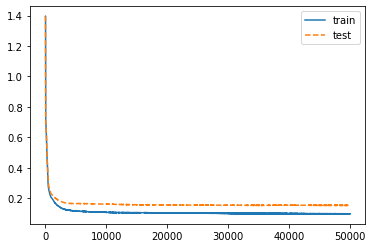

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN);
best, test_loss_PNN[best]

In [25]:
# torch.save(PNN, f'./pendigitresult/PNN_10_10.pkl')

## Evaluation

In [166]:
# PNN = torch.load(f'./pendigitresult/PNN_10_10.pkl')

In [ ]:
def set_time(pnn, t):
    for l in pnn:
        l.t = t
    return pnn

def make_model(pnn):
    for l in pnn:
        l.generate_aging_model()
    return pnn

another approach to change time and model

In [441]:
def settime(m, t):
    if isinstance(m, pnn.PNNLayer):
        m.t = t
def makemodel(m):
    if isinstance(m, pnn.PNNLayer):
        m.generate_aging_model()
def zerogradient(m):
    if isinstance(m, pnn.PNNLayer):
        for p in m.parameters():
            if p.grad is not None:
                p.grad = torch.zeros_like(p.grad)
# nn.apply(lambda z: settime(z, 0.1))

In [364]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0, 1, 50)
PNN_acc = []
PNN_maa = []

for omega in range(500):
    PNN.apply(makemodel)
    for test_t in test_time:
        PNN.apply(lambda z: settime(z, test_t))
        for x_valid, y_valid in valid_loader:
            PNN_acc.append(evaluation.basic(PNN, x_valid, y_valid))
            PNN_maa.append(evaluation.maa(PNN, x_valid, y_valid))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

evaluating on the 0-th model.
evaluating on the 10-th model.
evaluating on the 20-th model.
evaluating on the 30-th model.
evaluating on the 40-th model.
evaluating on the 50-th model.
evaluating on the 60-th model.
evaluating on the 70-th model.
evaluating on the 80-th model.
evaluating on the 90-th model.
evaluating on the 100-th model.
evaluating on the 110-th model.
evaluating on the 120-th model.
evaluating on the 130-th model.
evaluating on the 140-th model.
evaluating on the 150-th model.
evaluating on the 160-th model.
evaluating on the 170-th model.
evaluating on the 180-th model.
evaluating on the 190-th model.
evaluating on the 200-th model.
evaluating on the 210-th model.
evaluating on the 220-th model.
evaluating on the 230-th model.
evaluating on the 240-th model.
evaluating on the 250-th model.
evaluating on the 260-th model.
evaluating on the 270-th model.
evaluating on the 280-th model.
evaluating on the 290-th model.
evaluating on the 300-th model.
evaluating on the 3

In [365]:
PNN_acc = np.array(PNN_acc).reshape([500, 50])
mean_PNN_acc = np.mean(PNN_acc, axis=0).flatten()
std_PNN_acc = np.std(PNN_acc, axis=0).flatten()

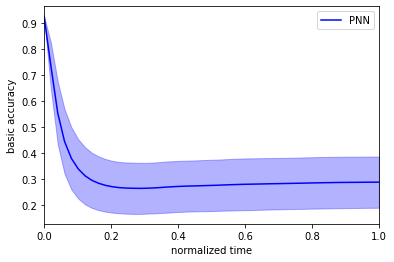

In [366]:
plt.fill_between(test_time, mean_PNN_acc-std_PNN_acc, mean_PNN_acc +
                 std_PNN_acc, alpha=0.3, color='blue')
plt.plot(test_time, mean_PNN_acc, label='PNN', color='blue')
plt.xlabel('normalized time')
plt.ylabel('basic accuracy')
plt.xlim([0, 1])
plt.legend()

# Aging Aware PNN
## Training

In [430]:
K = 5  # number of time sampling
M = 5  # number of model sampling

AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                                pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                                pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                                pnn.PNNLayer(N_Hidden, N_class, age_generator))

optimizer_aged = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
AAPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [431]:
def MakeParallelPNNs(pnn, M, K):
    
    Parallel_PNNs = []
    
    # copy M PNNs
    pnn_with_different_models = [make_model(copy.deepcopy(pnn)) for m in range(M)]
    
    for n in pnn_with_different_models:        
        # copy each aging model K times
        pnn_with_different_times = [copy.deepcopy(set_time(n, np.random.rand())) for k in range(K)]
        # give them different time stamps
        Parallel_PNNs.append(pnn_with_different_times)
    Parallel_PNNs = [item for sublist in Parallel_PNNs for item in sublist]
    return Parallel_PNNs

In [432]:
def MakeParallelModels(pnn, M):
    # copy M PNNs
    pnn_with_different_models = [make_model(copy.deepcopy(pnn)) for m in range(M)]
    
    for n in pnn_with_different_models:        
        n.apply(makemodel)
    return pnn_with_different_models

In [433]:
Parallel_PNNs = MakeParallelModels(AAPNN,M)
len(Parallel_PNNs)

5

In [434]:
from joblib import Parallel, delayed
from math import sqrt
Parallel(n_jobs=2)(delayed(sqrt)(i**2) for i in range(10))
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [ ]:
m = 0.3
T = 0.1
for epoch in range(50000):
#     optimizer_aged.zero_grad()
    
    # copy aapnn M*K times for parallel training
    Parallel_Models = MakeParallelModels(AAPNN, M)
    
    # for each aapnn, apply forward propagation
    for aapnn in Parallel_PNNs:
        aapnn.apply(zerogradient)
        for k in range(K):
            aapnn.apply(lambda z: settime(z, np.random.rand()))
            for X_train, y_train in train_loader:
                prediction = aapnn(X_train)
                loss = pnn.LossFunction(prediction, y_train, m, T)
                loss.backward()
    
    # get gradients for each layer of AAPNN
    # enlarge 1 dim for torch.cat, i.e. temp is [M*K, n_out, n_in+2] dimensional tensor
    # average w.r.t. 0. dimension, i.e. M*K parallel aapnns
    for n, p in AAPNN.named_parameters():
        temp = torch.cat([dict(pnn.named_parameters())[n].grad.view(1,dict(pnn.named_parameters())[n].grad.shape[0],dict(pnn.named_parameters())[n].grad.shape[1]) for pnn in Parallel_PNNs])
        p.grad = torch.mean(temp, dim=0) / K  

    # optimization
    optimizer_aged.step()
    
    
    # test
    avg_loss = 0
    avg_acc = 0
    test_time = np.linspace(0,1,10)
    for omega in range(10):
        AAPNN = make_model(AAPNN)
        for test_t in test_time:
            AAPNN = set_time(AAPNN, test_t) 
            for x_valid, y_valid in test_loader:
                prediction_valid = AAPNN(x_valid)
                loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)
                p = torch.argmax(prediction_valid, dim=1)
                pred_y = p.data.numpy().squeeze()
                acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]

                avg_loss += loss_valid.data
                avg_acc += acc_valid

    avg_loss /= 100
    avg_acc /= 100
    print(f'| Epoch: {epoch:-5d} | Accuracy: {avg_acc:.5f} | Loss: {avg_loss:.5f} |')

| Epoch:     0 | Accuracy: 0.10582 | Loss: 1.39979 |
| Epoch:     1 | Accuracy: 0.10562 | Loss: 1.39896 |
| Epoch:     2 | Accuracy: 0.10569 | Loss: 1.39709 |
| Epoch:     3 | Accuracy: 0.10571 | Loss: 1.39881 |
| Epoch:     4 | Accuracy: 0.10562 | Loss: 1.39829 |
| Epoch:     5 | Accuracy: 0.10598 | Loss: 1.40375 |


In [ ]:
plt.plot(myloss)
best = np.argmin(myloss)
MyPNN.load_state_dict(myparameter[best])
prediction_valid = MyPNN(x_valid)
loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)
loss_valid.data

## Evaluation

In [ ]:
m = 0.3
T = 0.1
myloss_aged, myparameter_aged = training.train_aged_pnn(MyAgedPNN,
                                                        train_loader, test_loader,
                                                        m, T, M, K, optimizer_aged, 500)

## Early Stop

In [ ]:
plt.plot(myloss_aged)
best_aged = np.argmin(myloss_aged)
MyAgedPNN.load_state_dict(myparameter_aged[best_aged])
best_aged

# Save and Read

In [ ]:
# torch.save(MyPNN, f'./simpleclassification/MyPNN_{N_Layer}_{N_Hidden}.pkl')
# torch.save(MyAgedPNN, f'./simpleclassification/MyAgedPNN_{N_Layer}_{N_Hidden}.pkl')

In [ ]:
# MyPNN = torch.load('/simpleclassification/MyPNN.pkl')
# MyAgedPNN = torch.load('/simpleclassification/MyAgedPNN.pkl')

# Evaluation
Evaluate two NNs with 1000 different aging models and over time.

## Test

In [ ]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0, 1, 100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for omega in range(1000):
    for l in MyAgedPNN:
        l.generate_aging_model()
    for l in MyPNN:
        l.generate_aging_model()
    for test_t in test_time:
        for i in MyAgedPNN:
            i.t = test_t
        for i in MyPNN:
            i.t = test_t

        my_aged_acc.append(evaluation.basic(MyAgedPNN, x_valid, y_valid))
        my_acc.append(evaluation.basic(MyPNN, x_valid, y_valid))

        my_aged_maa.append(evaluation.maa(MyAgedPNN, x_valid, y_valid))
        my_maa.append(evaluation.maa(MyPNN, x_valid, y_valid))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

In [ ]:
my_acc = np.array(my_acc).reshape([1000, 100])
my_aged_acc = np.array(my_aged_acc).reshape([1000, 100])

mean_acc = np.mean(my_acc, axis=0).flatten()
mean_aged_acc = np.mean(my_aged_acc, axis=0).flatten()

std_acc = np.std(my_acc, axis=0).flatten()
std_aged_acc = np.std(my_aged_acc, axis=0).flatten()

## Visualization

In [ ]:
plt.fill_between(test_time, mean_aged_acc-std_aged_acc,
                 mean_aged_acc+std_aged_acc, alpha=0.3, color='red')
plt.fill_between(test_time, mean_acc-std_acc, mean_acc +
                 std_acc, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_acc, label='aging aware', color='red')
plt.plot(test_time, mean_acc, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('basic accuracy')
plt.xlim([0, 1])
plt.legend()

In [ ]:
my_maa = np.array(my_maa).reshape([1000, 100])
my_aged_maa = np.array(my_aged_maa).reshape([1000, 100])

mean_maa = np.mean(my_maa, axis=0).flatten()
mean_aged_maa = np.mean(my_aged_maa, axis=0).flatten()

std_maa = np.std(my_maa, axis=0).flatten()
std_aged_maa = np.std(my_aged_maa, axis=0).flatten()

In [ ]:
plt.fill_between(test_time, mean_aged_maa-std_aged_maa,
                 mean_aged_maa+std_aged_maa, alpha=0.3, color='red')
plt.fill_between(test_time, mean_maa-std_maa, mean_acc +
                 std_maa, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_maa, label='aging aware', color='red')
plt.plot(test_time, mean_maa, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('measure aware accuracy')
plt.xlim([0, 1])
plt.legend()